# ANN for Active Wildfire classification
Eduardo Merinos Sosa - 2021

An algorithm is created in order to classify remotely sensed data from the SLSTR instrument (Sentinel-3). All the data has been previously pre-processed and classified using SNAP (Sentinel Aplication Platform). The algorithm used to classify the images is described in https://rus-copernicus.eu/portal/wp-content/uploads/library/education/training/HAZA04_ActiveFire_Portugal_Tutorial_Webinar.pdf.

This notebook is designed to run using a modified kernel in order to use GPU capabilities.

In [1]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt
import gdal
import tensorflow as tf
from tensorflow import keras
from skimage import io, util

In [2]:
# Function to load raster files as numpy arrays
def load_satrstr(filename):
    dataset = gdal.Open(filename, gdal.GA_ReadOnly)
    # Opened image dimensions
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    bands = dataset.RasterCount
    # LATLONG info
    geotransform = dataset.GetGeoTransform()
    xOrigin = geotransform[0]
    yOrigin = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    # Array manipulation
    raster_array = dataset.ReadAsArray()
    return raster_array

In [3]:
# Loading the arrays using the defined function
stack_dir = r"C:\Users\yng3d\Desktop\S3_September\Stack_Sept-Oct.tif"
stack = load_satrstr(stack_dir)

# Resulting array dimentions:
print(stack.shape)


(610, 585, 620)


This means the resulting array is composed of 610 "bands" or images which are ordered in a repetitive fashion, this order is described next:

1. cloud_mask 
2. F1
3. F2
4. CCI Land Cover 2015
5. fire_detection

These images represent all aquired scenes from September to October 2020, the last presented band (#5) is the resulting Active Fire (AF) classification

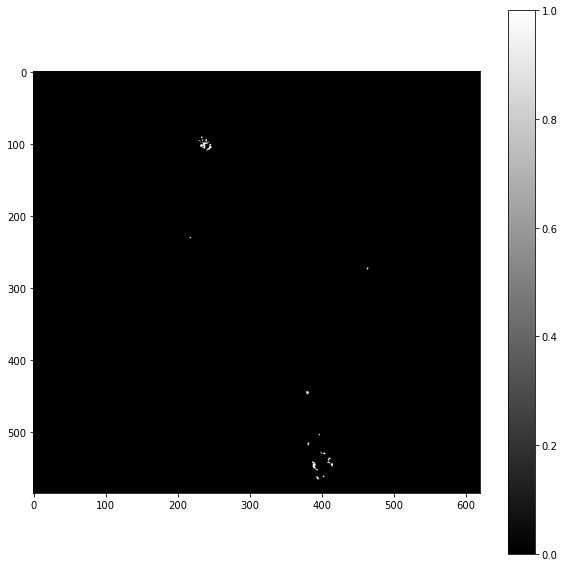

In [4]:
#Verificación de orden de arreglos
plt.figure(figsize = (10,10))
plt.imshow(stack[4], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

_Classifications are extracted from the array to be used as target/labels in a different array_

In [5]:
lbl_index = []
for i in range(122):
    ind = 4+i*5
    lbl_index.append(ind)
    
labels = stack[lbl_index]
labels.shape

(122, 585, 620)

_We erase such targets/labels so we get the resulting $X$ array._

In [6]:
stack_x = np.delete(stack, lbl_index, 0)
print(stack_x.shape)

# Se crea una copia del stack_x para usarlo despues para eliminar los valores nan:
# stack_nans = np.delete(stack, lbl_index, 0)
# print(stack_nans.shape)

(488, 585, 620)


_`nan` values are erased from the array (turned to 0)_

In [7]:
stack_x[np.isnan(stack_x)] = 0

_The array is then reshaped to dimensions: `Day`,`Band`,`Y`,`X`_

In [8]:
stack_x = stack_x.reshape(122, 4, 585, 620)

_Values are then normalized band-wisely_

In [9]:
nstack_x = stack_x 

for i in range(122):
    for j in range (4):
        nstack_x[i,j] = nstack_x[i,j] / nstack_x[:,j].max()

_We verify the properly normalization of the data, displaying it_

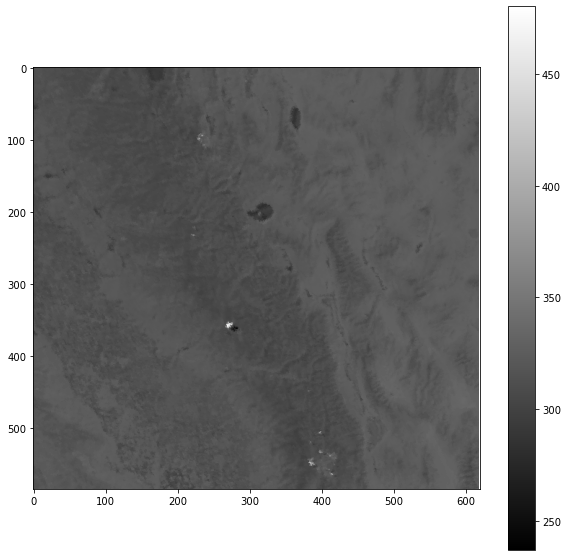

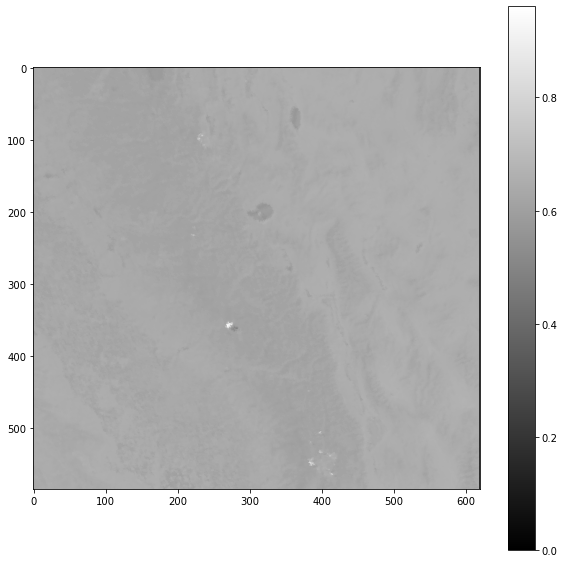

In [11]:
#Verificación de orden de arreglos
plt.figure(figsize = (10,10))
plt.imshow(stack[21], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

#Verificación de orden de arreglos
plt.figure(figsize = (10,10))
plt.imshow(nstack_x[4,1], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

_From this point forward, the images are reshaped, no longer considering `Y` and `X` coordinates but pixels in an image_

In [12]:
nstack_x = nstack_x.reshape(122, 4, 362700)
labels = labels.reshape(122, 362700)

## Train-test-validation split

In [13]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(nstack_x, labels, test_size=0.40, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.50, random_state=42)

print("Train shape:")
print(X_train.shape, y_train.shape)
print(" ")
print("Validation shape:")
print(X_val.shape, y_val.shape)
print(" ")
print("Test shape:")
print(X_test.shape, y_test.shape)
print(" ")

Train shape:
(36, 4, 362700) (36, 362700)
 
Validation shape:
(37, 4, 362700) (37, 362700)
 
Test shape:
(49, 4, 362700) (49, 362700)
 


_The arrays are reshaped to match the ANN input: `Pixel` and `Band`_

In [15]:
X_val = X_val.reshape(362700*37, 4)
y_val = y_val.reshape(362700*37)

## Avoiding overfitting of the model
As expected, the number of pixels classified as `Normal` overpasses by a long margin those classified as `ActiveFire`. This WILL overfit the model; removing the posibility of detecting any active fires. To overcome this problem, all `1`s and `0`s are extracted from the training array in order to create a second array which will only have a limited number of `0`s, chosen randomly.

_Extracting `1` values_

In [16]:
ones = np.empty((0,4))
ones_lbl = np.empty((0,))
for i in range(36):
    ones_i = np.where(y_train[i] == 1)[0]
    ones_train = X_train[i,:,ones_i]
    ones = np.append(ones, ones_train, axis=0)

    ones_label_i = y_train[i, ones_i]
    ones_lbl = np.append(ones_lbl, ones_label_i, axis=0)
ones.shape, ones_lbl.shape

((8588, 4), (8588,))

_Extracting `0` values_

In [17]:
zeros = np.empty((0,4))
zeros_lbl = np.empty((0,))
for i in range(36):
    zeros_i = np.where(y_train[i] == 0)[0]
    zeros_train = X_train[i,:,zeros_i]
    zeros = np.append(zeros, zeros_train, axis=0)
    
    zeros_label_i = y_train[i, zeros_i]
    zeros_lbl = np.append(zeros_lbl, zeros_label_i, axis=0)
zeros.shape, zeros_lbl.shape

((13048612, 4), (13048612,))

_Randomly choosing `0`s to use for training, we picked 3000000 `0`s from a total of 13048612_

In [27]:
zero_index = np.random.choice(zeros.shape[0], 3000000, replace=False) # Generador de indices aleatorios
zeros_train = zeros[zero_index]
zeros_tlbl = np.zeros(3000000) # Se crea un arreglo de 0s para sustituir el arreglo de labels original

_Training array is then created, concatenating both the chosen `0`s and `1`s arrays_

In [28]:
ctrain = np.concatenate((ones, zeros_train), axis=0) # Arreglo de entrenamiento coregido
ctrain_lbl = np.concatenate((ones_lbl, zeros_tlbl), axis=0)
print(ctrain.shape, ctrain_lbl.shape)

(3008588, 4) (3008588,)


### Defining the ANN
Simple model, based on the Multi-Layer-Perceptron

In [29]:
# Model build
model = keras.Sequential([
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Model compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
history = model.fit(ctrain, ctrain_lbl, epochs=50, validation_data = (X_val, y_val), verbose=2, batch_size=2048)

Train on 3008588 samples, validate on 13419900 samples
Epoch 1/50
3008588/3008588 - 21s - loss: 0.0435 - accuracy: 0.9971 - val_loss: 0.0067 - val_accuracy: 0.9994
Epoch 2/50
3008588/3008588 - 19s - loss: 0.0142 - accuracy: 0.9971 - val_loss: 0.0109 - val_accuracy: 0.9994
Epoch 3/50
3008588/3008588 - 21s - loss: 0.0111 - accuracy: 0.9971 - val_loss: 0.0116 - val_accuracy: 0.9994
Epoch 4/50
3008588/3008588 - 22s - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0127 - val_accuracy: 0.9994
Epoch 5/50
3008588/3008588 - 23s - loss: 0.0075 - accuracy: 0.9974 - val_loss: 0.0128 - val_accuracy: 0.9991
Epoch 6/50
3008588/3008588 - 18s - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0128 - val_accuracy: 0.9991
Epoch 7/50
3008588/3008588 - 18s - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0128 - val_accuracy: 0.9991
Epoch 8/50
3008588/3008588 - 18s - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0131 - val_accuracy: 0.9991
Epoch 9/50
3008588/3008588 - 18s - loss: 0.0067 - accuracy: 0.9981 - val_

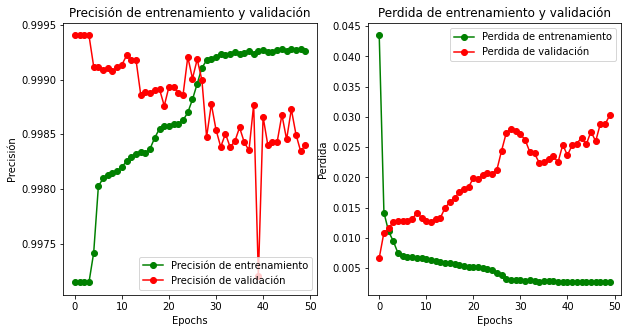

In [32]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Precisión")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training and validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Perdida")
plt.show()

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  20        
_________________________________________________________________
dense_1 (Dense)              multiple                  125       
_________________________________________________________________
dense_2 (Dense)              multiple                  1300      
_________________________________________________________________
dense_3 (Dense)              multiple                  510       
_________________________________________________________________
dense_4 (Dense)              multiple                  11        
Total params: 1,966
Trainable params: 1,966
Non-trainable params: 0
_________________________________________________________________


## Making predictions
Predictions are made by using the test array. A list of items is created, which will be re-arranged as a numpy array later on

In [34]:
predictions = []
for i in range(49):
    test_img = X_test[i,:,:].T
    pred_i = model.predict_classes(test_img)
    predictions.append(pred_i)
len(predictions)

49

In [37]:
np.sum(np.array(predictions)) # We verify there are 'ones' in the classification

509529

In [38]:
y_pred = np.array(predictions).reshape(49, 362700)

In [39]:
y_test = y_test.astype(np.int32)

In [40]:
print(y_test.shape, y_pred.shape)
y_test = y_test.reshape(49*362700)
y_pred = y_pred.reshape(49*362700)
print(y_test.shape, y_pred.shape)

(49, 362700) (49, 362700)
(17772300,) (17772300,)


In [41]:
y_test.dtype, y_pred.dtype

(dtype('int32'), dtype('int32'))

## Accuracy assesment

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

Overall accuracy:  0.9716363104381538
Balanced accuracy:  0.8700363572339371
Class 0 Accuracy:  0.9998639268284333
Class 1 Accuracy:  0.015288629302748224


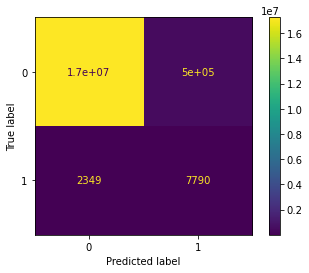

In [43]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print("Overall accuracy: ", accuracy_score(y_test, y_pred))
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

print("Class 0 Accuracy: ", cm[0,0]/(cm[0,0]+cm[1,0]))
print("Class 1 Accuracy: ", cm[1,1]/(cm[1,1]+cm[0,1]))

In [44]:
cm

array([[17260422,   501739],
       [    2349,     7790]], dtype=int64)

### Re-assesing, removing badly classified images

In [45]:
y_test_corr = y_test.reshape(49,362700)
y_pred_corr = y_pred.reshape(49,362700)

y_test_corr = np.delete(y_test_corr, [11, 18, 45], axis=0) # Badly classified images
y_pred_corr = np.delete(y_pred_corr, [11, 18, 45], axis=0)

y_test_corr = y_test_corr.reshape(46*362700)
y_pred_corr = y_pred_corr.reshape(46*362700)

y_test_corr.shape, y_pred_corr.shape

((16684200,), (16684200,))

Overall accuracy:  0.9996526054590571
Balanced accuracy:  0.8927284755578818
Class 0 Accuracy:  0.9998734464122627
Class 1 Accuracy:  0.6772611855354173


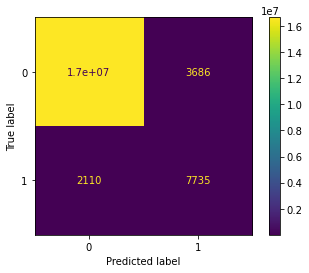

In [46]:
cm = confusion_matrix(y_test_corr, y_pred_corr)
cm_display = ConfusionMatrixDisplay(cm).plot()

print("Overall accuracy: ", accuracy_score(y_test_corr, y_pred_corr))
print("Balanced accuracy: ", balanced_accuracy_score(y_test_corr, y_pred_corr))

print("Class 0 Accuracy: ", cm[0,0]/(cm[0,0]+cm[1,0]))
print("Class 1 Accuracy: ", cm[1,1]/(cm[1,1]+cm[0,1]))

In [47]:
cm

array([[16670669,     3686],
       [    2110,     7735]], dtype=int64)

## Displaying classification results, individually:

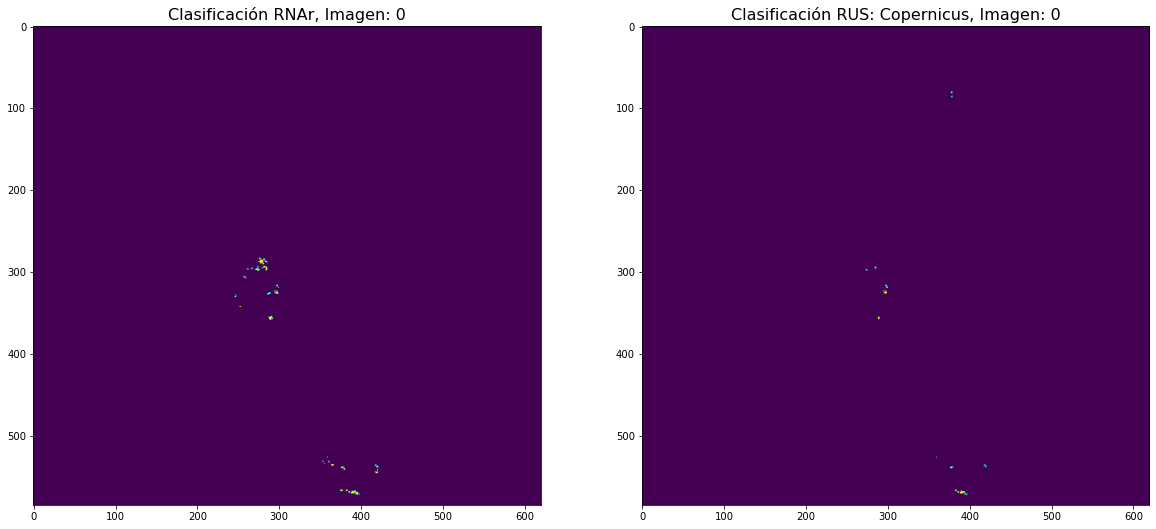

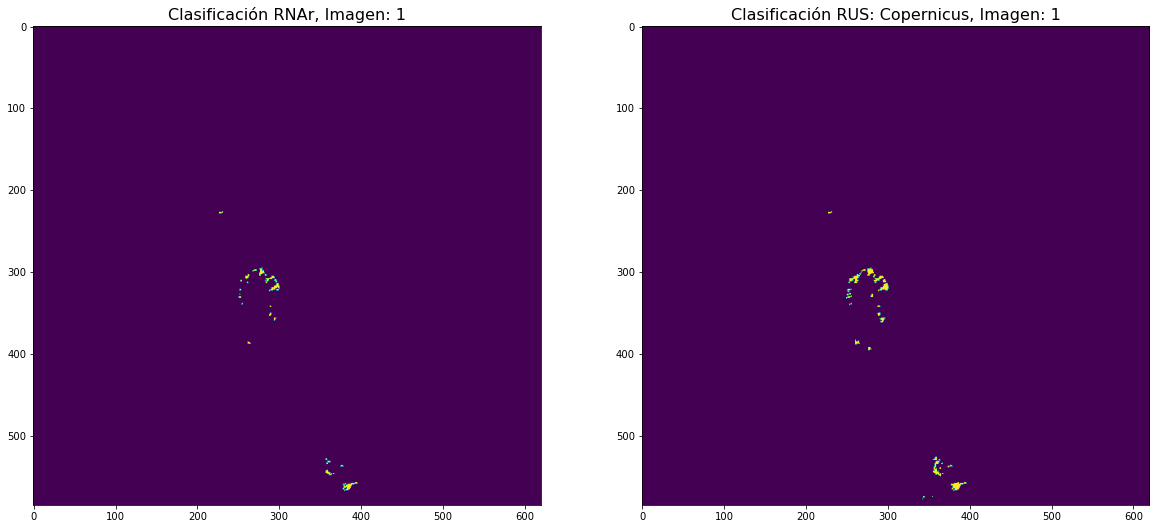

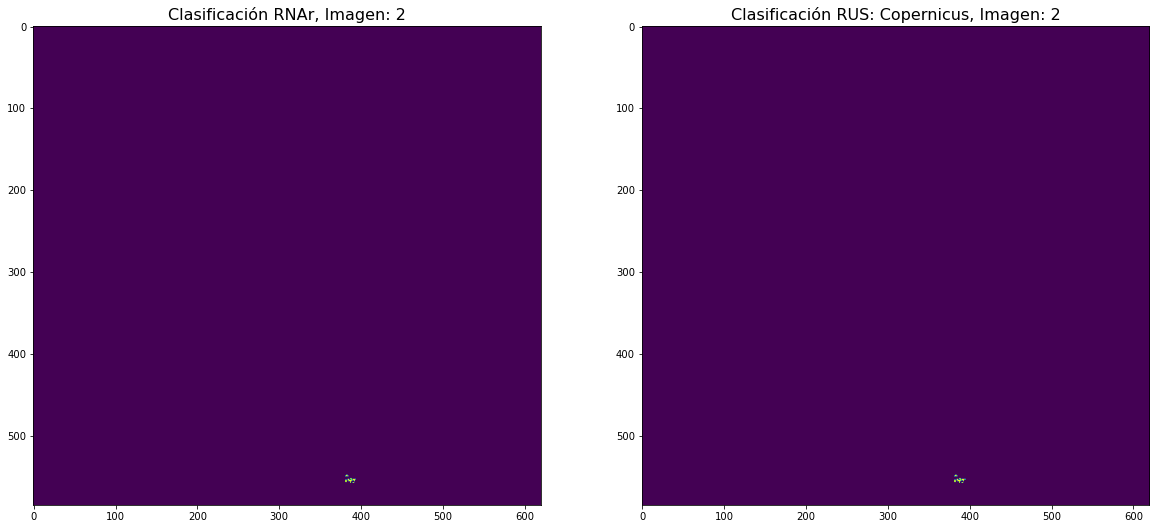

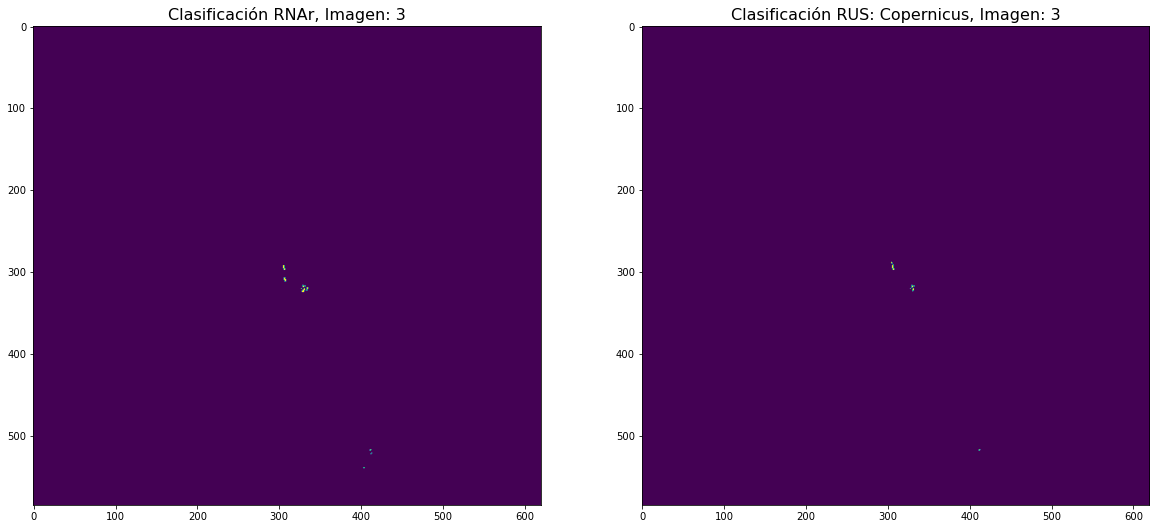

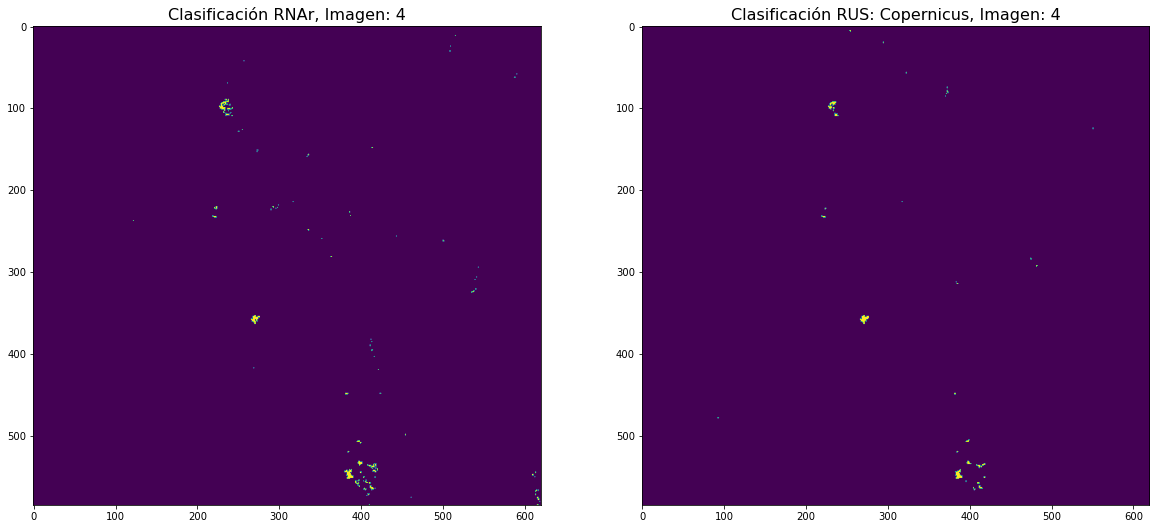

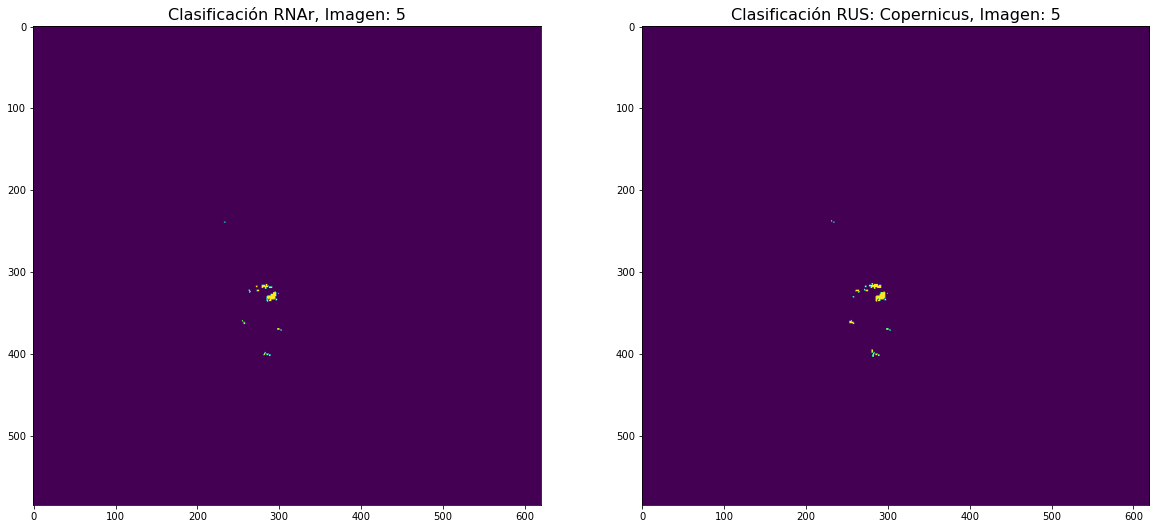

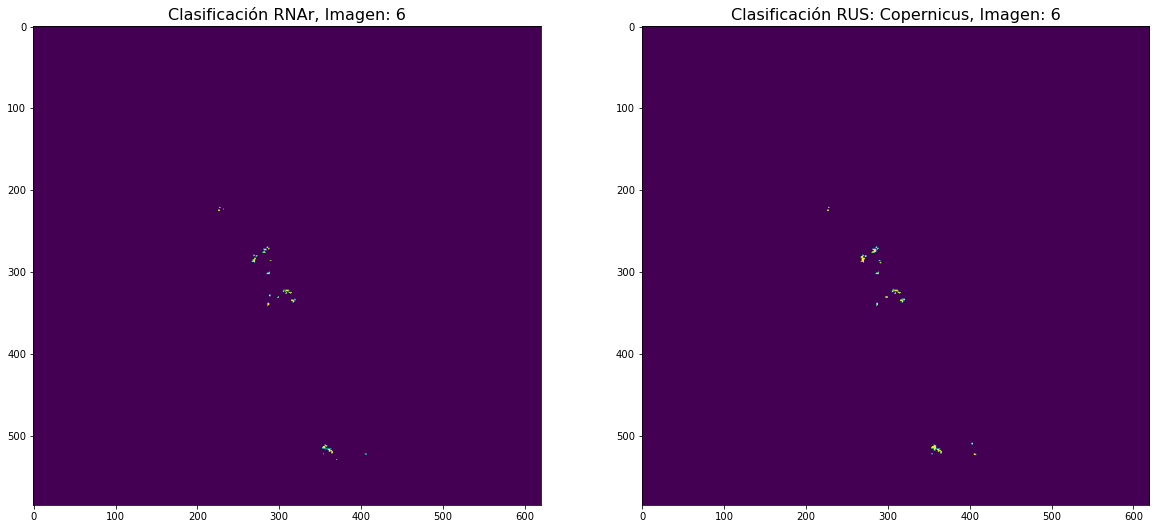

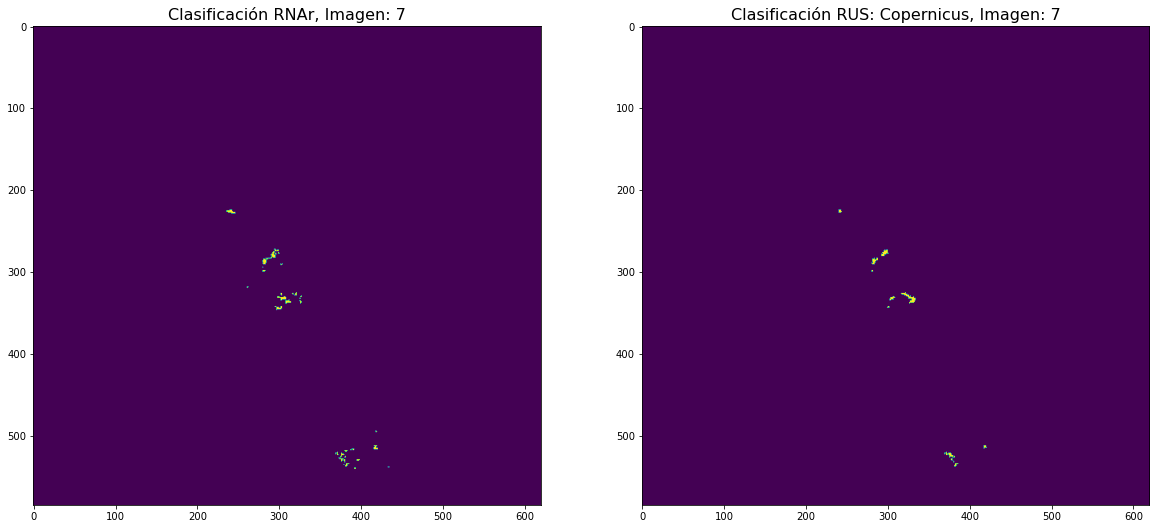

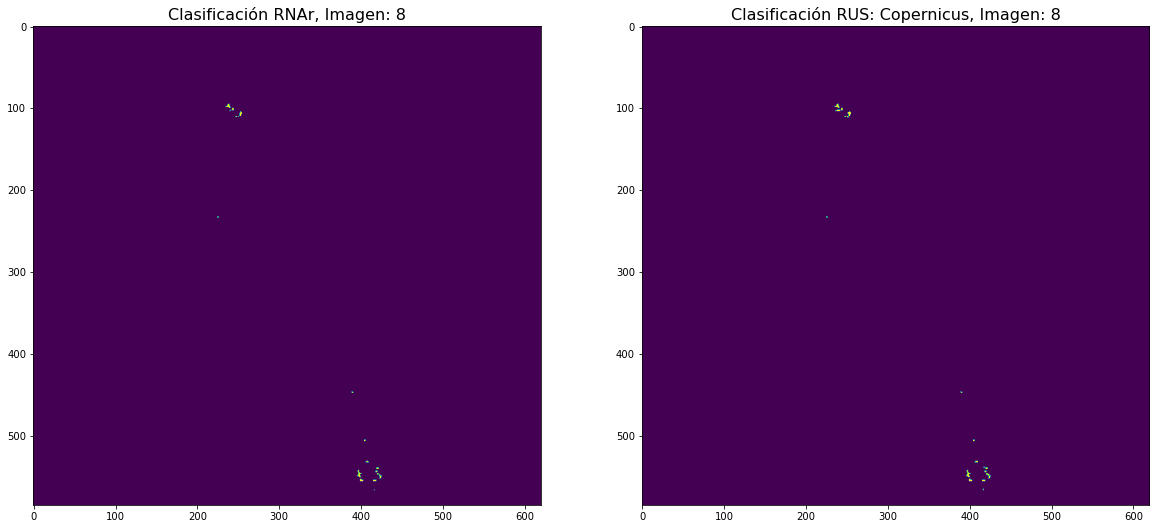

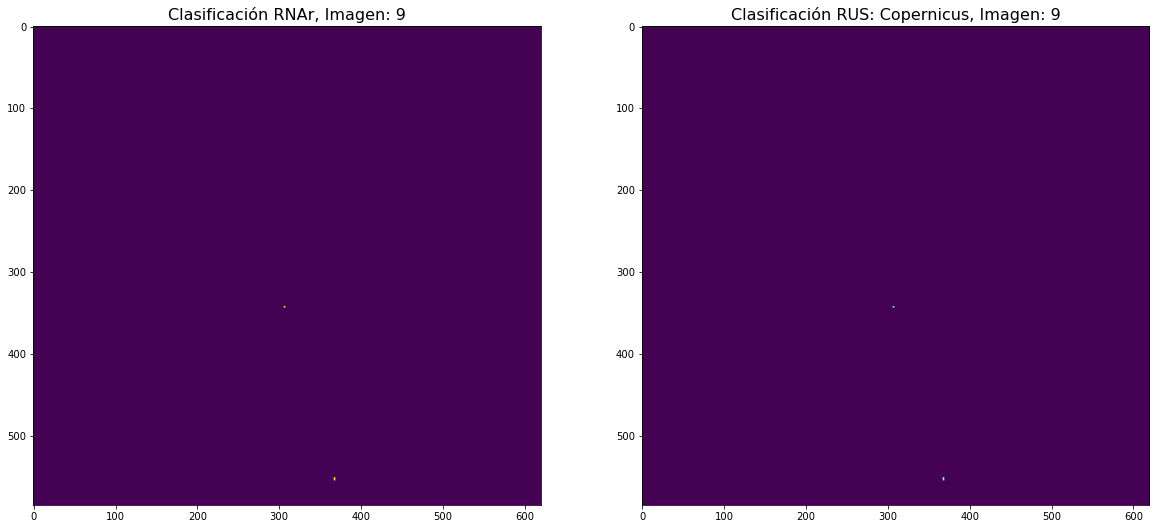

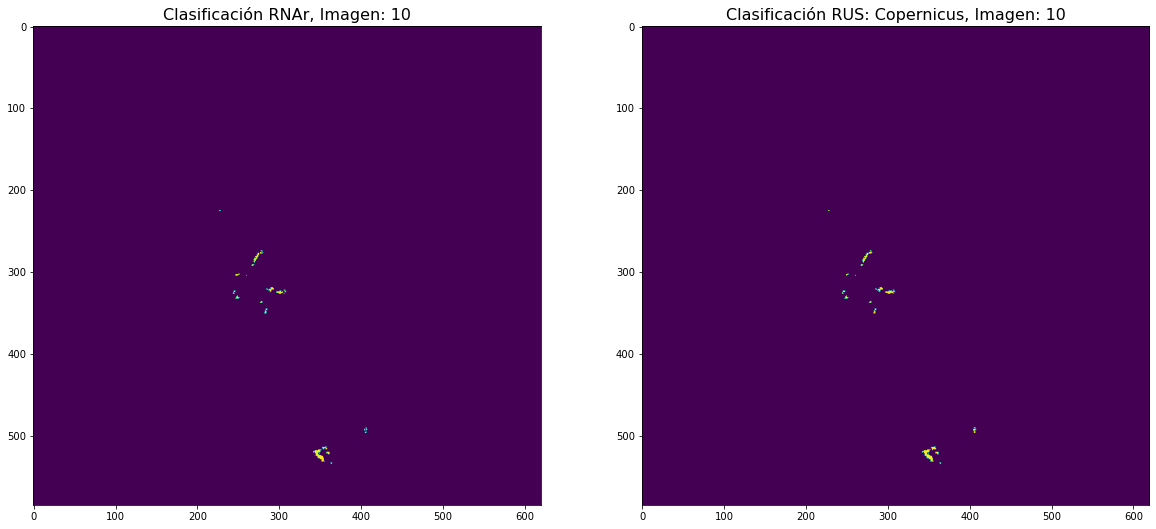

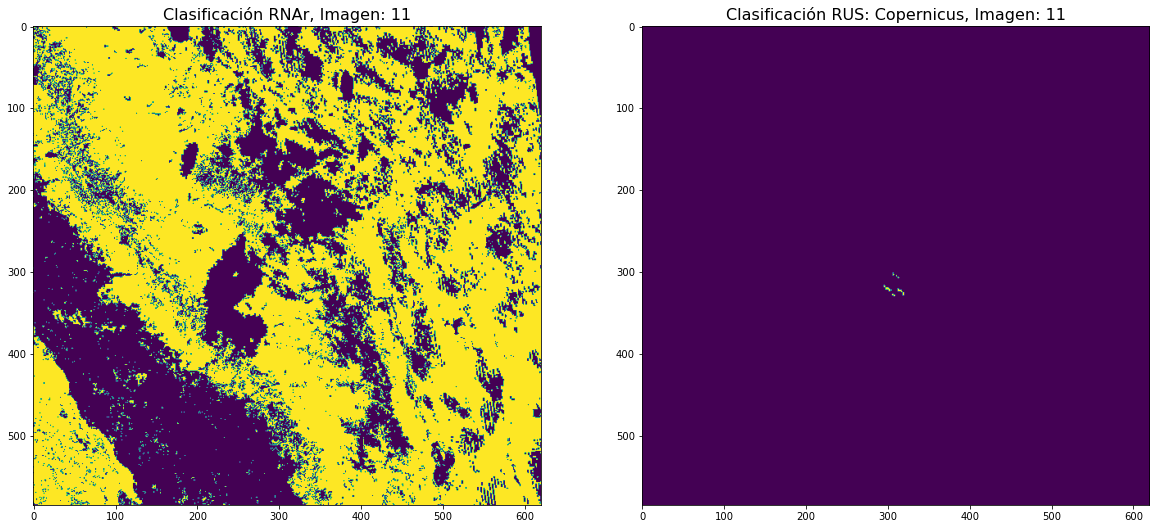

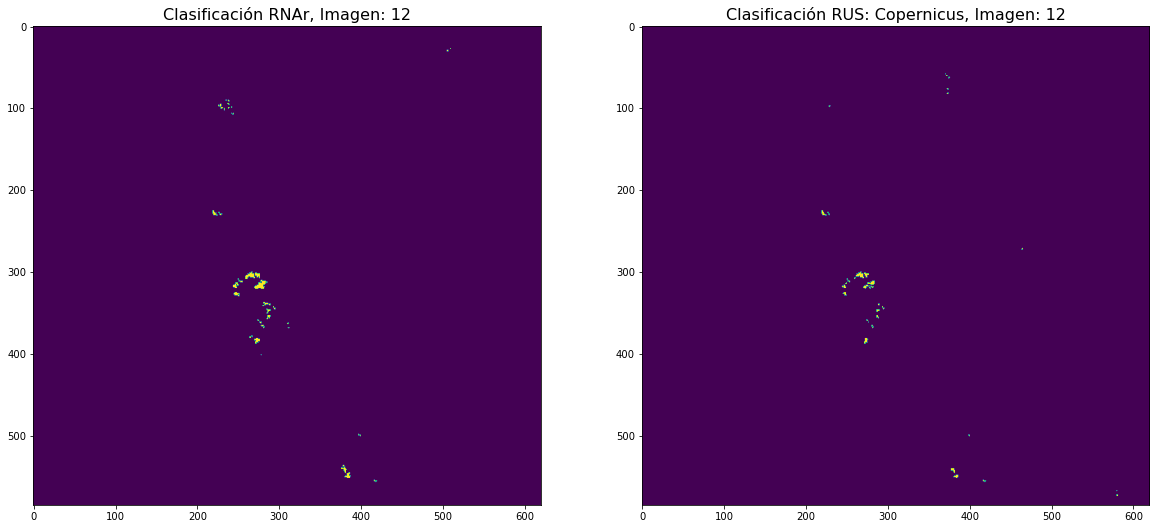

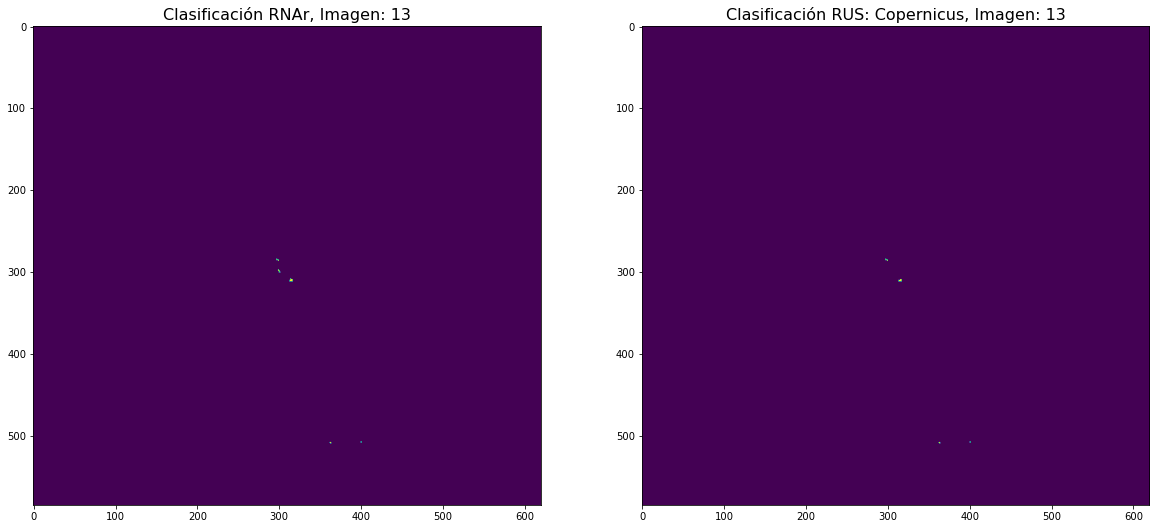

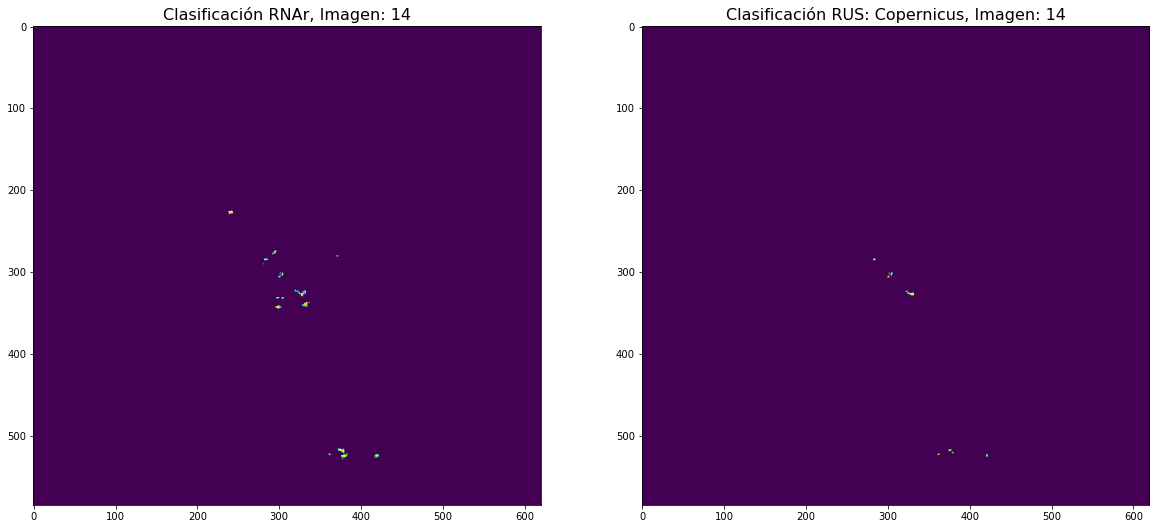

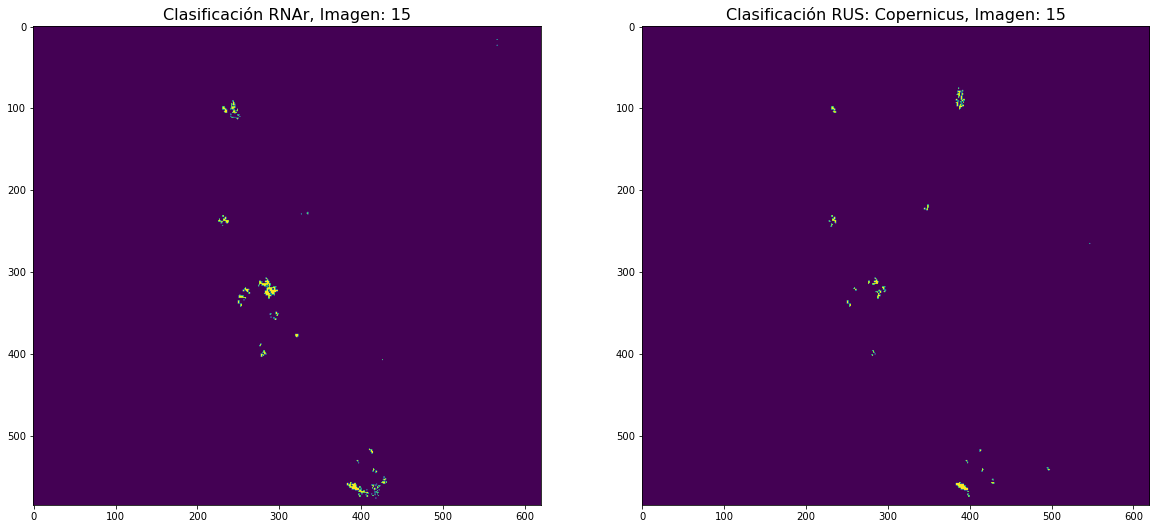

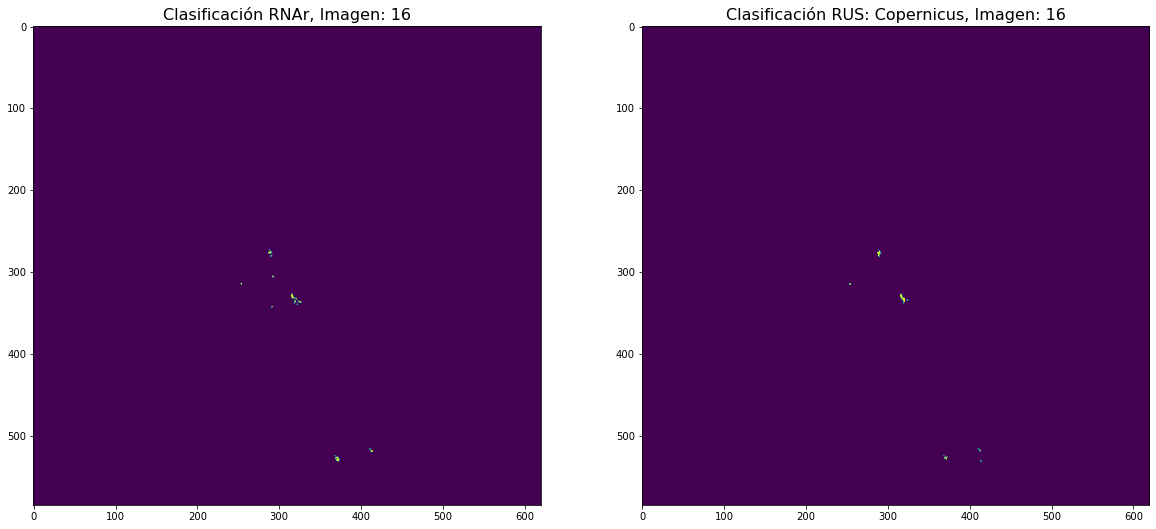

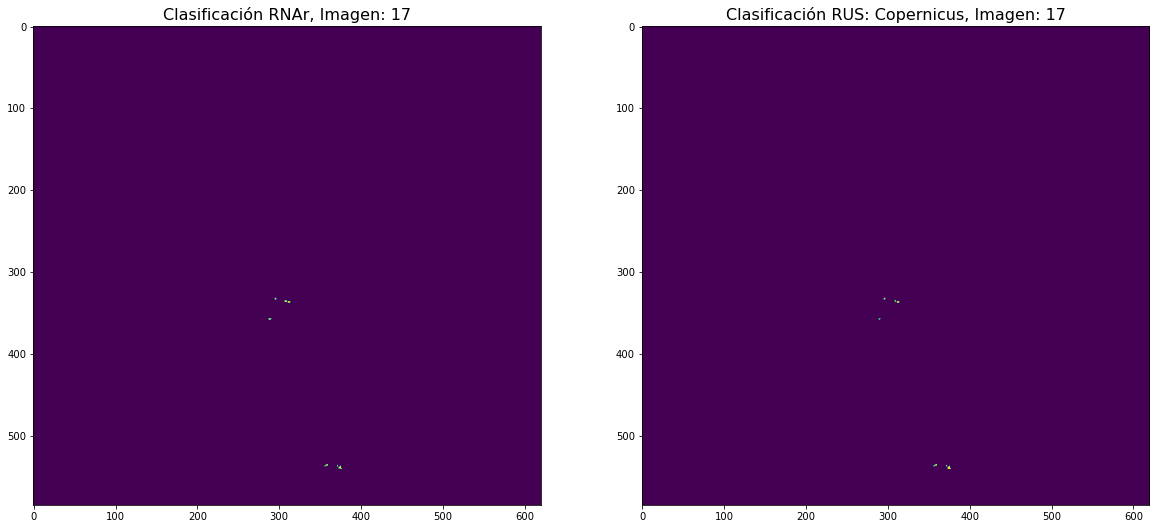

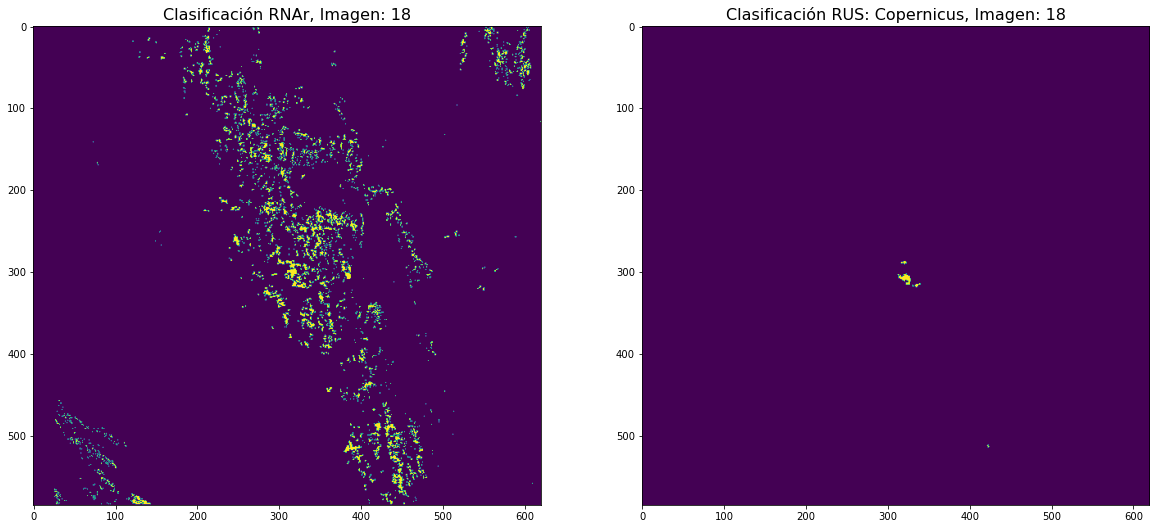

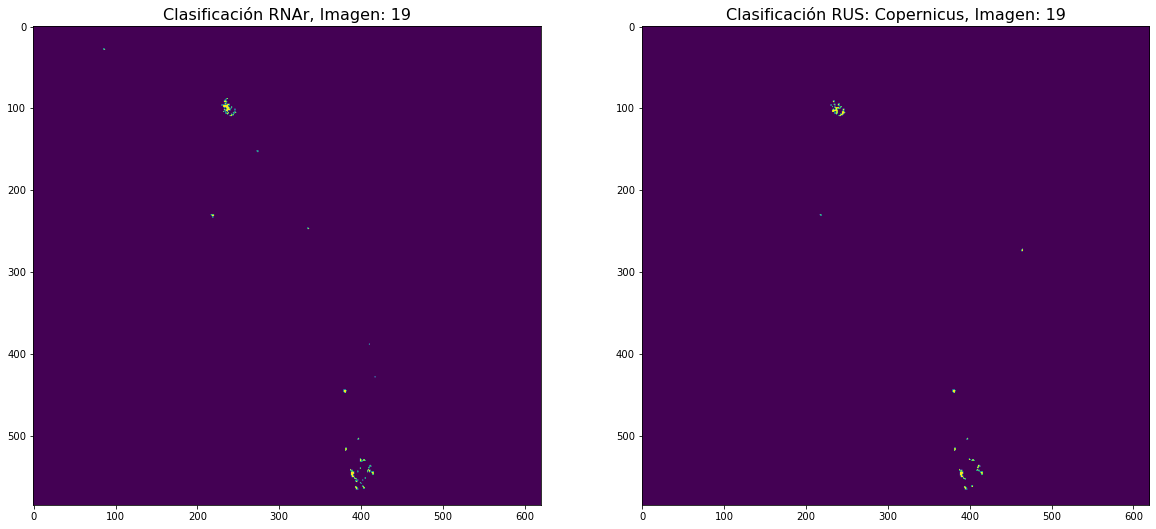

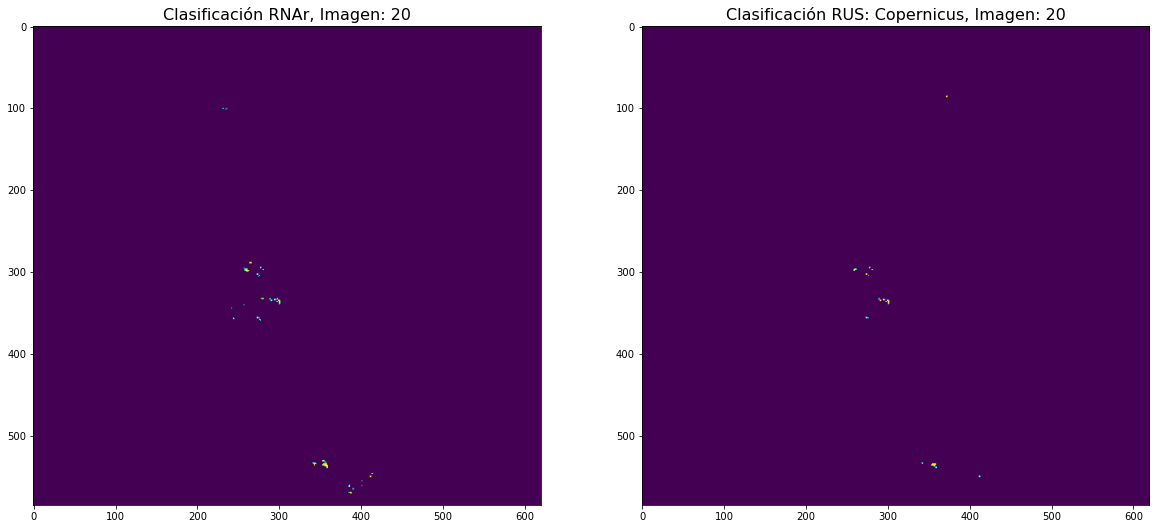

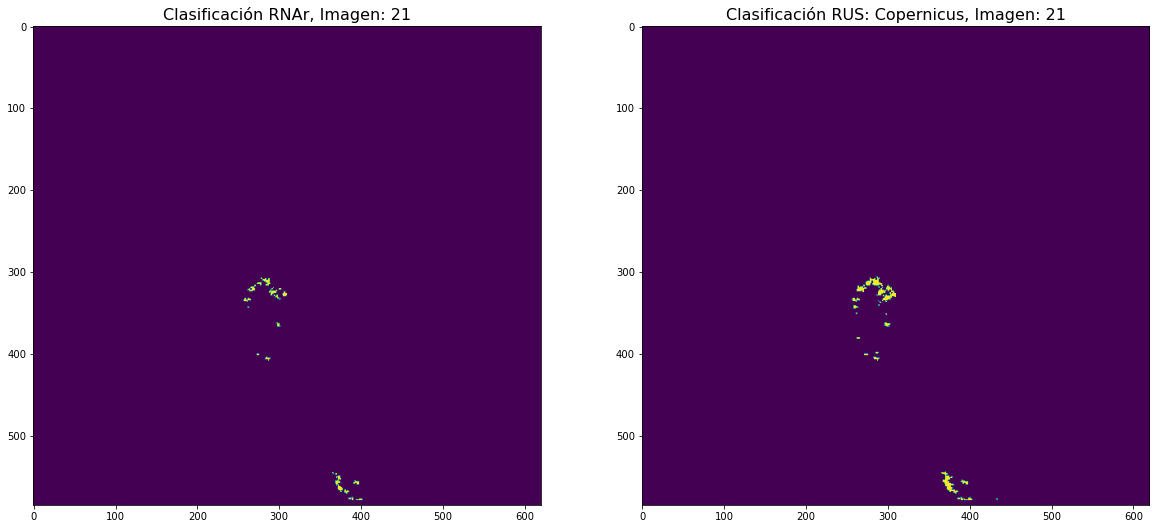

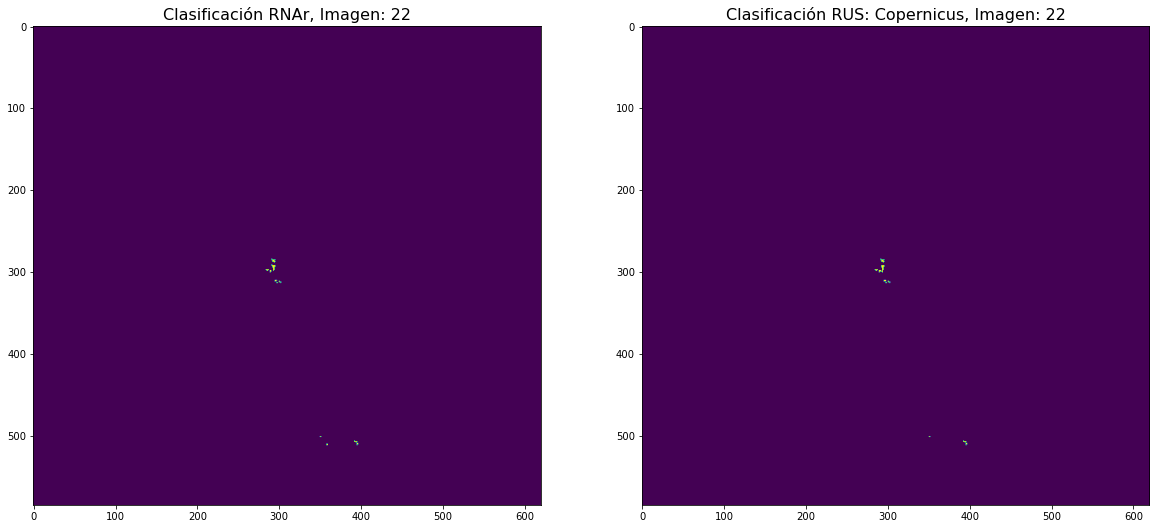

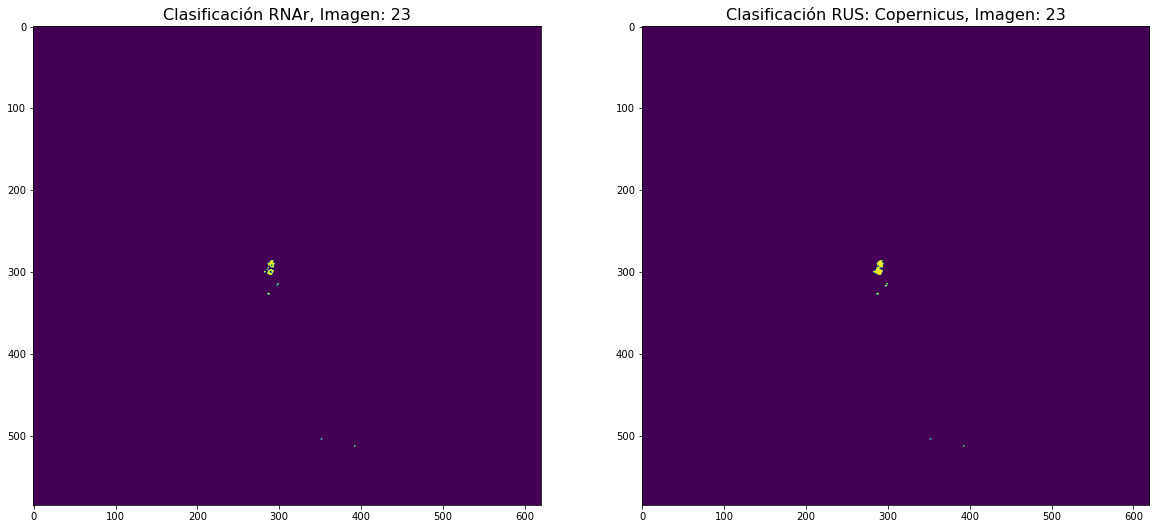

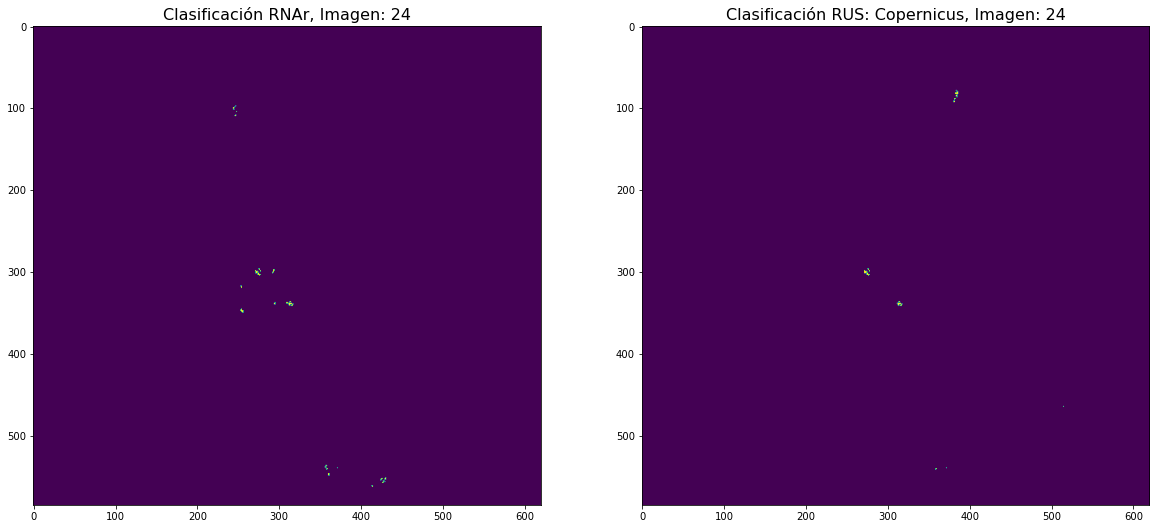

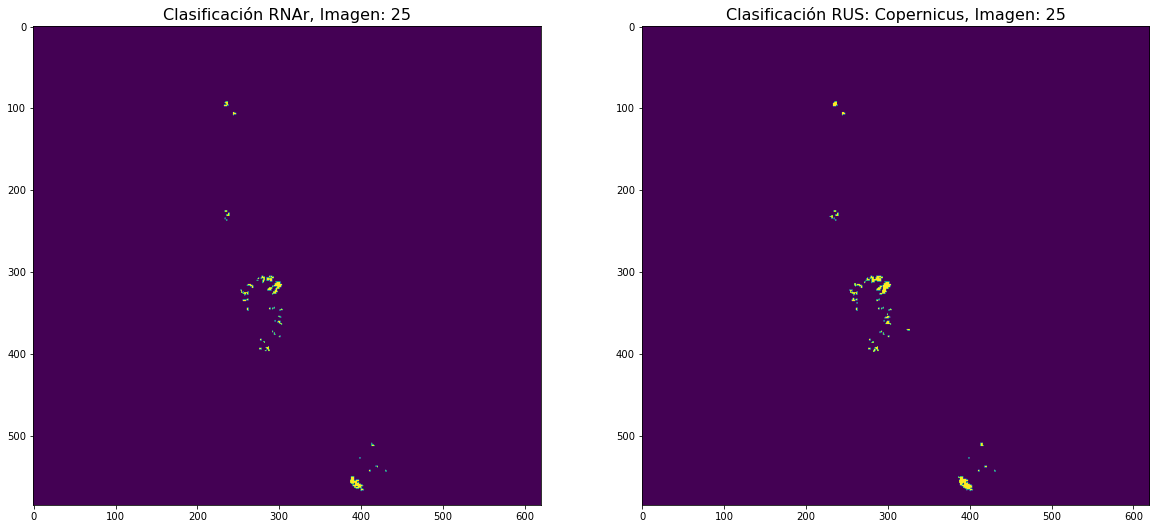

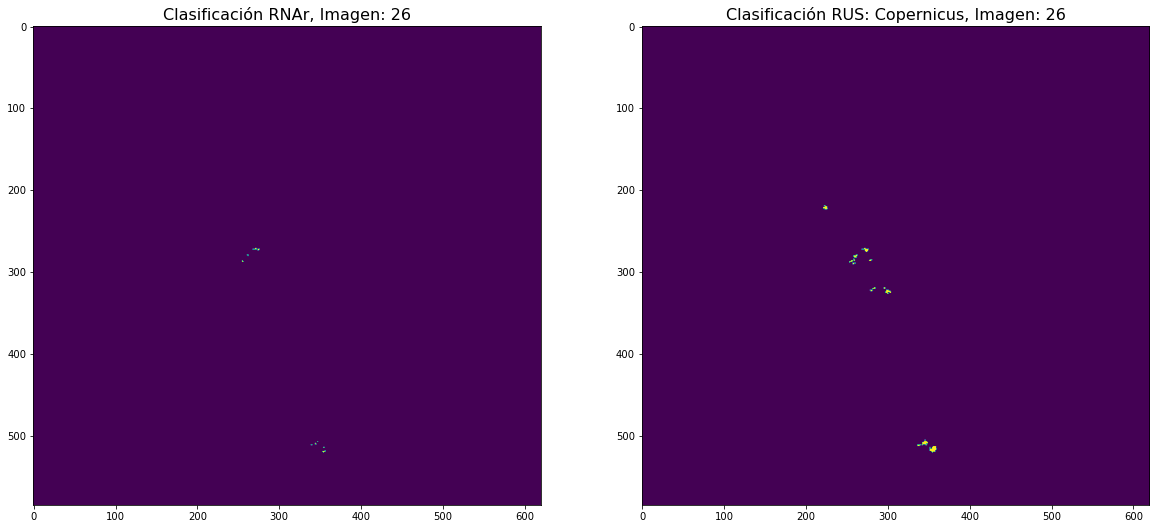

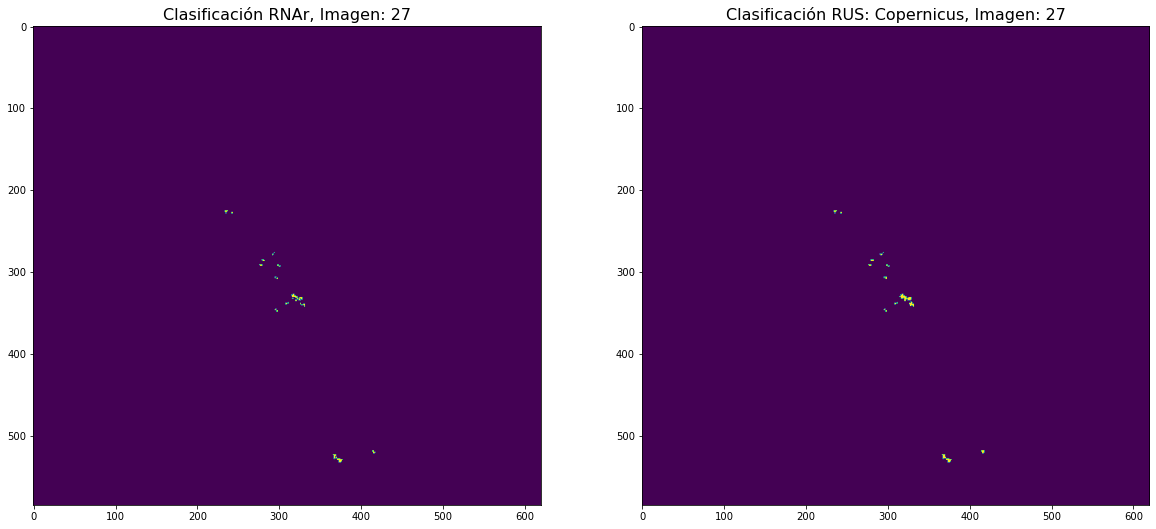

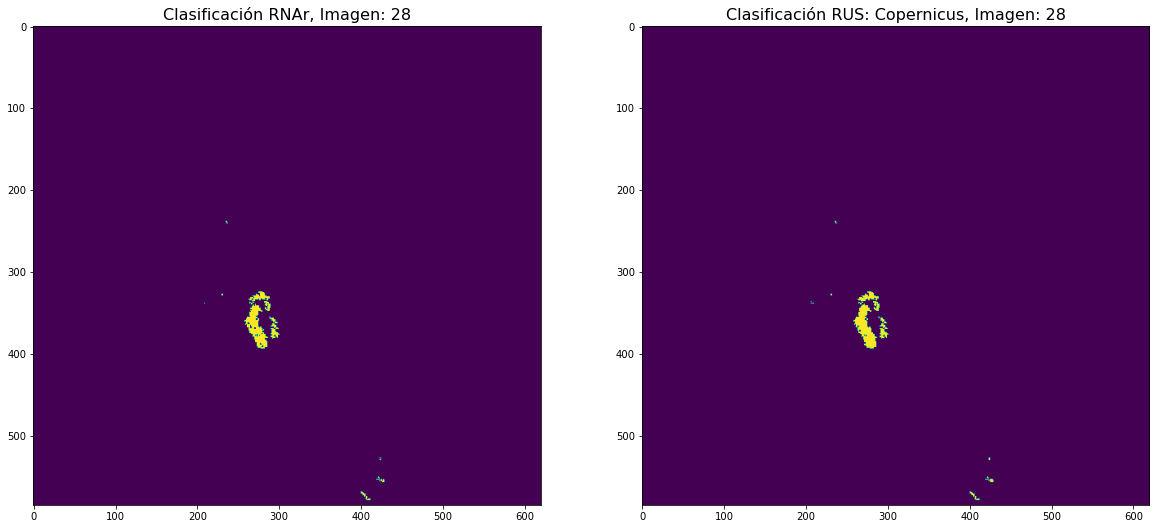

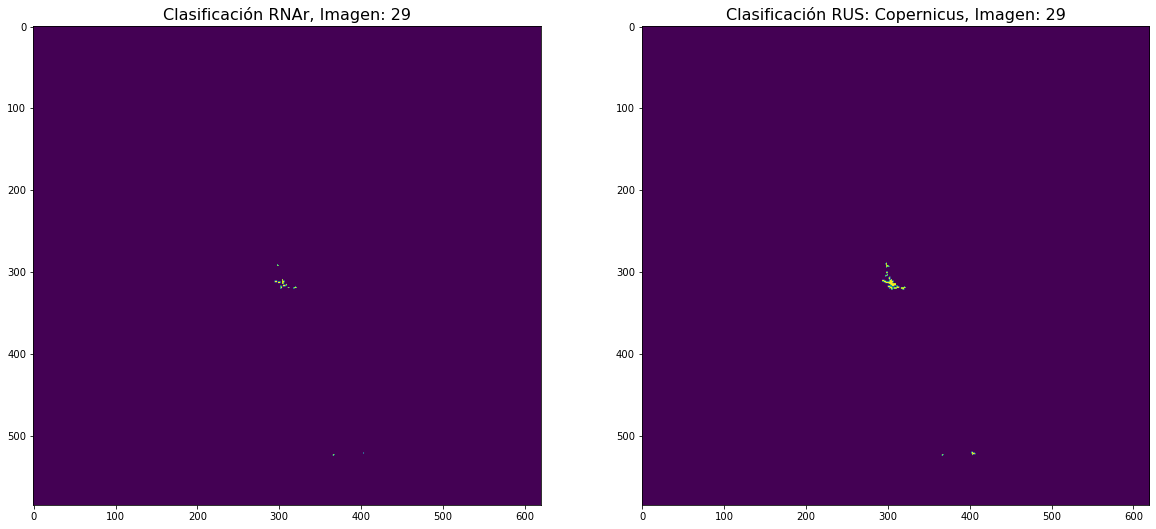

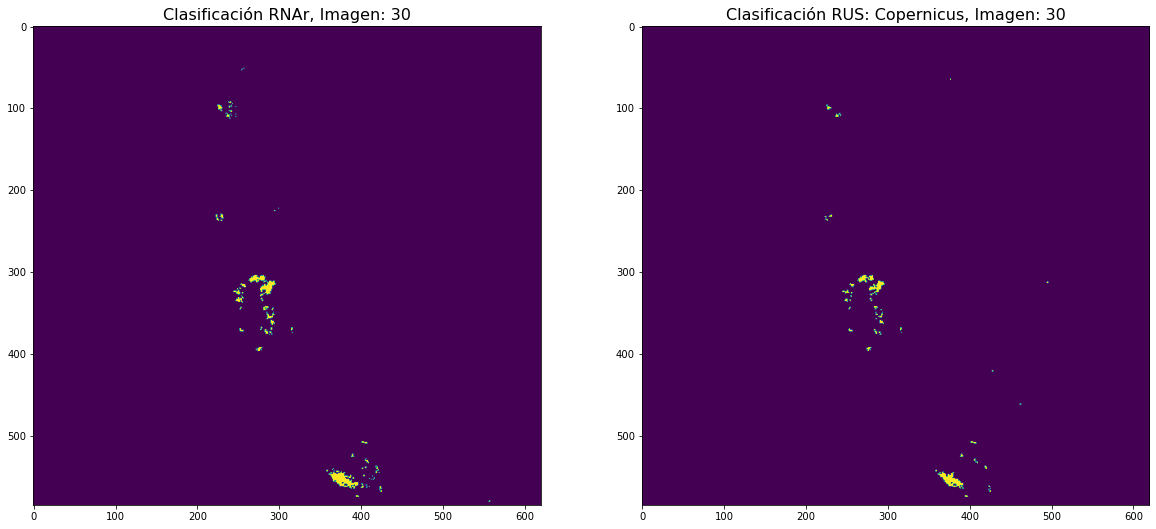

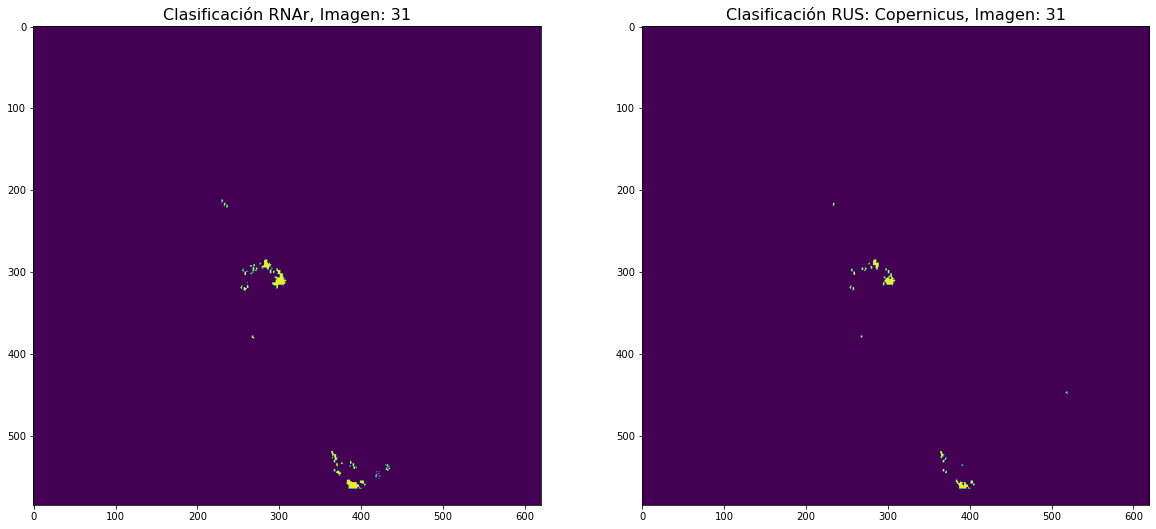

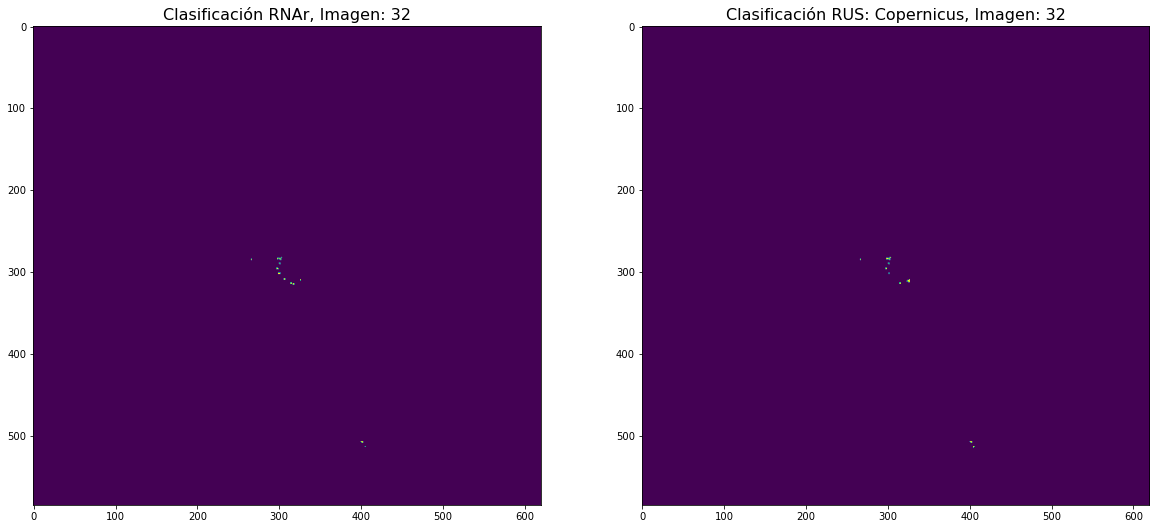

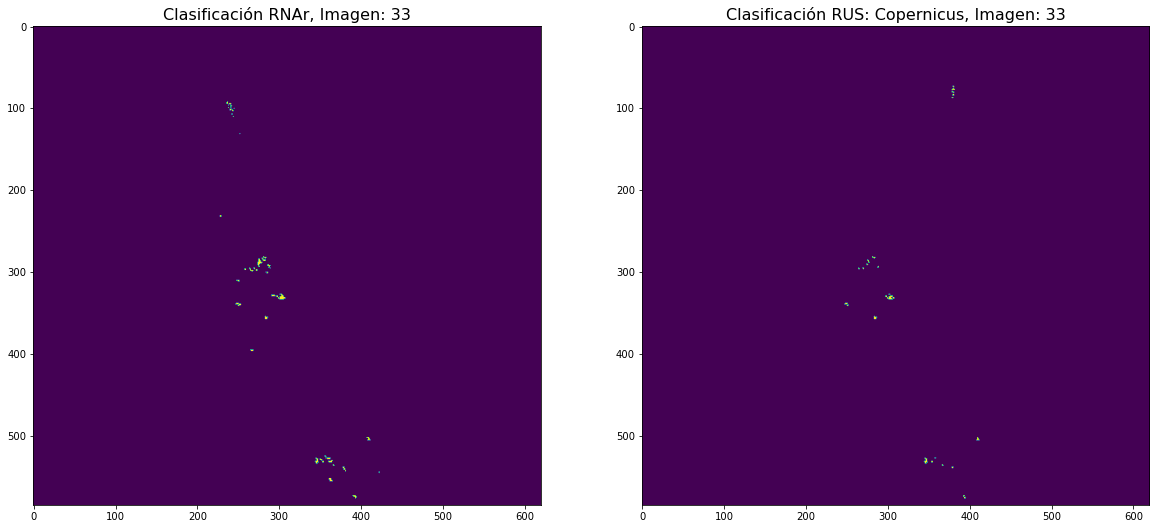

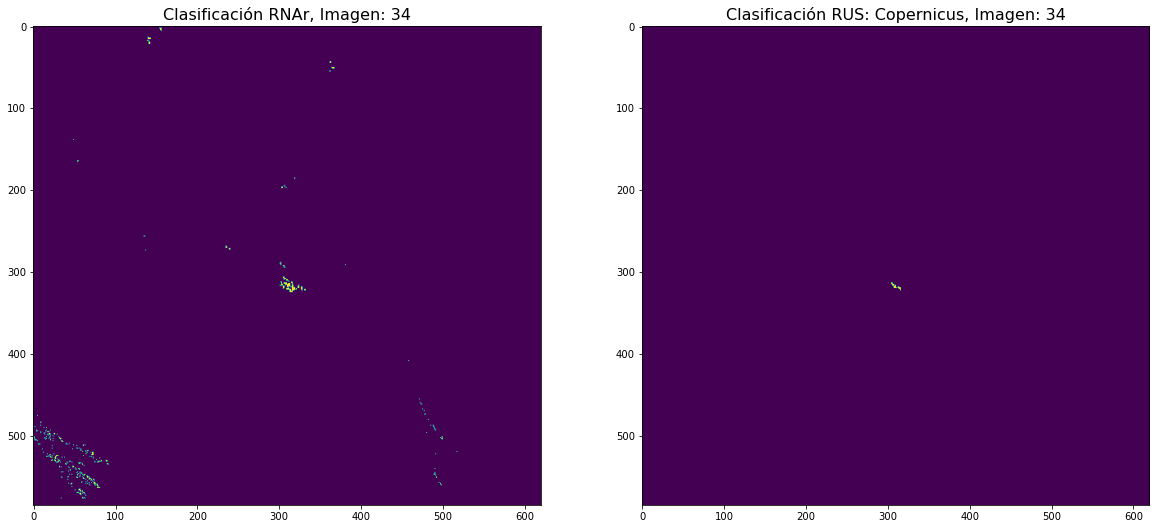

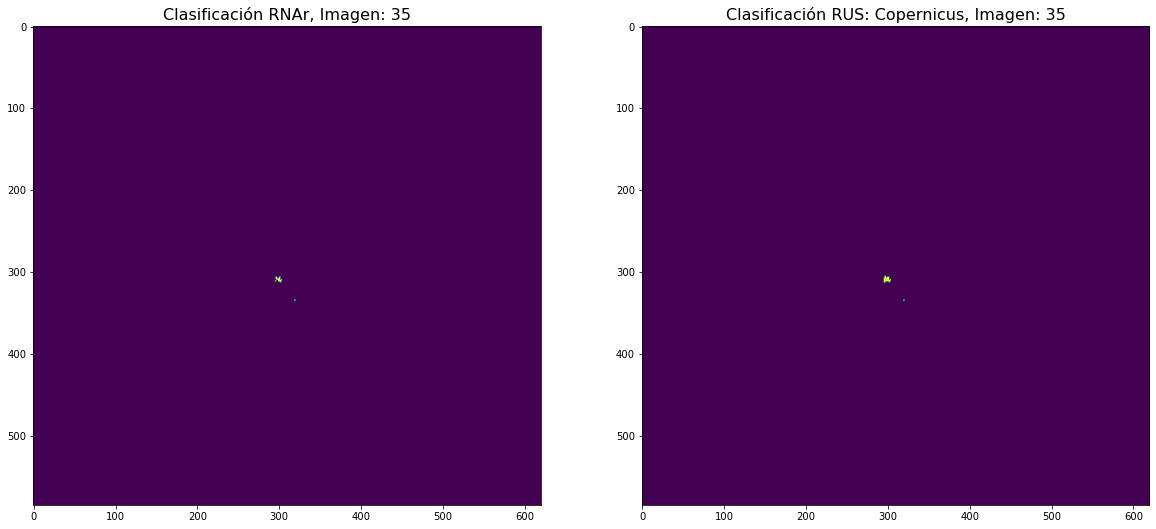

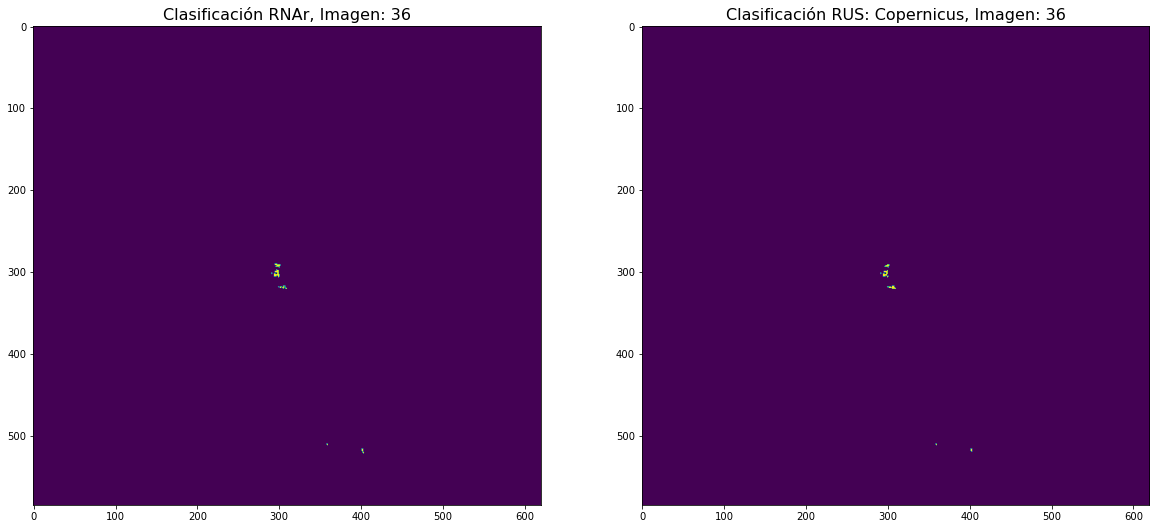

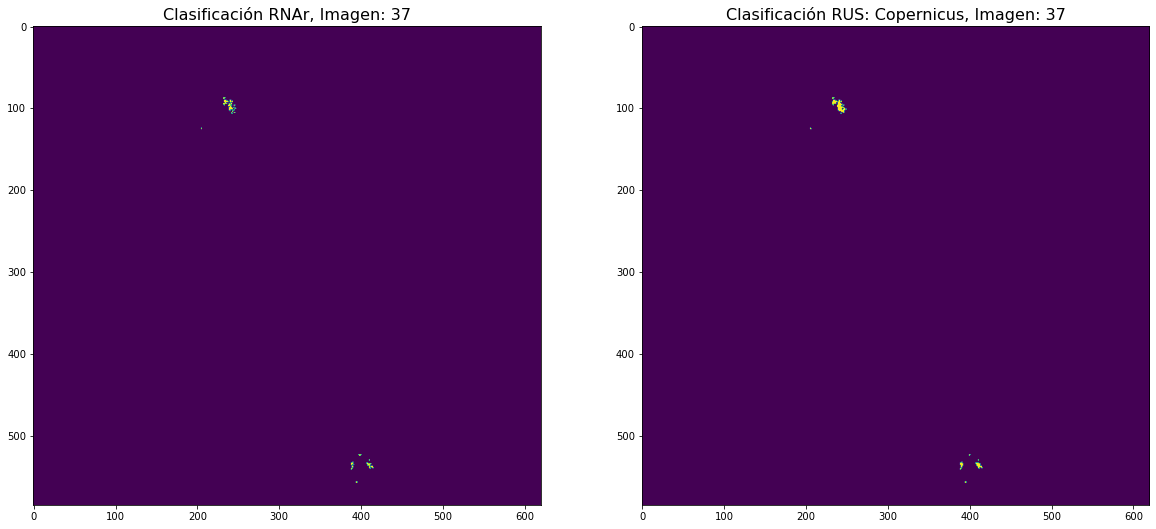

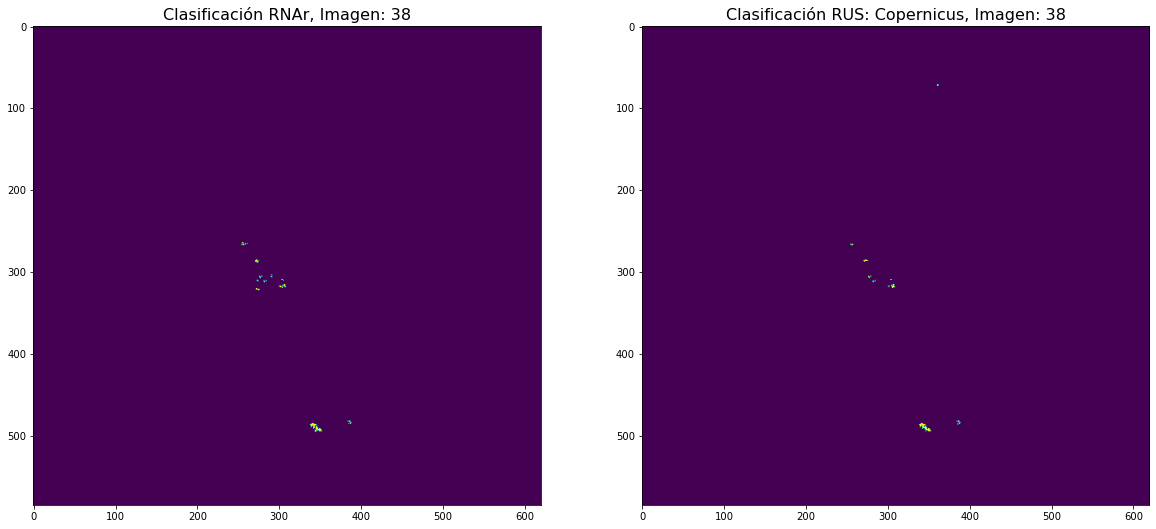

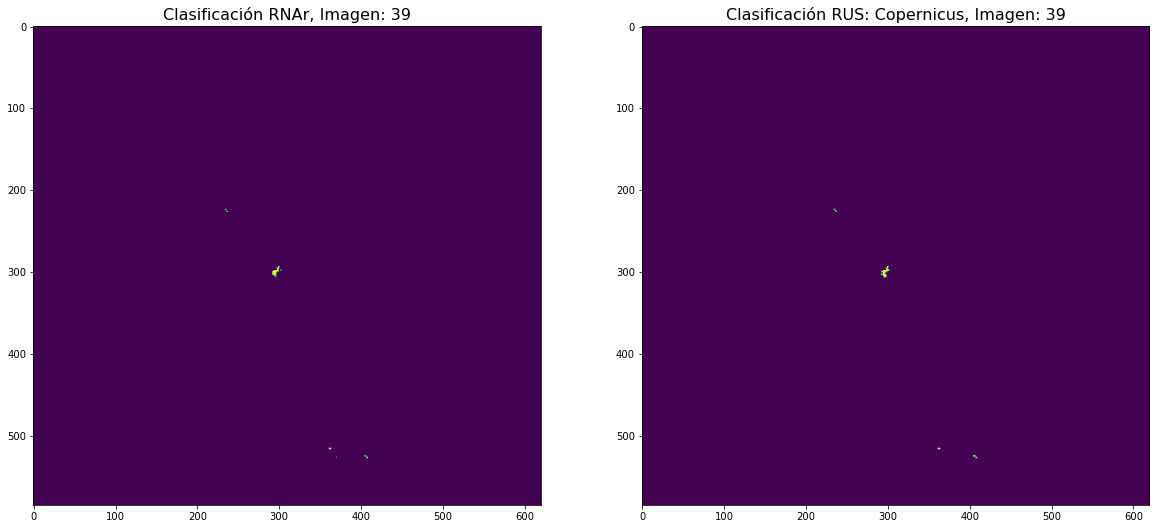

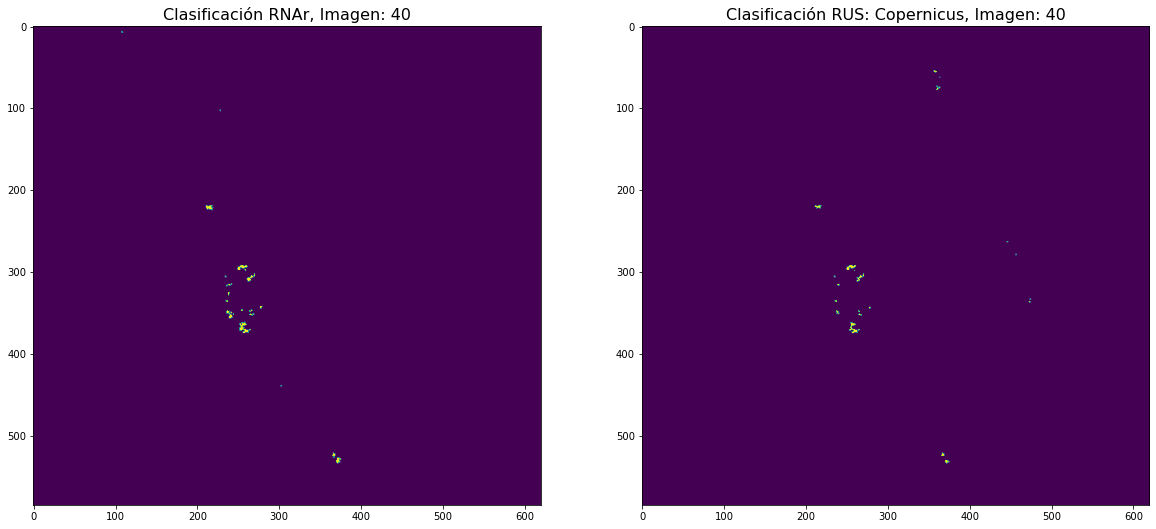

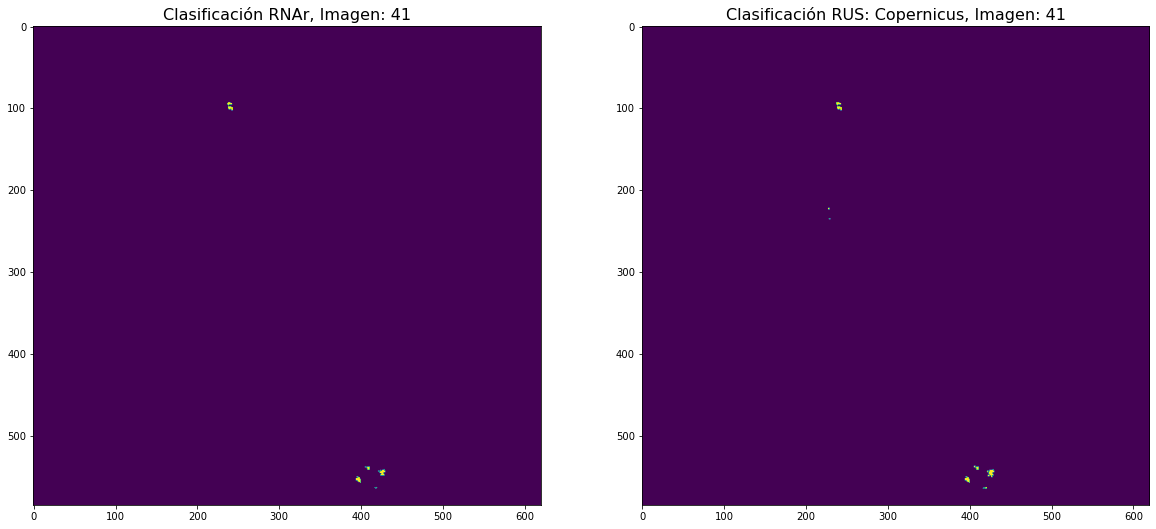

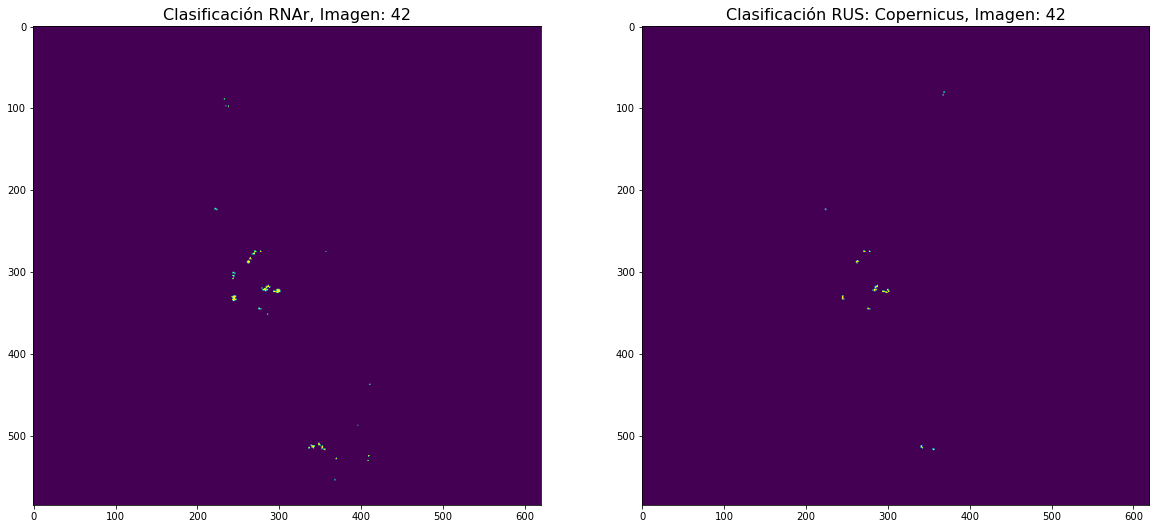

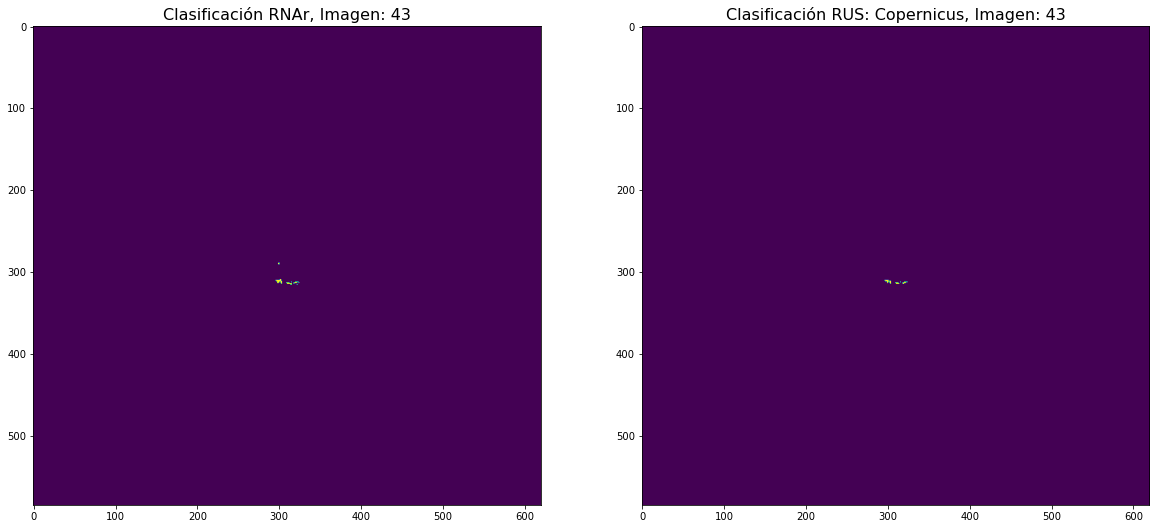

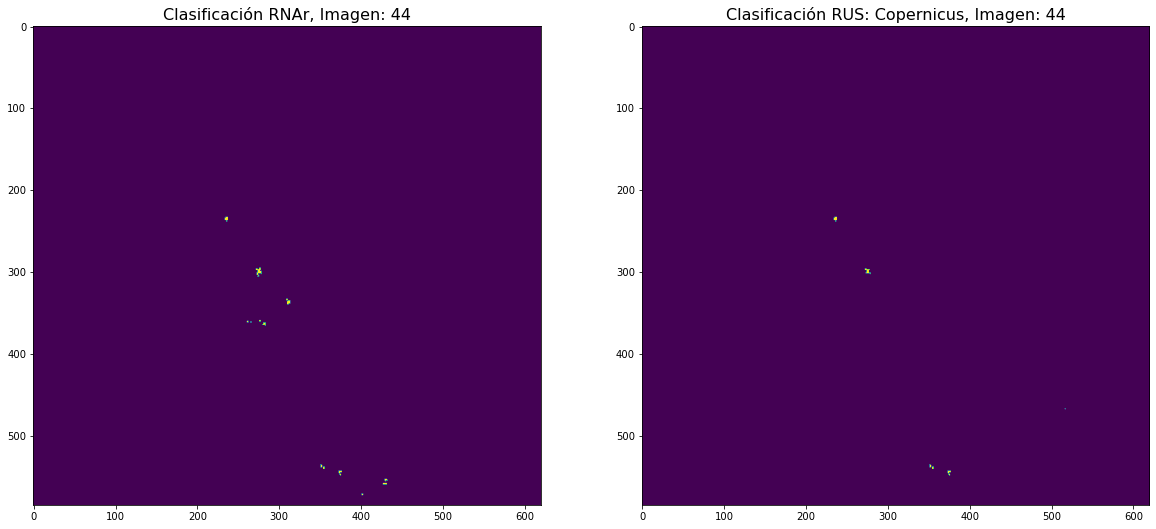

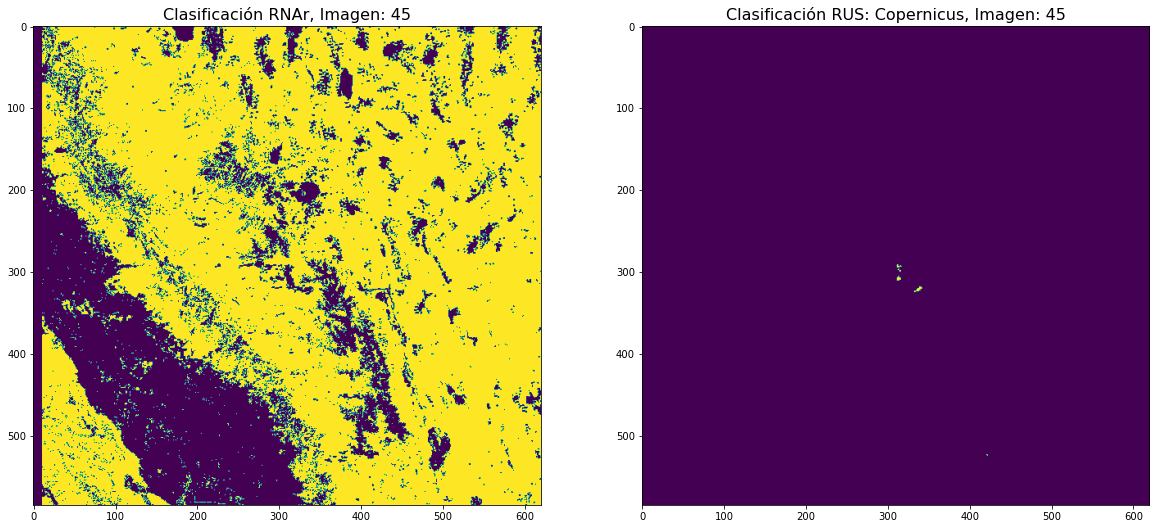

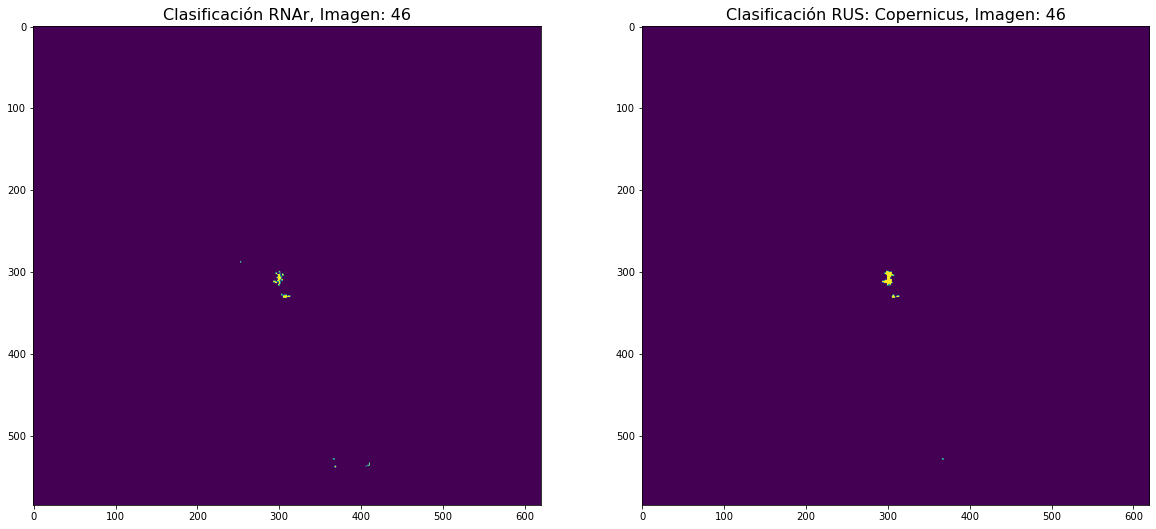

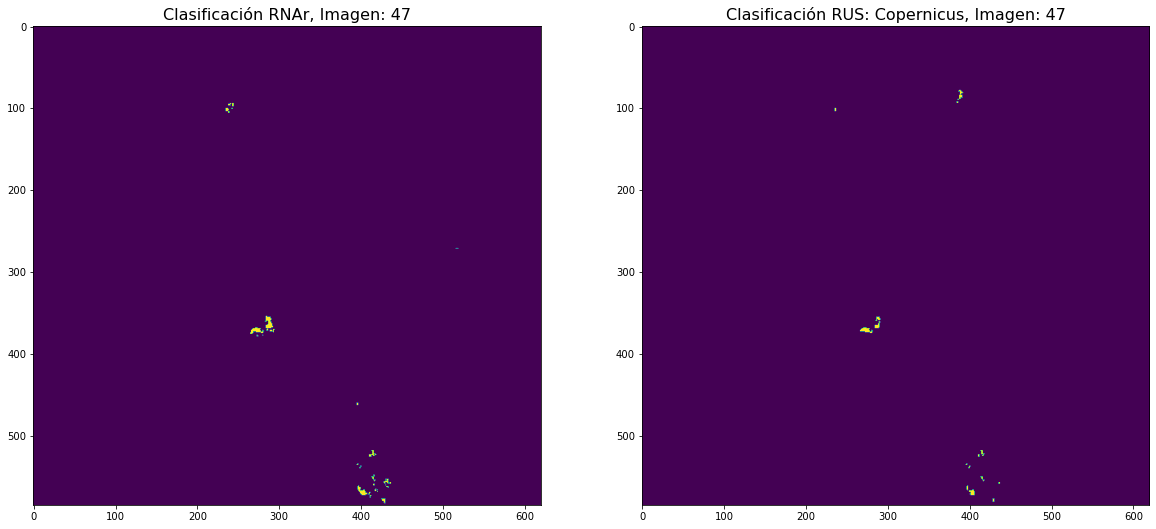

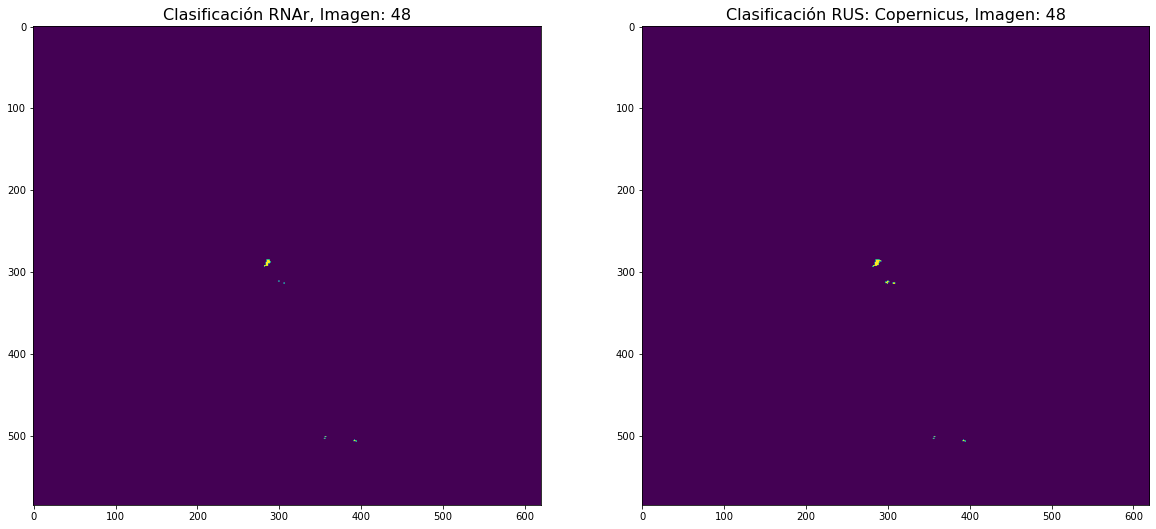

In [48]:
y_test = y_test.reshape(49, 362700)
for img_n in range(len(predictions)):
    pred_raster = predictions[img_n].reshape(585, 620)
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].imshow(pred_raster)
    ax[0].grid(False)
    ax[0].set_title(f'Clasificación RNAr, Imagen: {img_n}', fontsize=16)
    
    ax[1].imshow(y_test[img_n].reshape(585, 620))
    ax[1].grid(False)
    ax[1].set_title(f'Clasificación RUS: Copernicus, Imagen: {img_n}', fontsize=16)
    
    plt.show()

## Final ordered classifications
Since we know that our algorithm performs properly, we proceed to classify all images, in an orderly fashion (as originally ordered). This is made so all images can be ordered time-wisely in order to create a time-series of the fires.

In [56]:
predictions_all = []
for i in range(122):
    test_img = nstack_x[i,:,:].T
    pred_i = model.predict_classes(test_img)
    predictions_all.append(pred_i)
len(predictions_all)

122

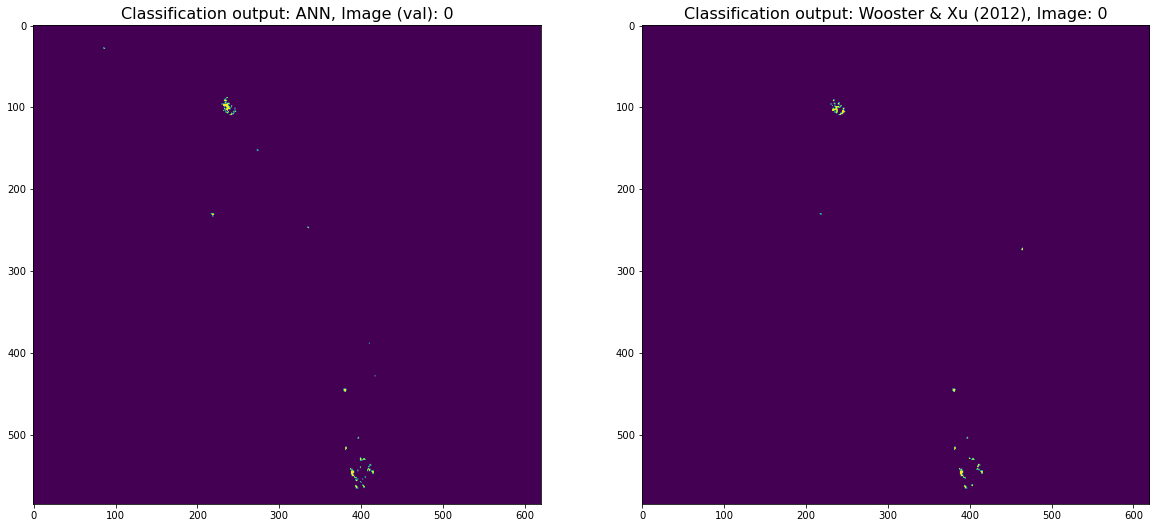

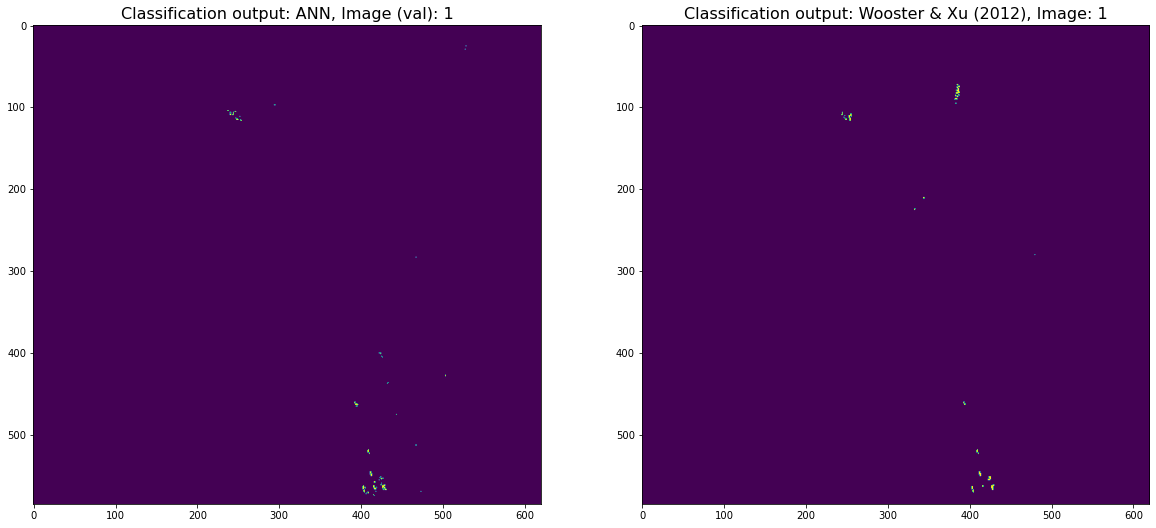

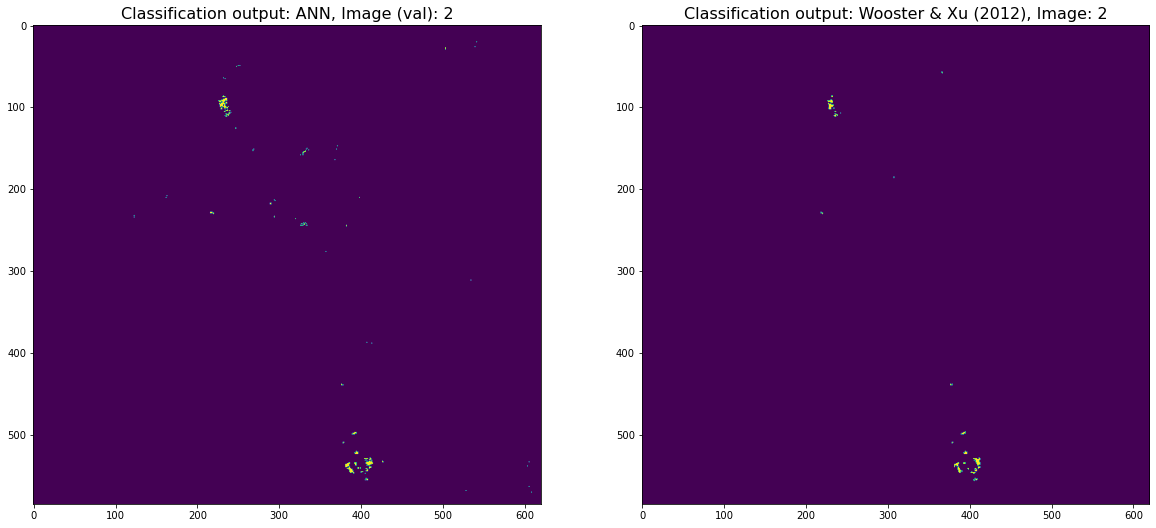

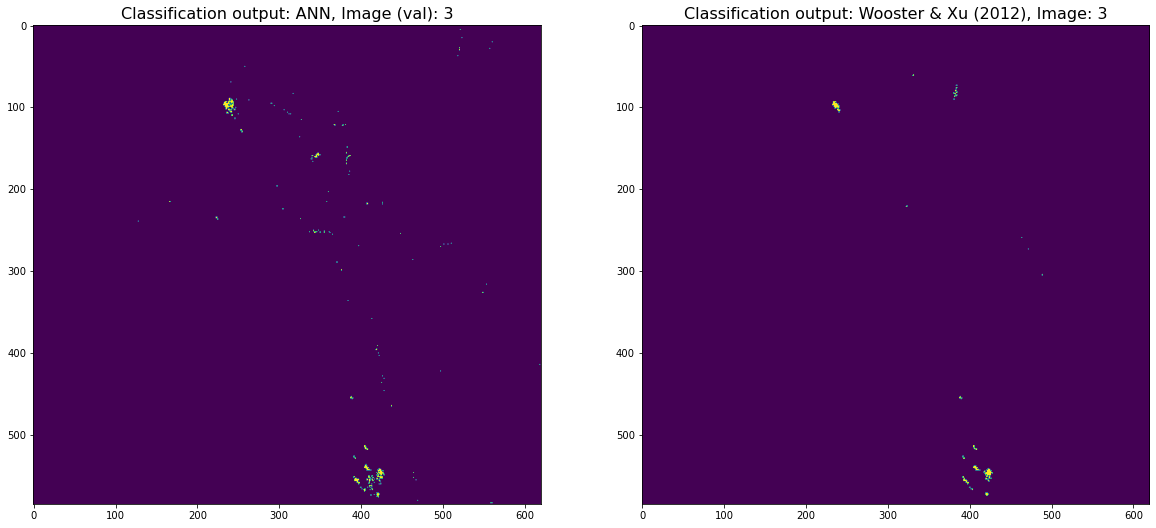

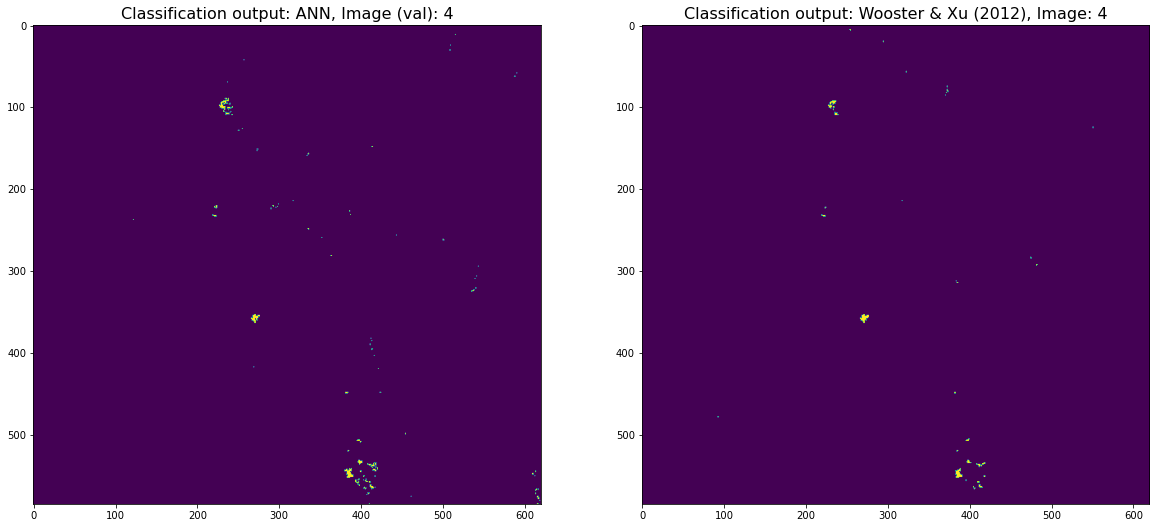

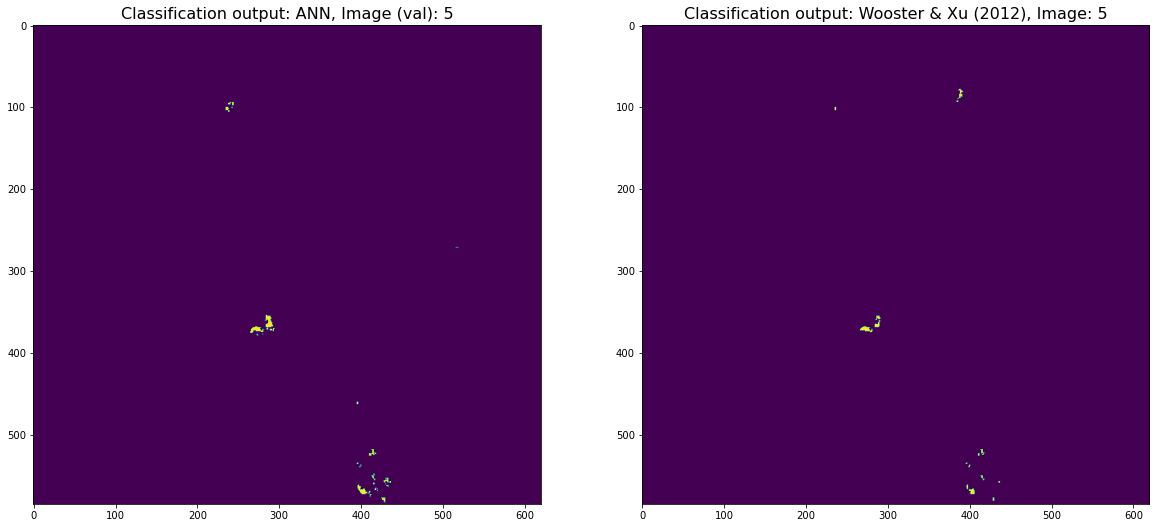

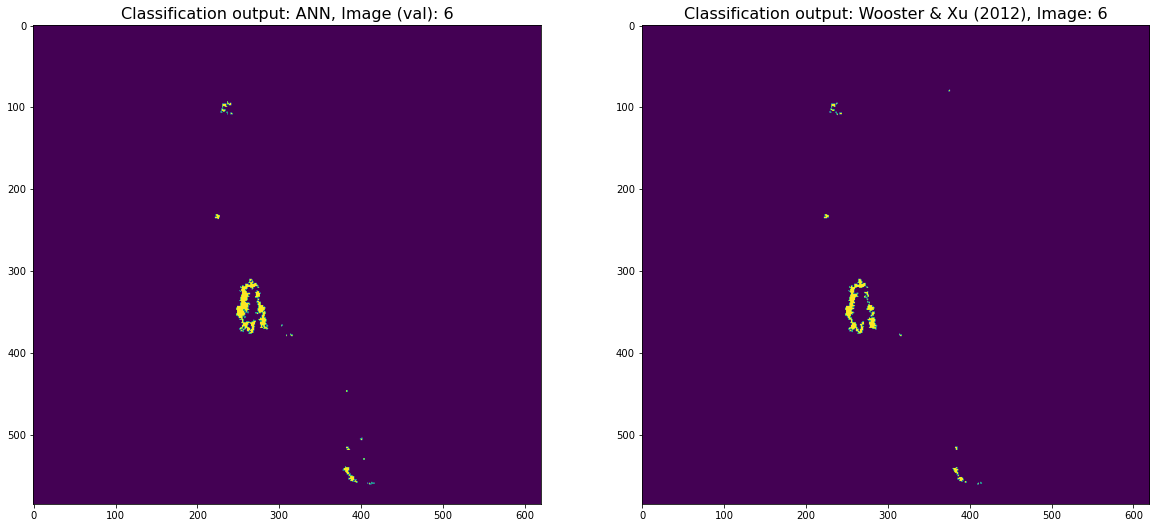

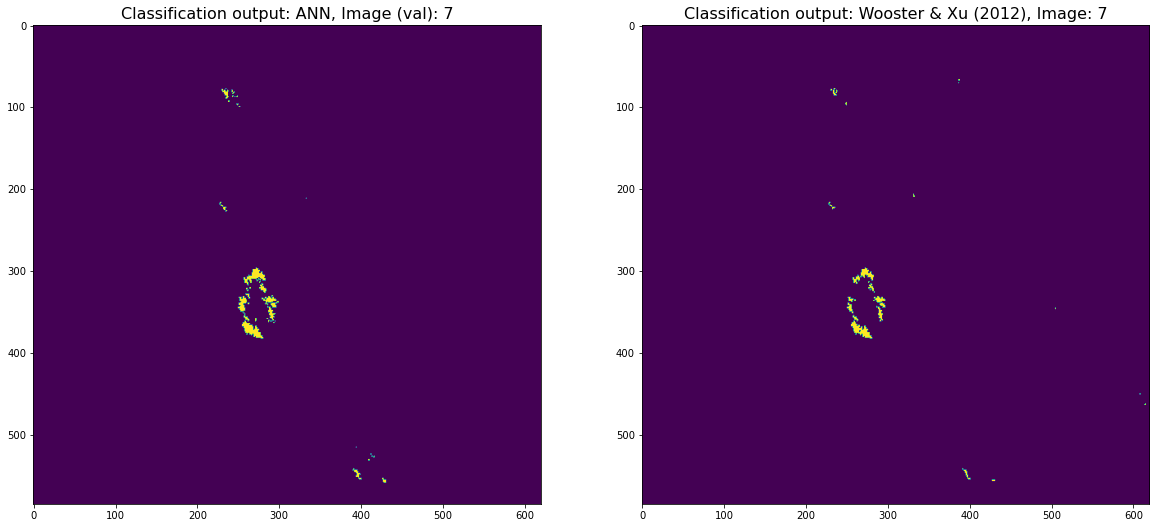

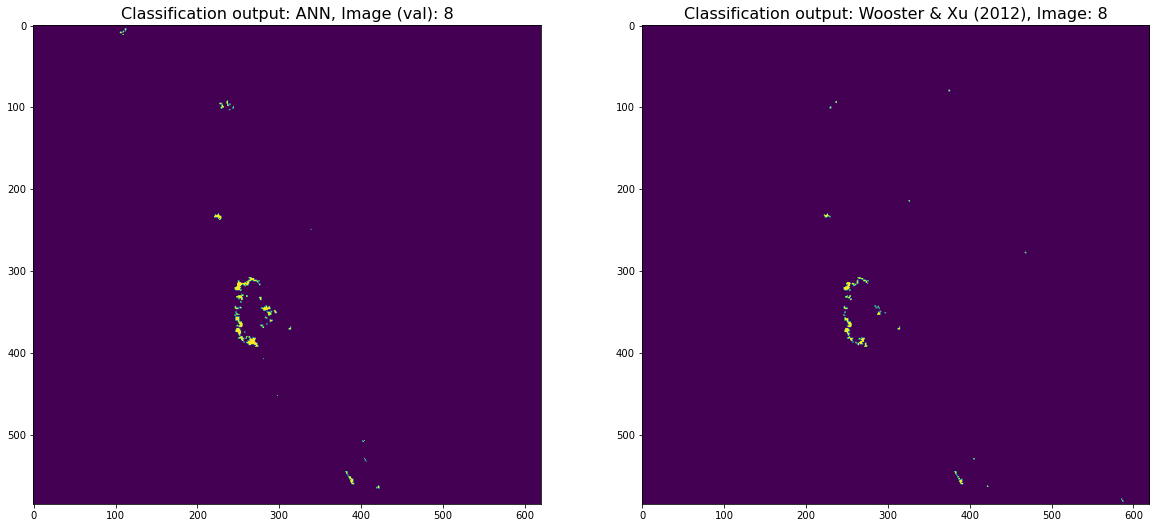

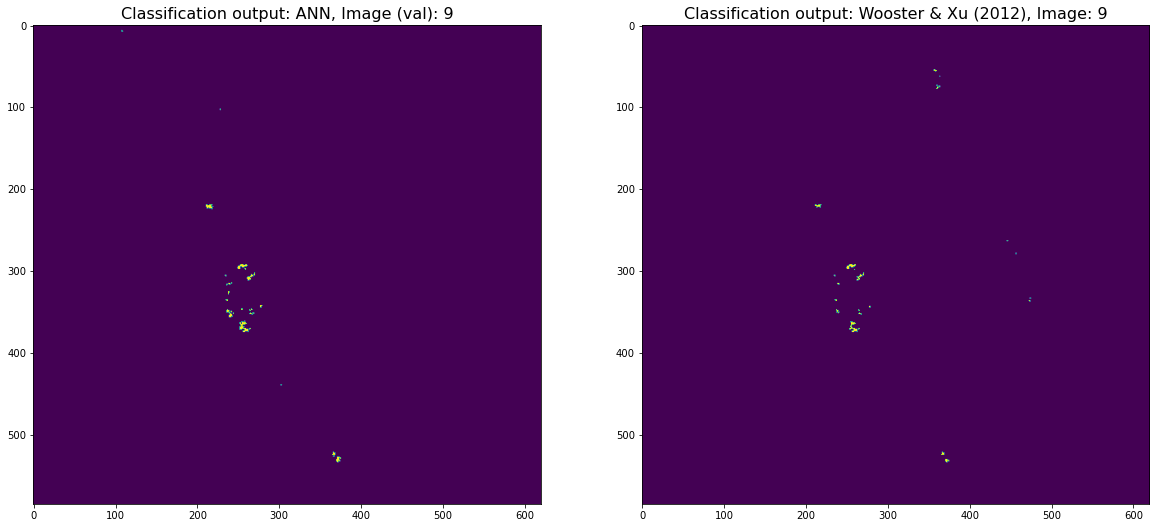

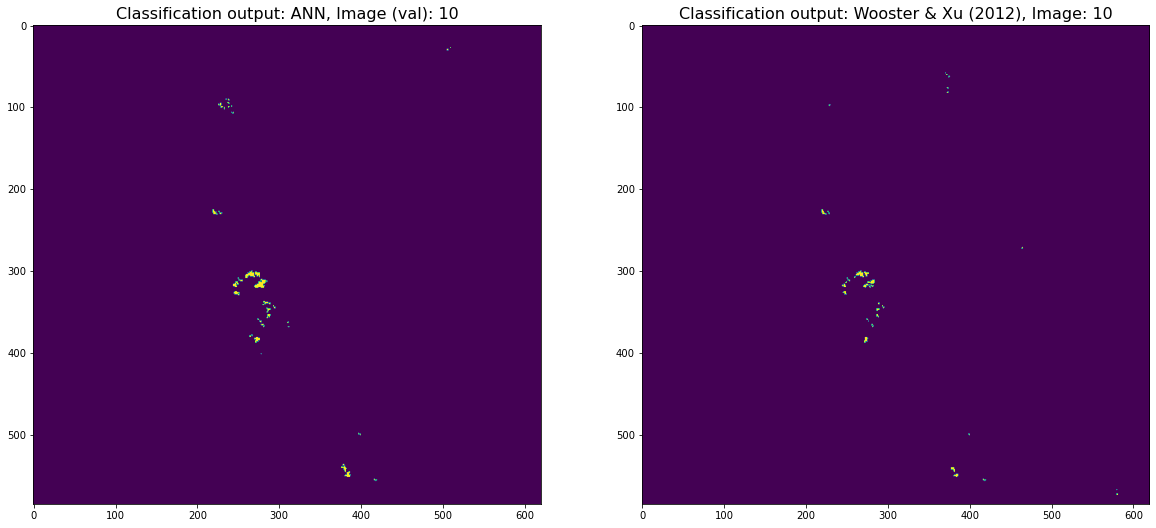

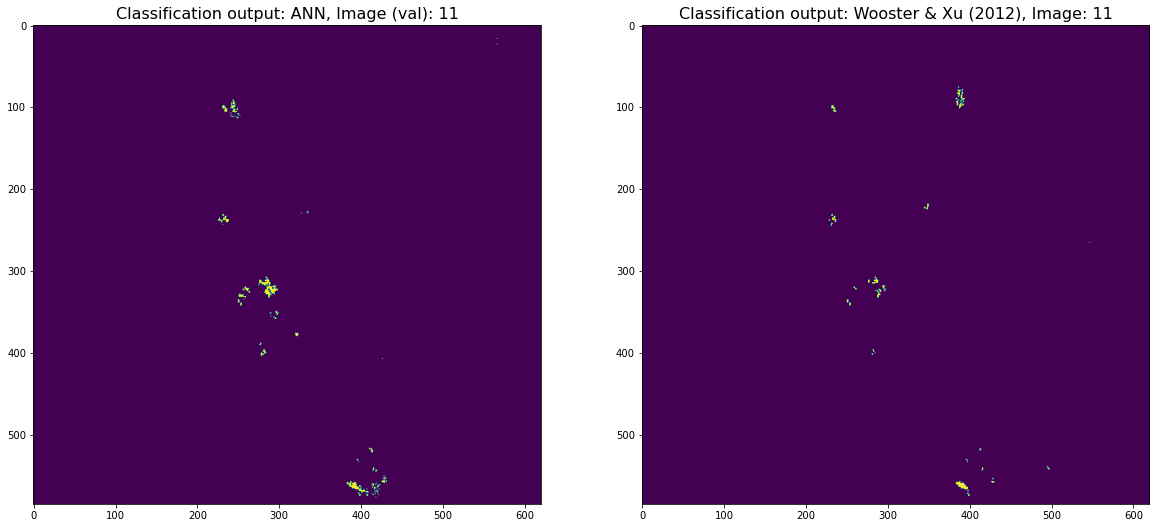

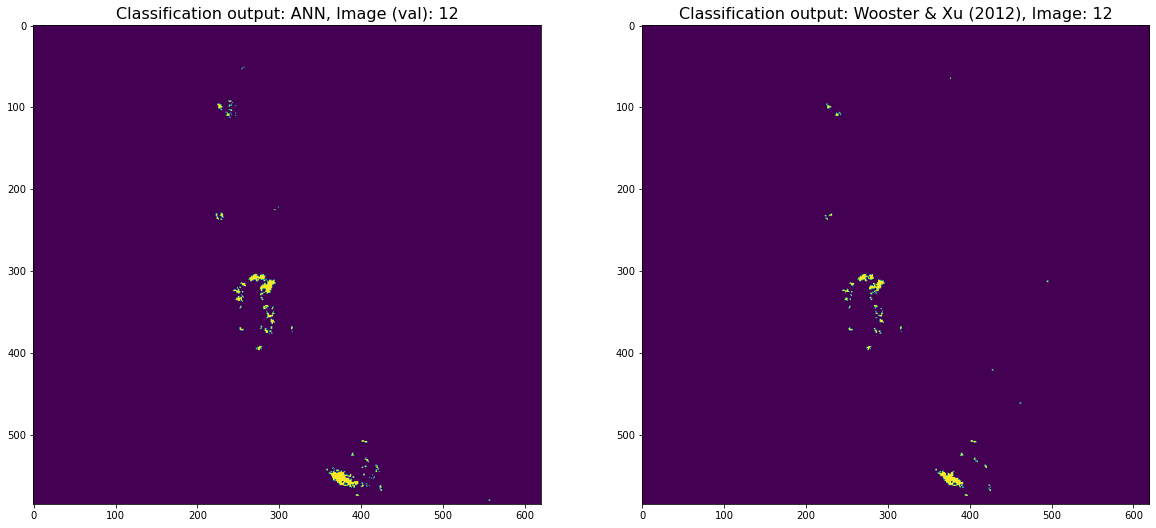

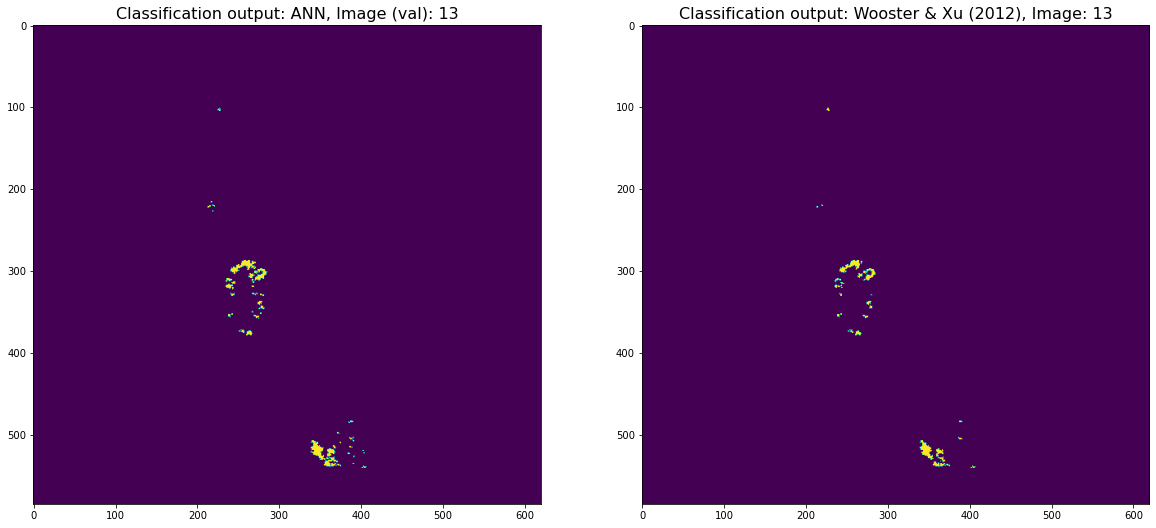

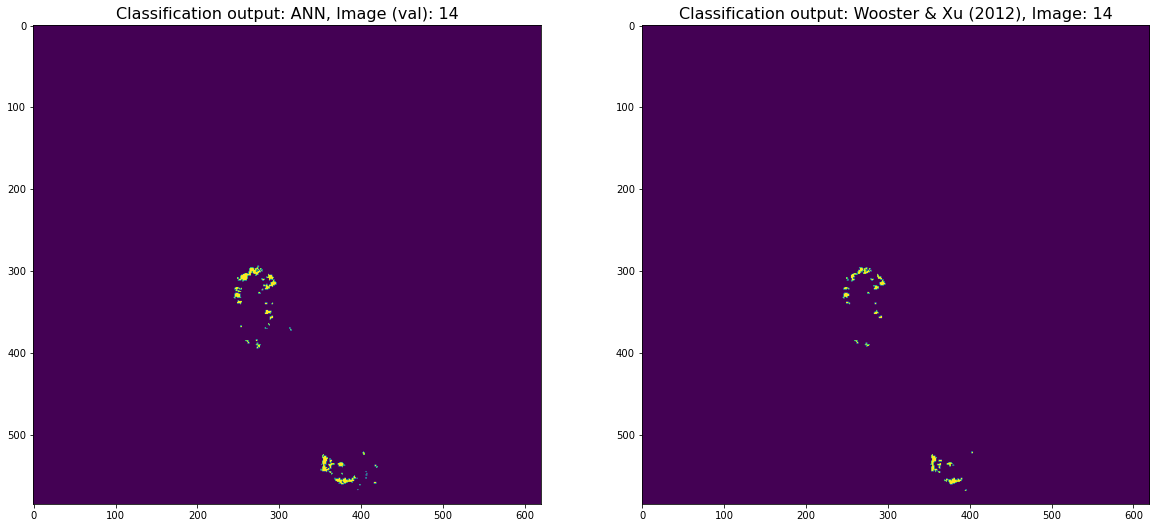

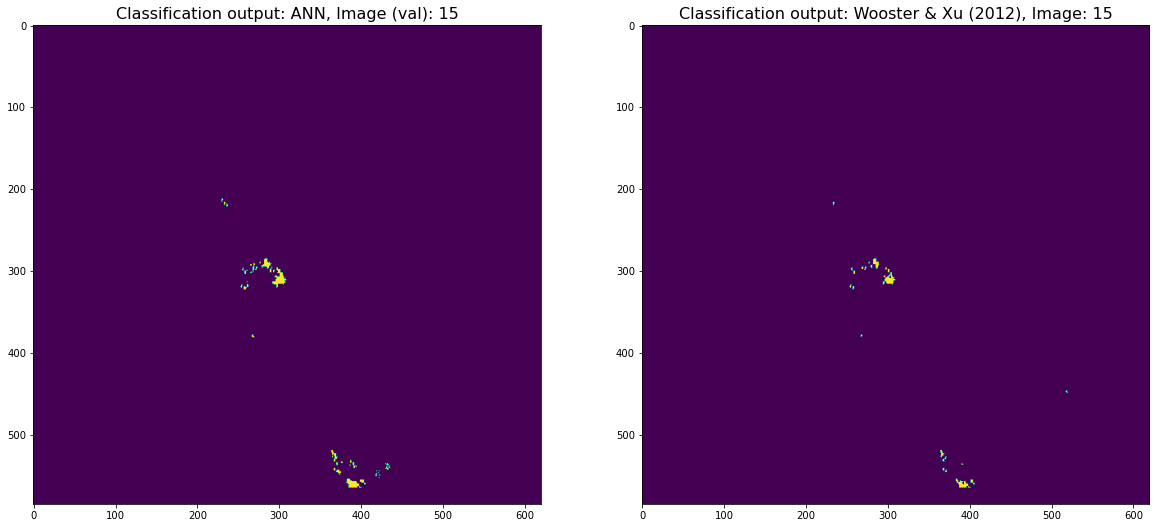

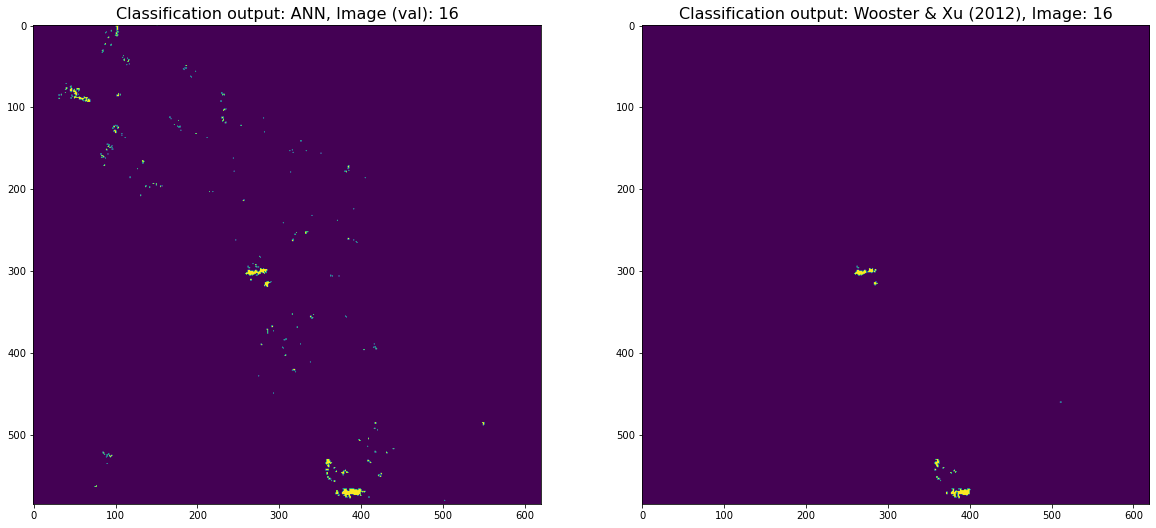

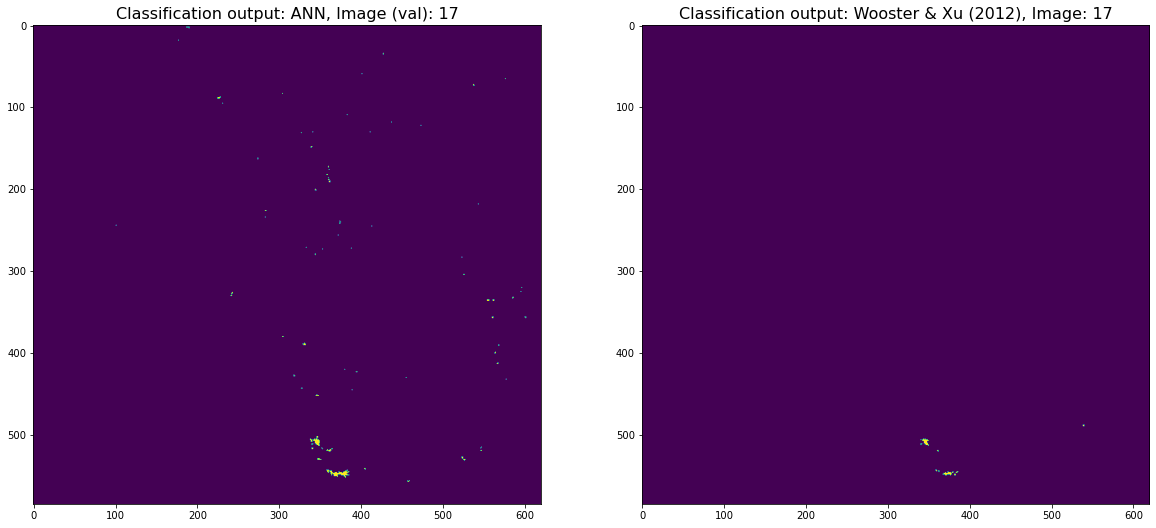

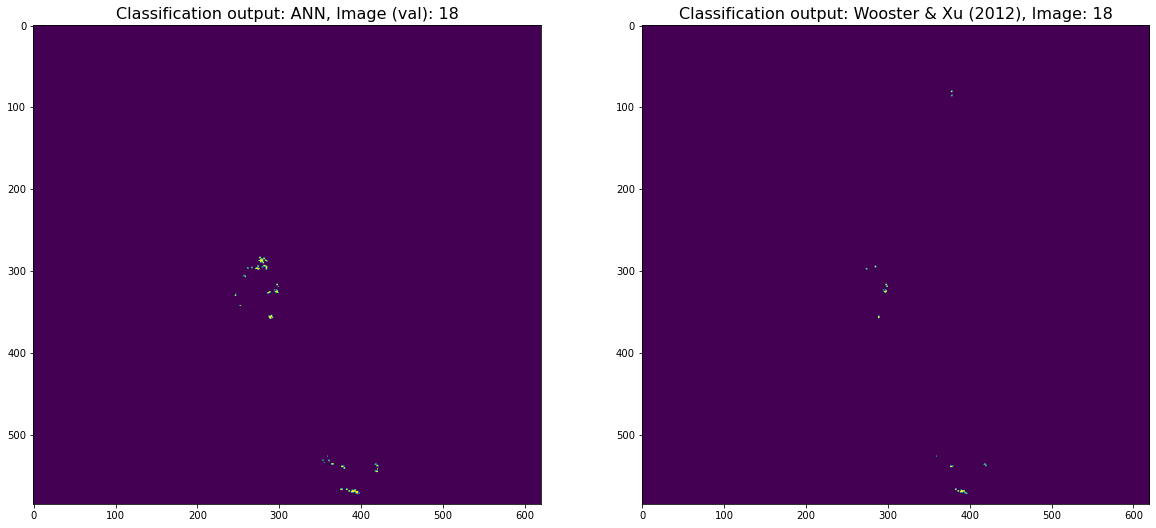

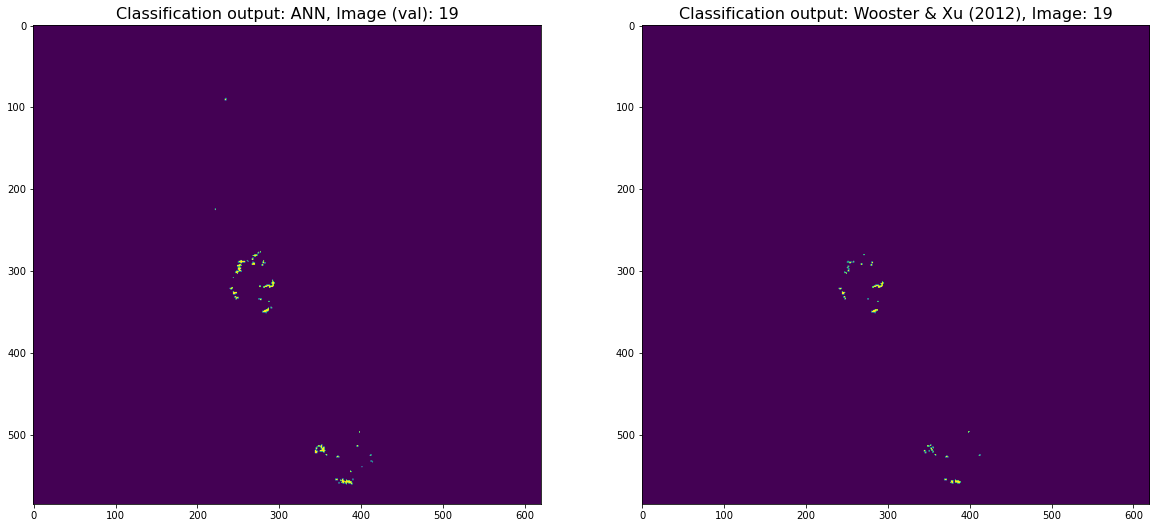

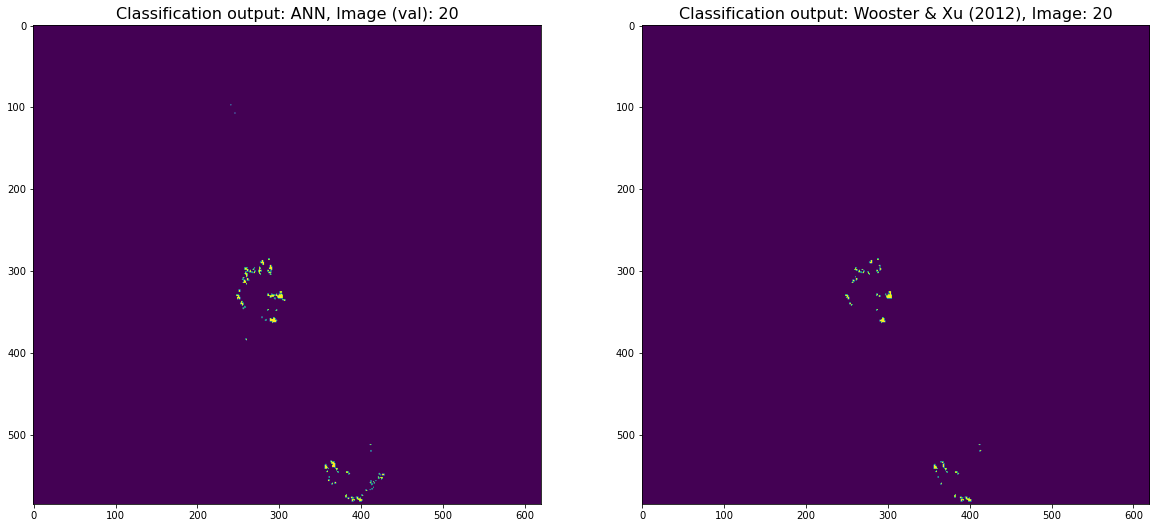

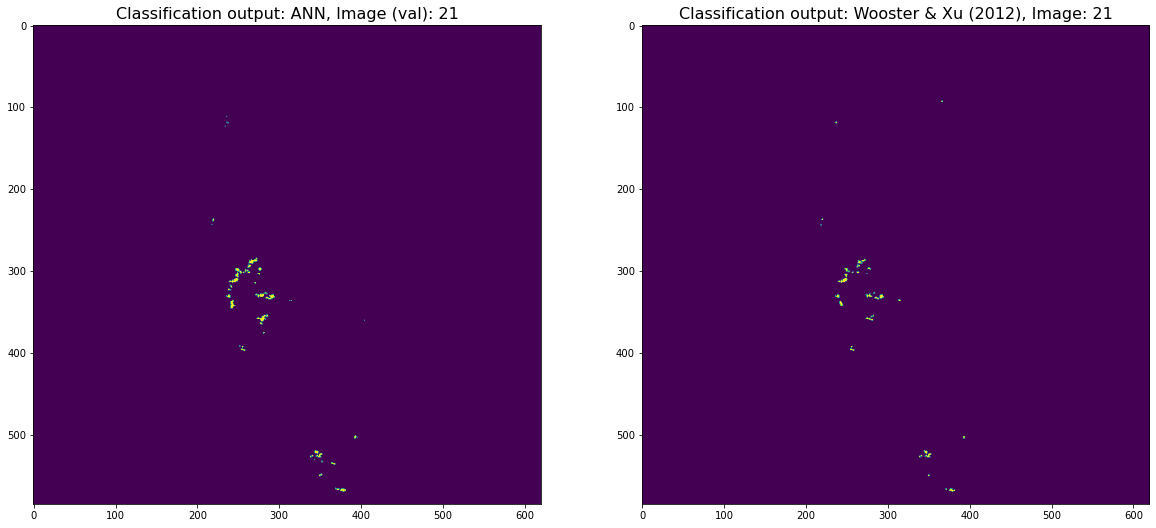

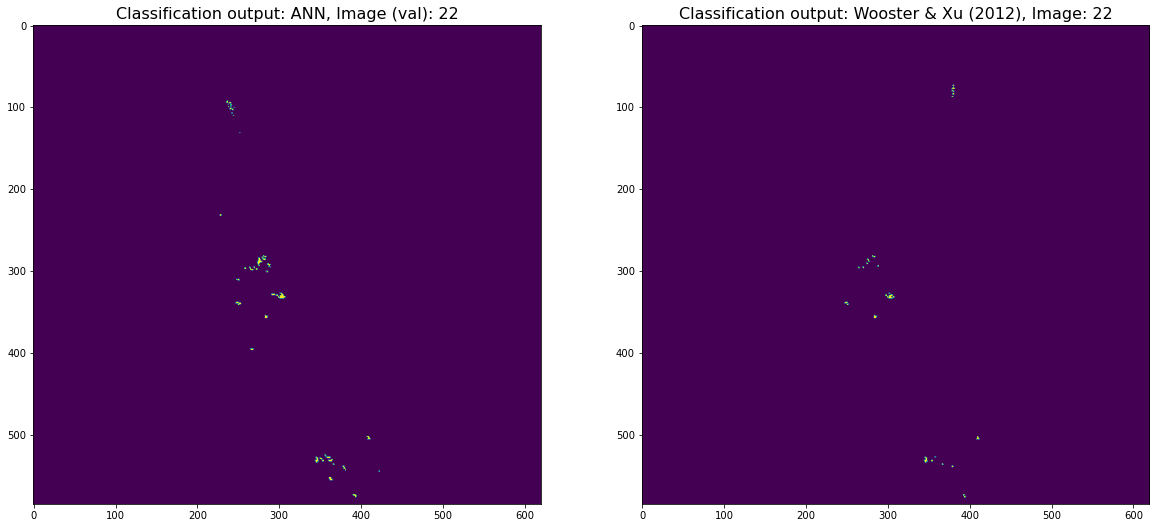

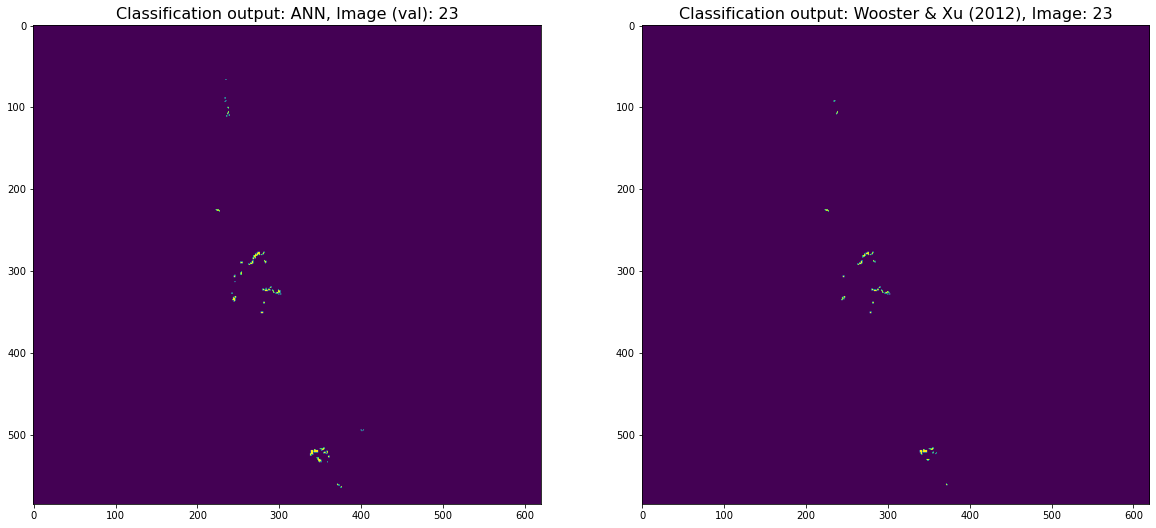

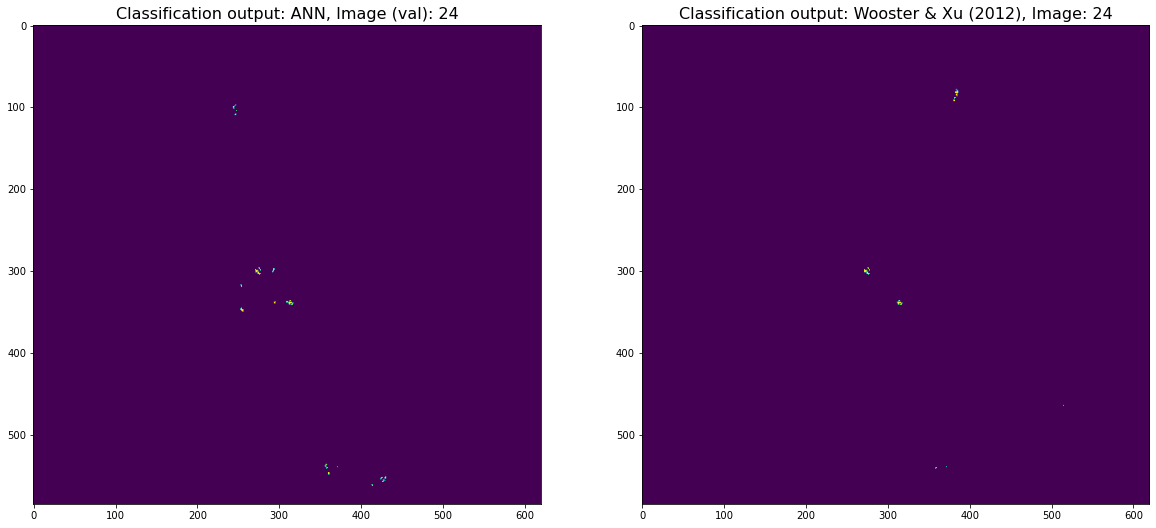

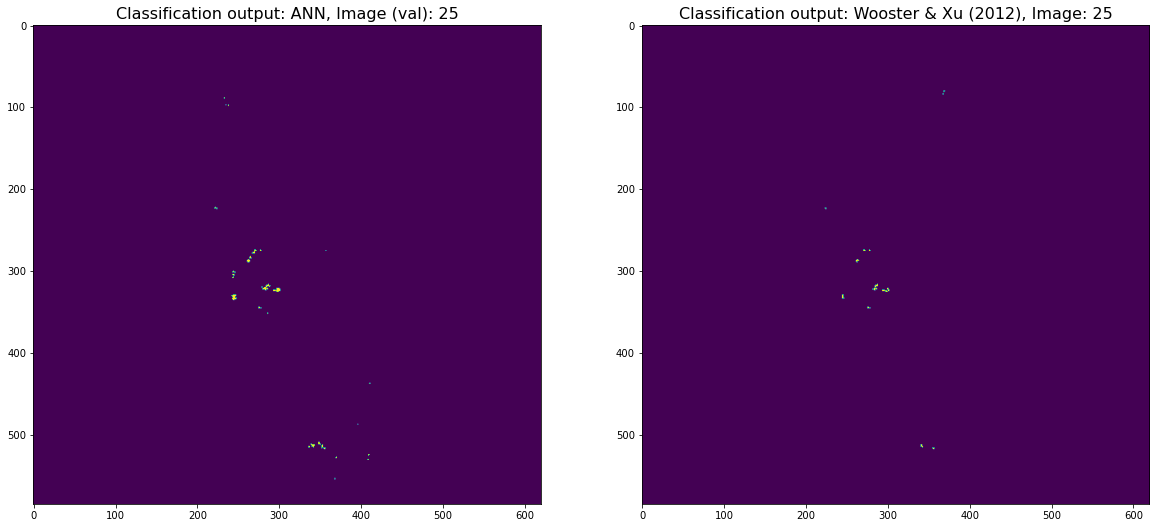

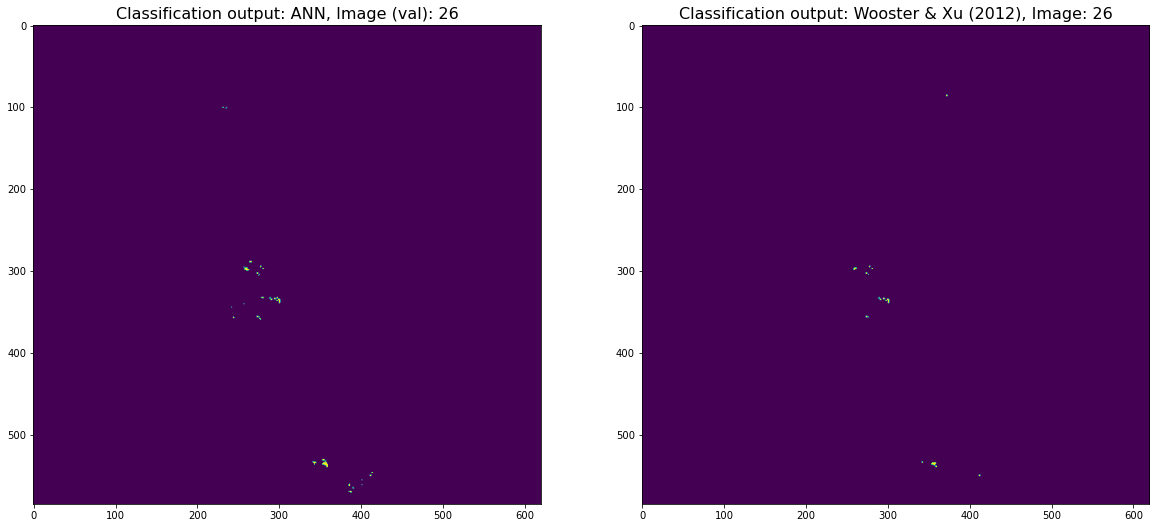

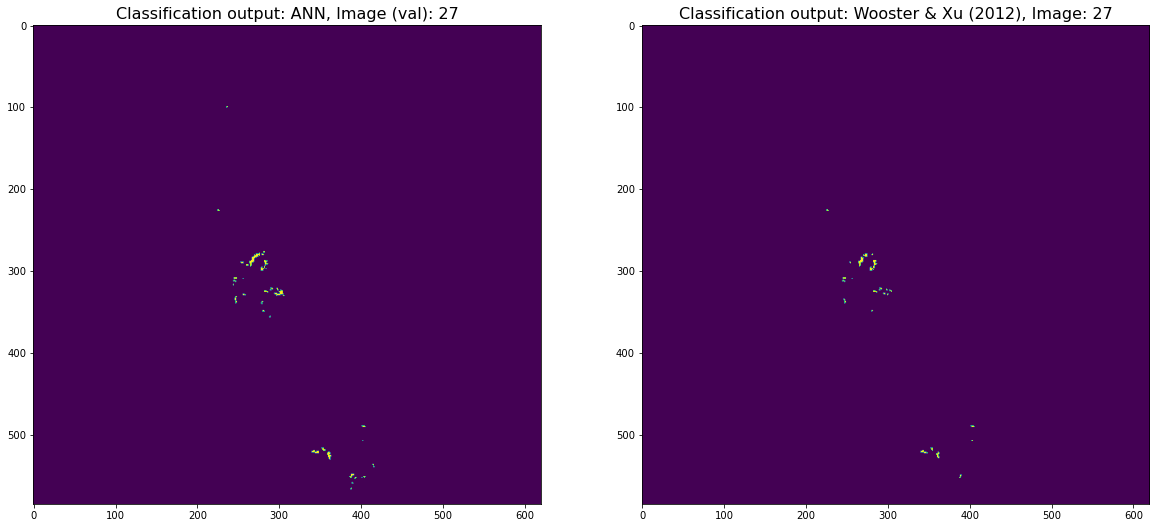

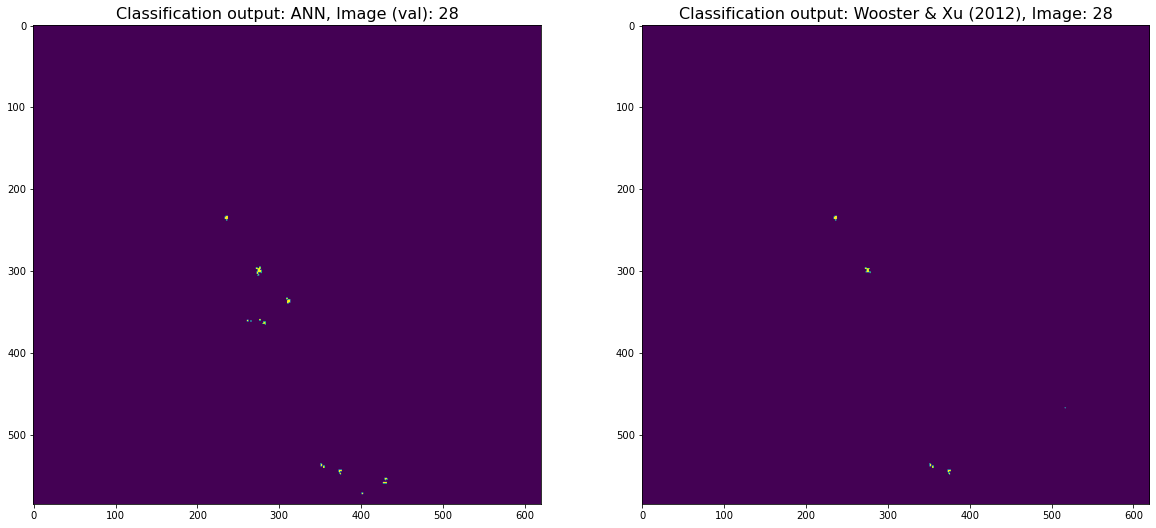

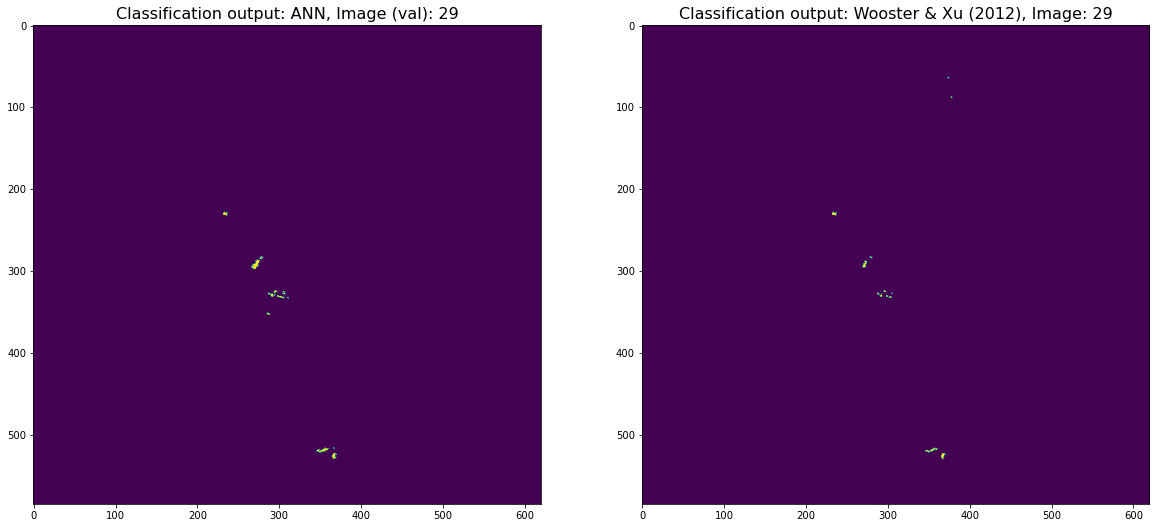

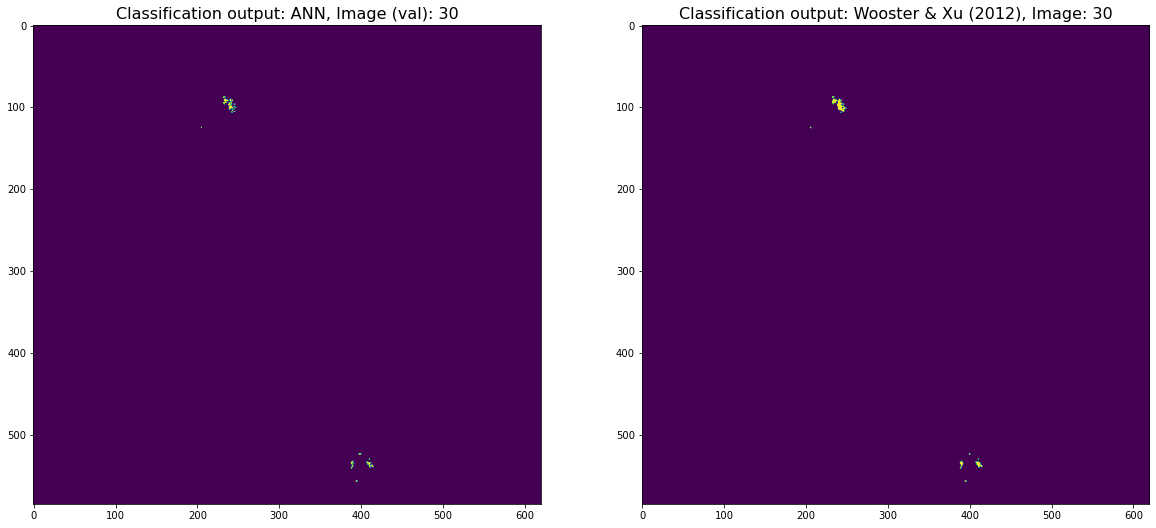

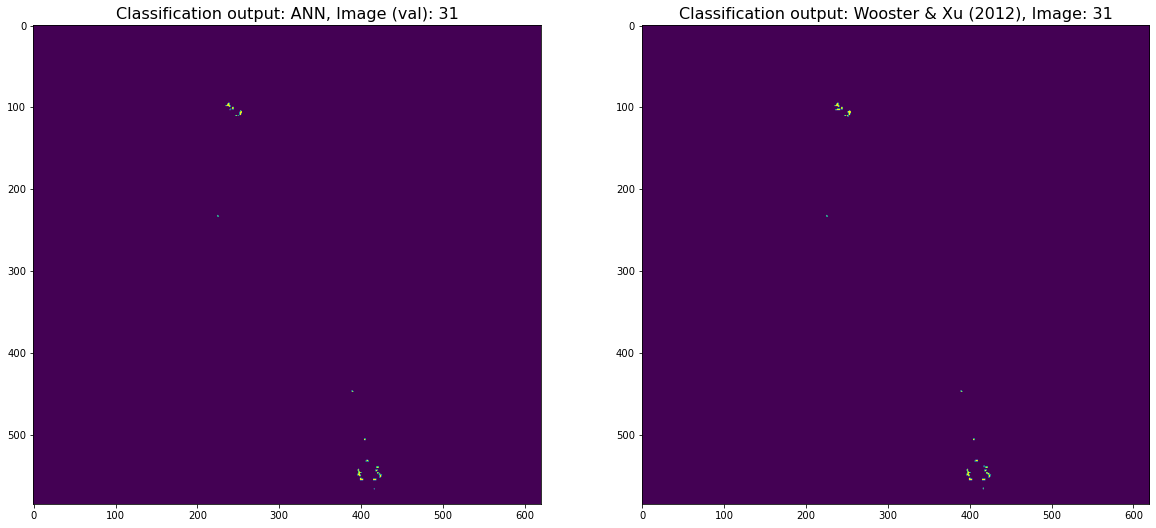

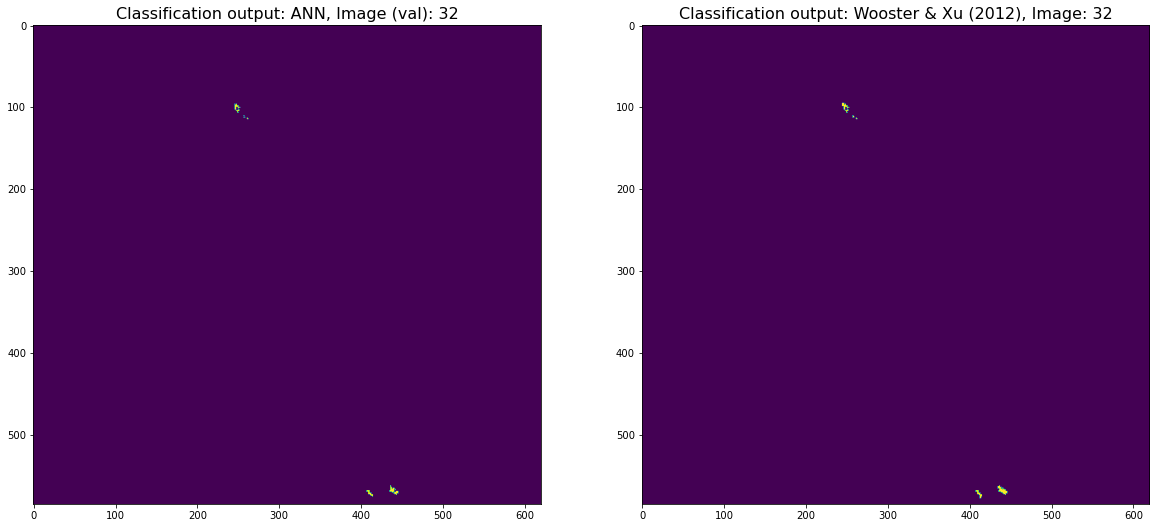

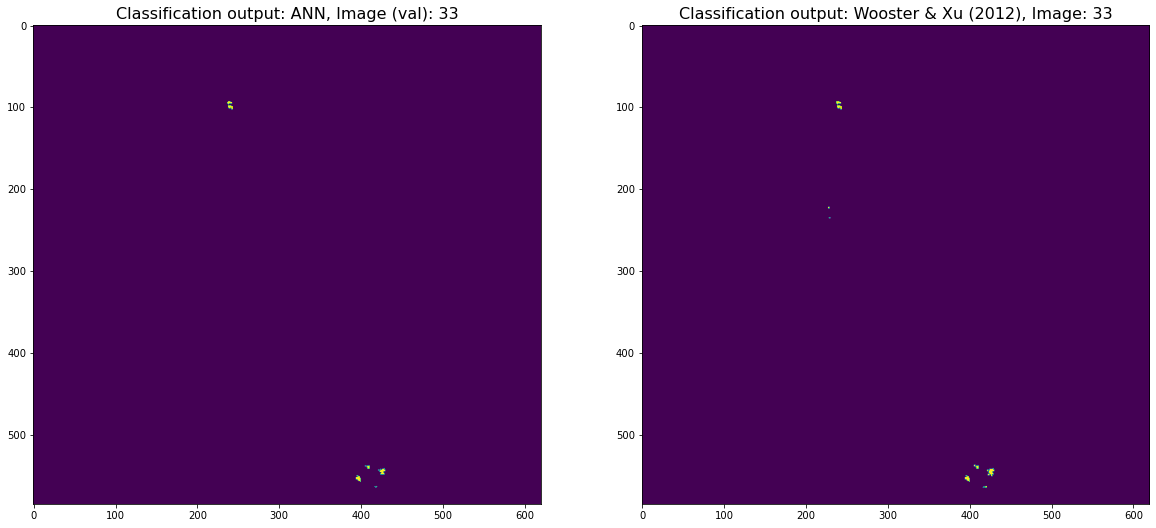

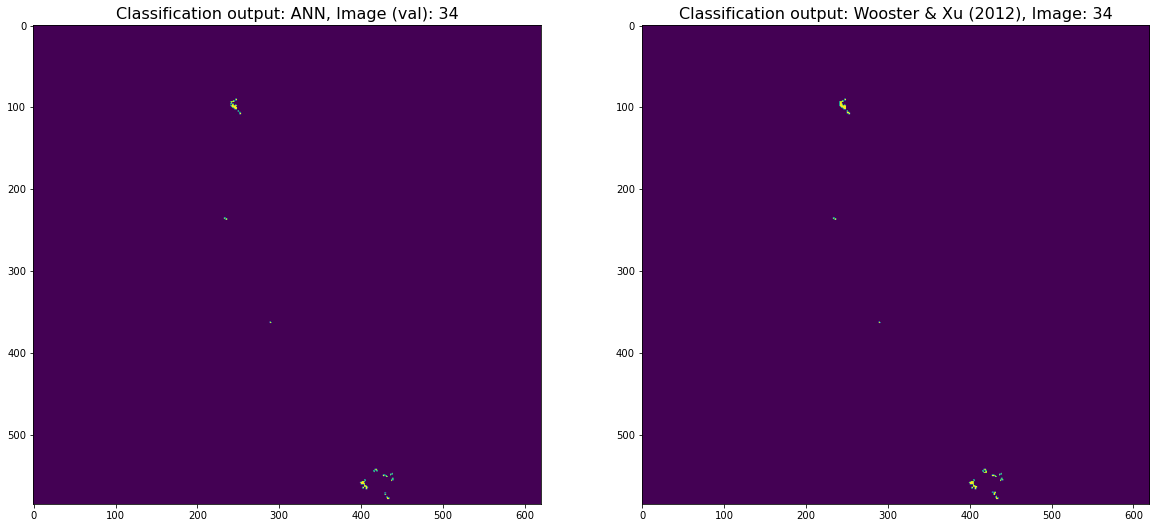

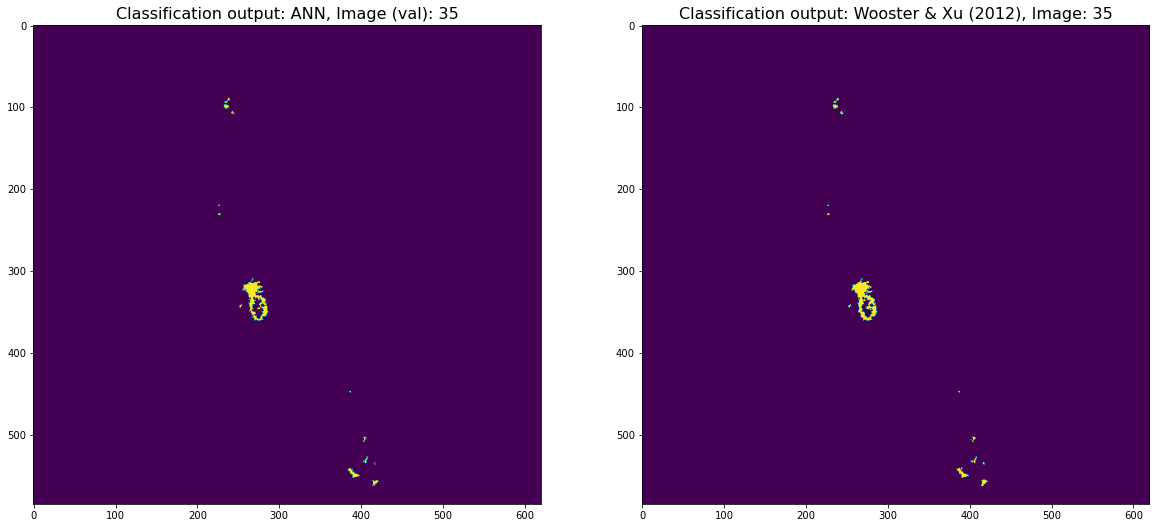

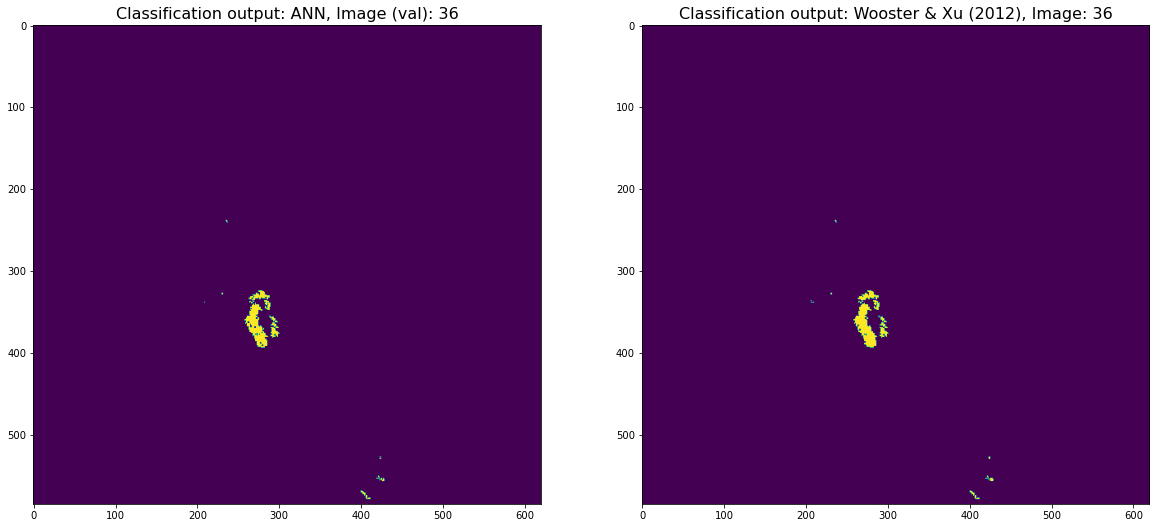

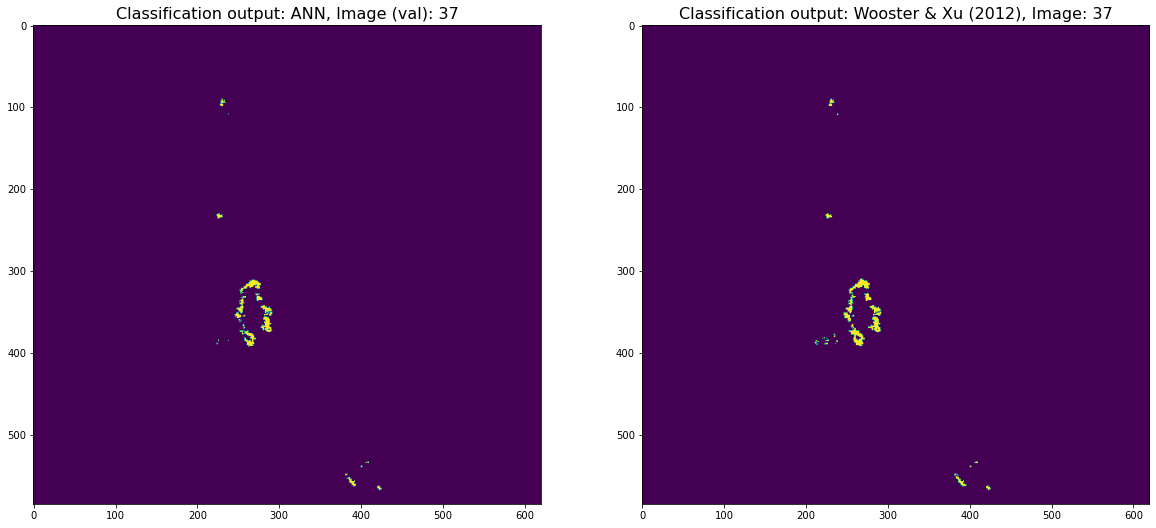

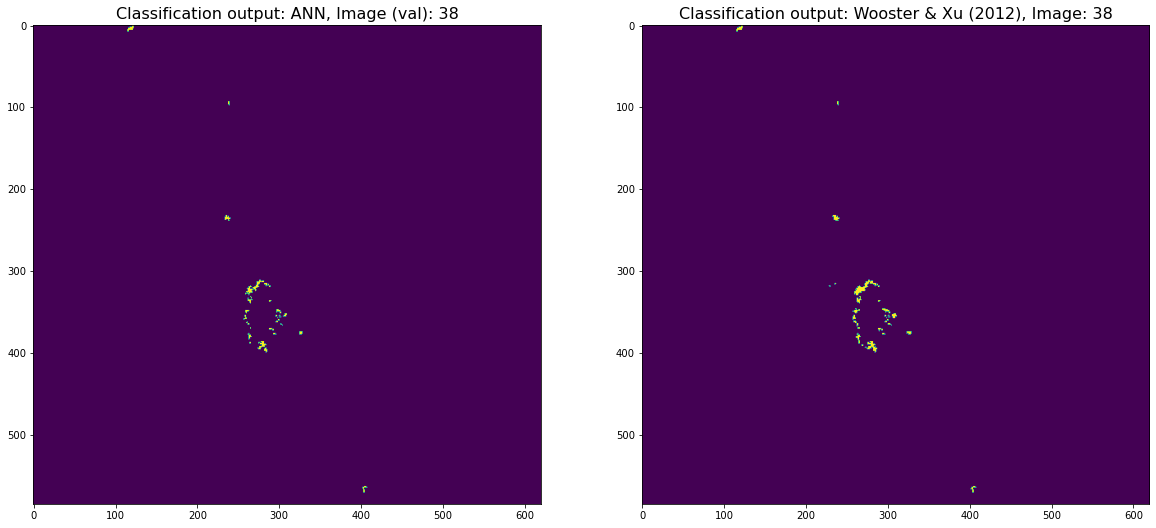

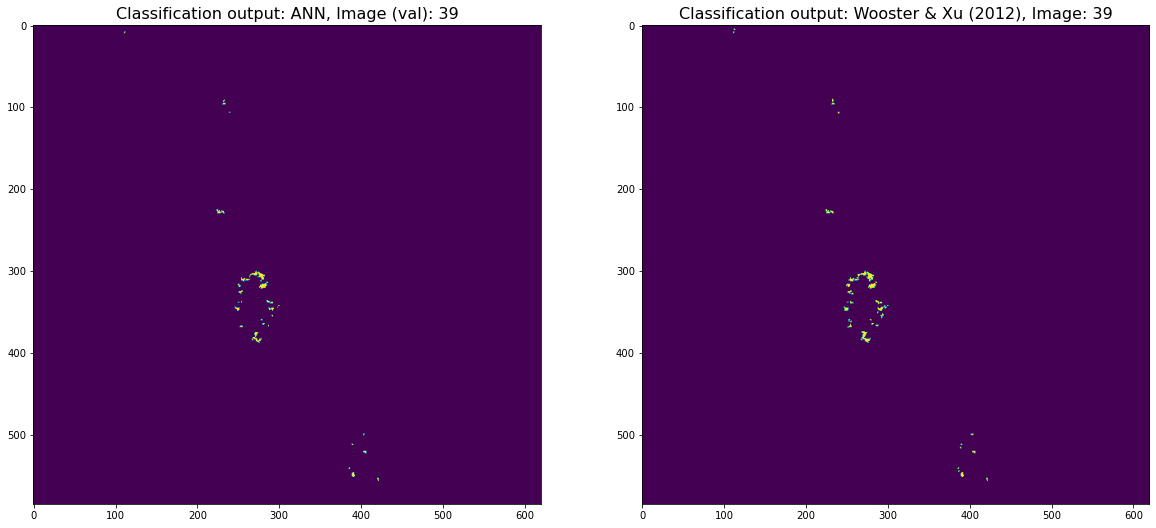

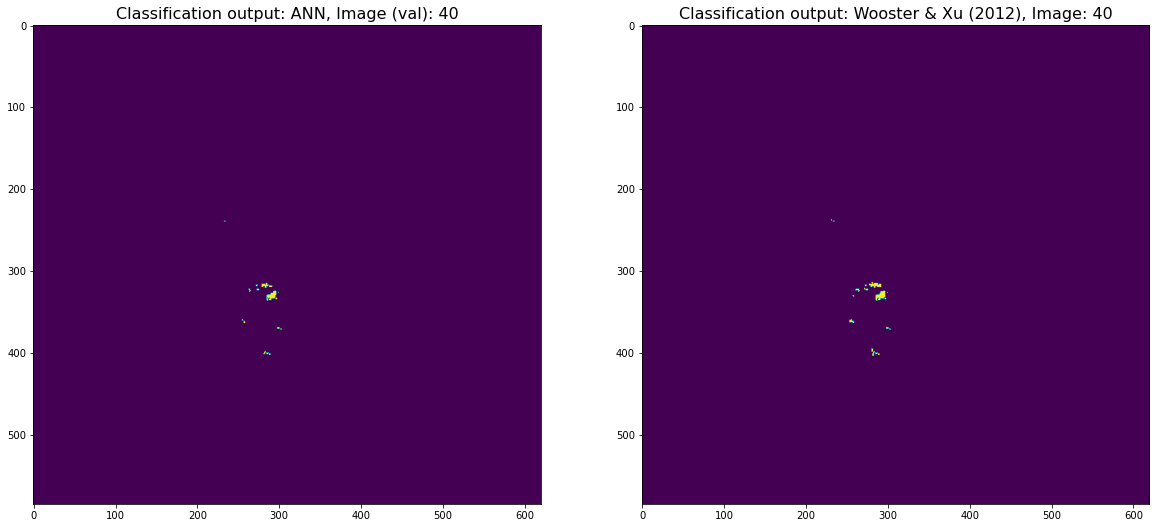

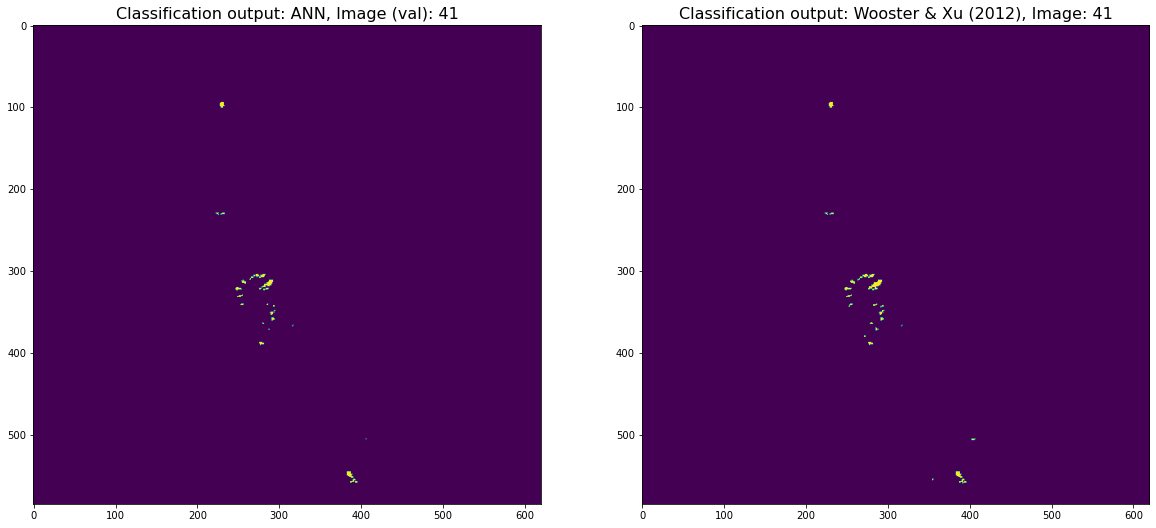

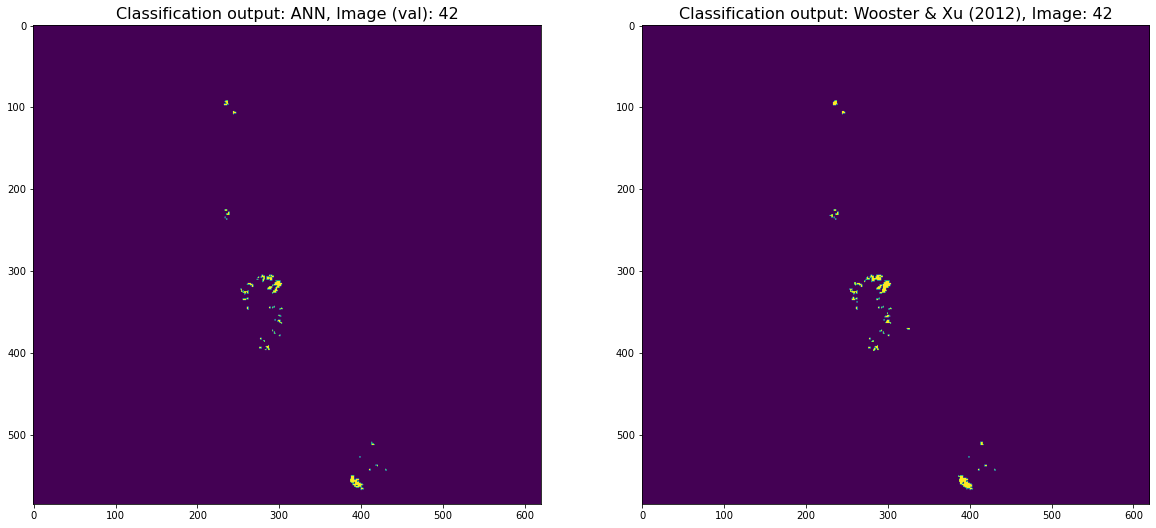

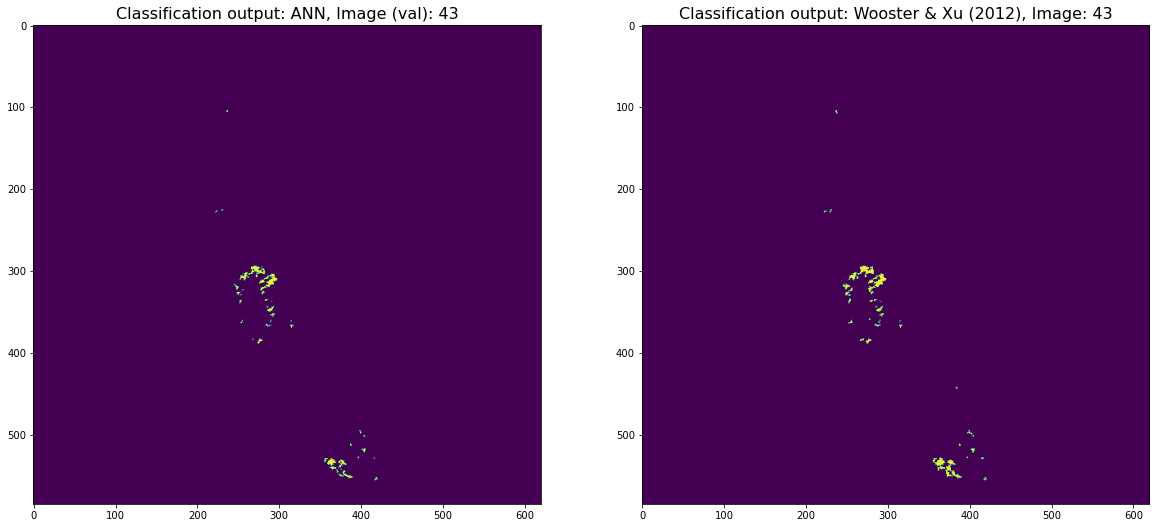

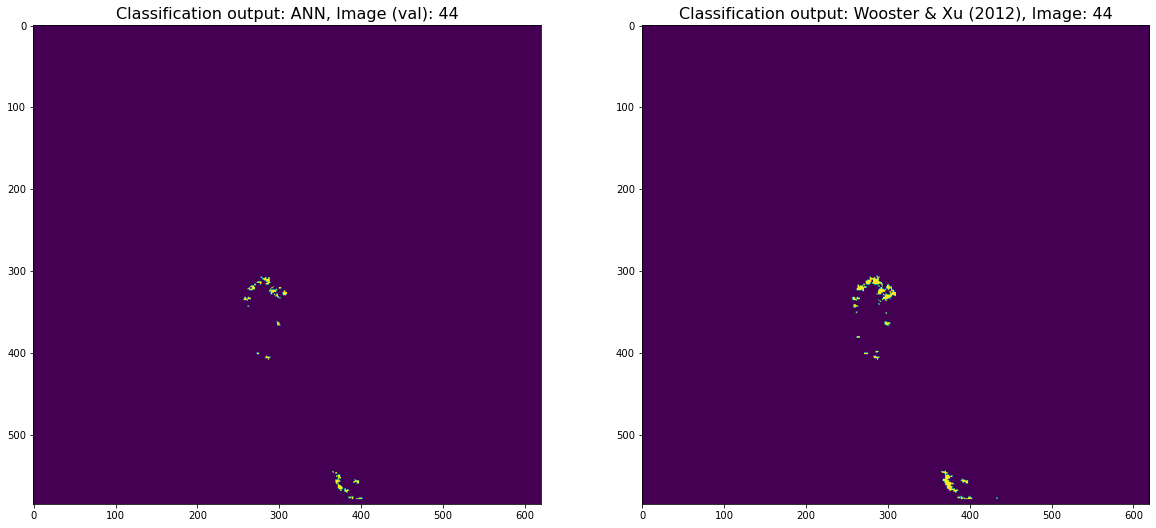

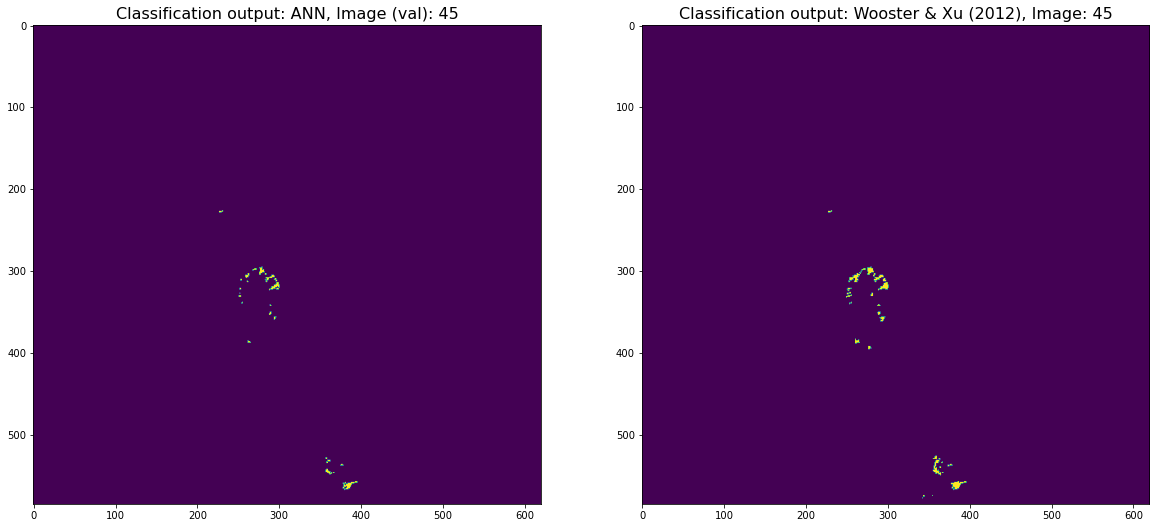

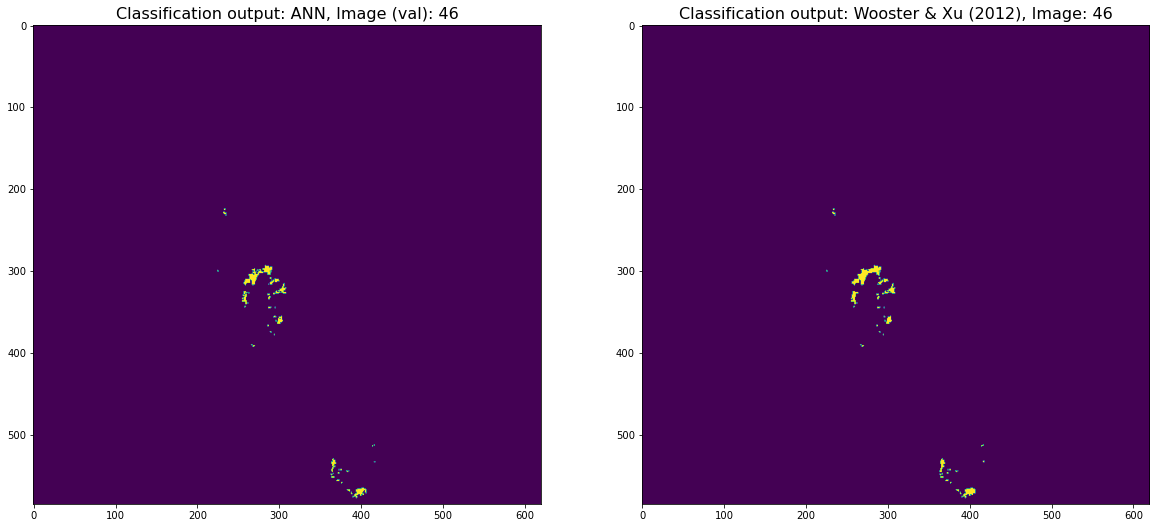

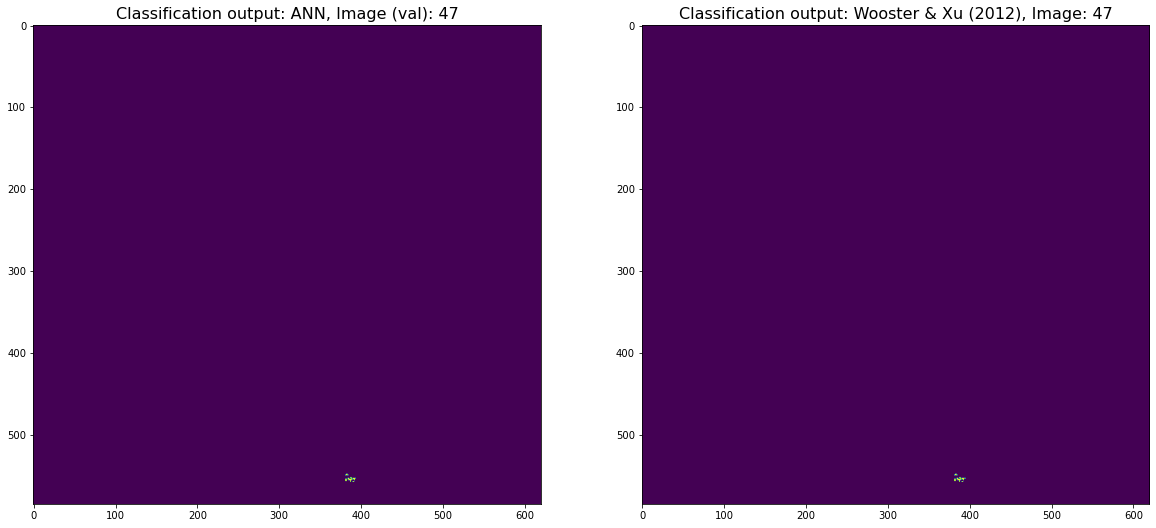

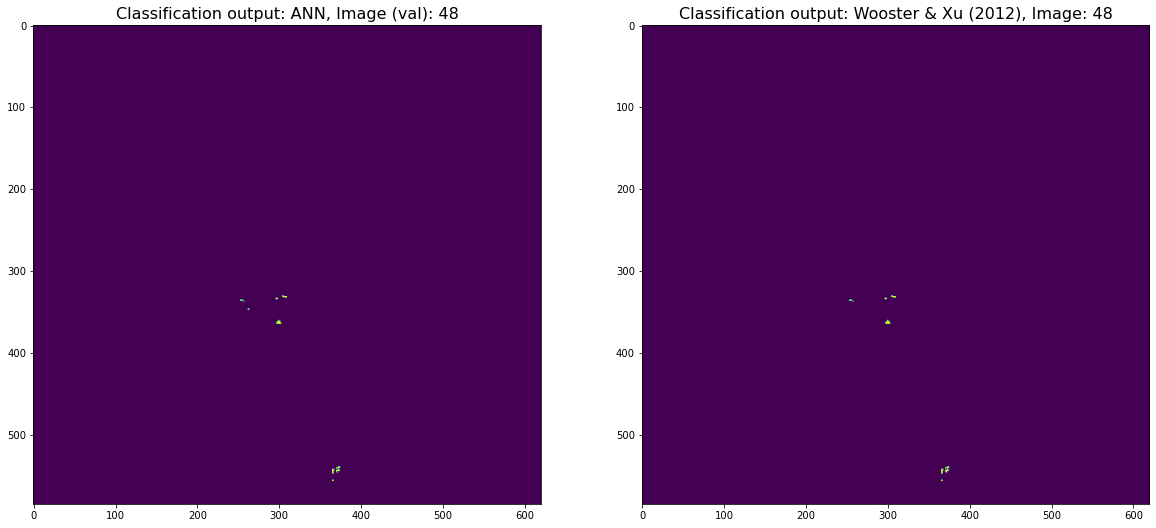

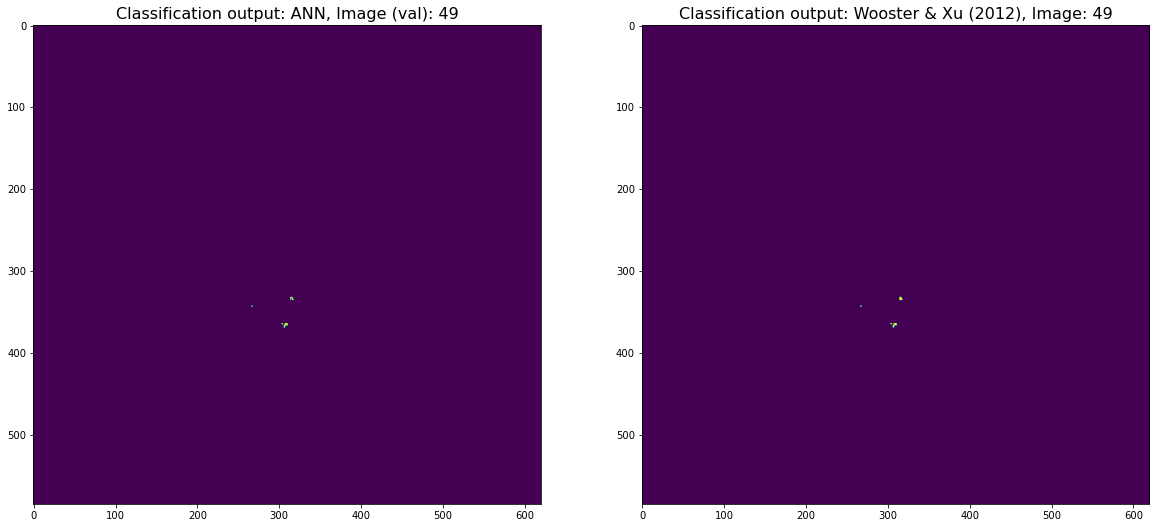

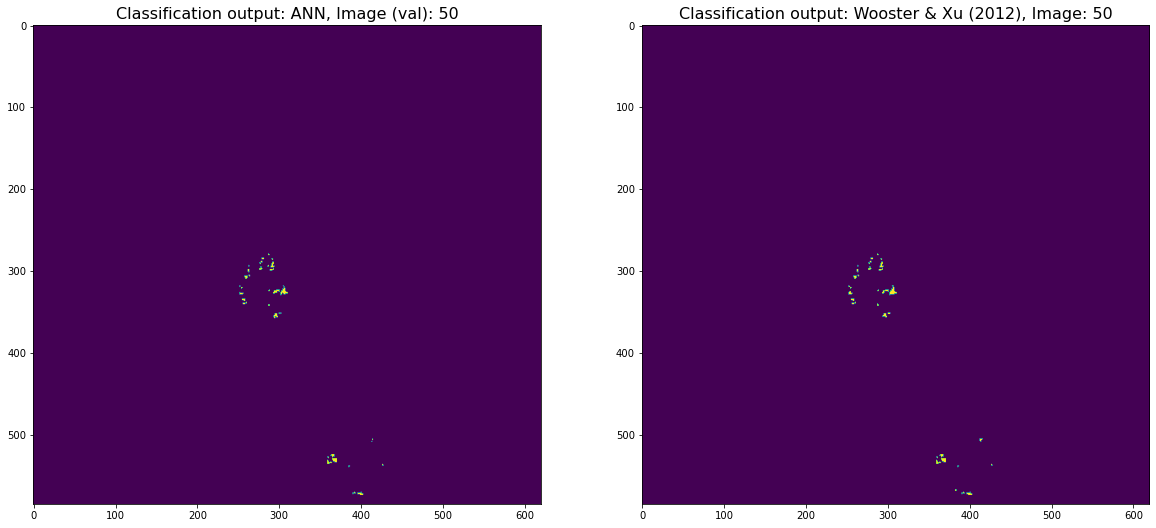

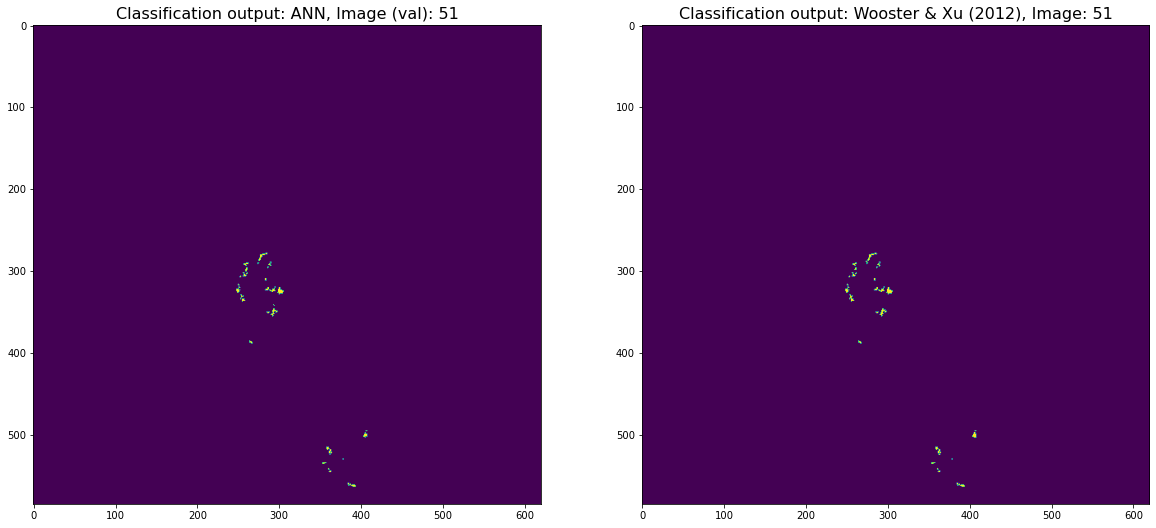

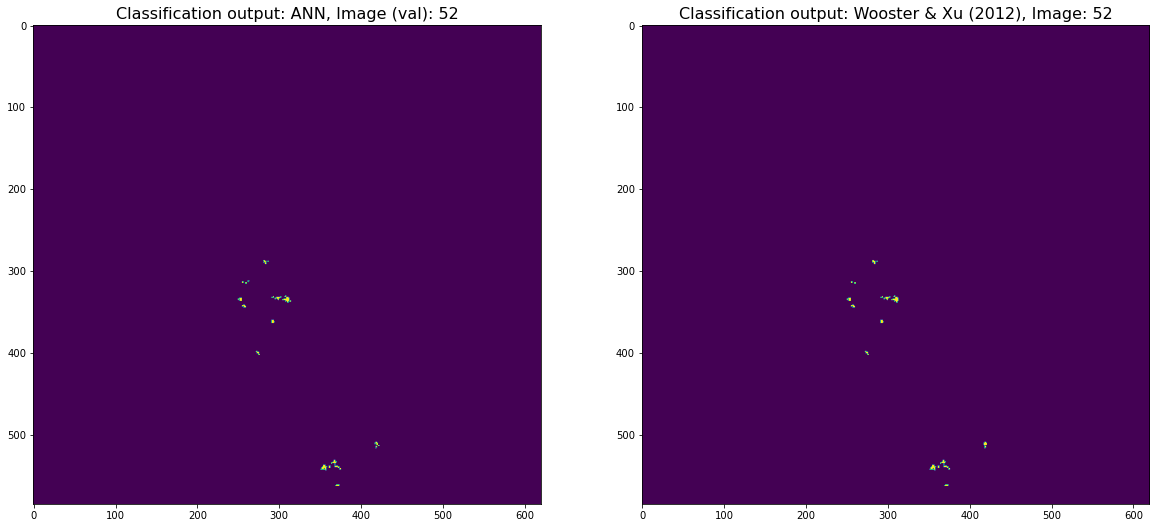

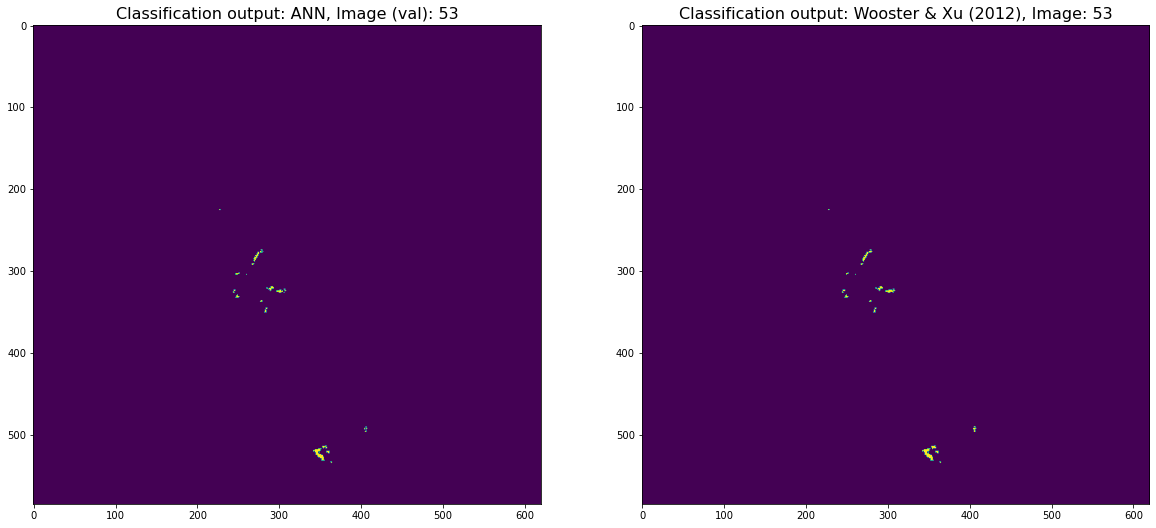

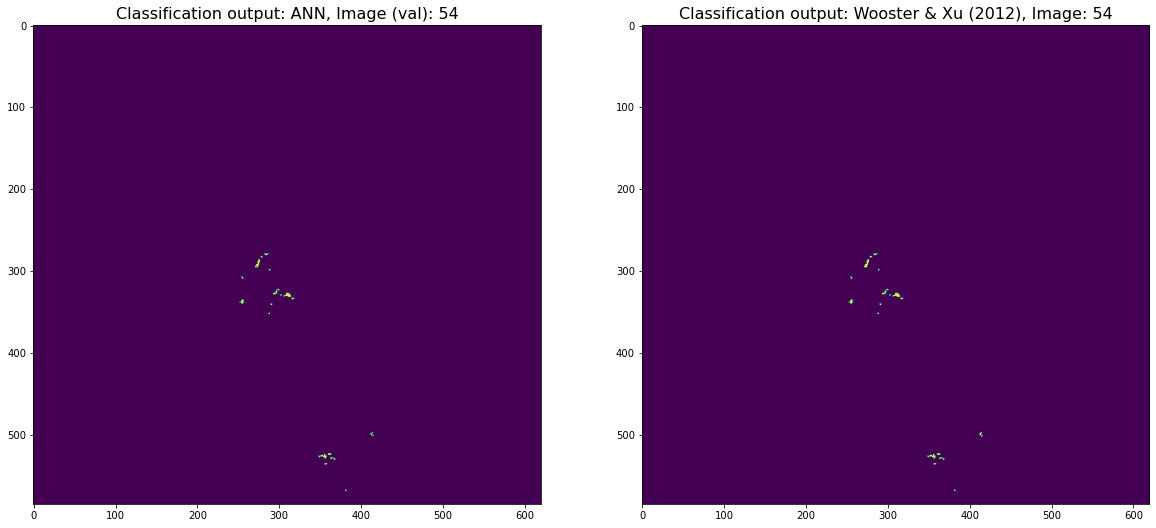

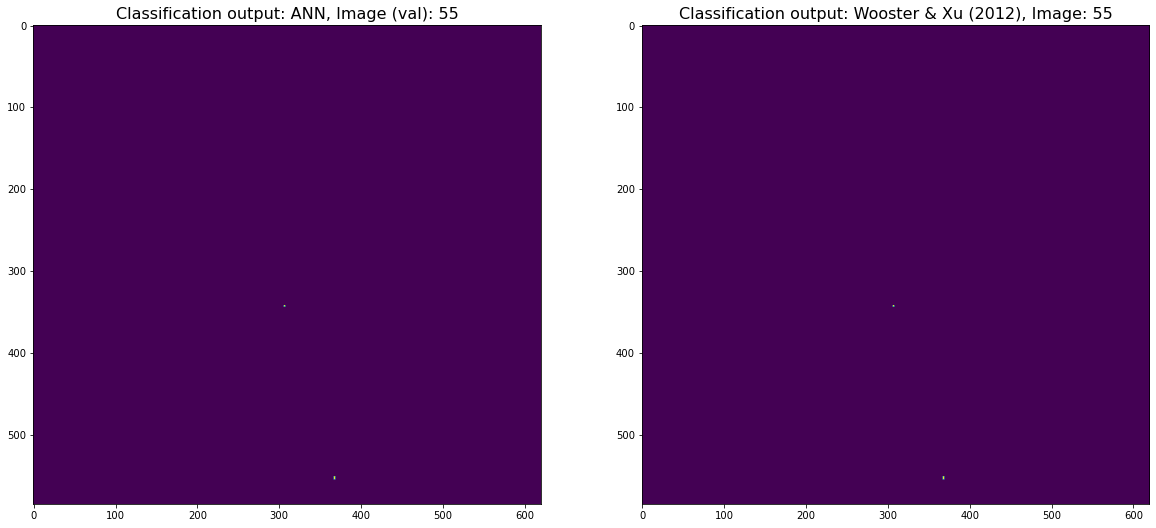

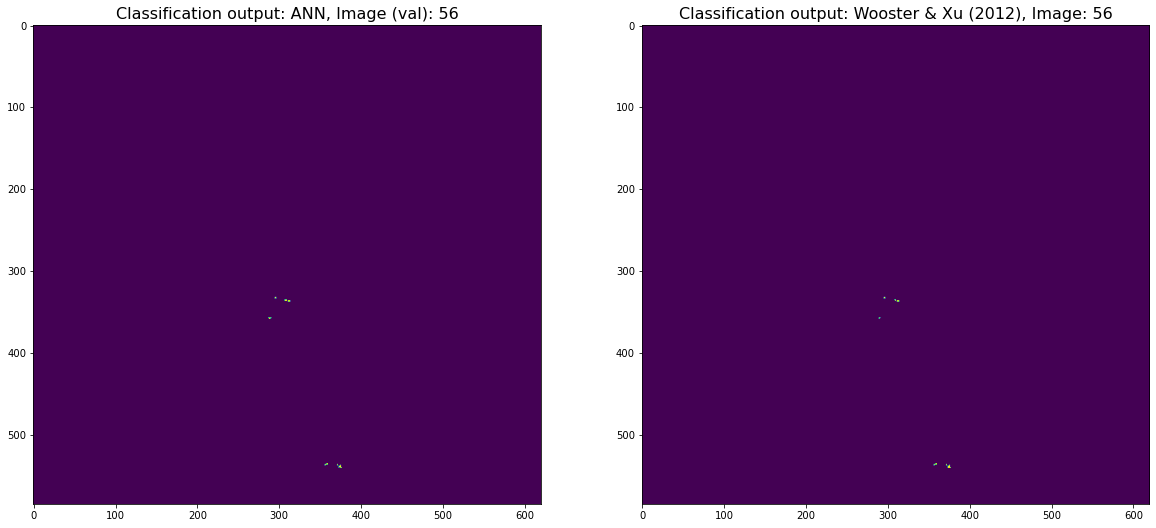

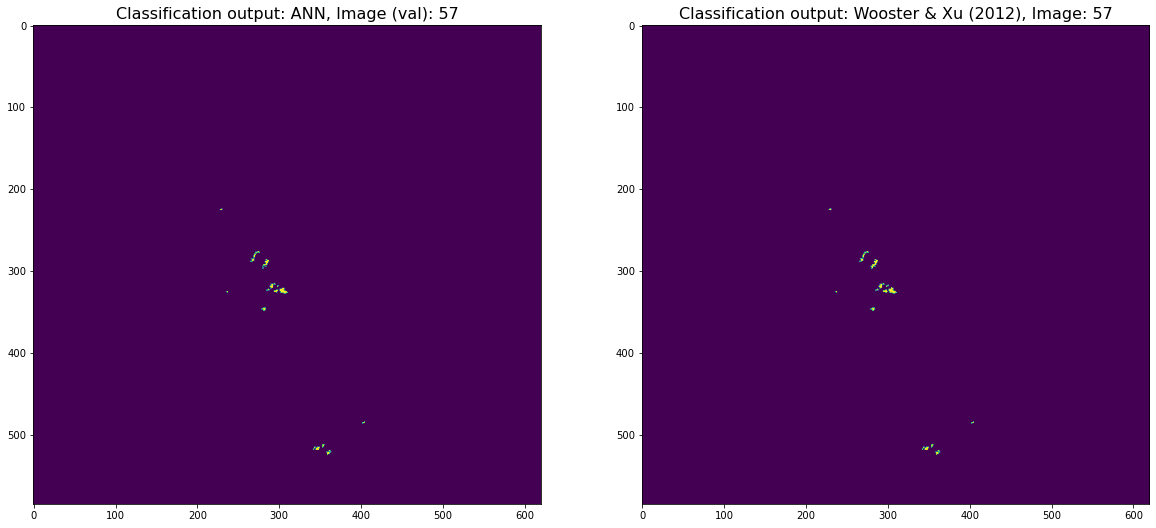

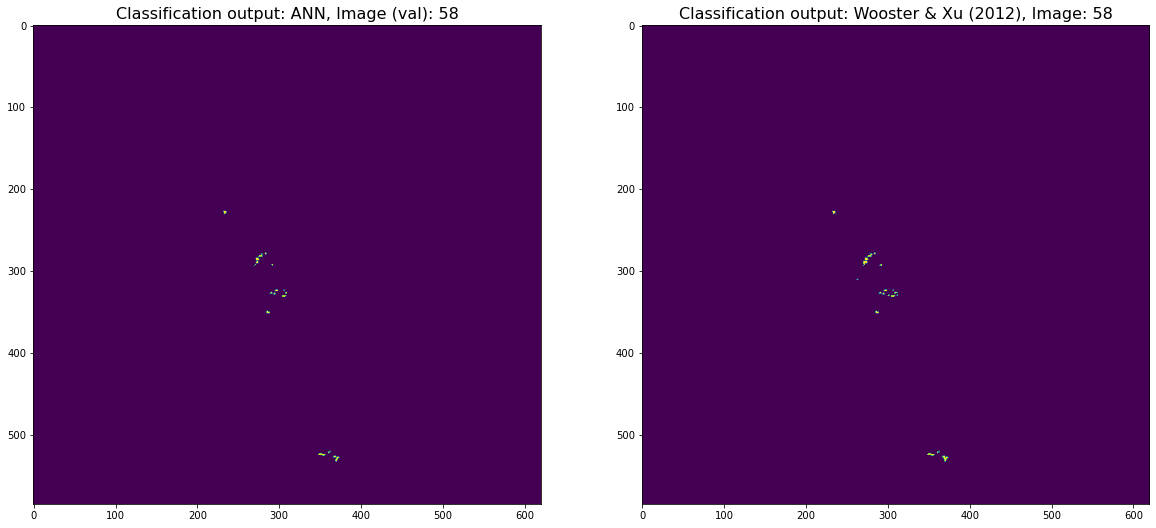

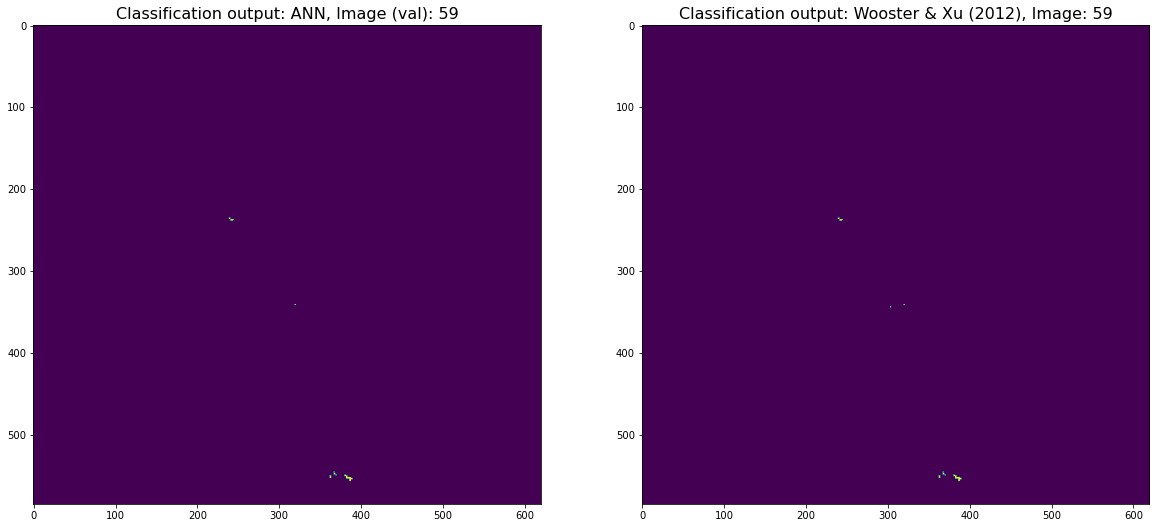

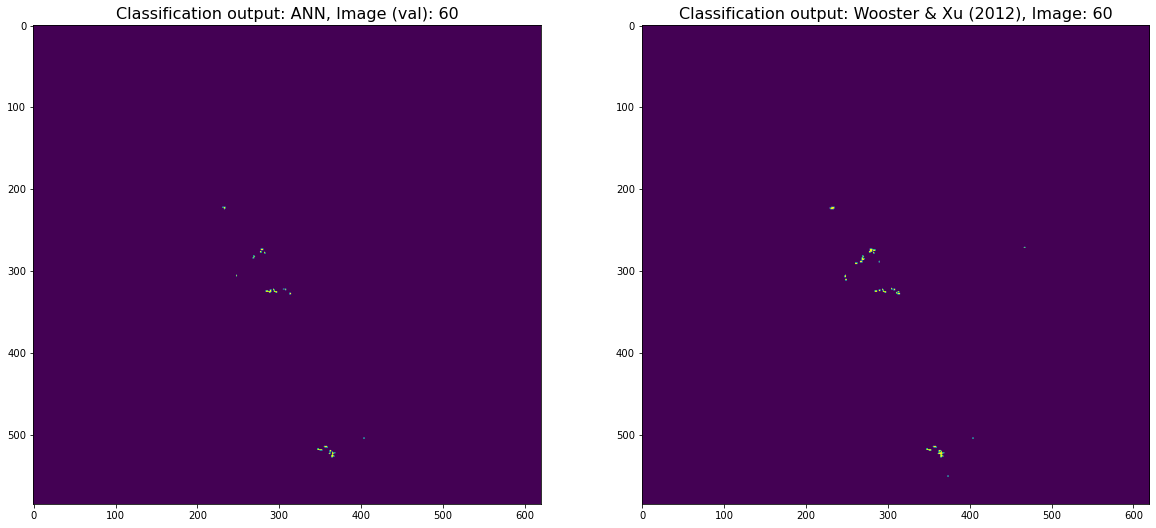

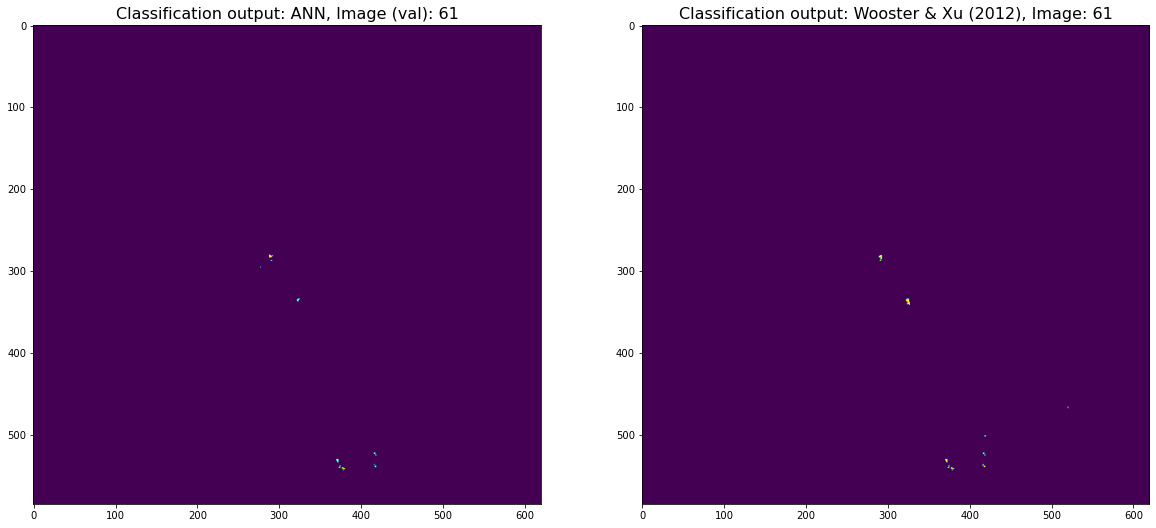

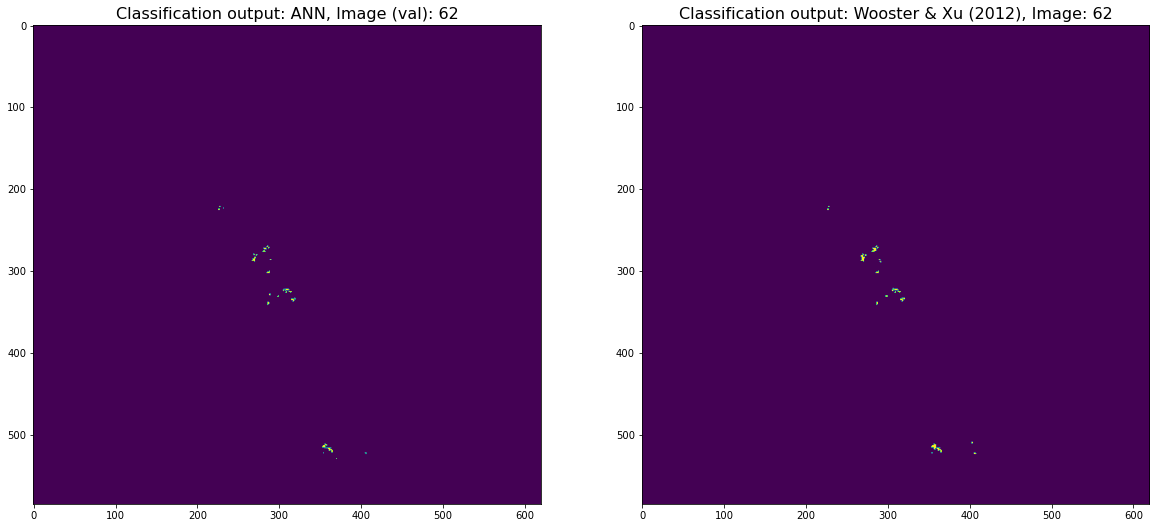

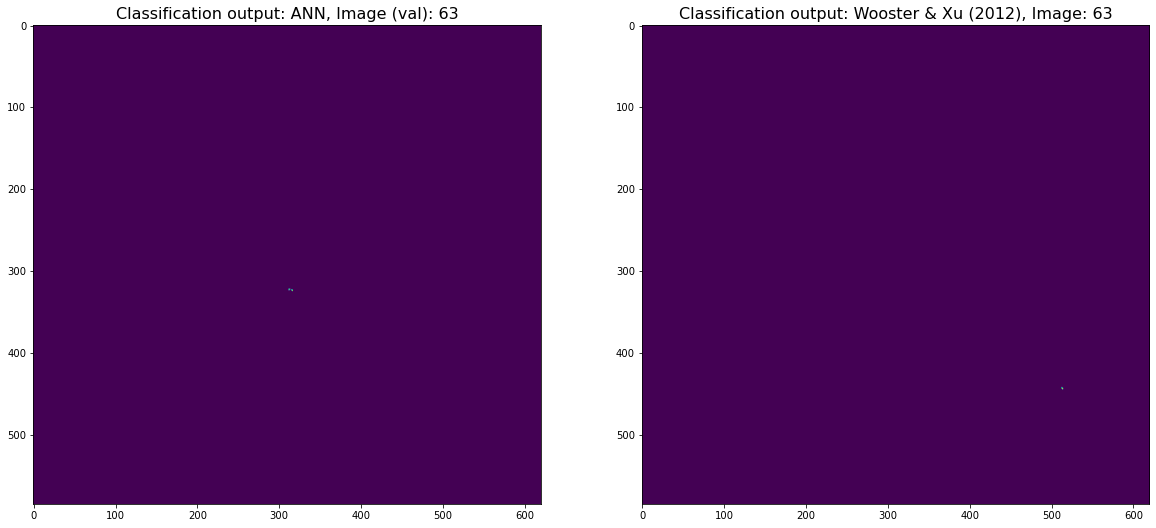

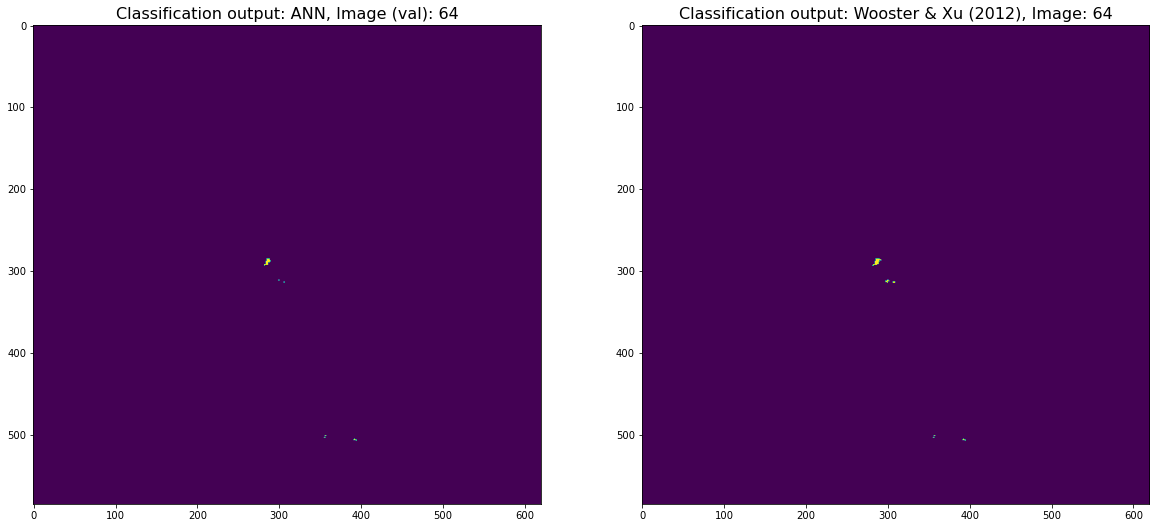

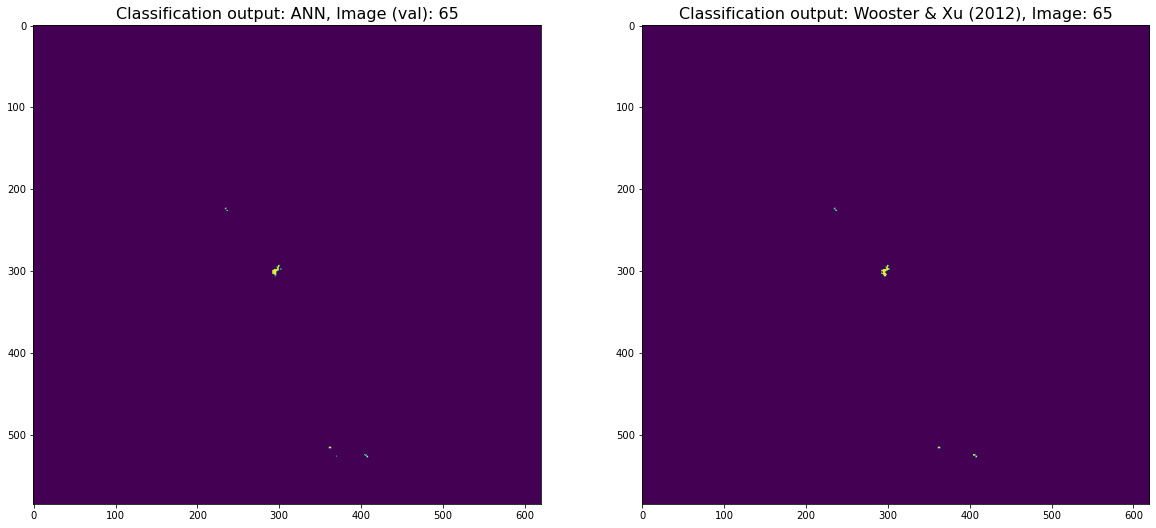

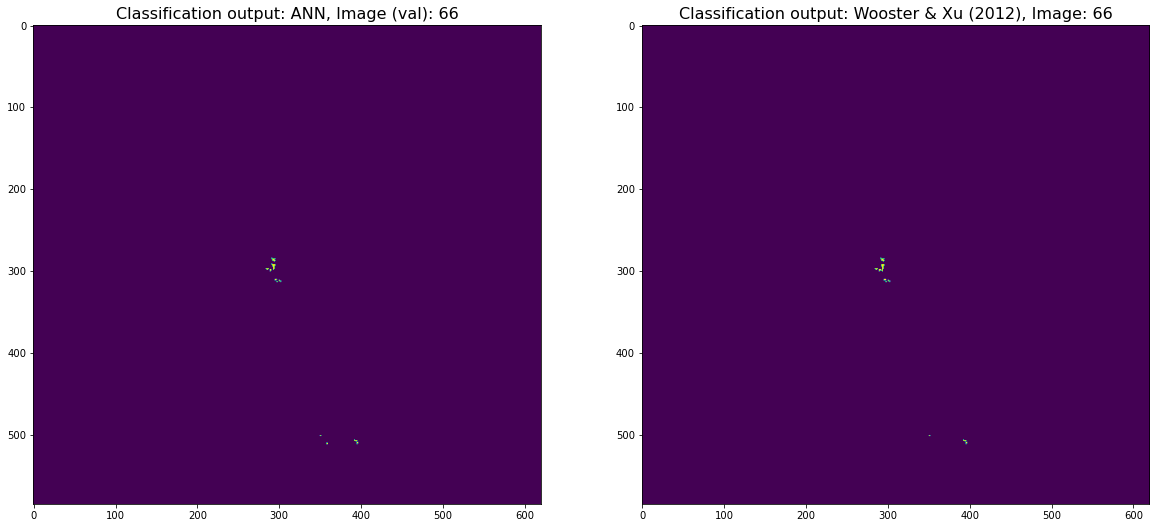

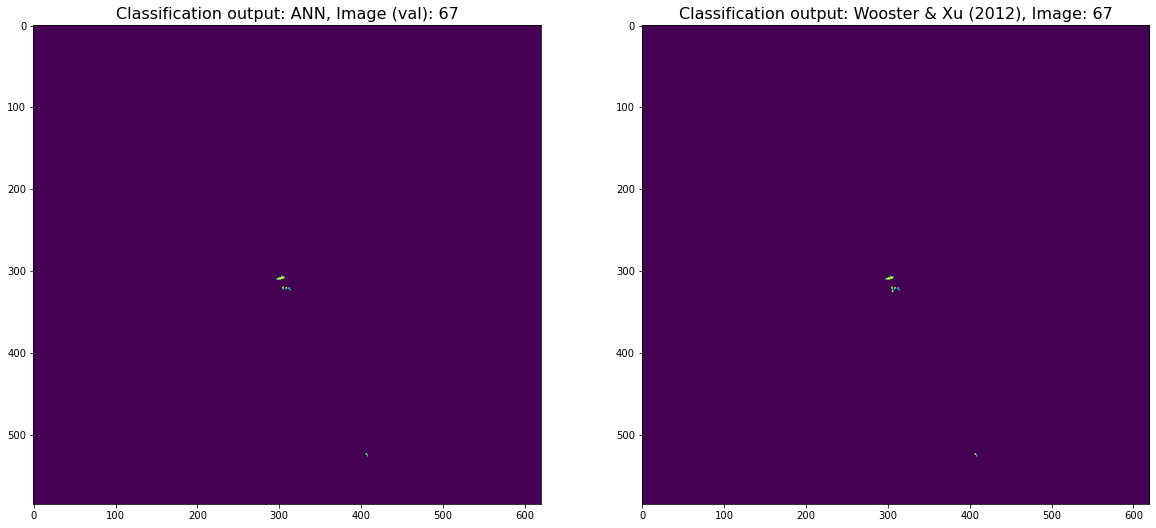

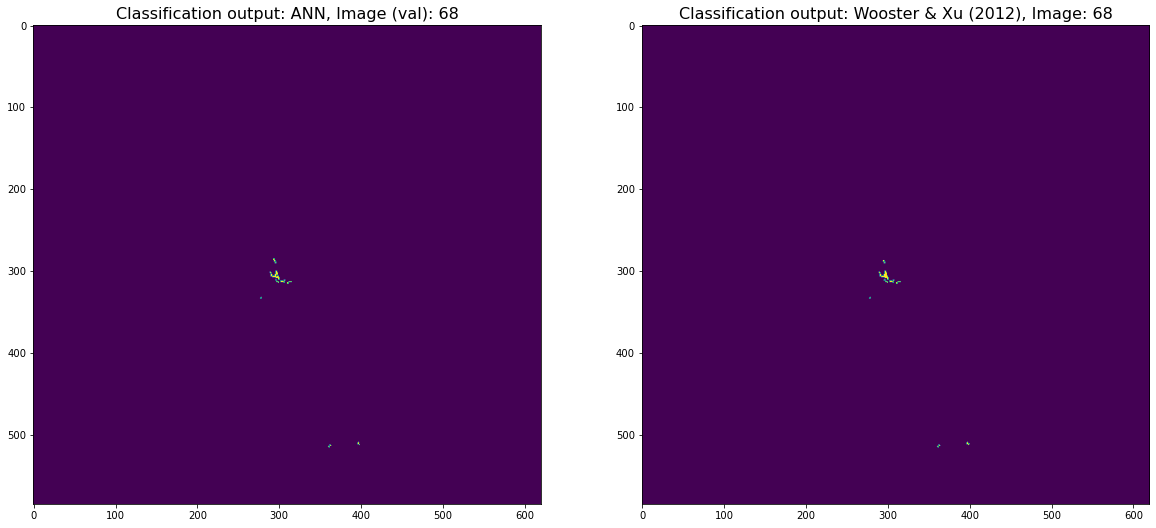

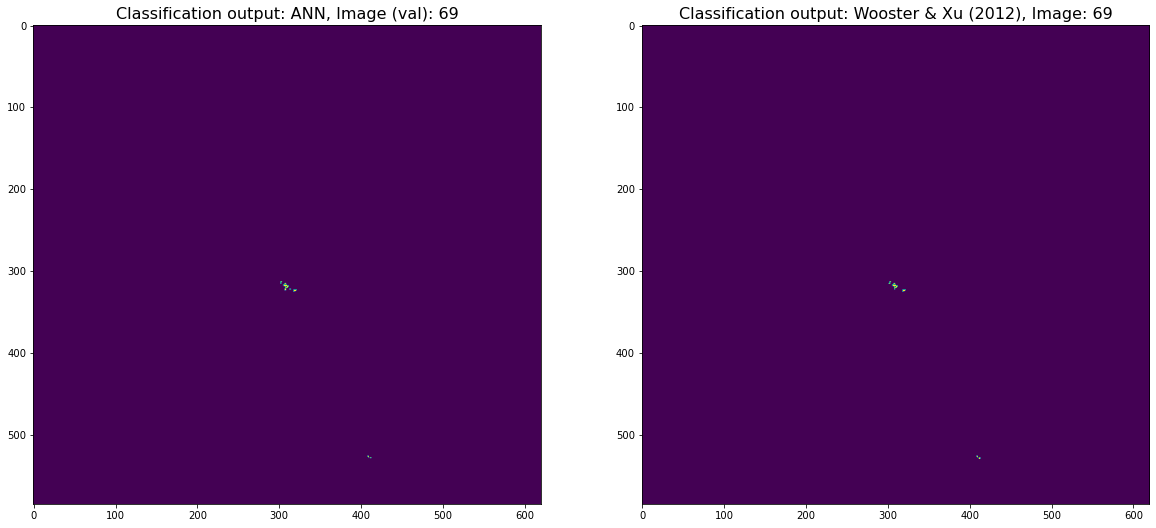

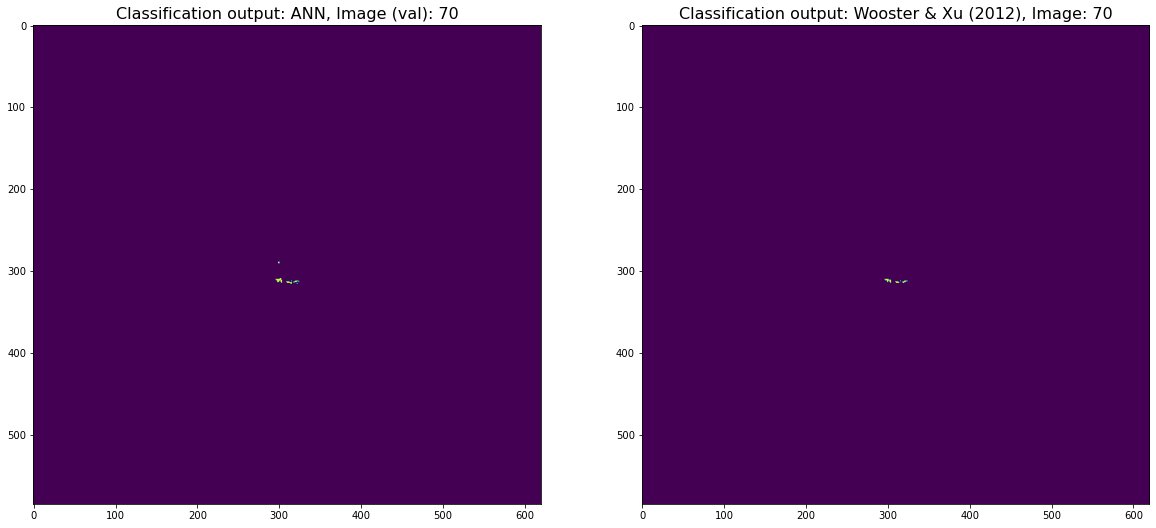

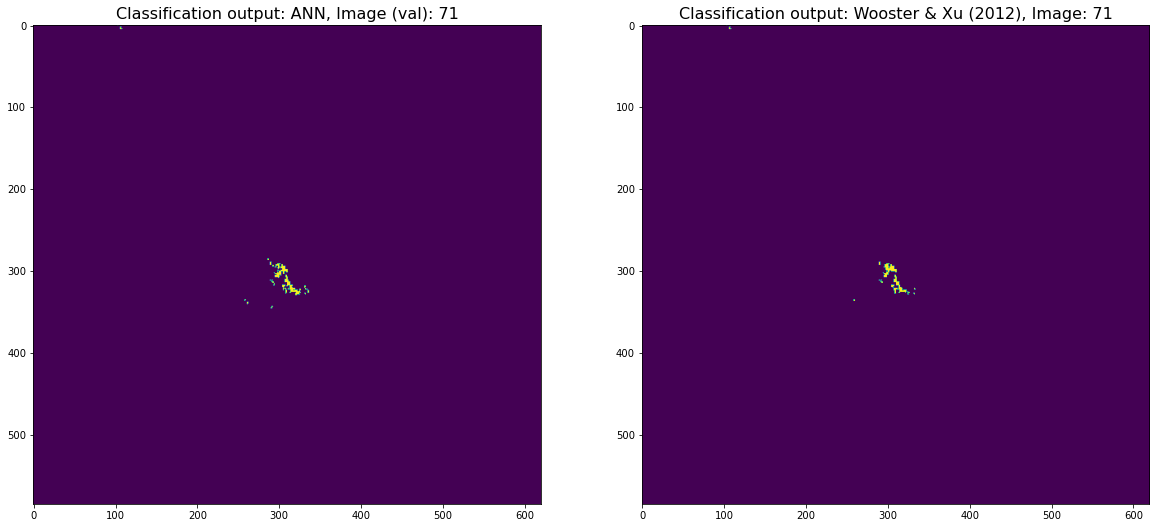

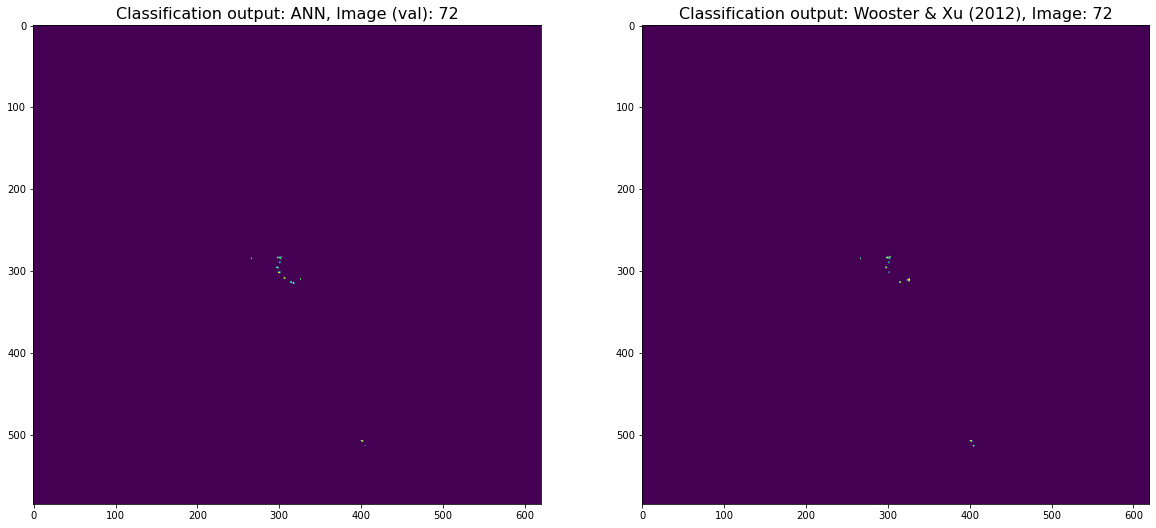

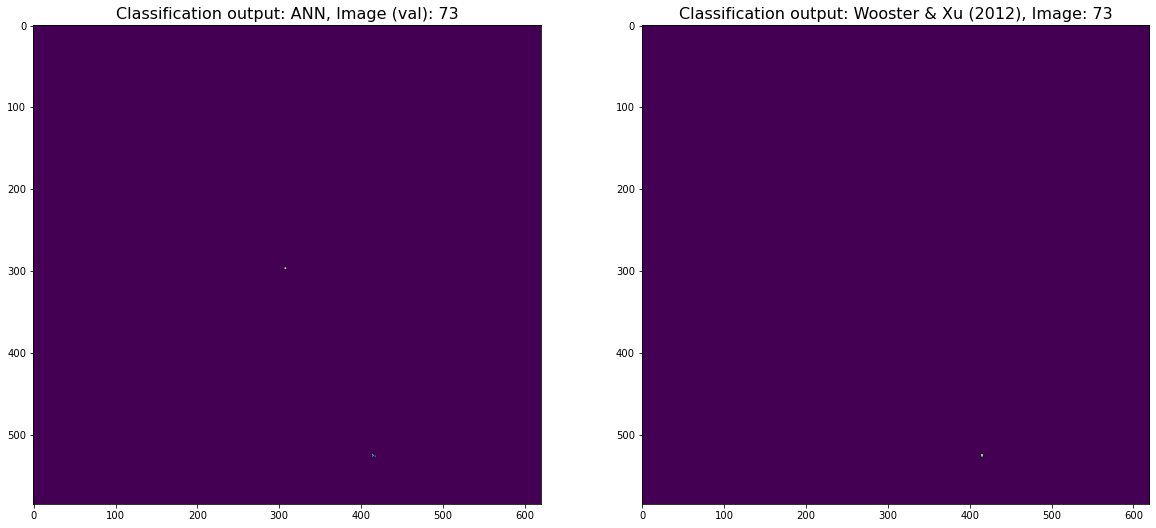

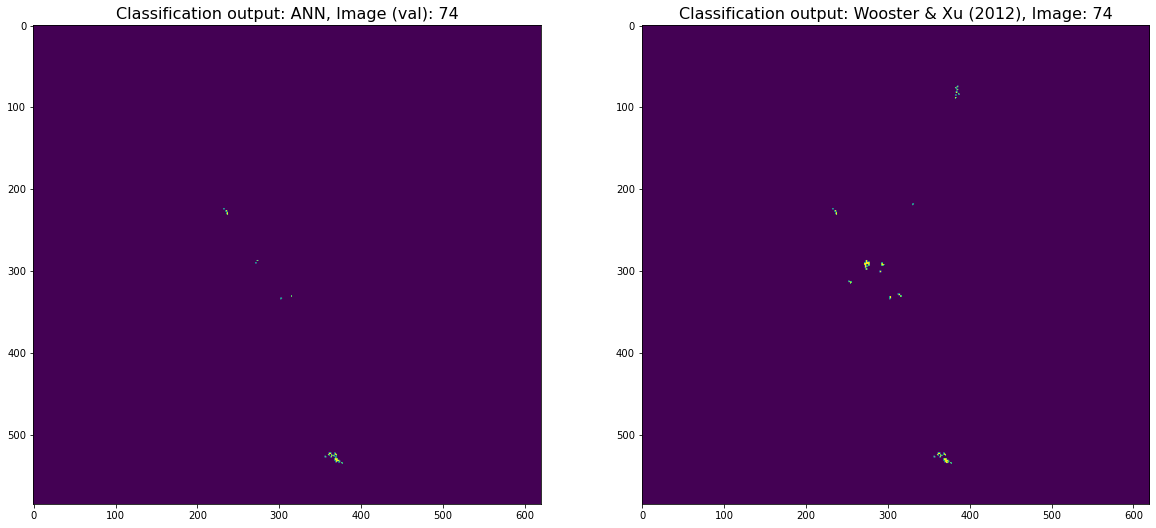

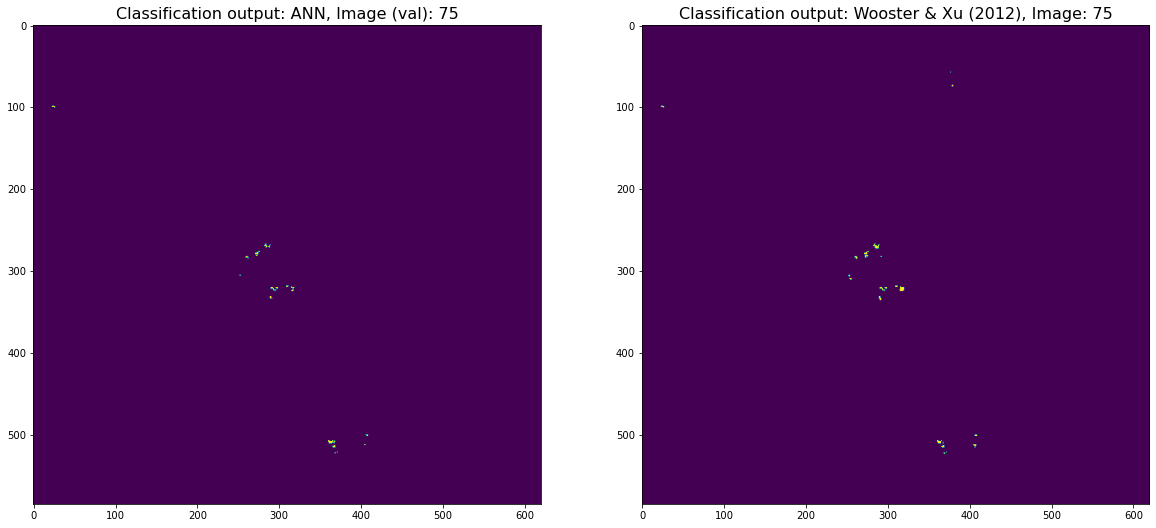

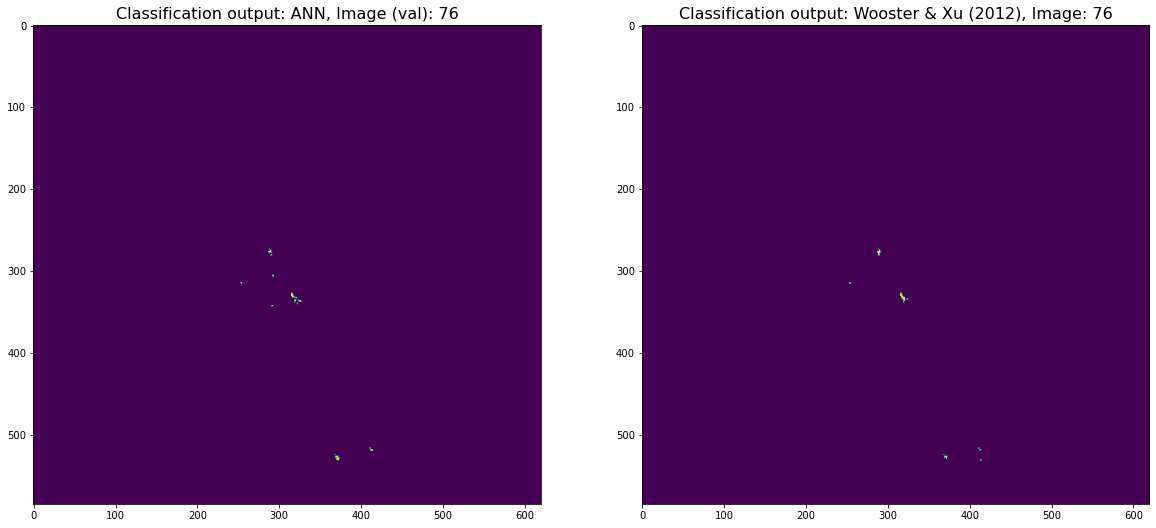

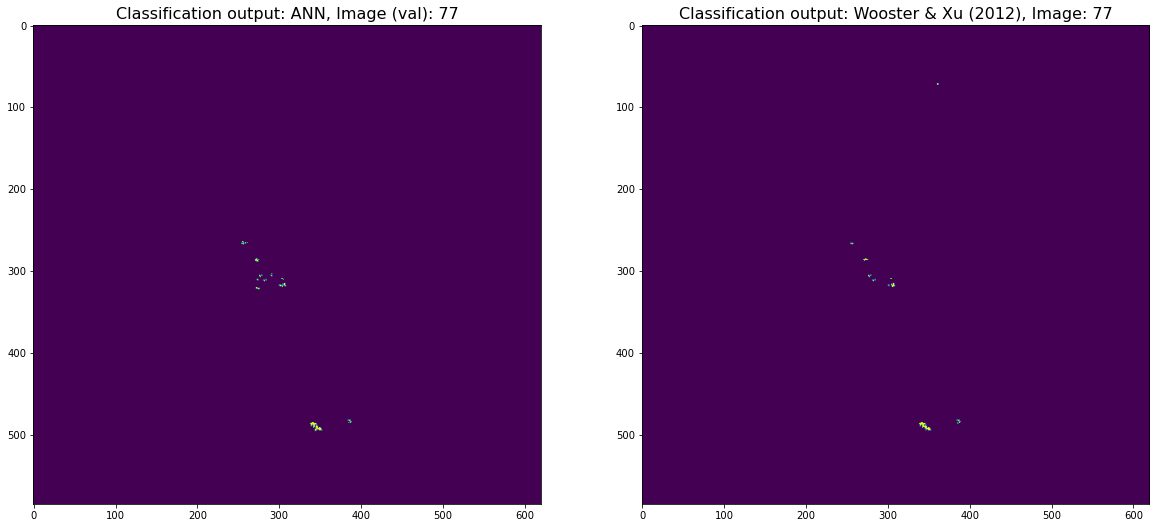

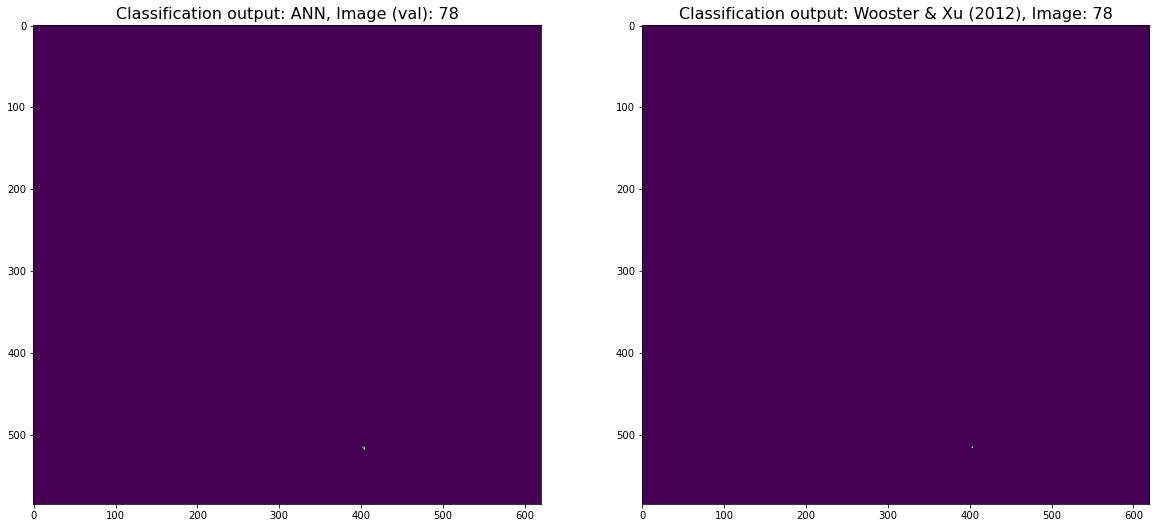

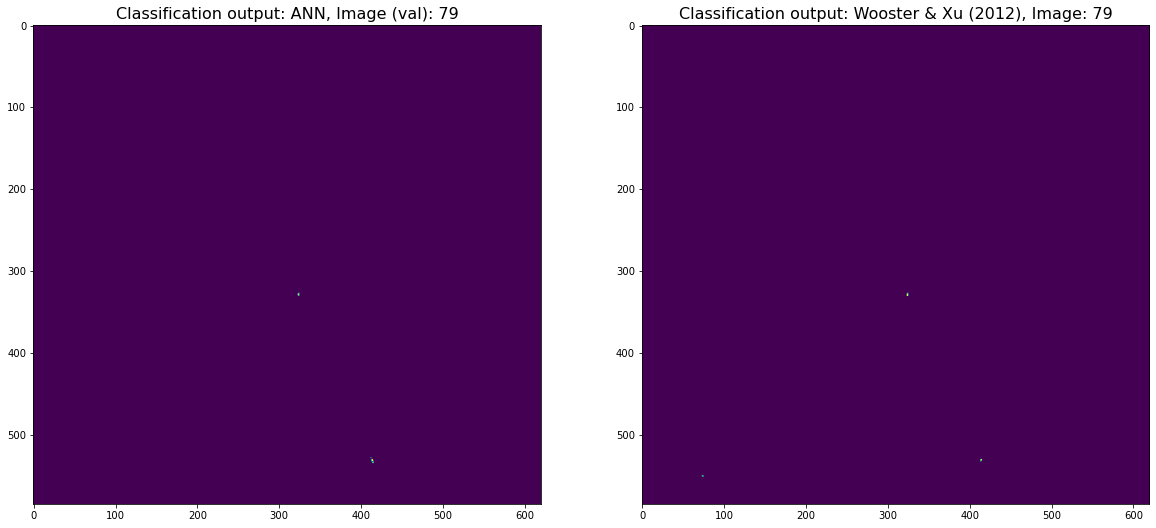

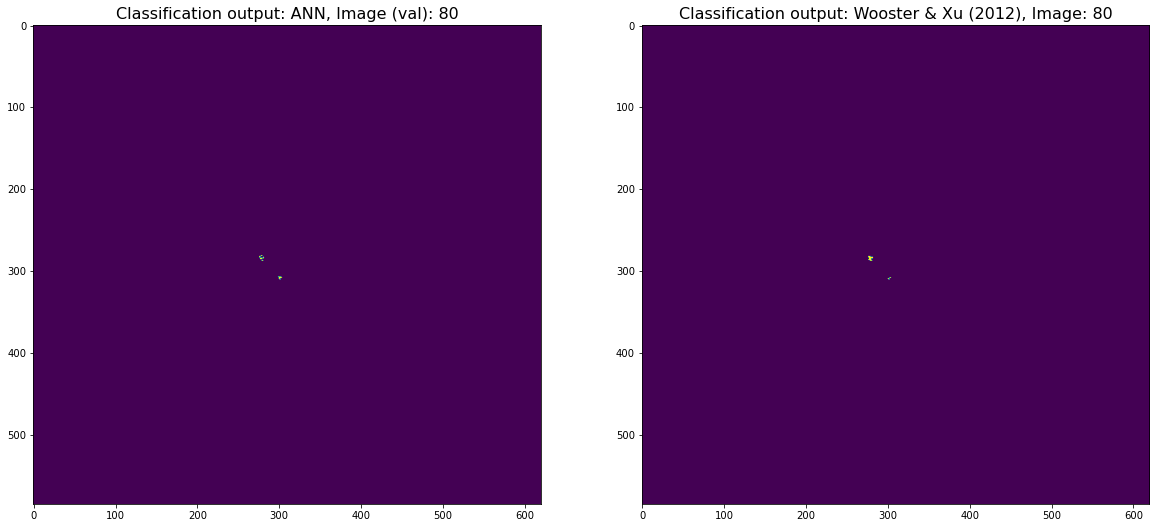

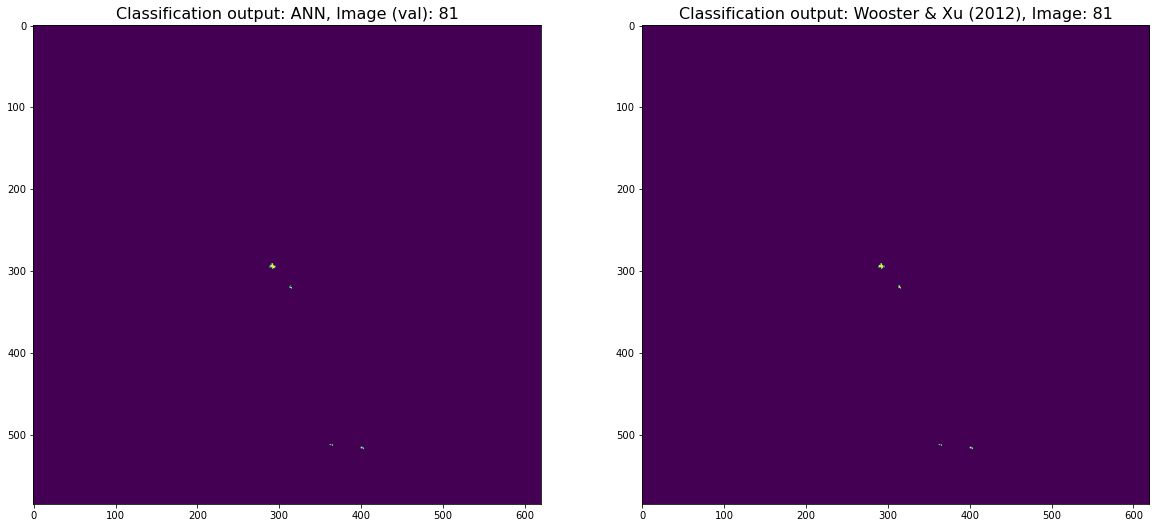

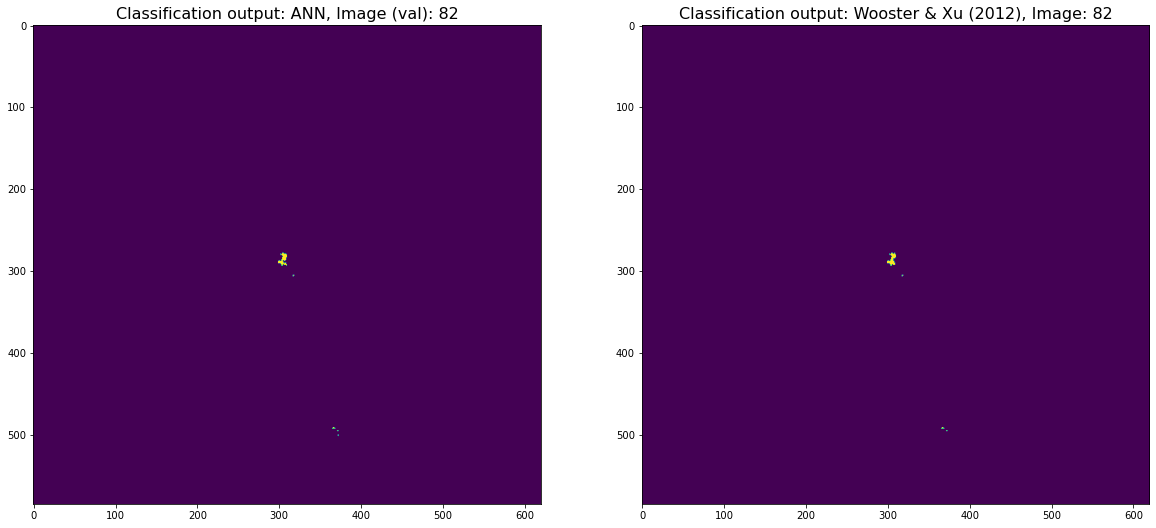

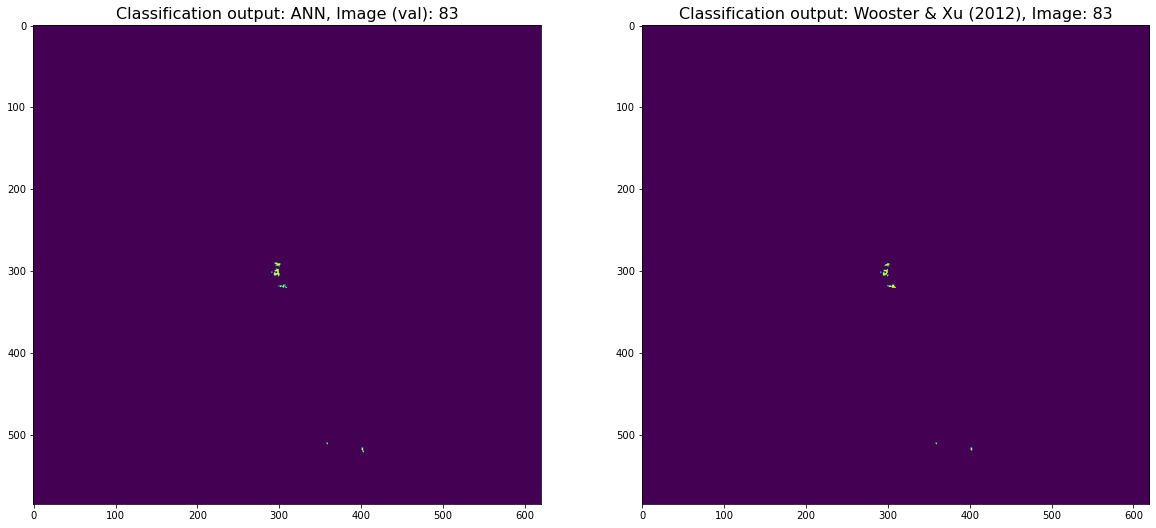

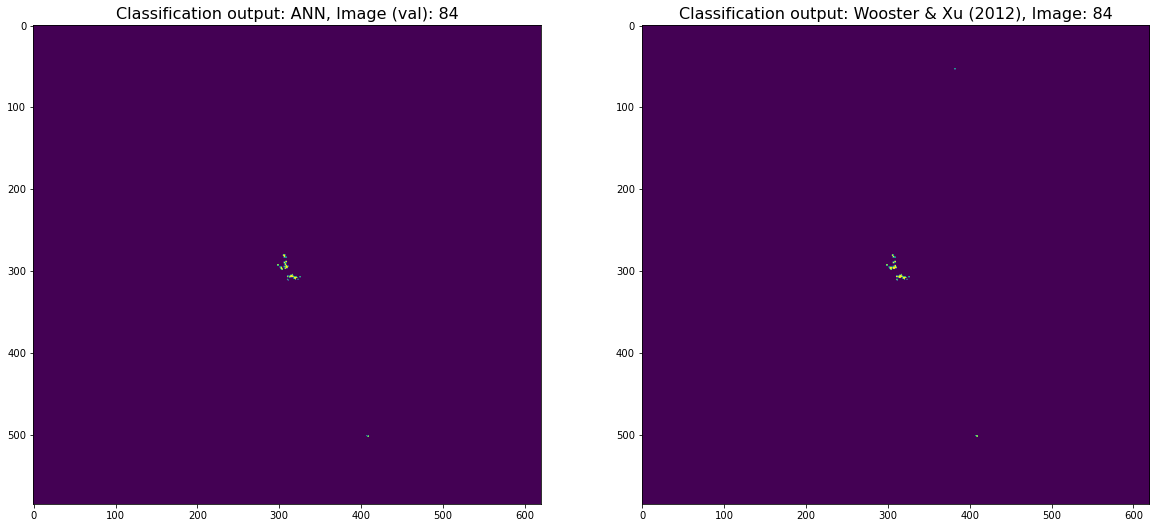

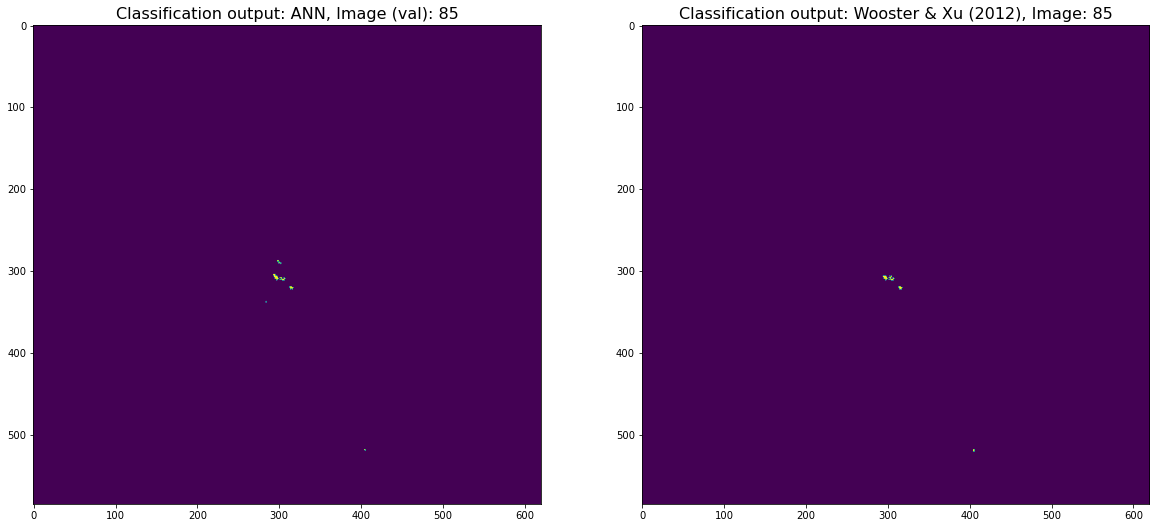

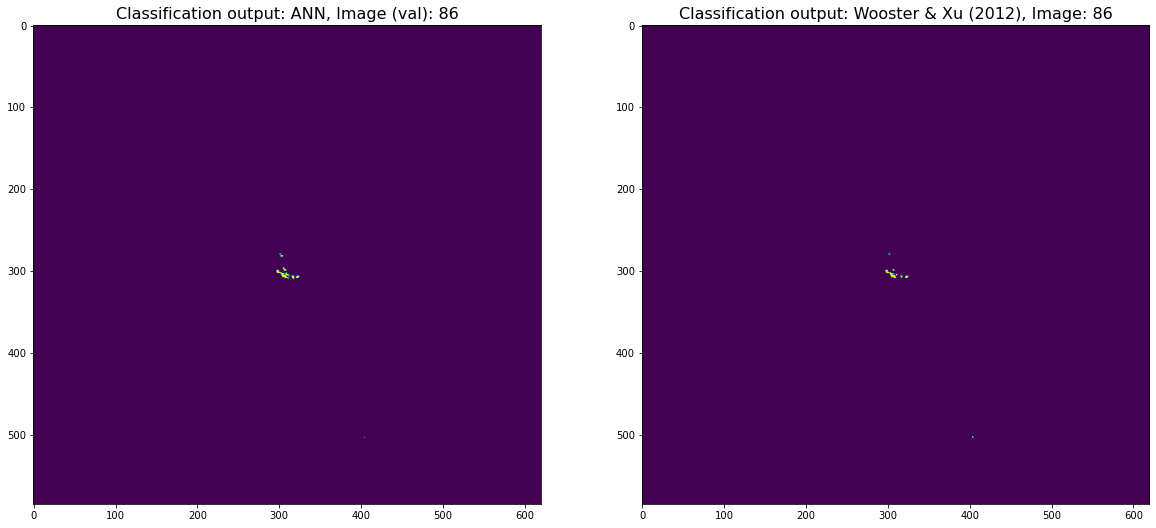

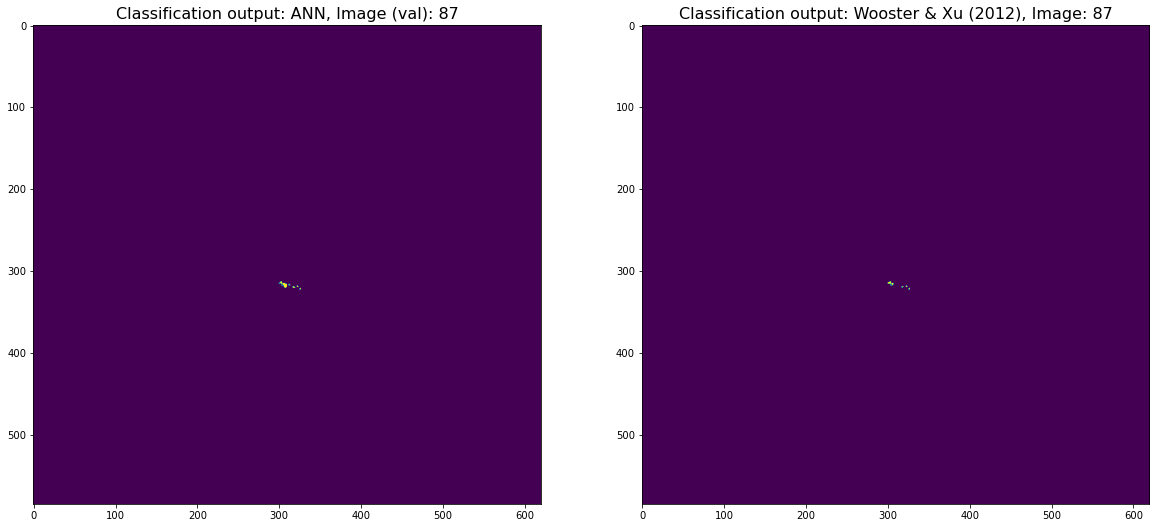

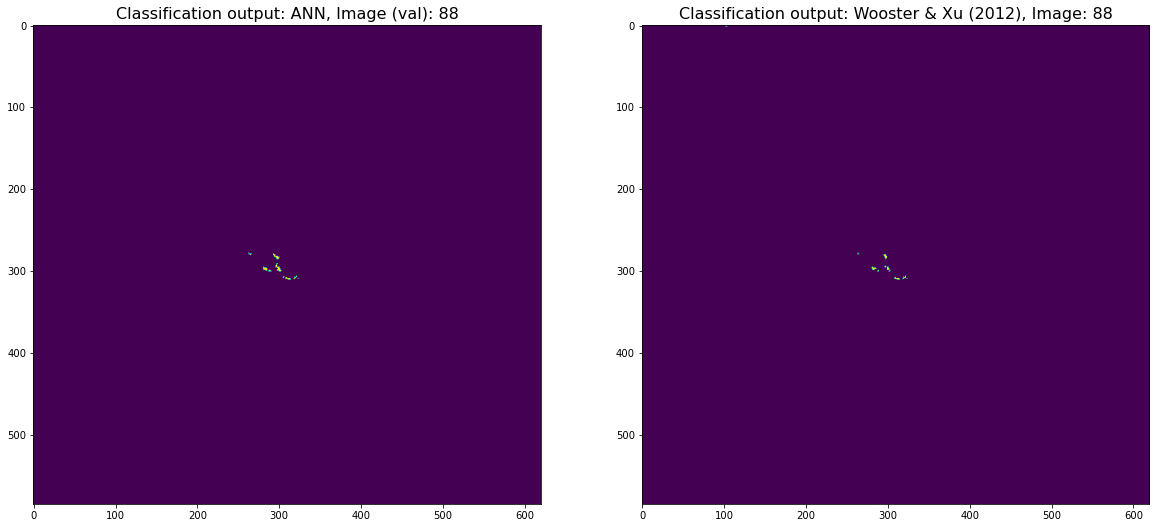

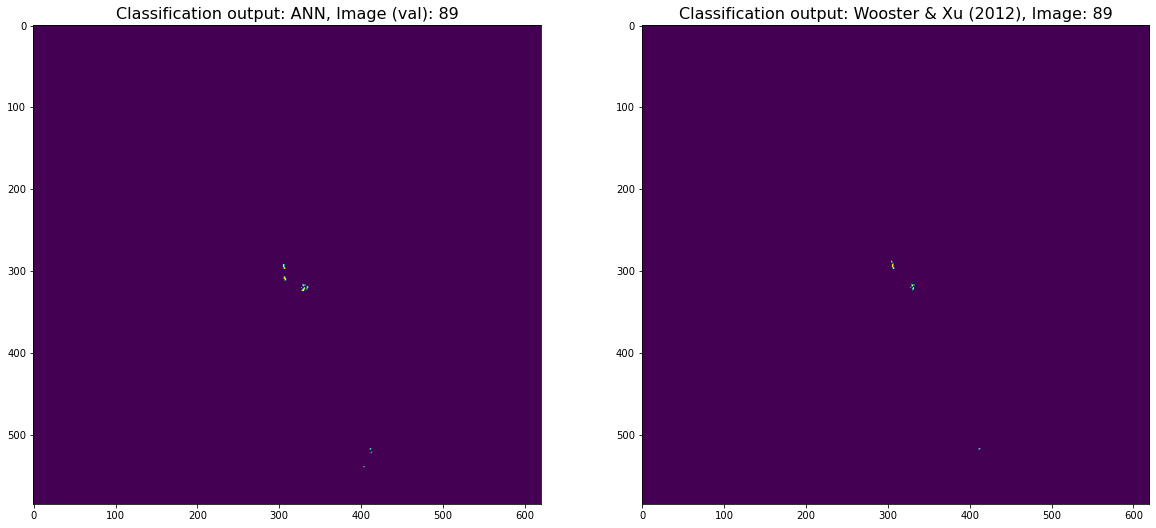

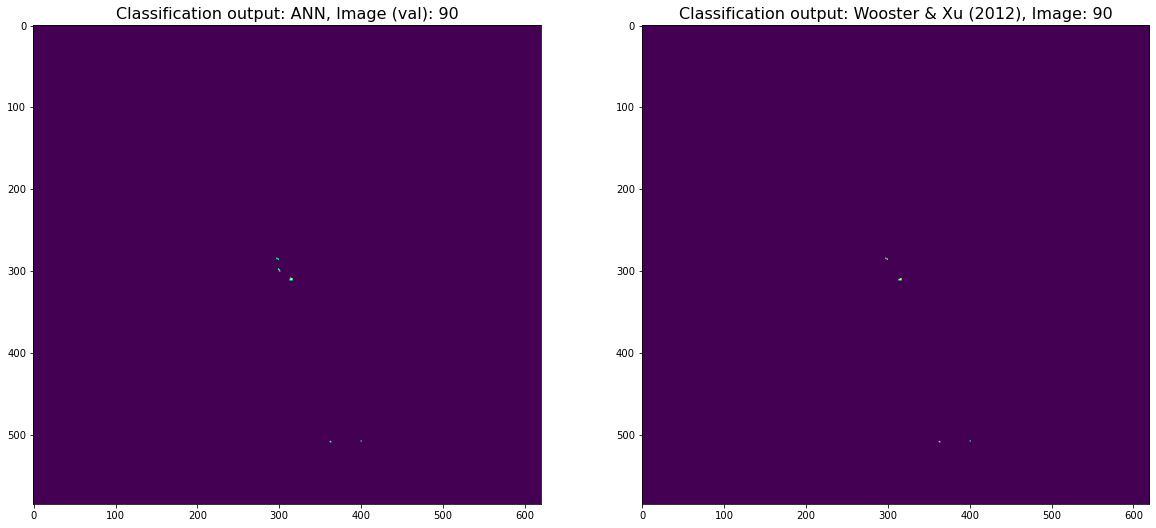

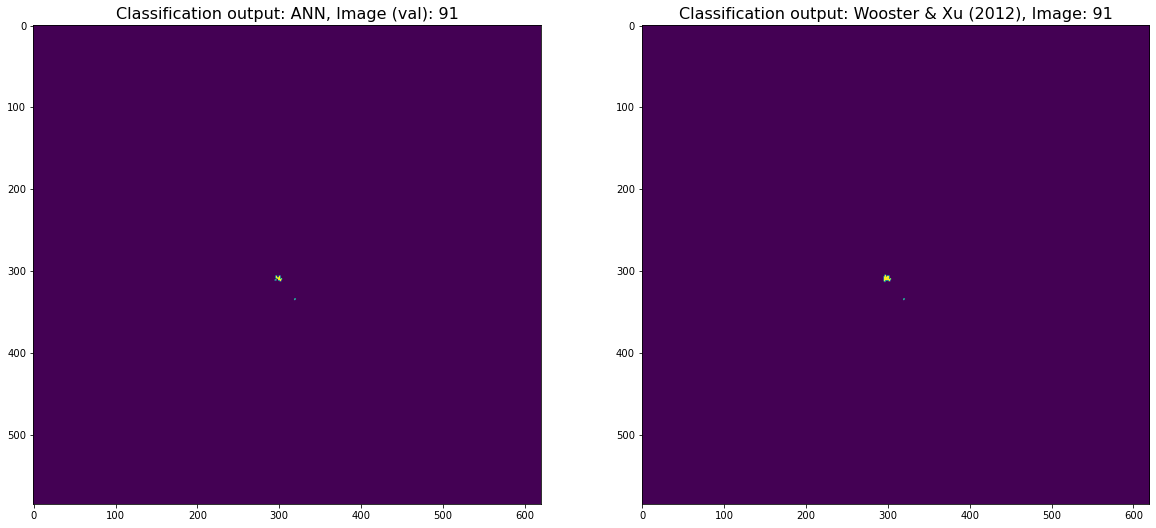

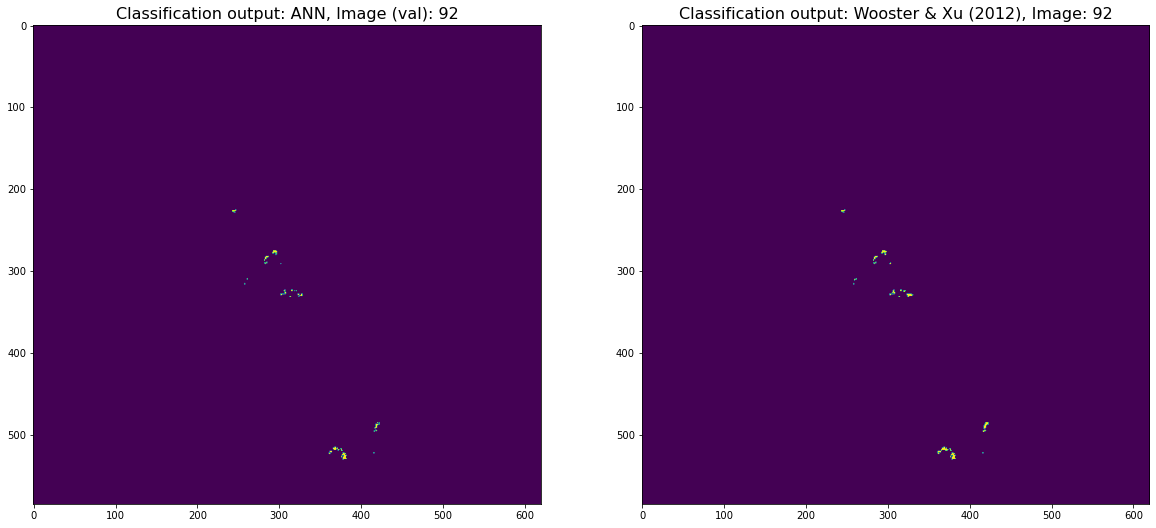

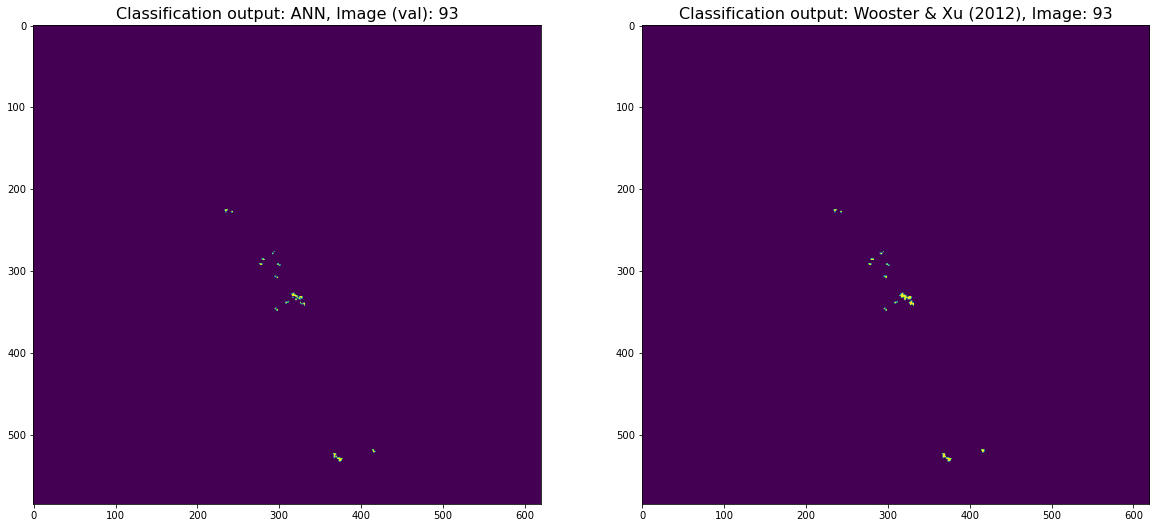

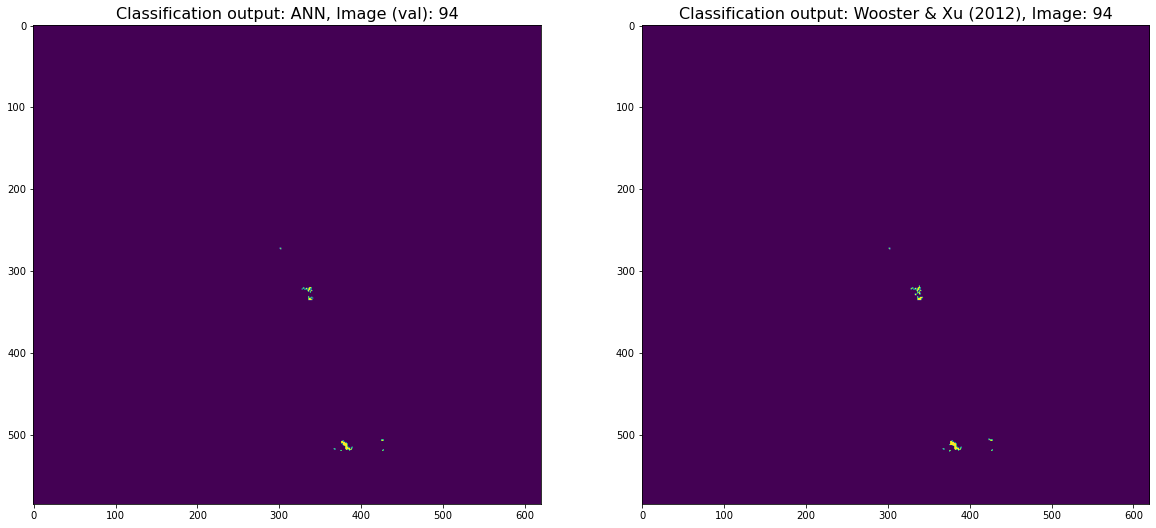

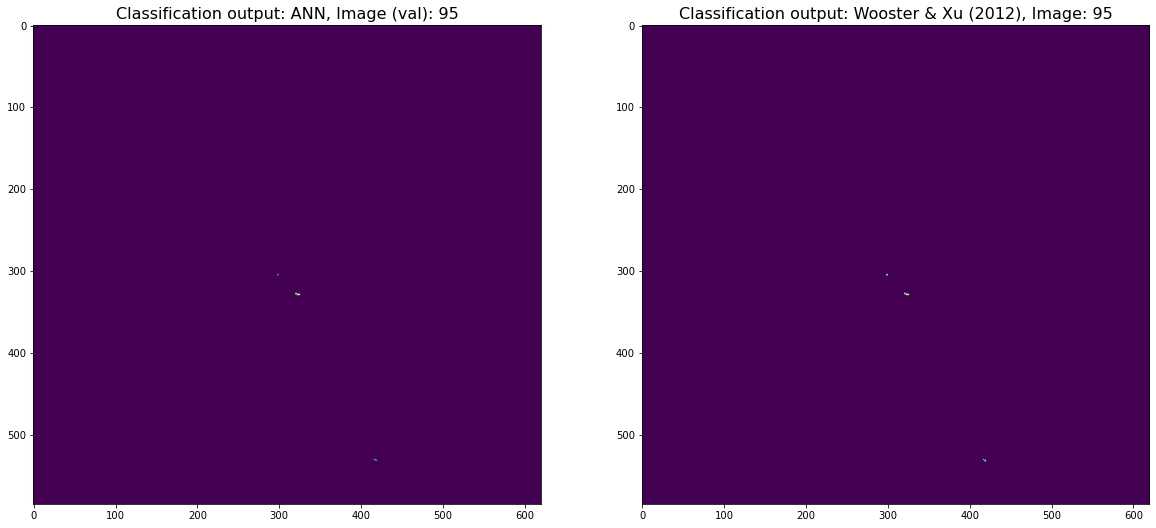

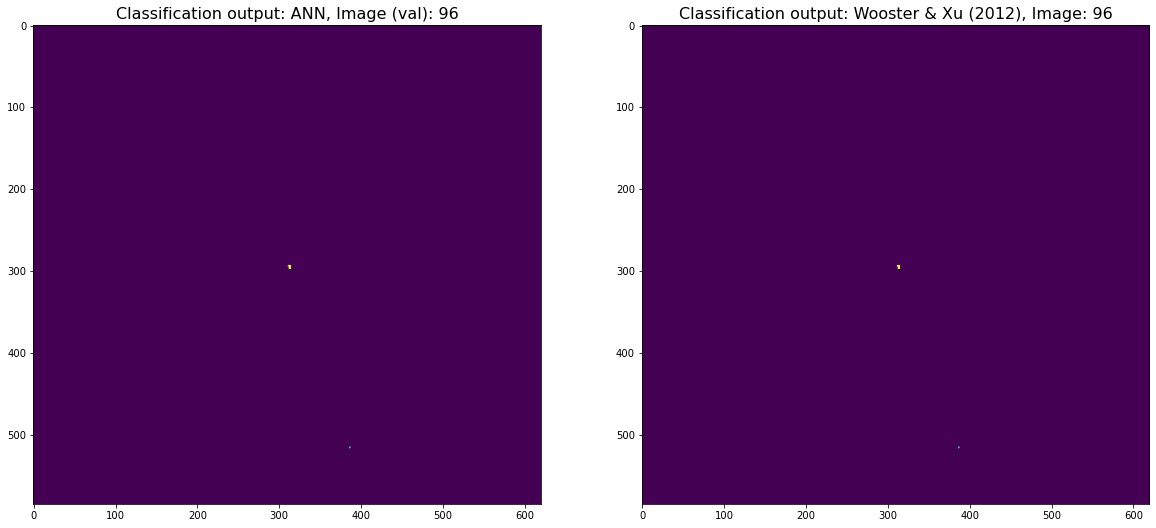

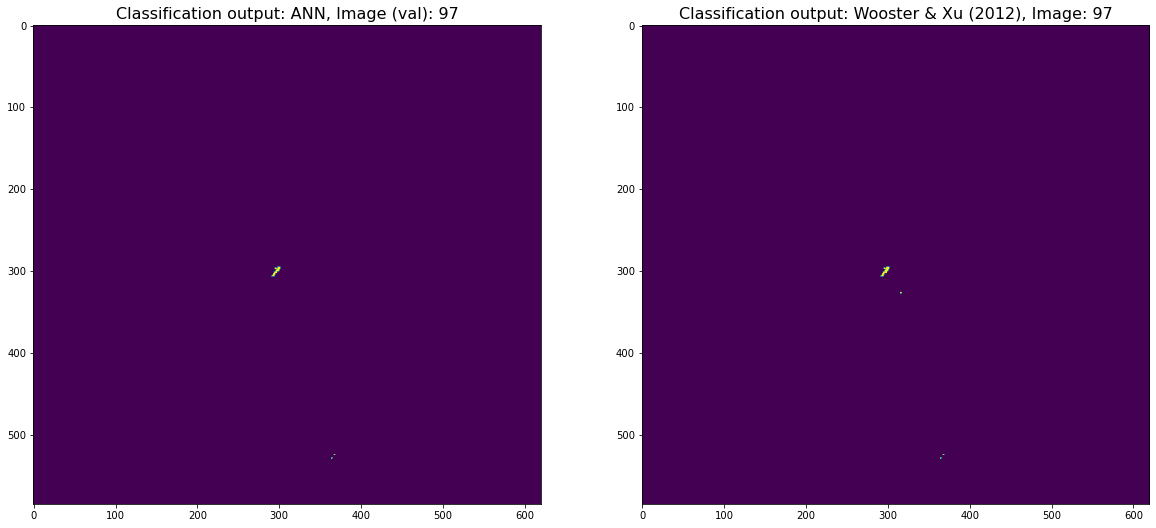

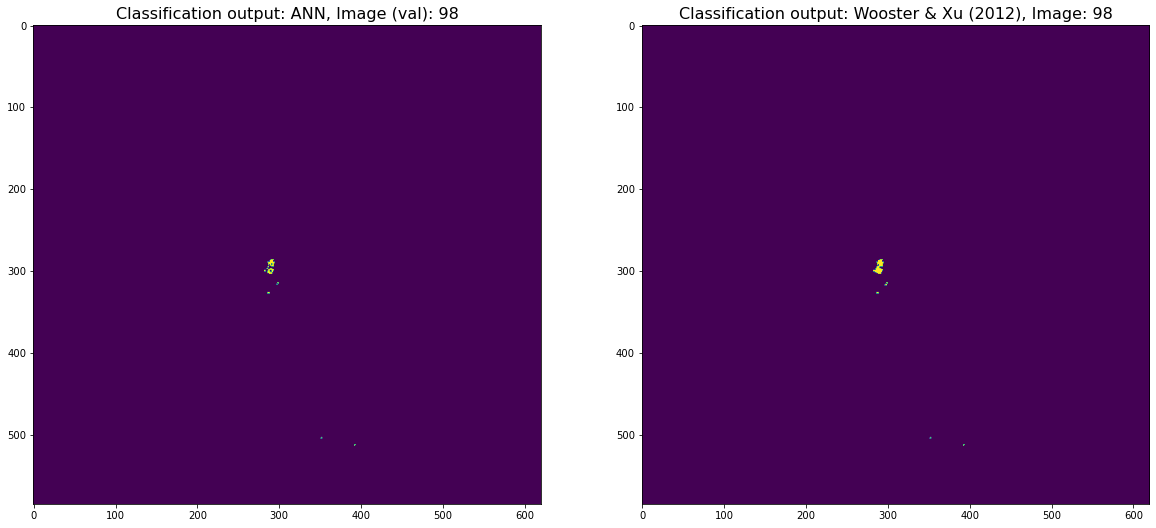

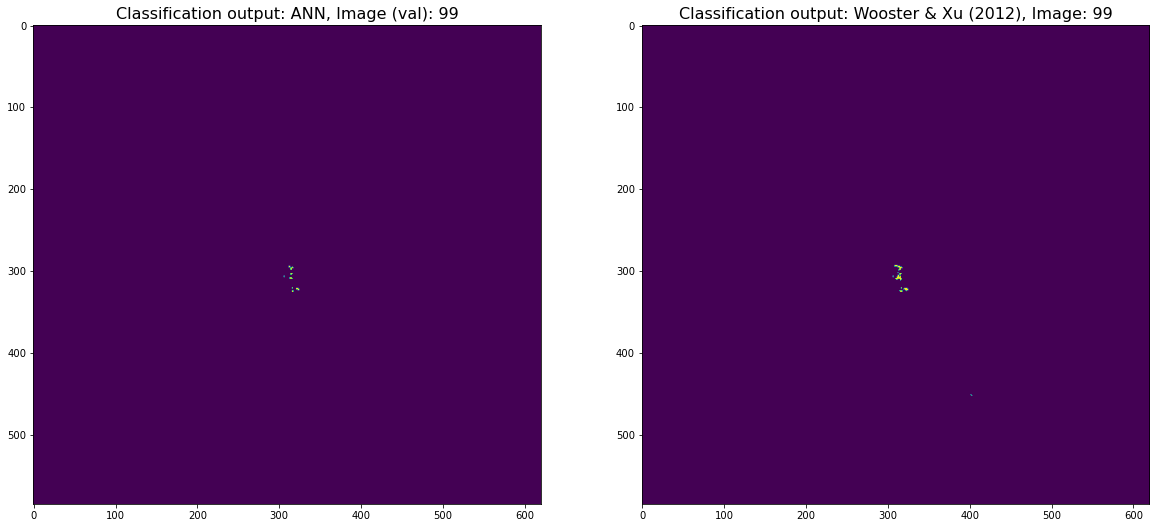

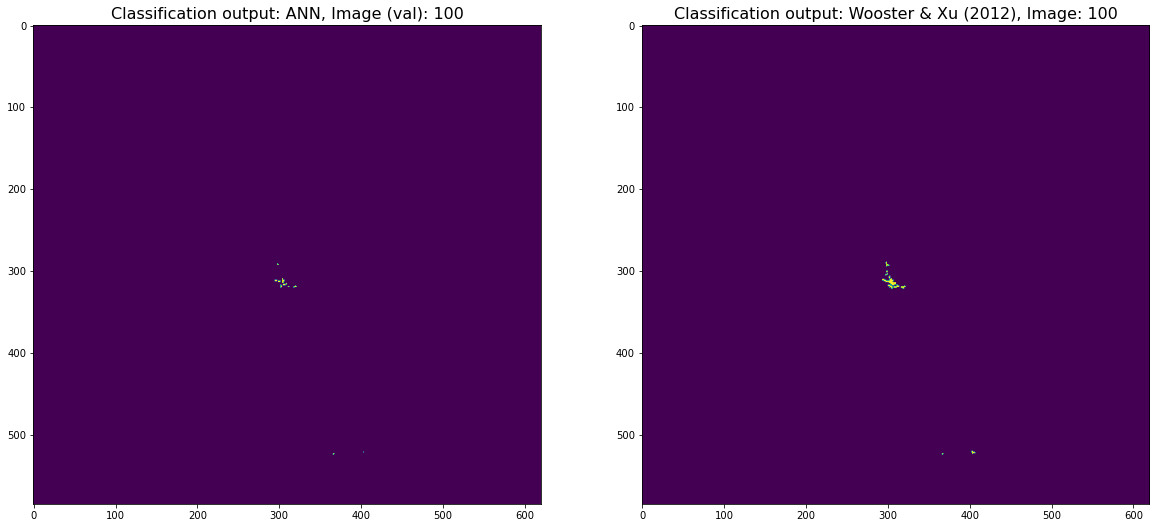

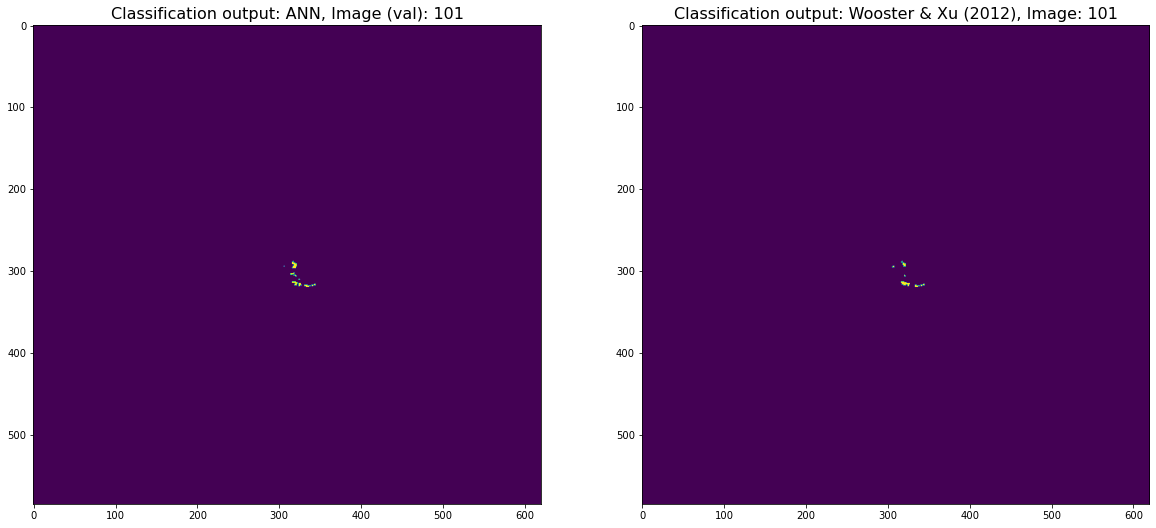

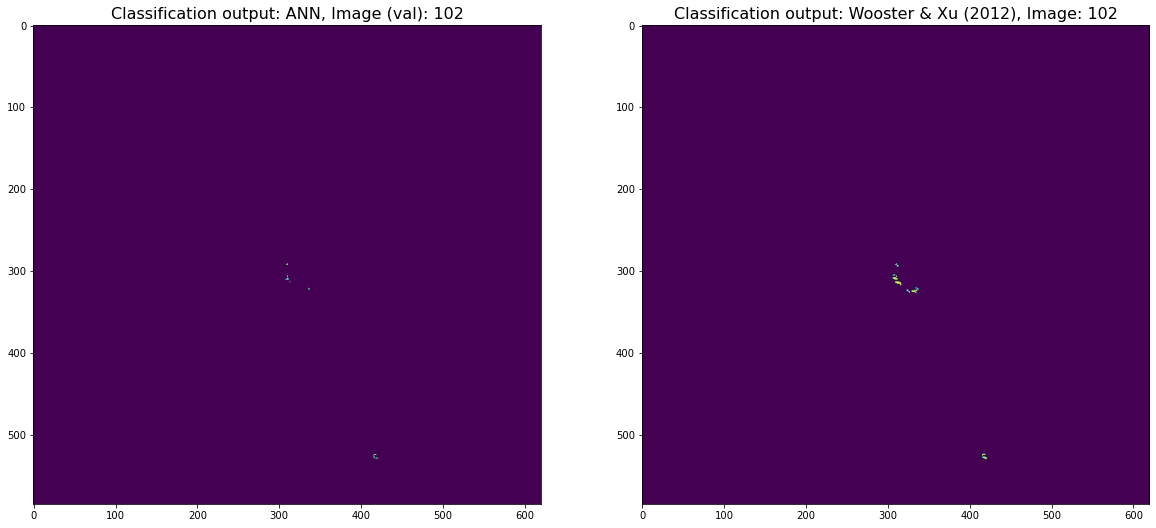

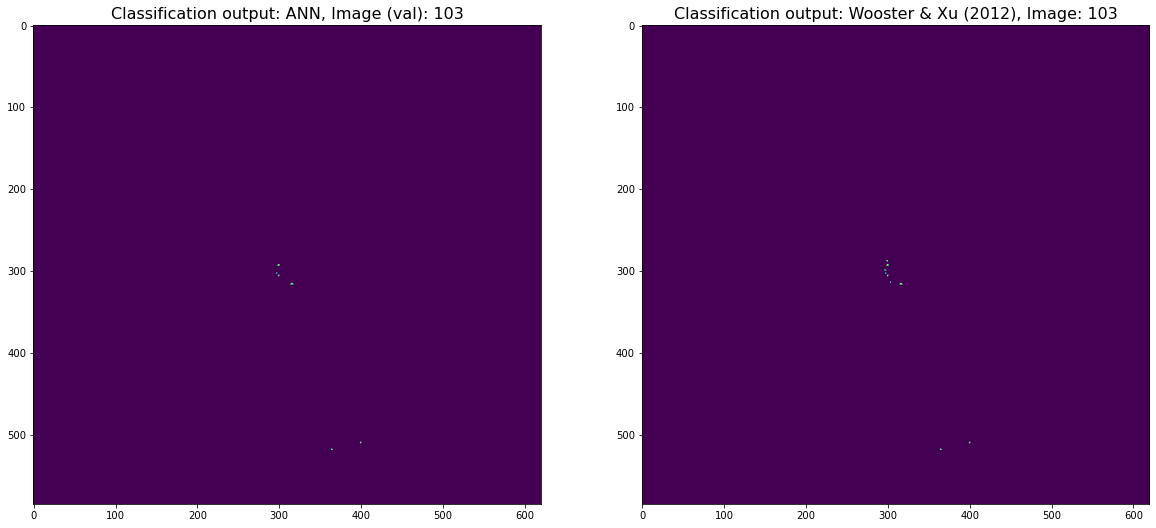

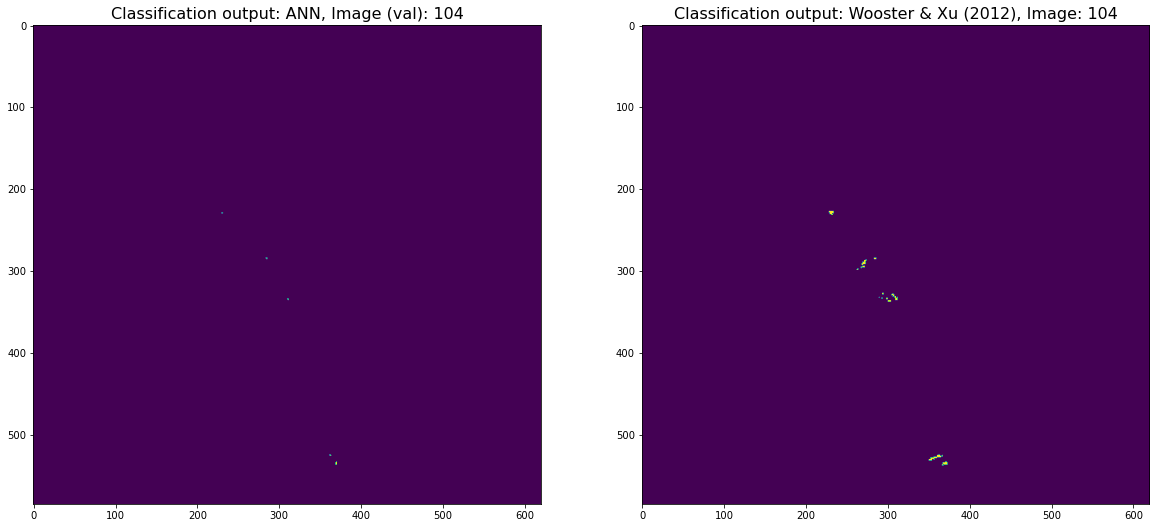

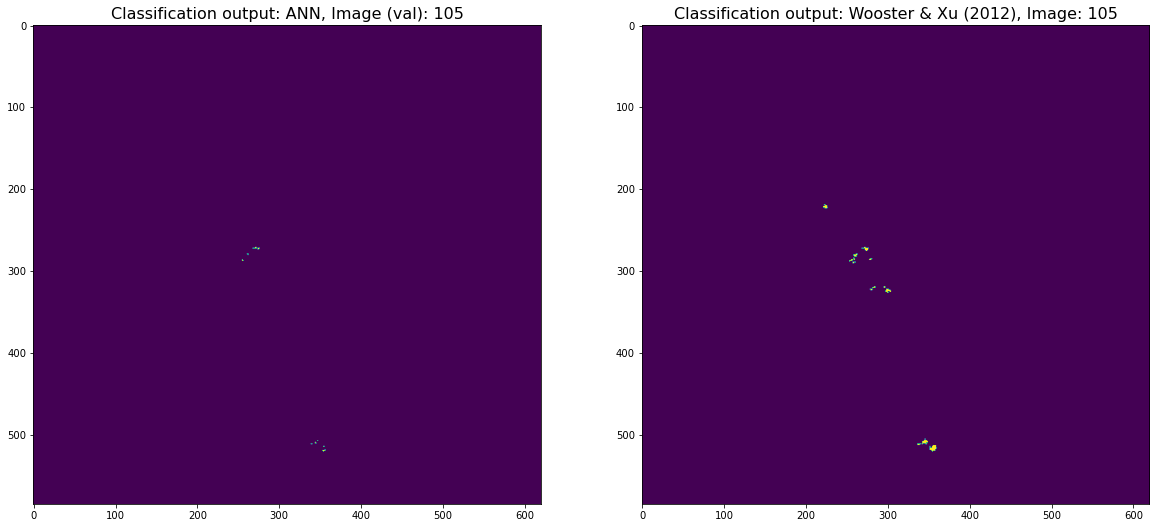

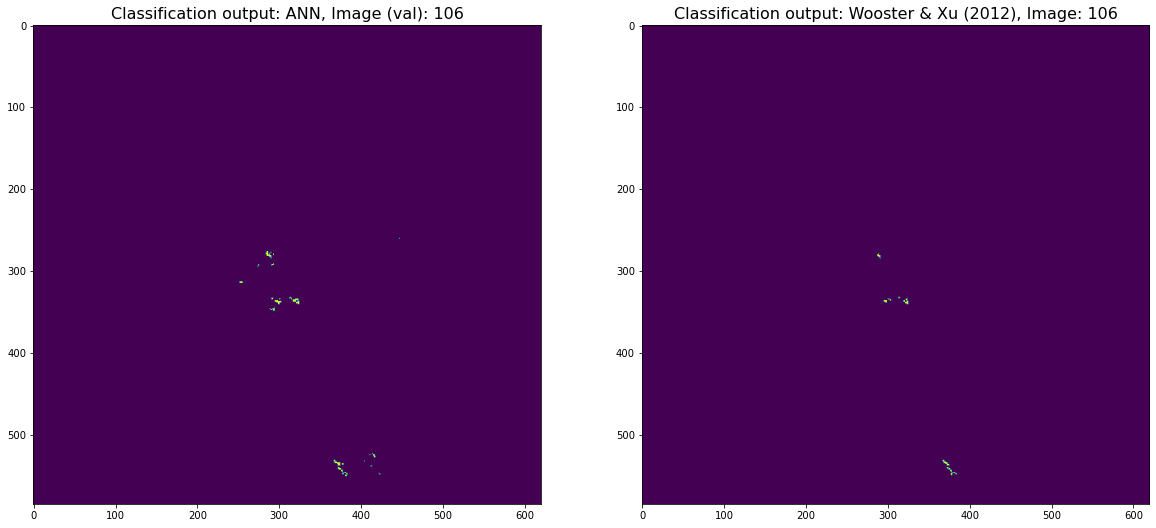

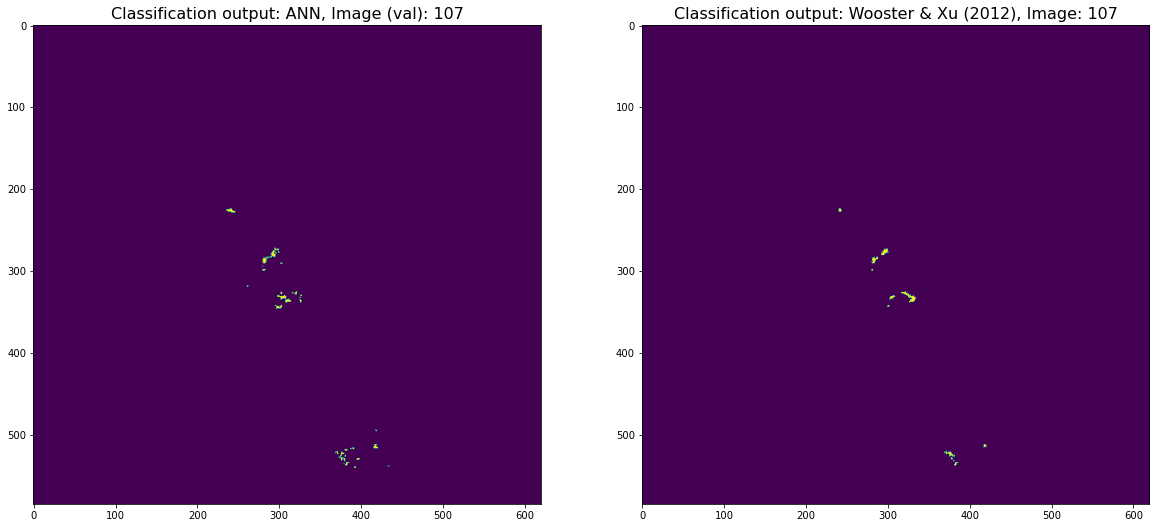

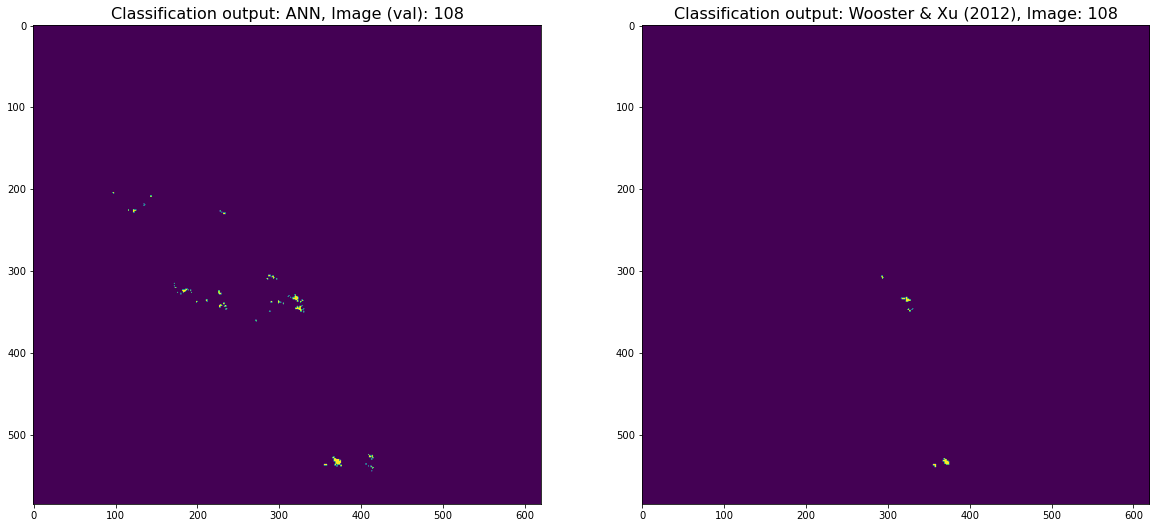

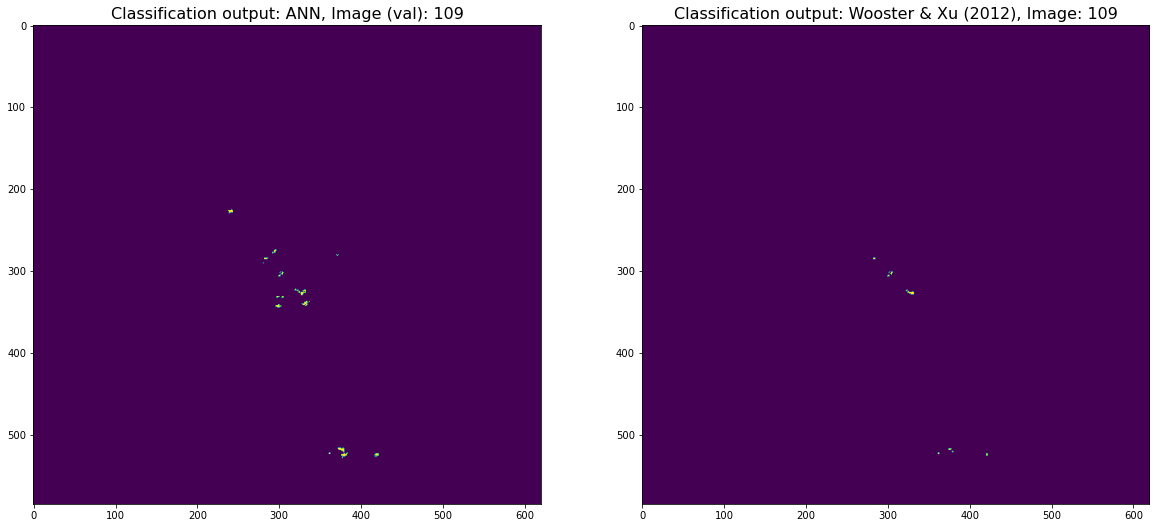

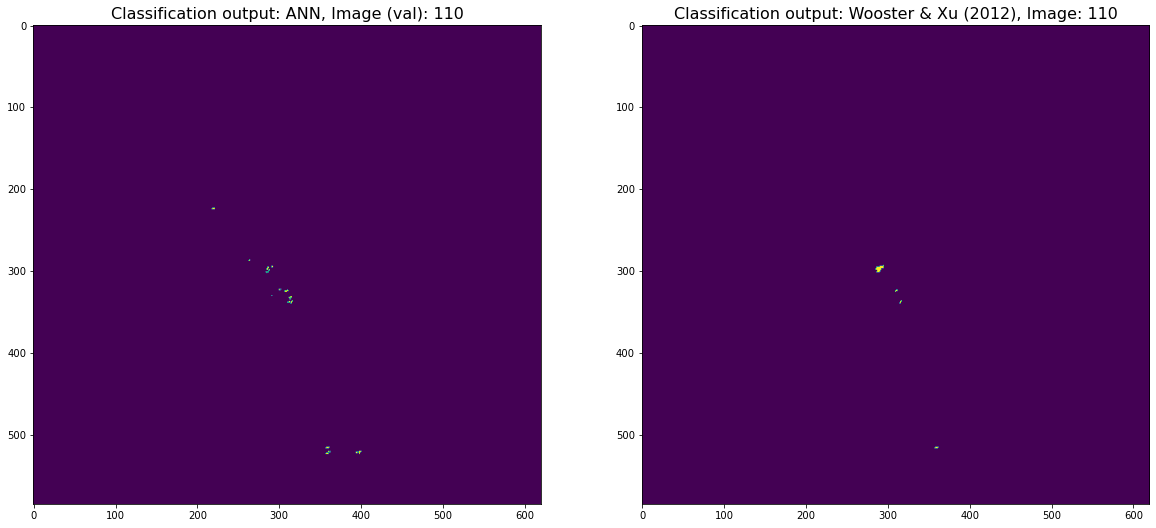

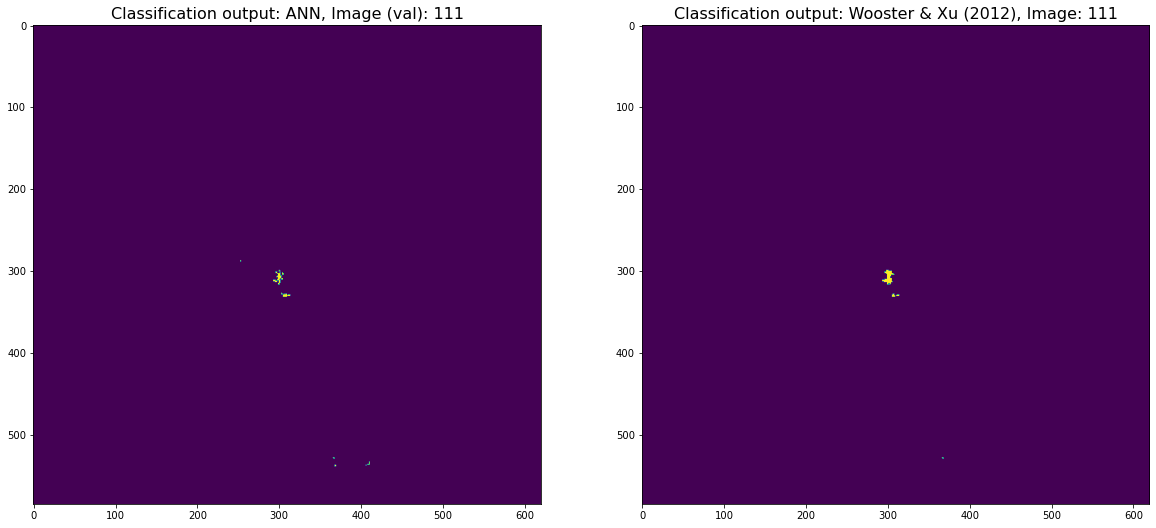

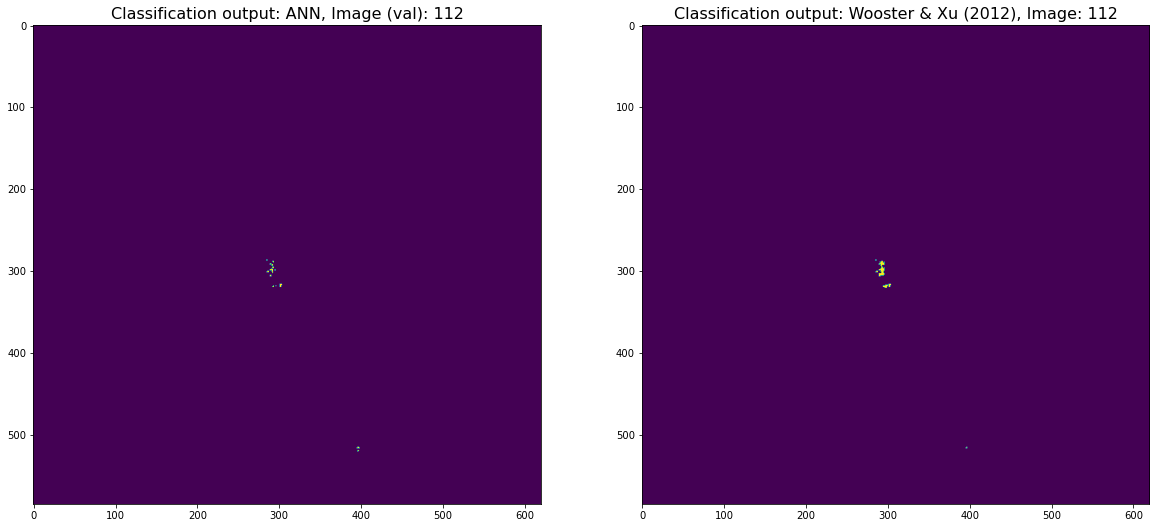

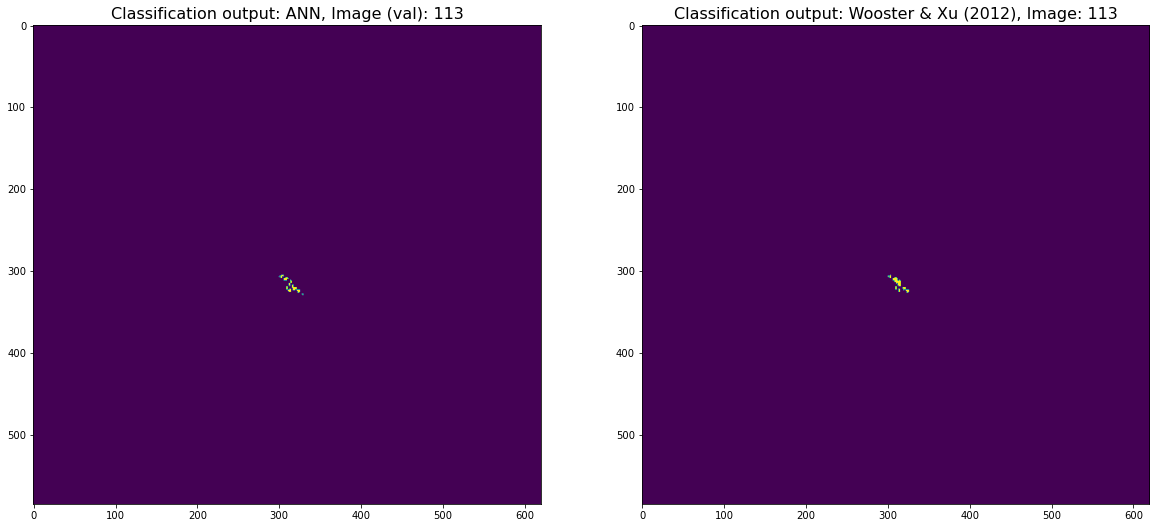

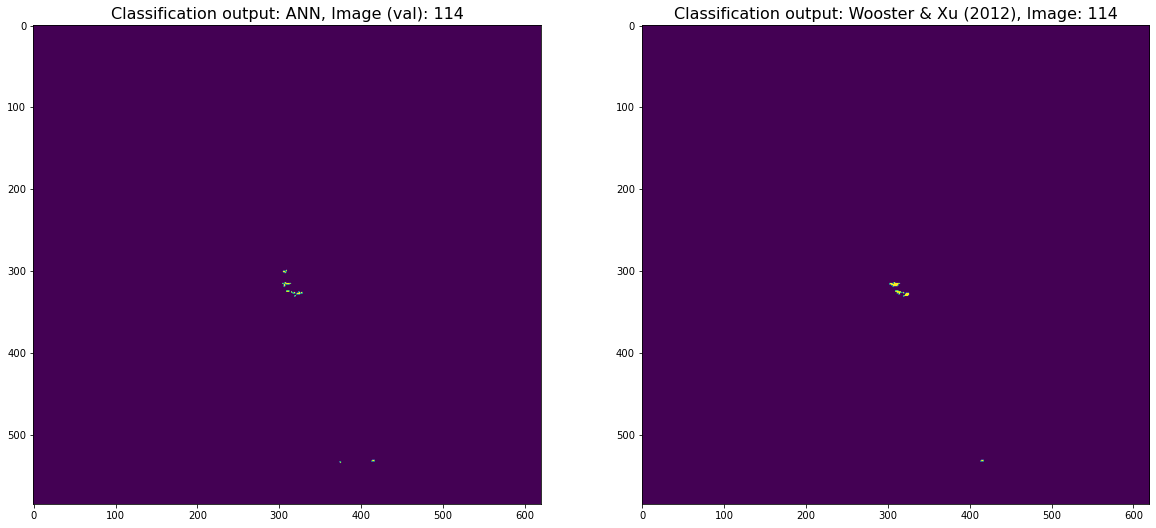

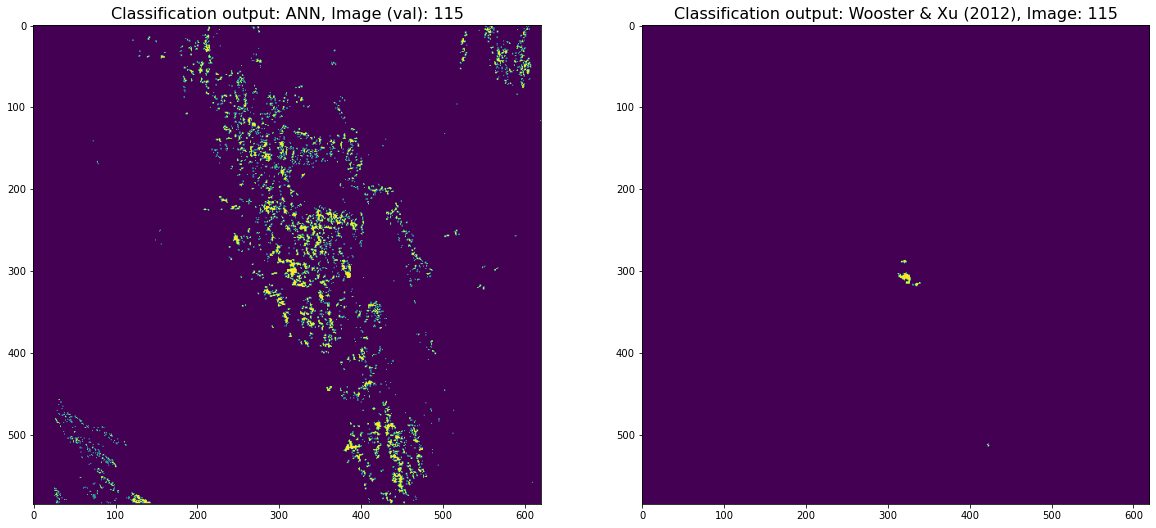

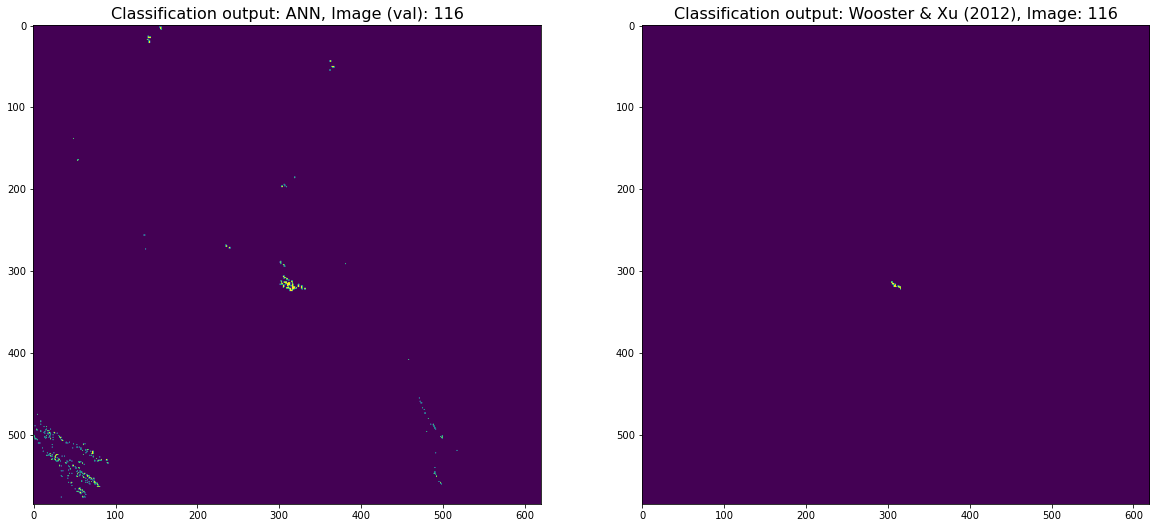

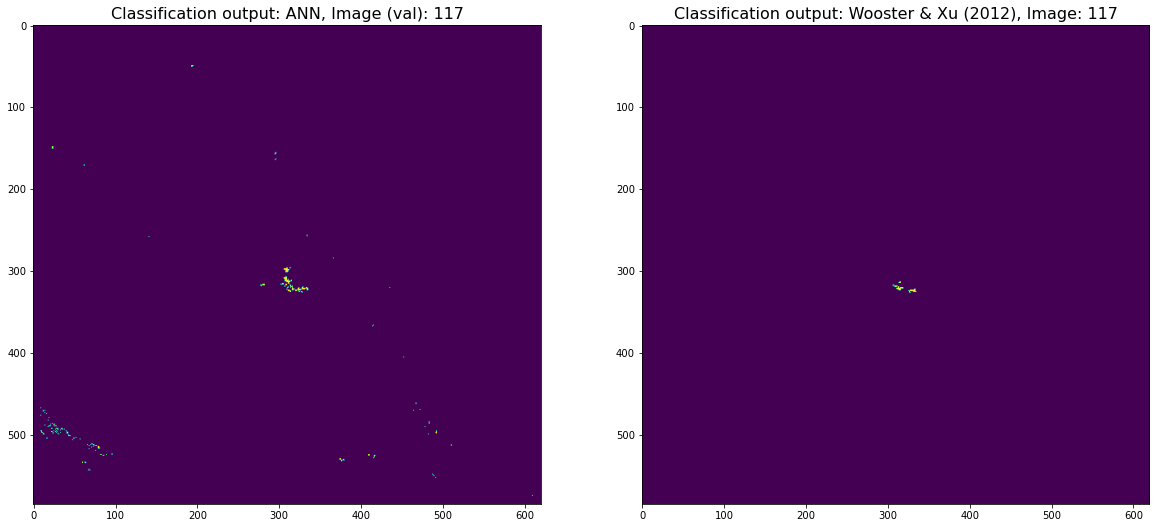

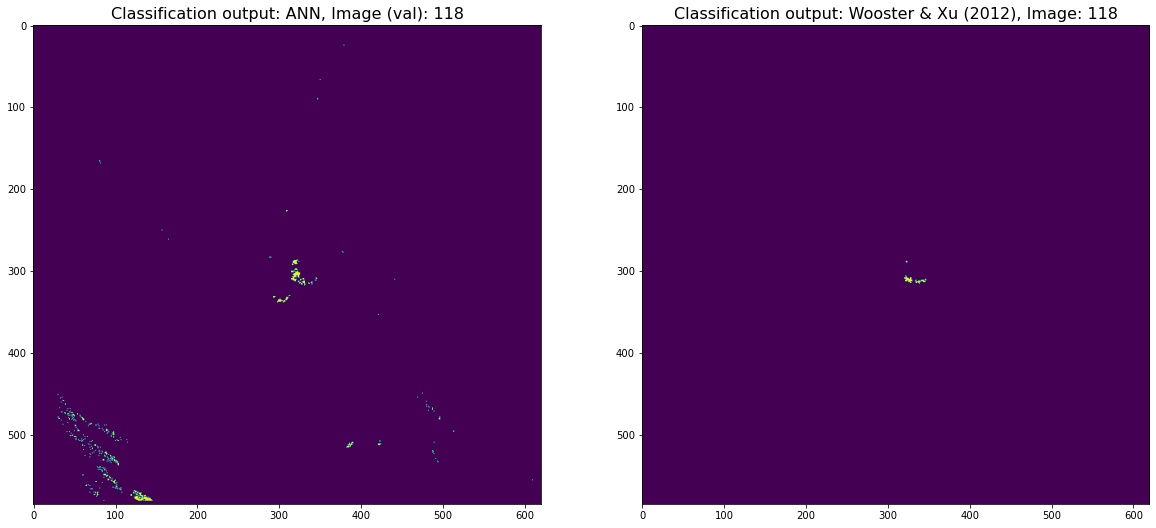

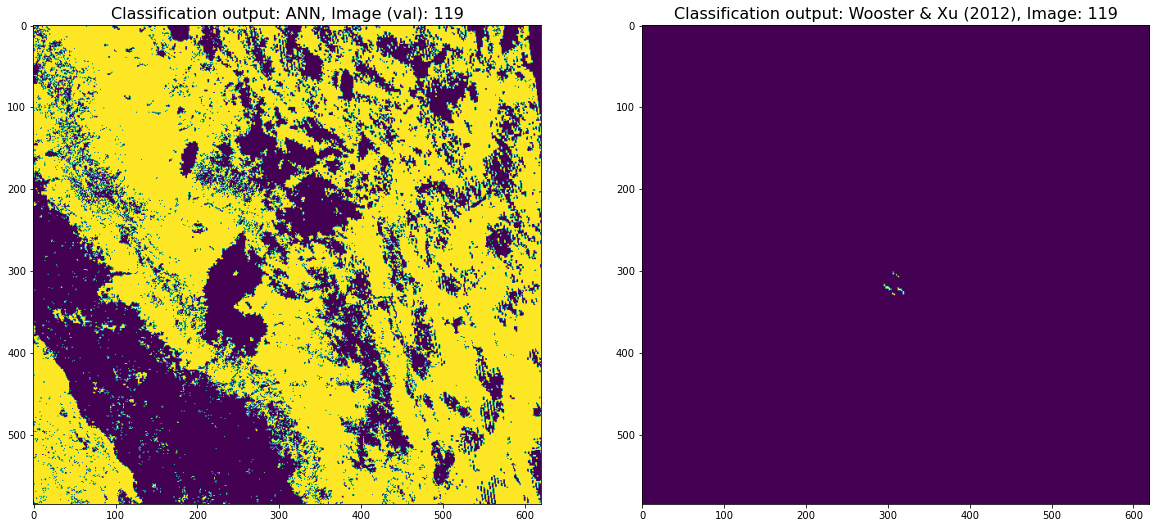

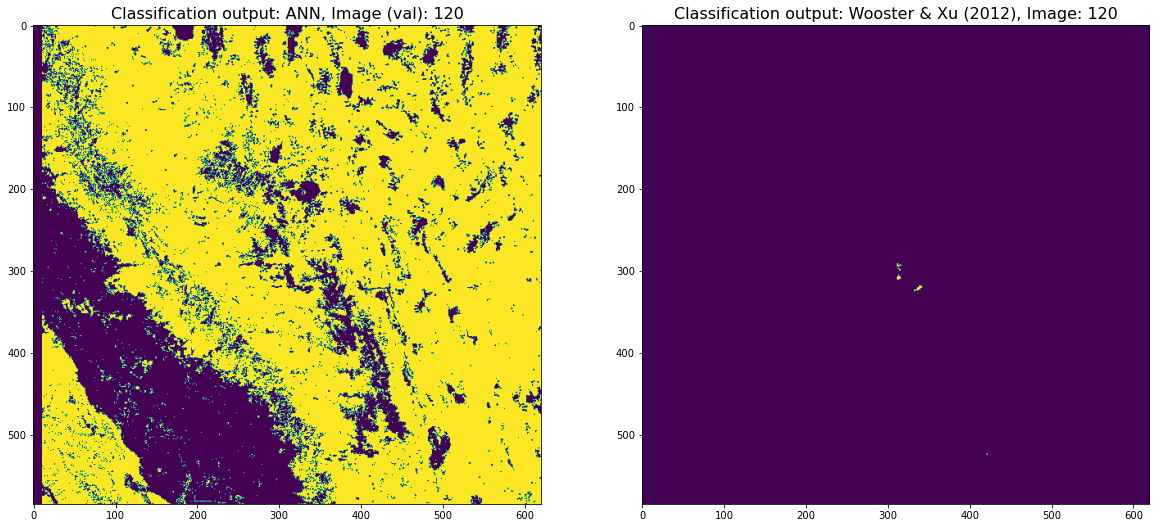

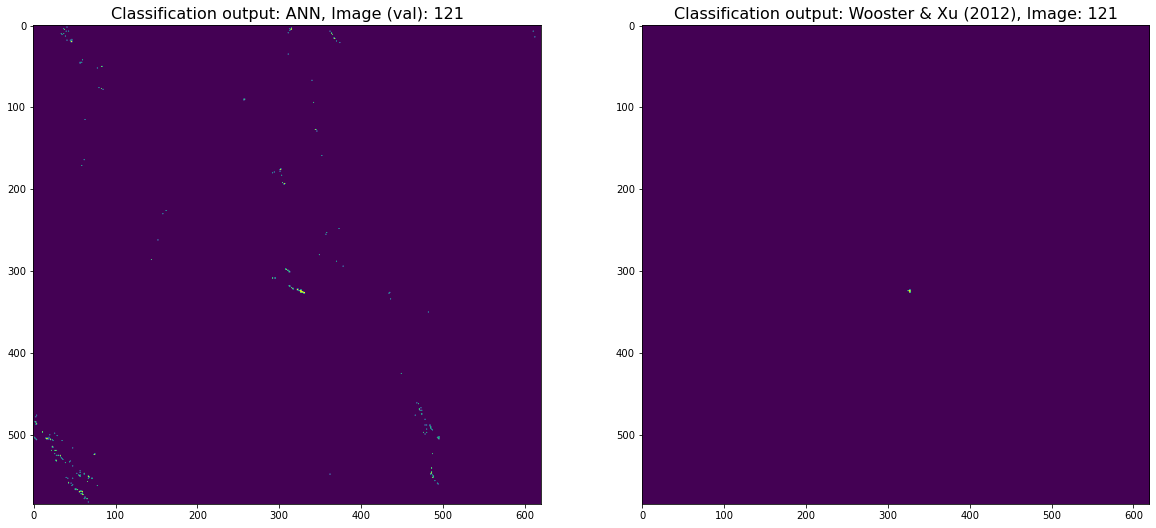

In [57]:
for img_n in range(len(predictions_all)):
    pred_raster = predictions_all[img_n].reshape(585, 620)
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].imshow(pred_raster)
    ax[0].grid(False)
    ax[0].set_title(f'Classification output: ANN, Image (val): {img_n}', fontsize=16)
    
    ax[1].imshow(labels[img_n].reshape(585, 620))
    ax[1].grid(False)
    ax[1].set_title(f'Classification output: Wooster & Xu (2012), Image: {img_n}', fontsize=16)
    
    plt.show()

### Extra: November
Also, November fires are added. Same method.

In [60]:
nov_stack_dir = r"C:\Users\yng3d\Desktop\S3_September\Nov_stack.tif"

nov_stack = load_satrstr(nov_stack_dir)
print(nov_stack.shape)
# Extracción de labels de stack de noviembre
lbl_index = []
for i in range(58):
    ind = 4+i*5
    lbl_index.append(ind)
labels_nov = nov_stack[lbl_index]

(290, 585, 620)


In [61]:
# Eliminación de labels de stack de noviembre
nov_x = np.delete(nov_stack, lbl_index, 0)
print(nov_x.shape)

(232, 585, 620)


In [62]:
# Eliminación de valores nans
nov_x[np.isnan(nov_x)] = 0

In [63]:
nov_x.shape

(232, 585, 620)

In [64]:
# Reshape de arreglo por escena
nov_x = nov_x.reshape(58, 4, 585, 620)
print(nov_x.shape)

(58, 4, 585, 620)


In [65]:
for i in range(58):
    for j in range (4):
        nov_x[i,j] = nov_x[i,j] / nov_x[:,j].max()

In [66]:
nov_x = nov_x.reshape(58, 4, 362700)

#### November predictions

In [67]:
predictions_nov = []
for i in range(58):
    test_img = nov_x[i,:,:].T
    pred_i = model.predict_classes(test_img)
    predictions_nov.append(pred_i)
len(predictions_nov)

58

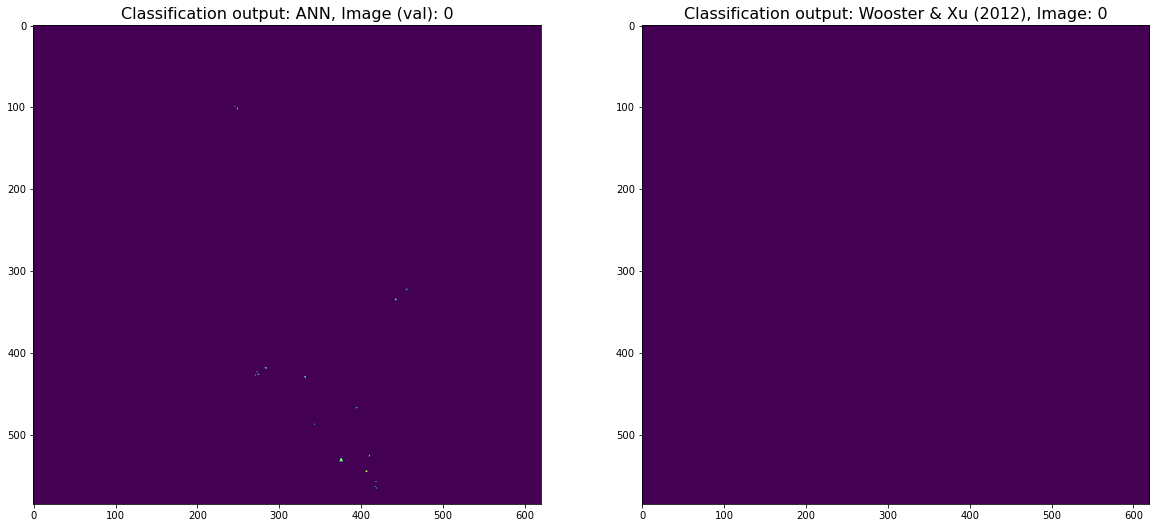

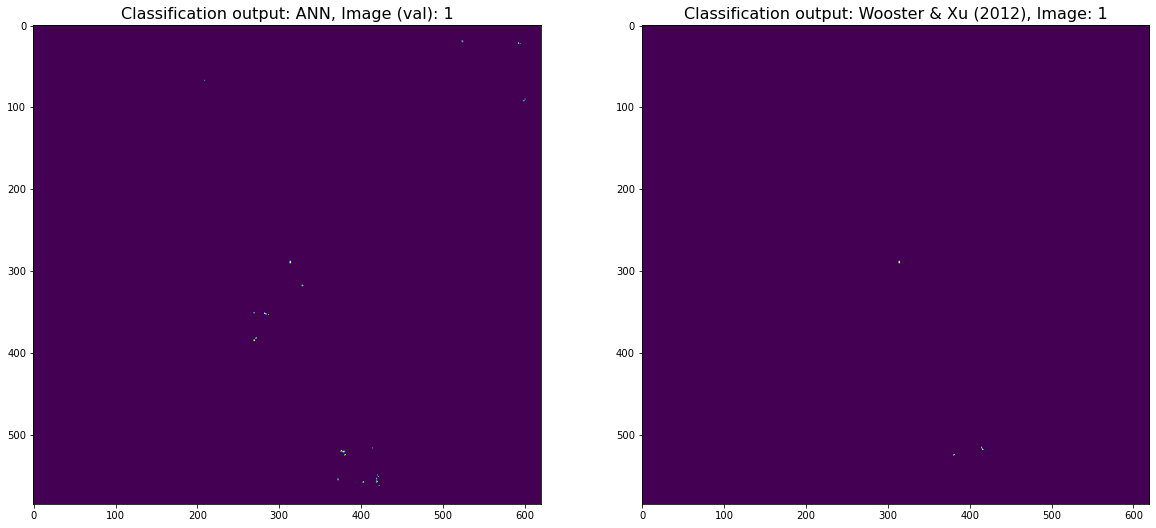

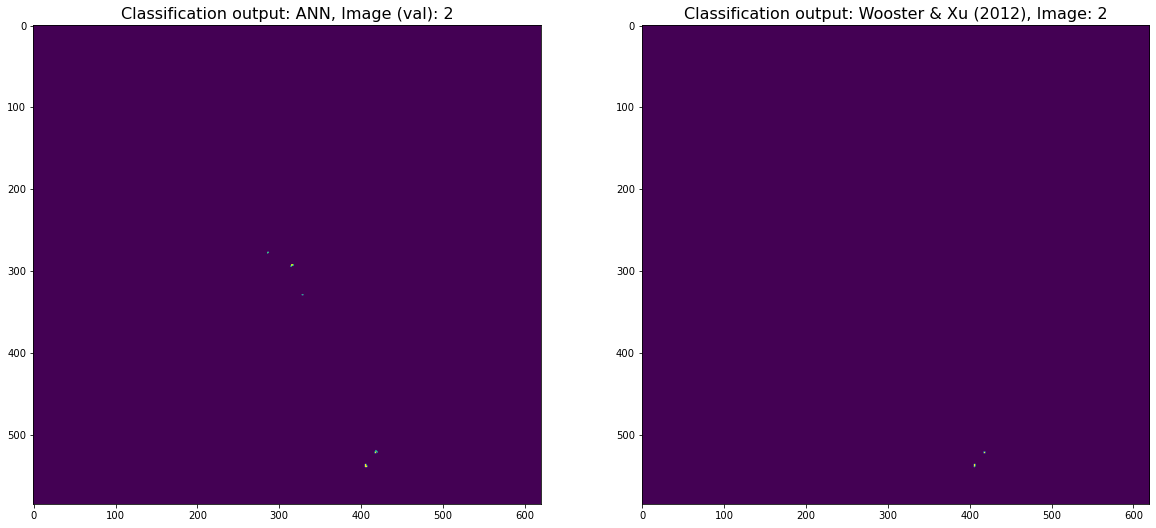

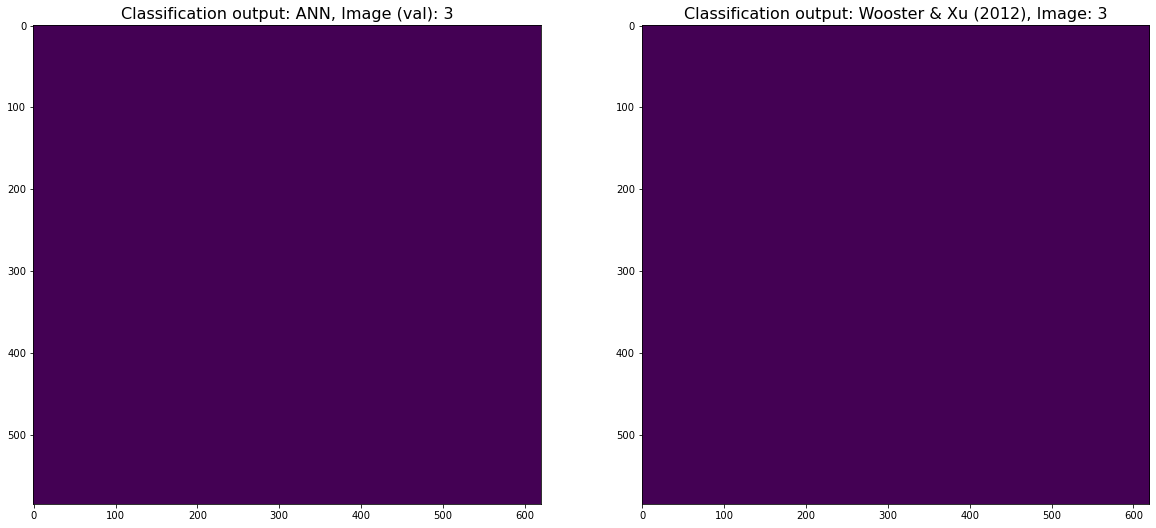

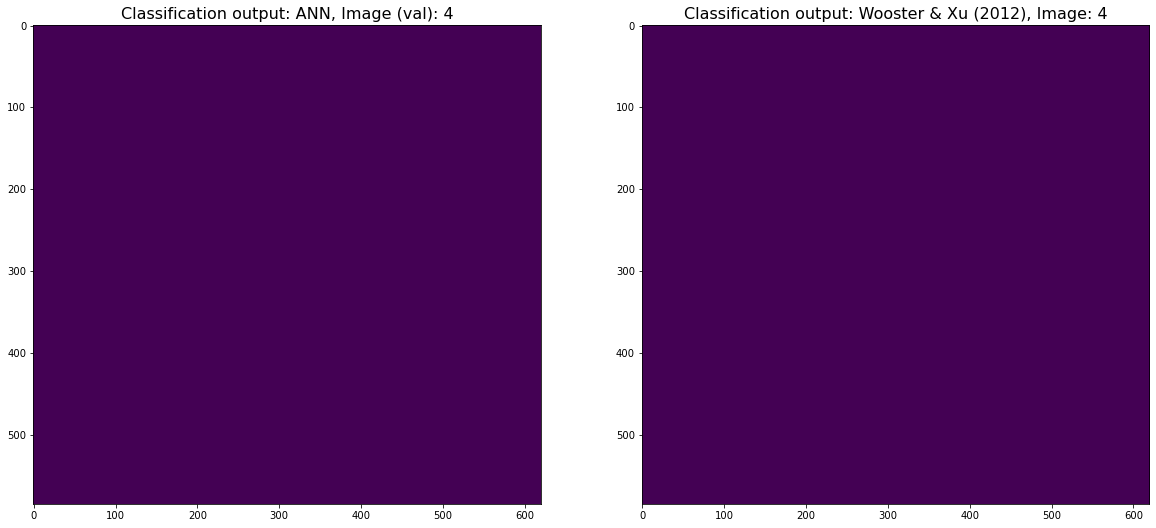

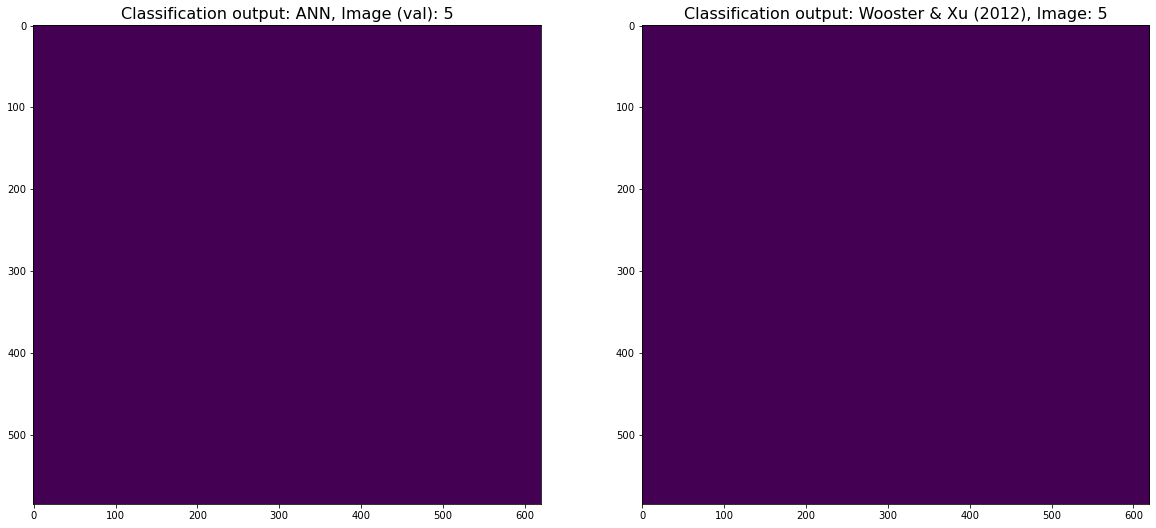

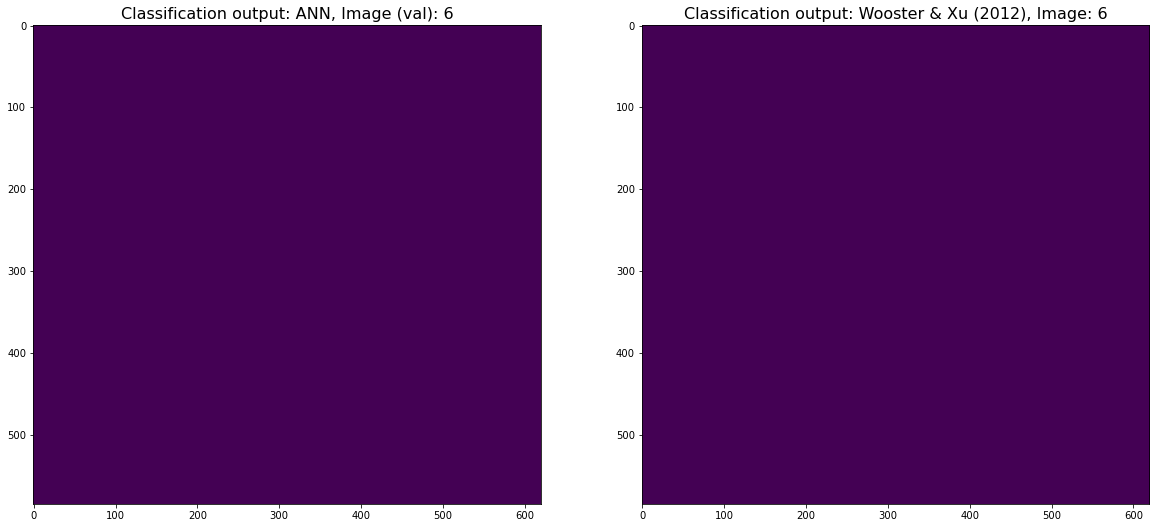

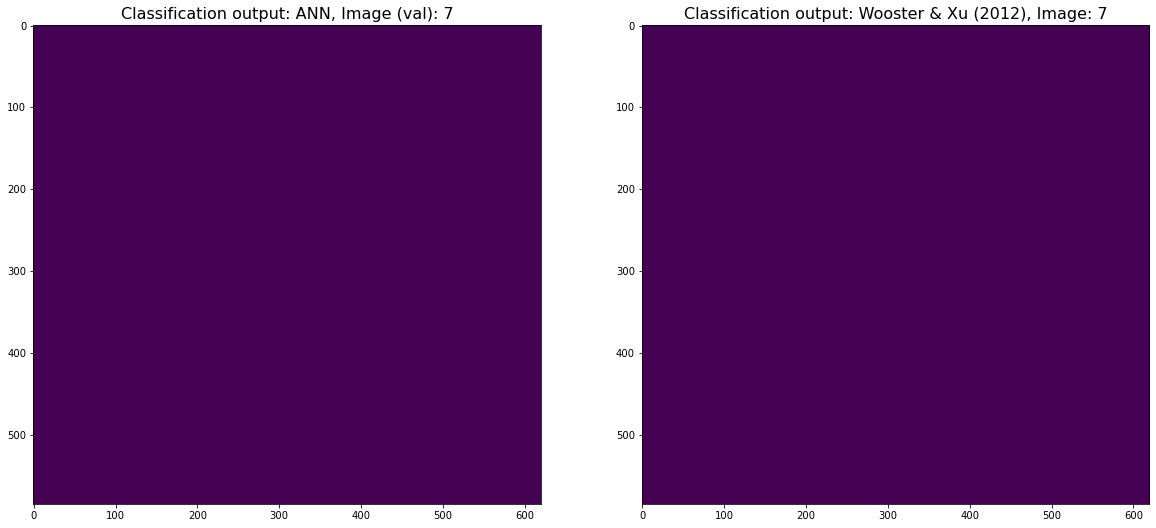

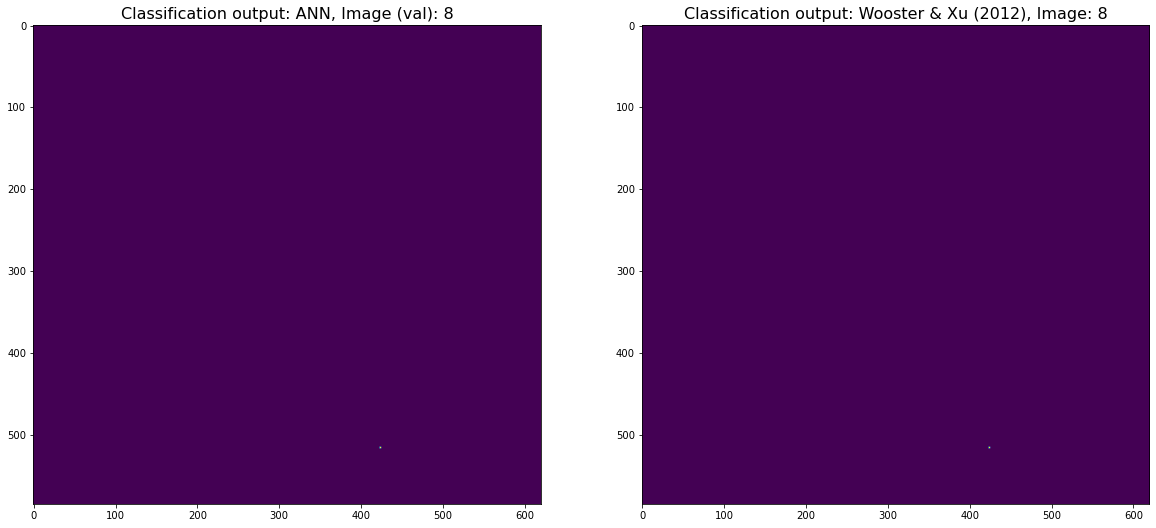

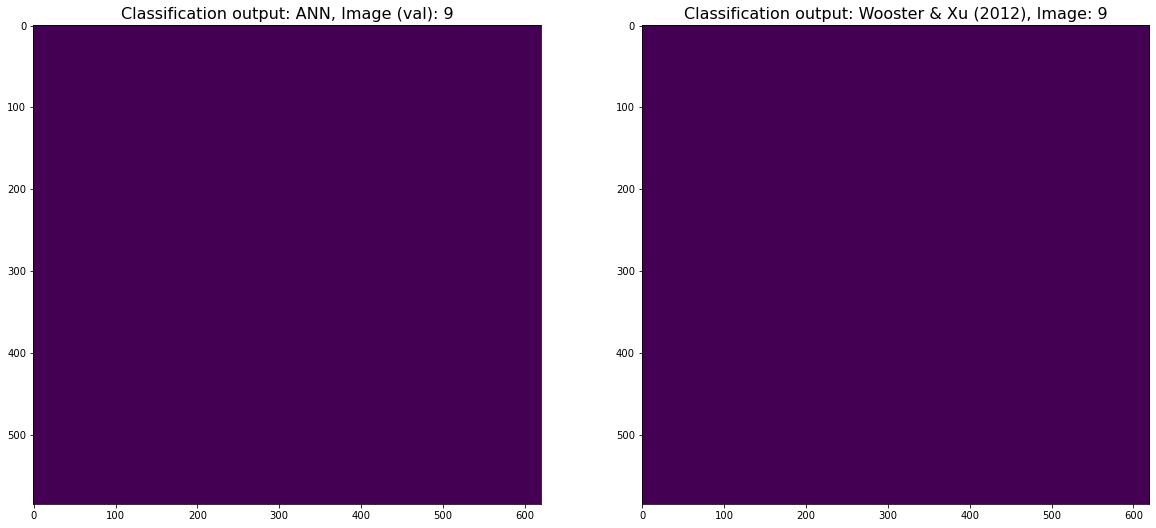

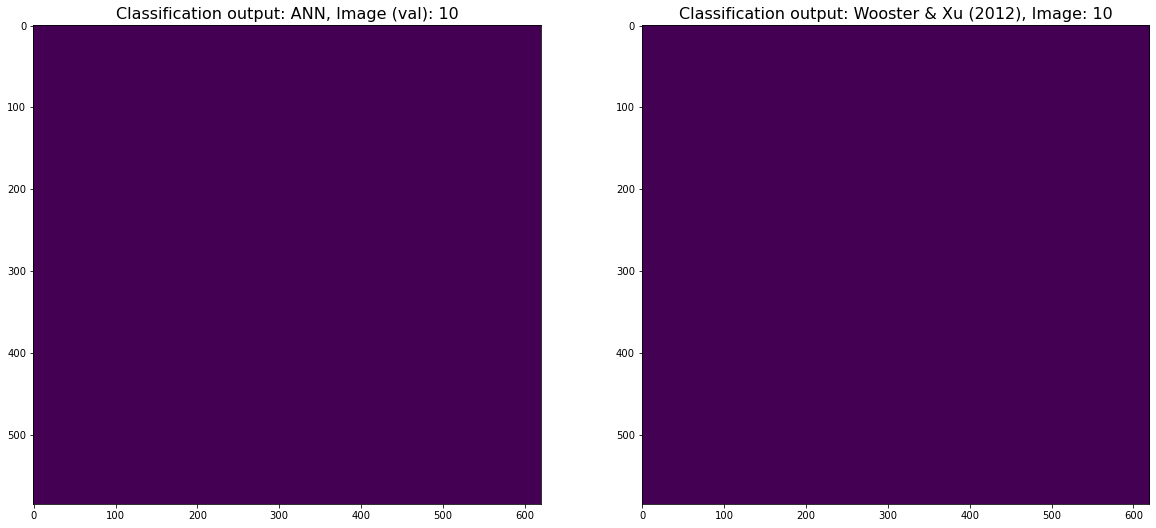

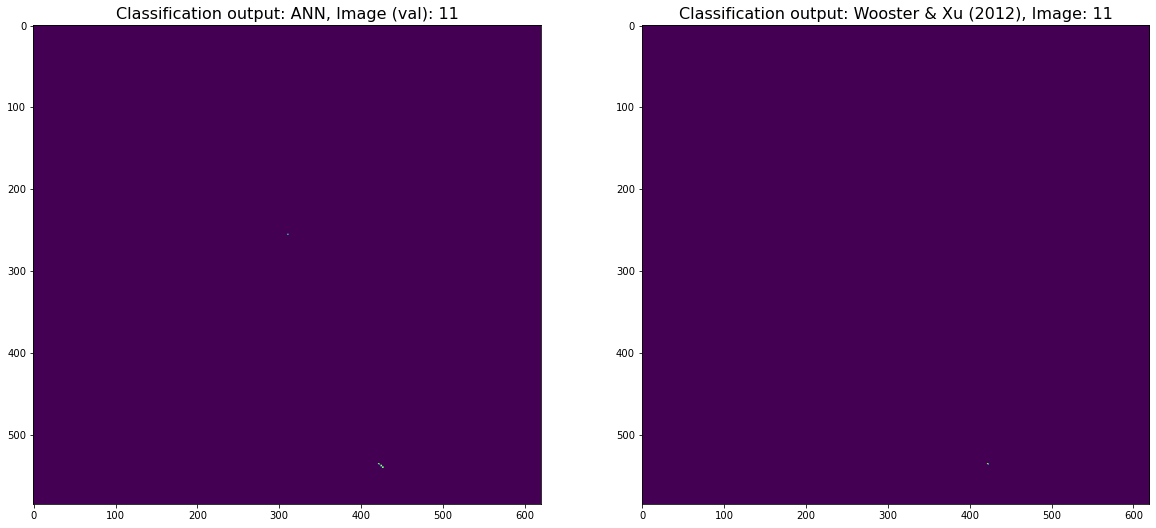

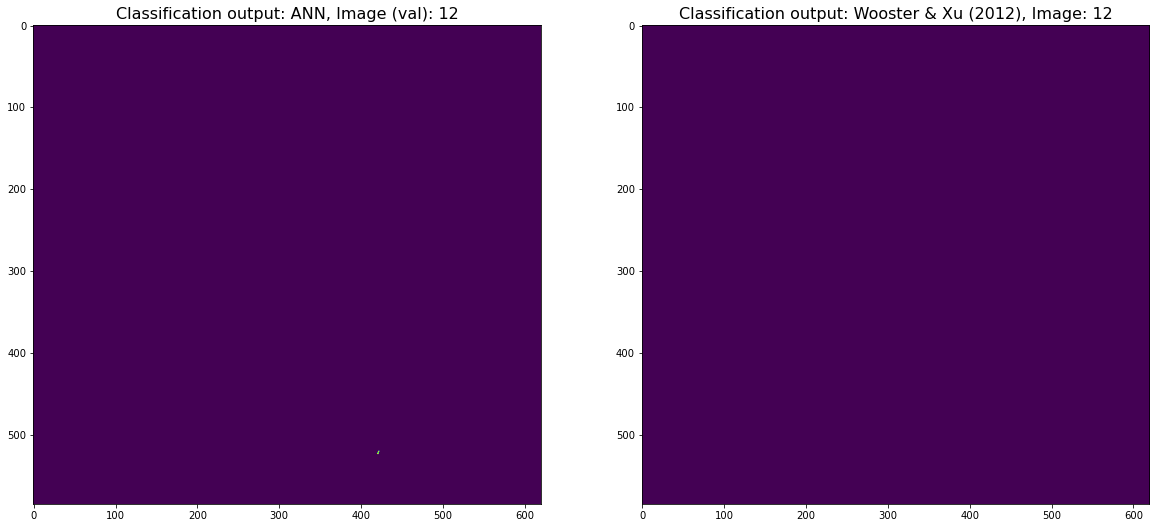

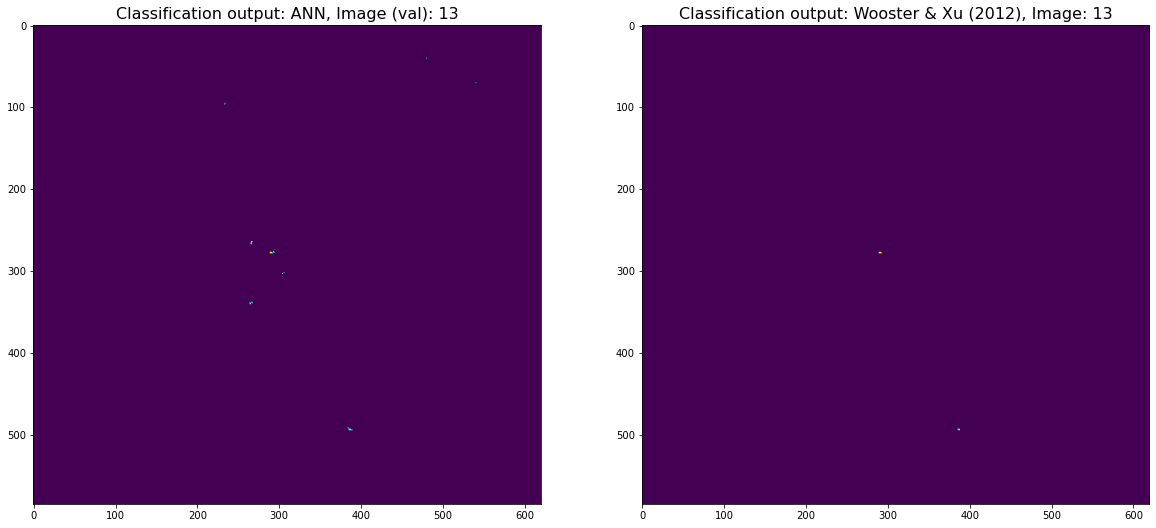

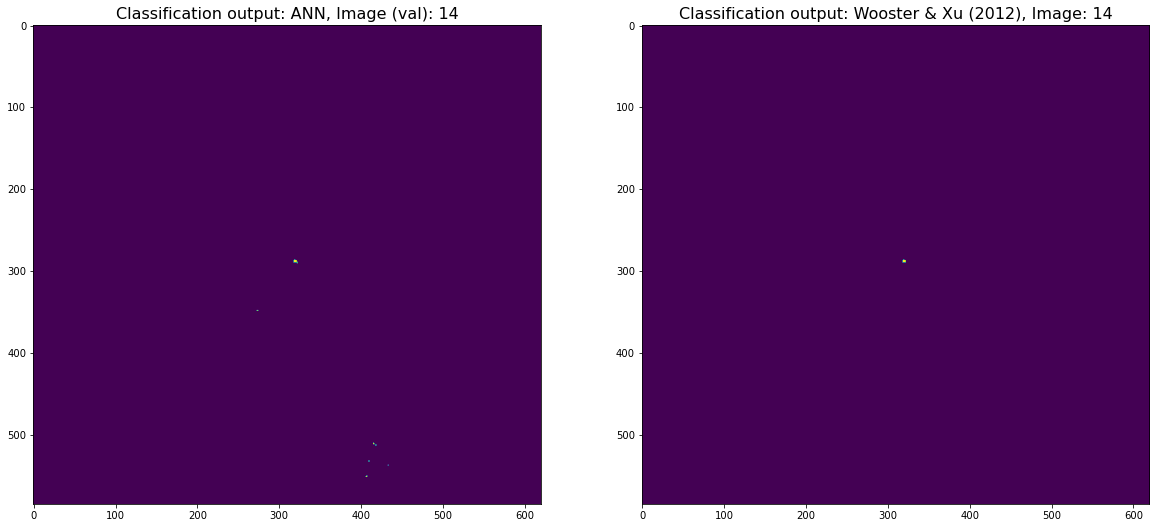

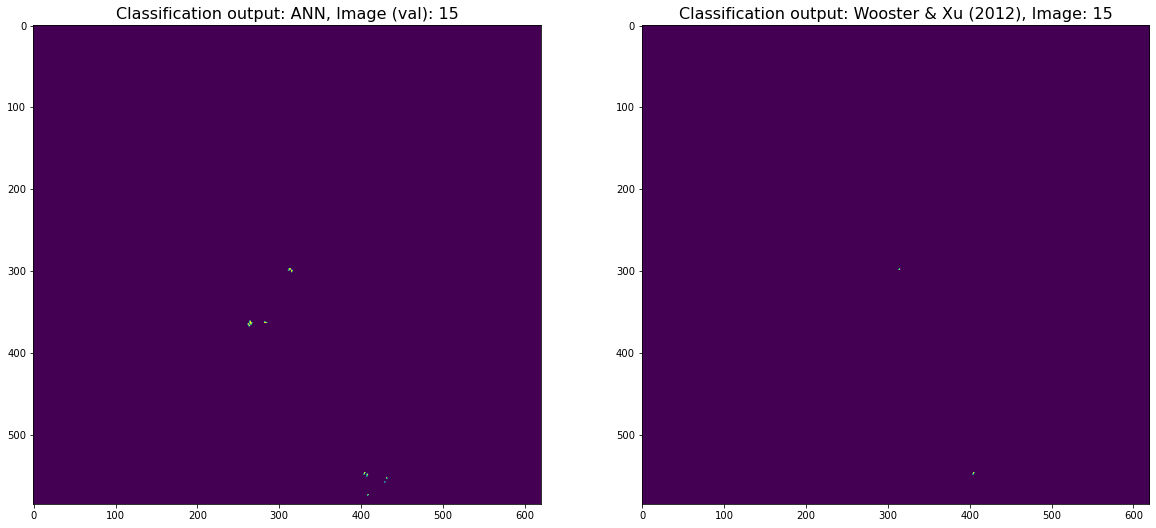

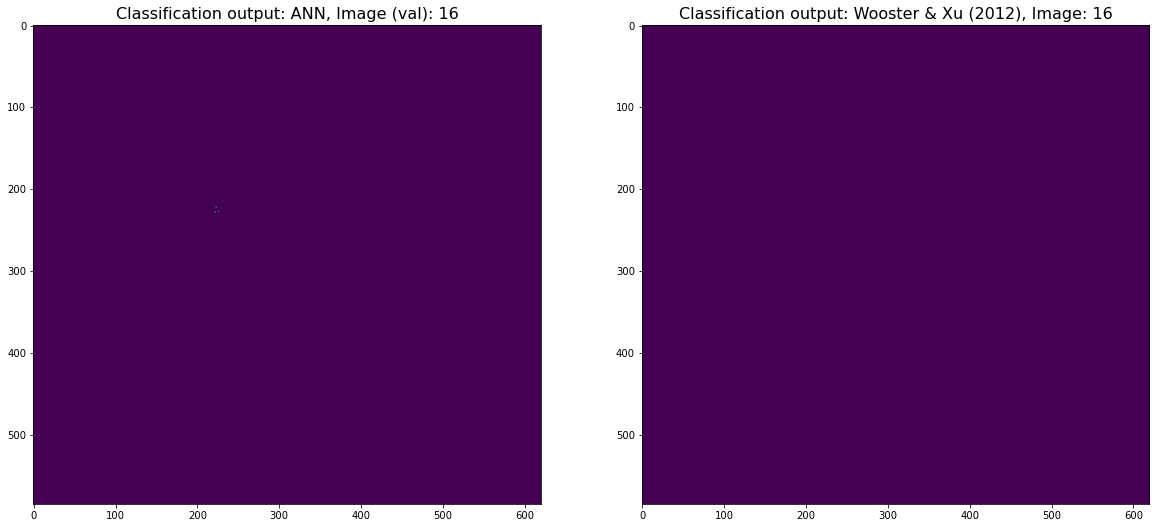

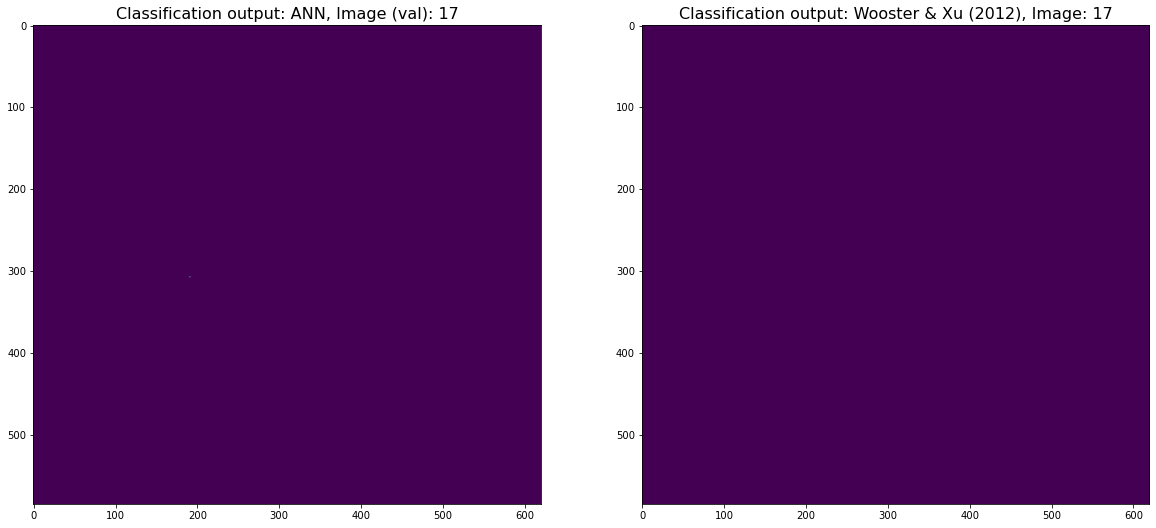

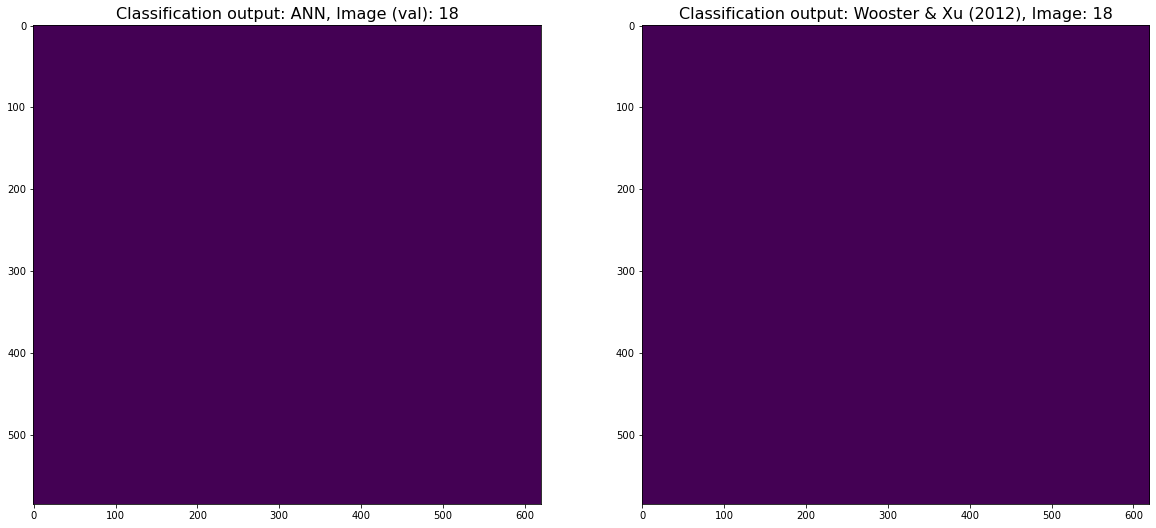

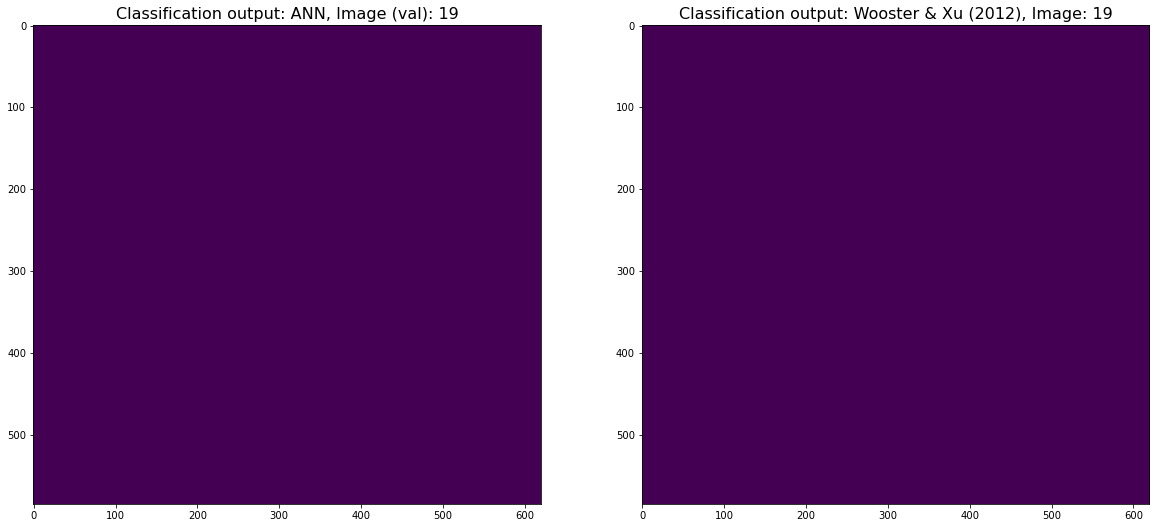

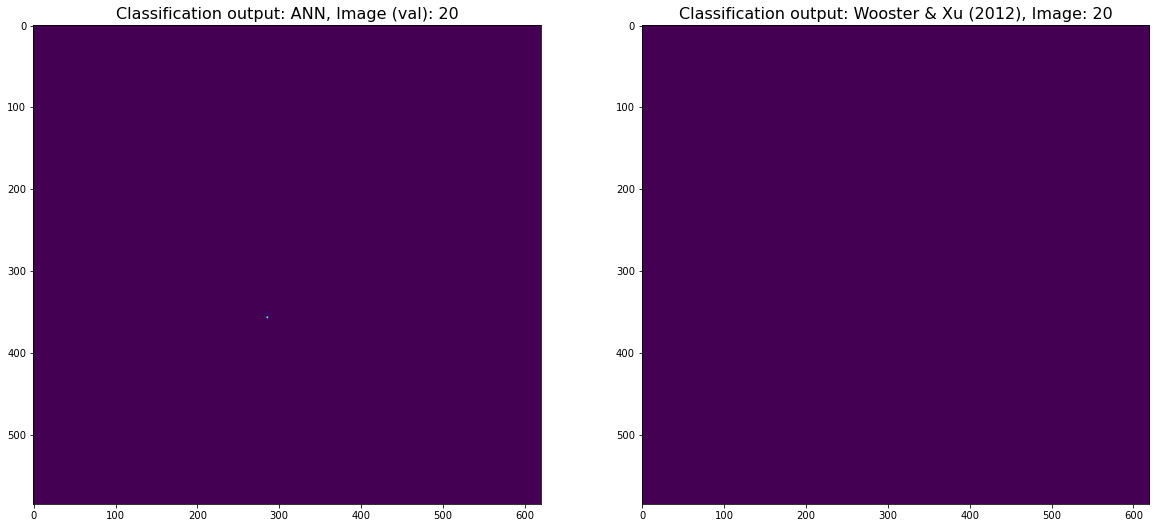

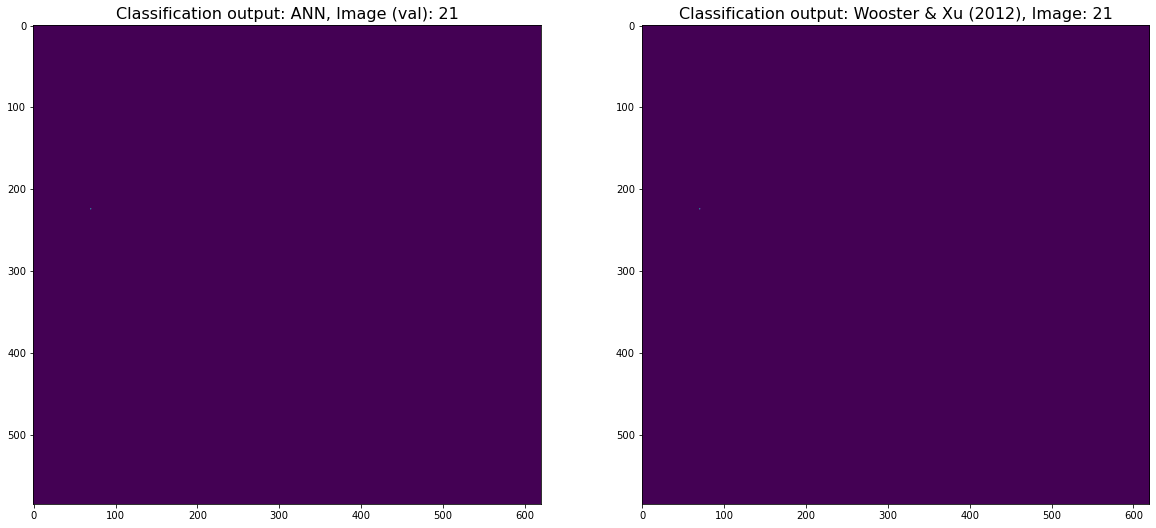

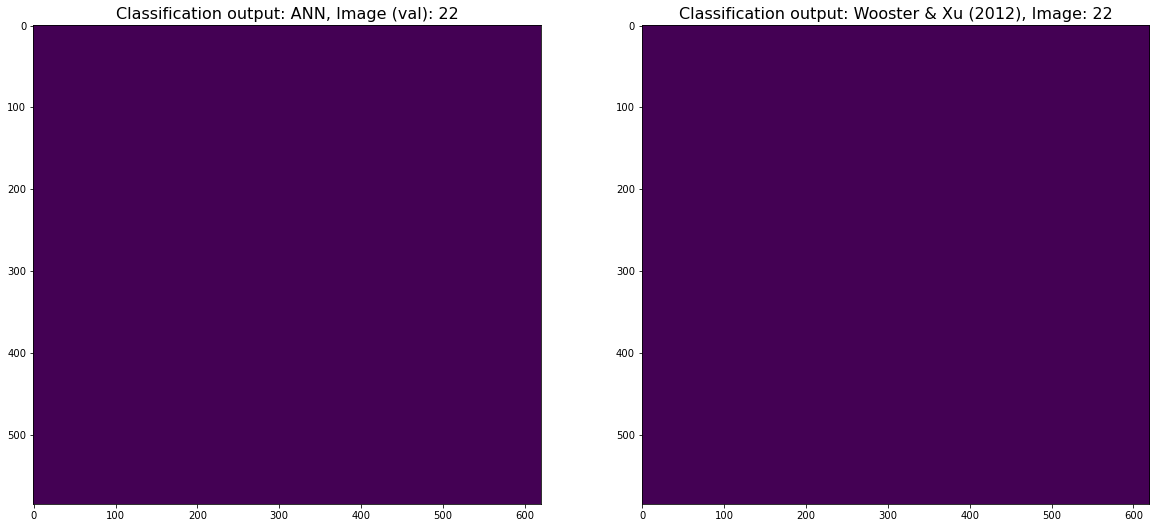

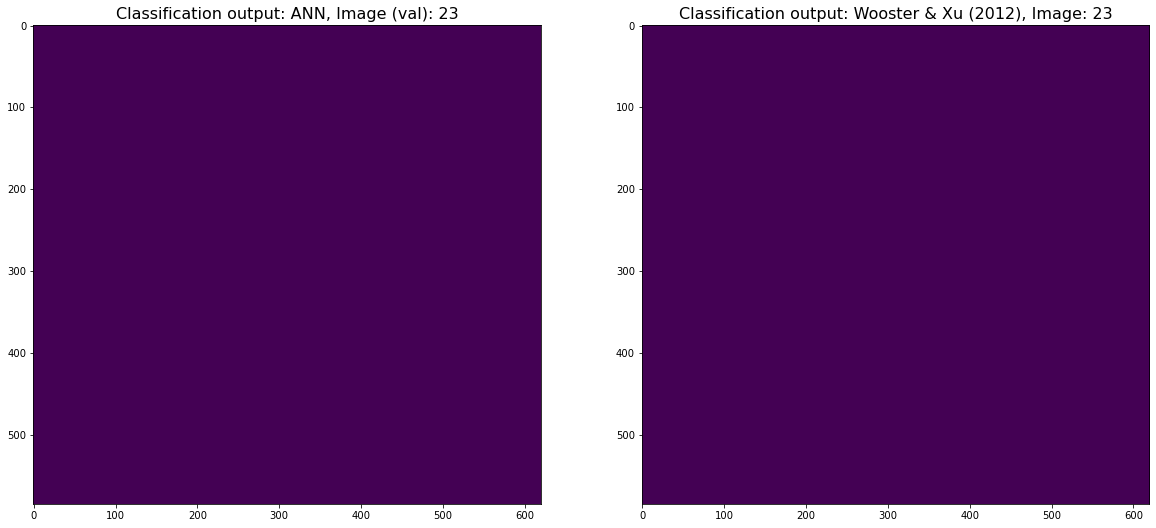

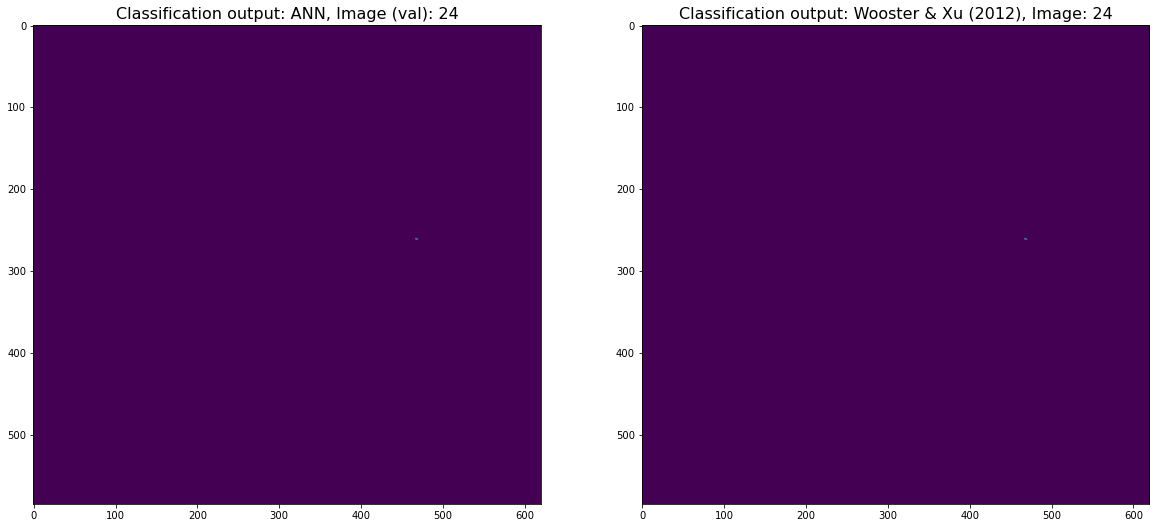

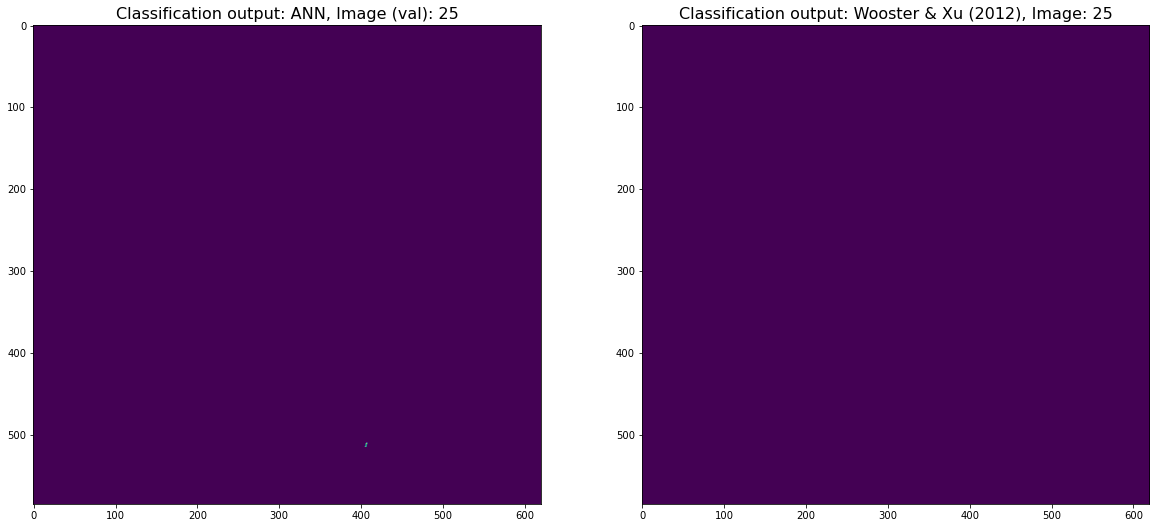

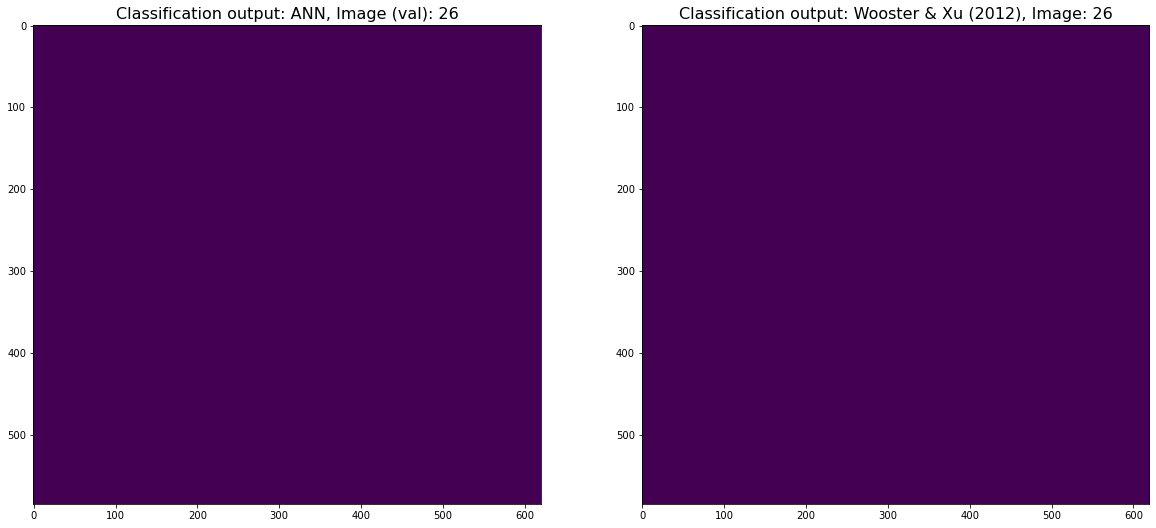

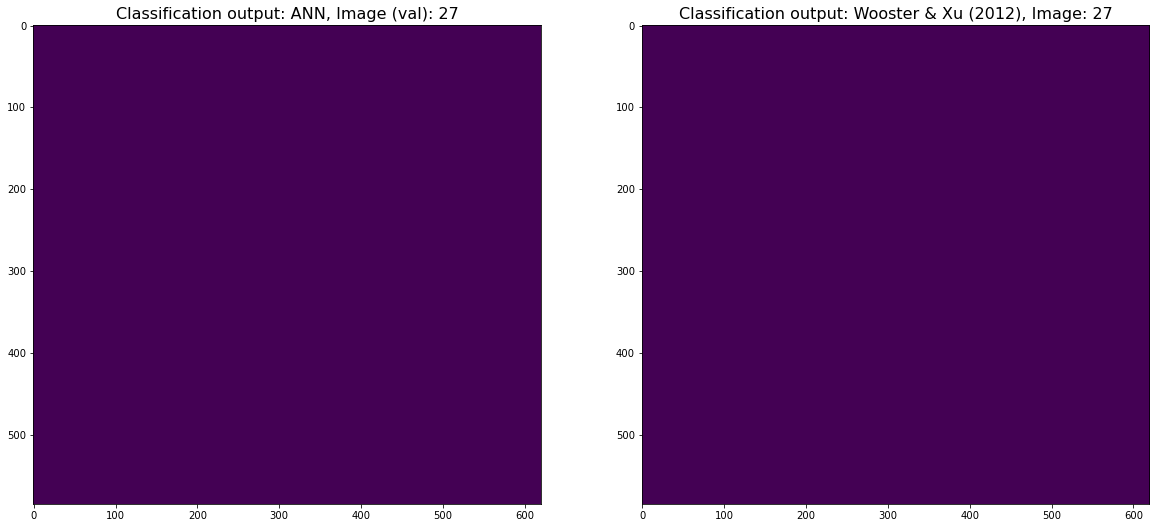

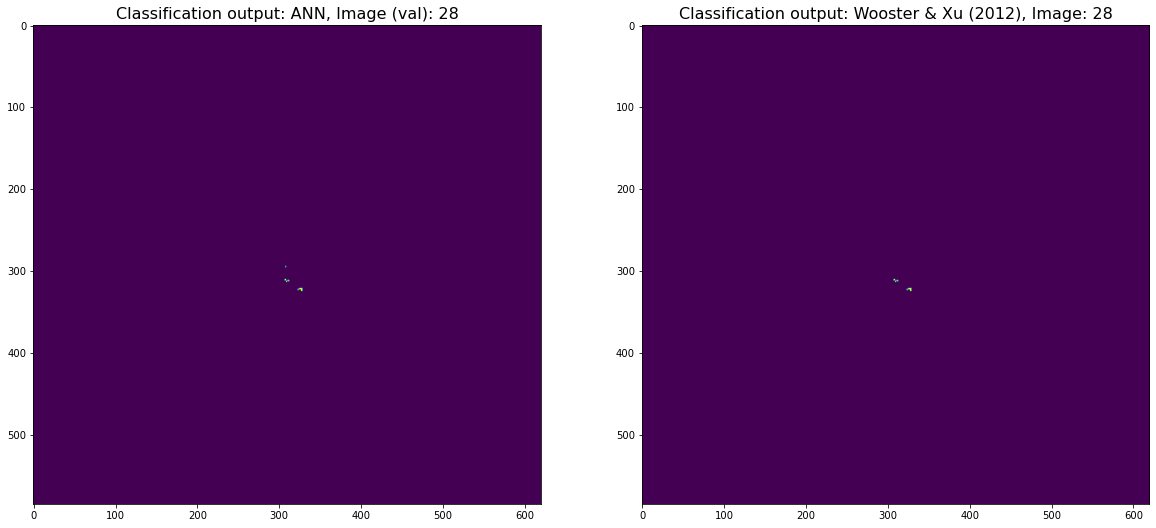

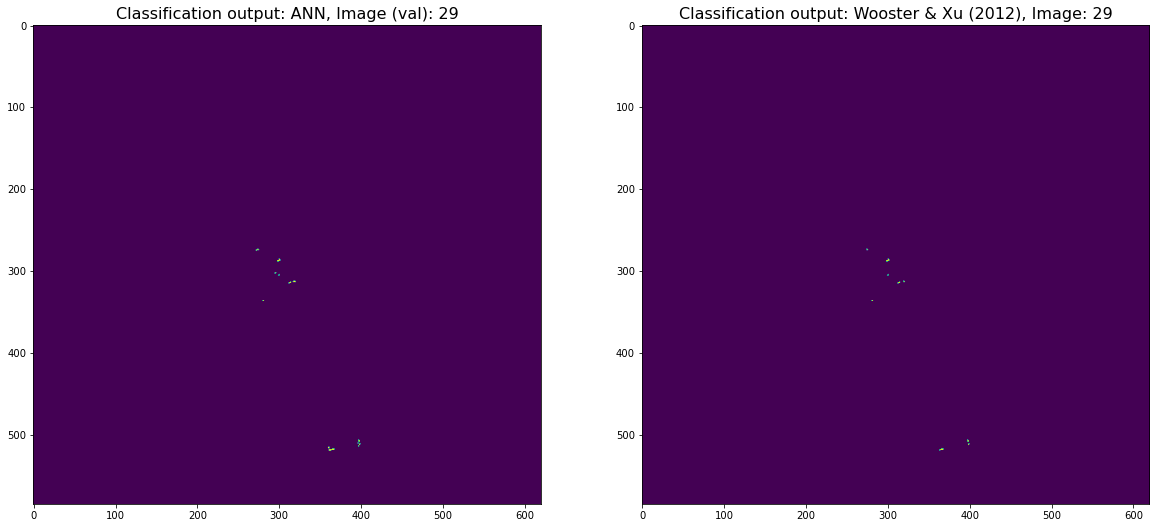

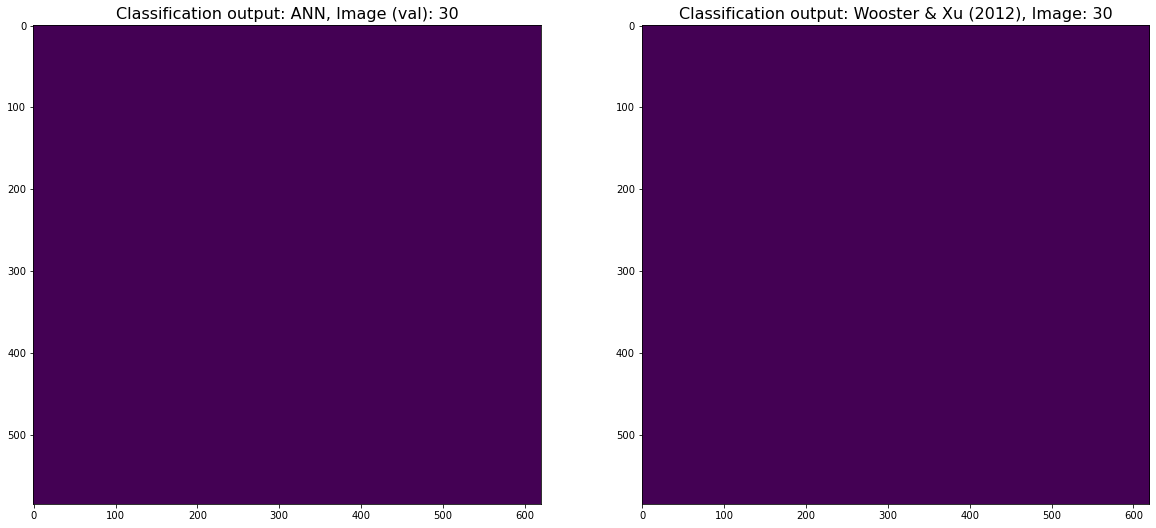

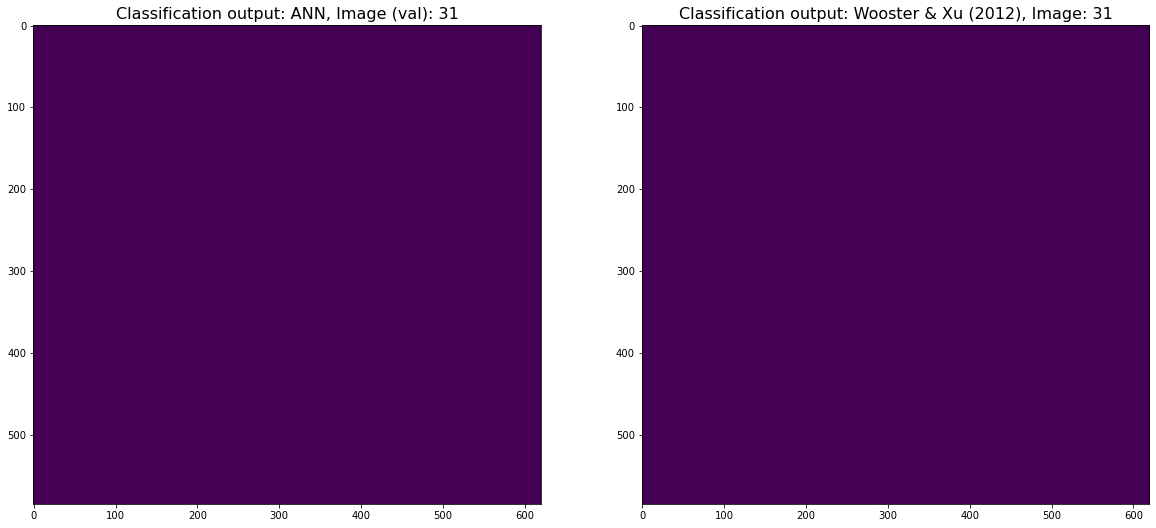

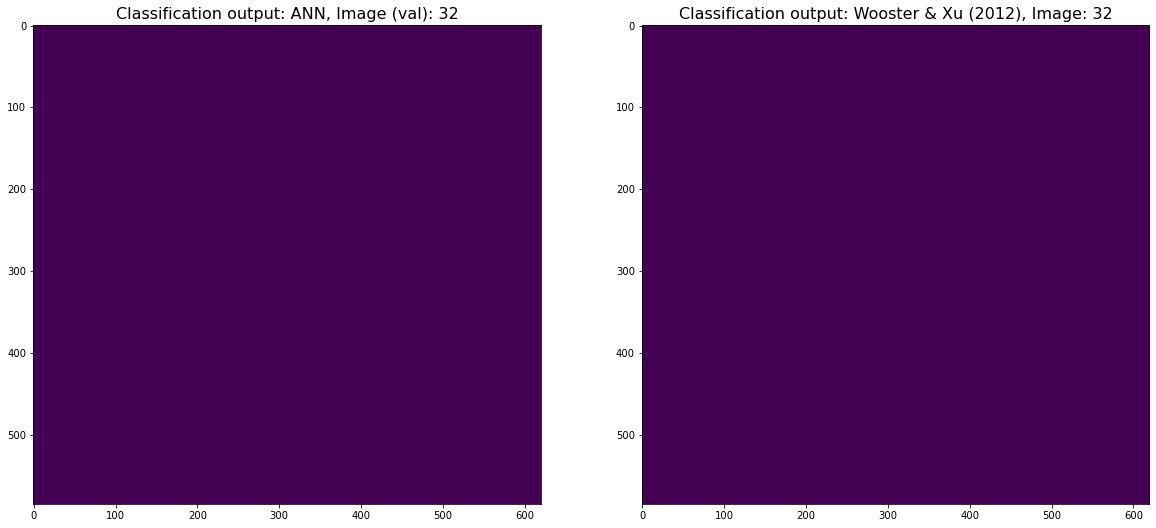

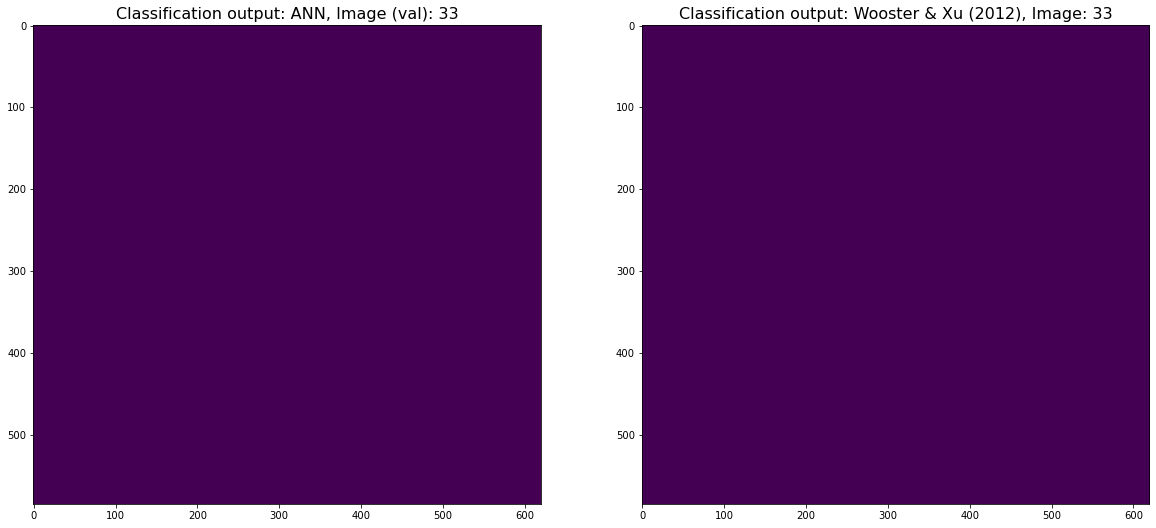

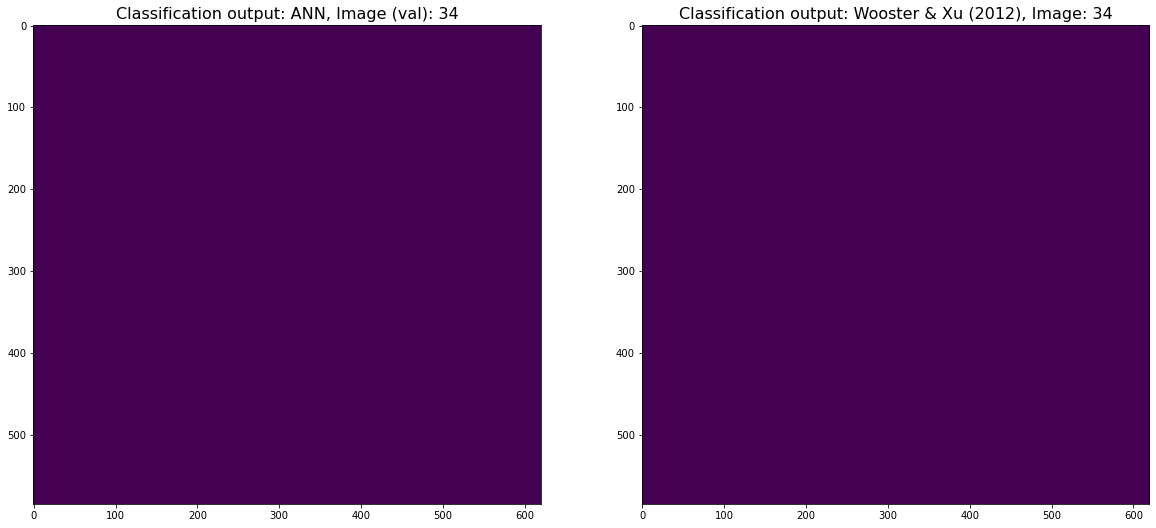

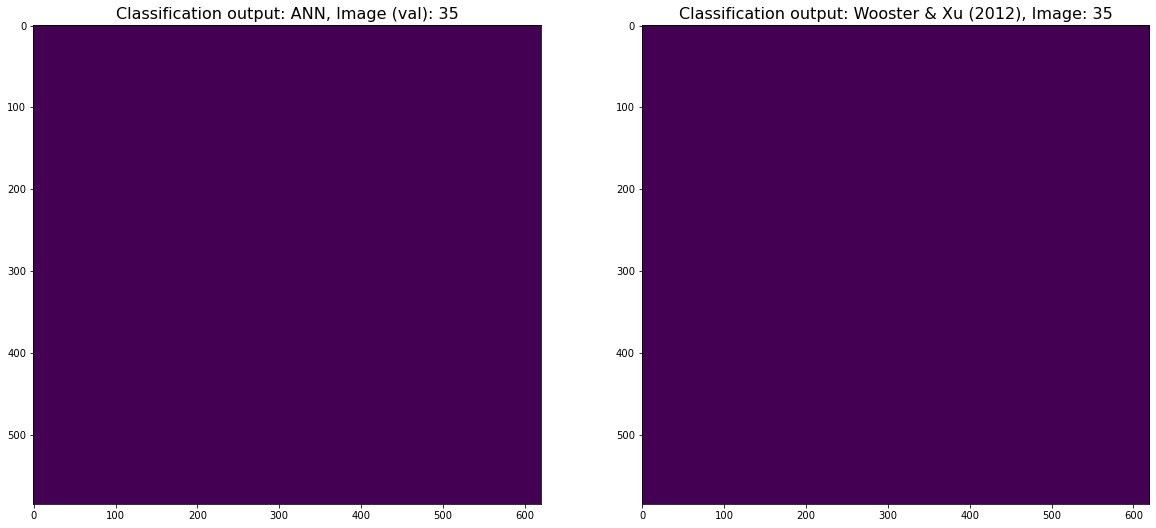

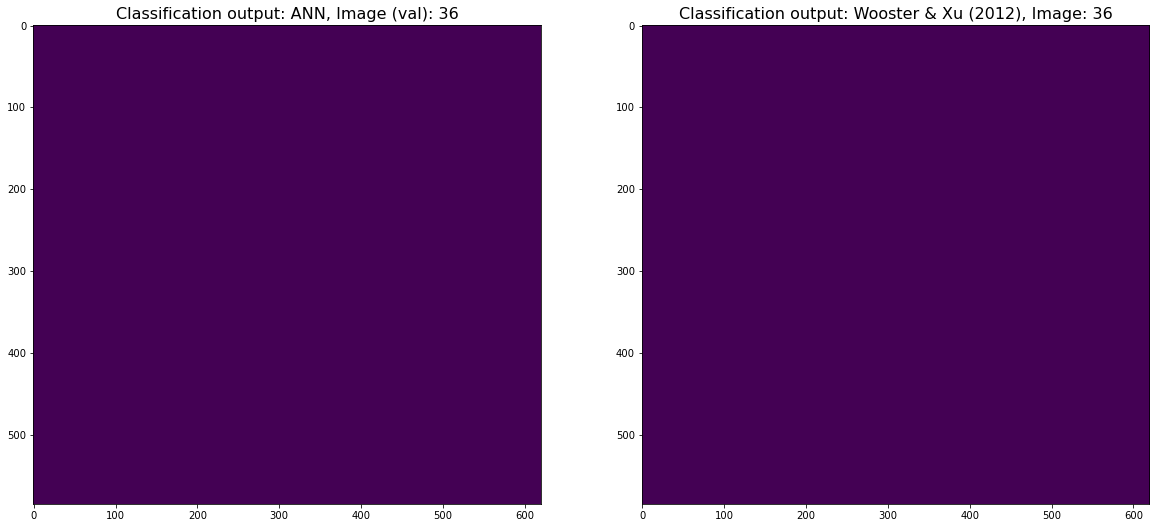

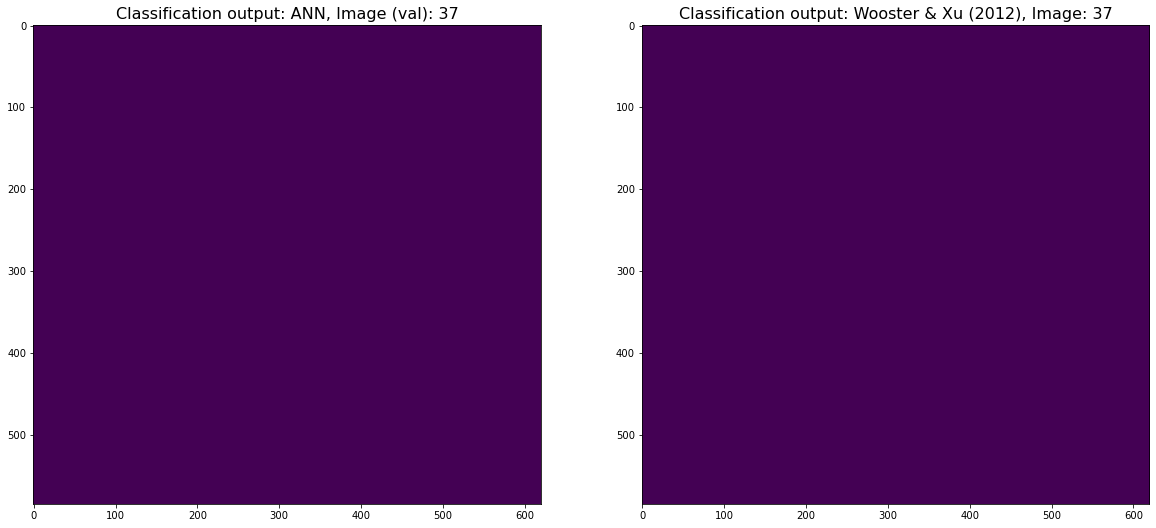

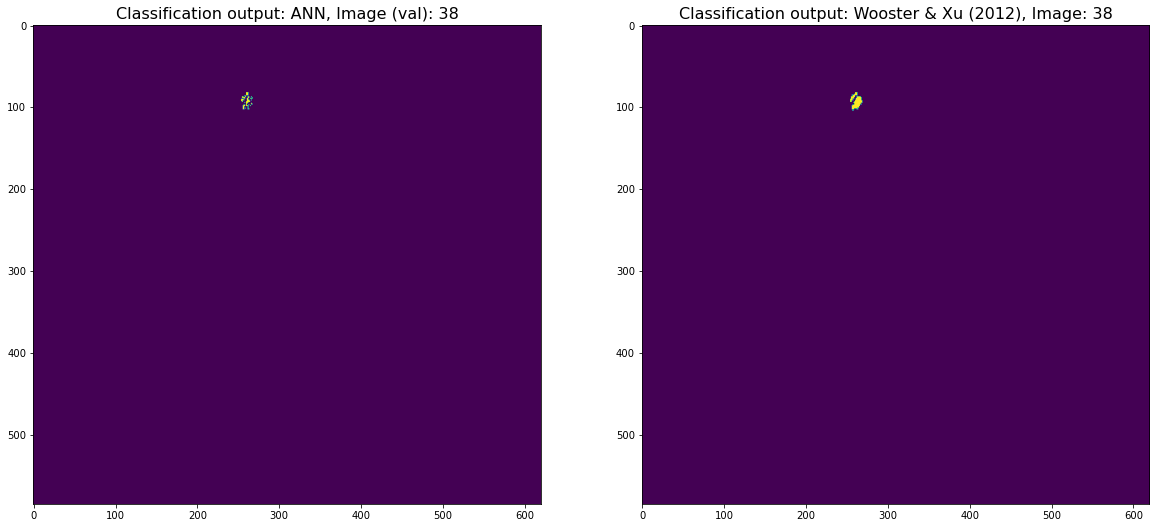

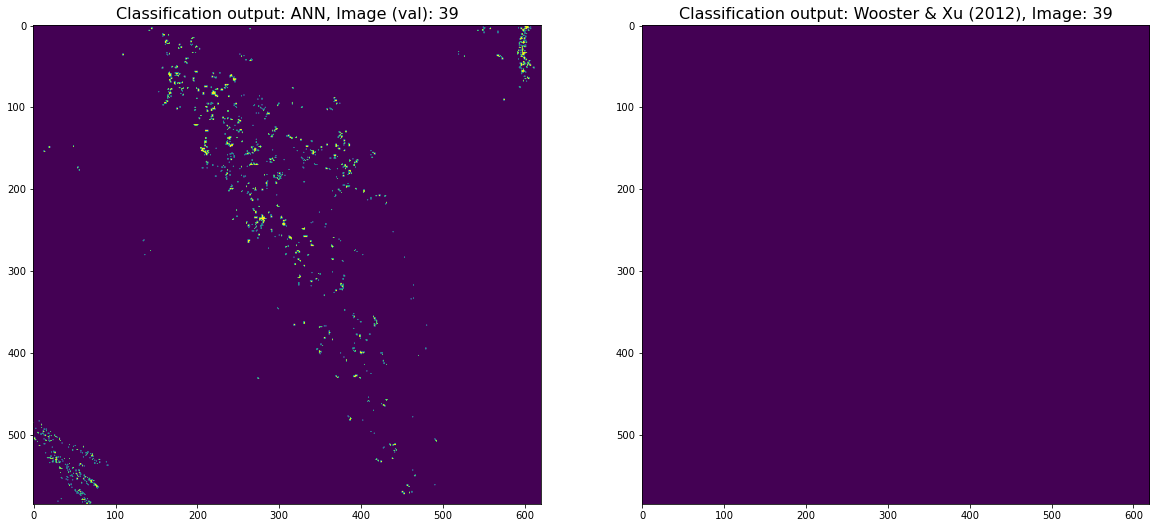

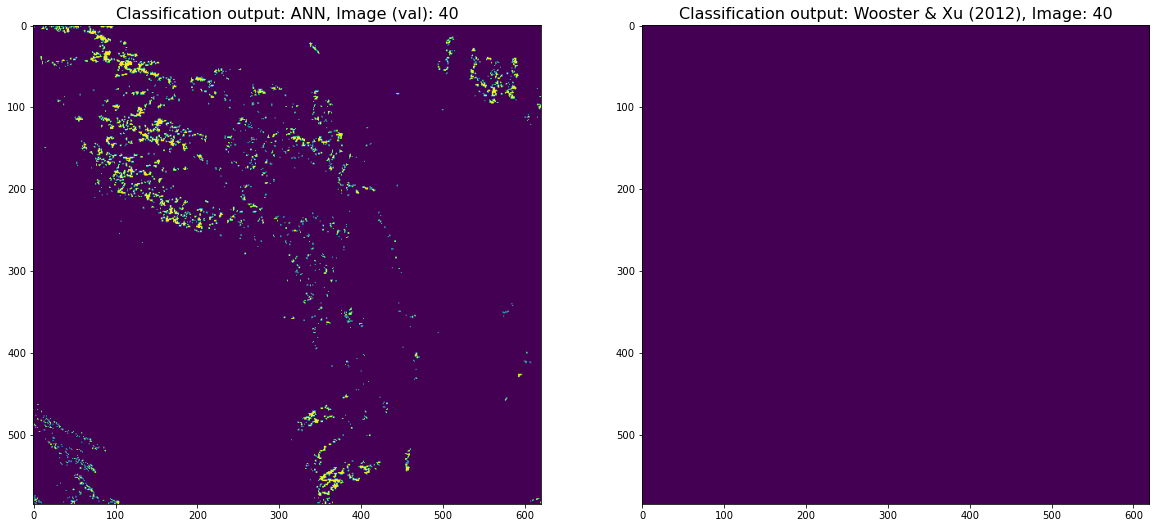

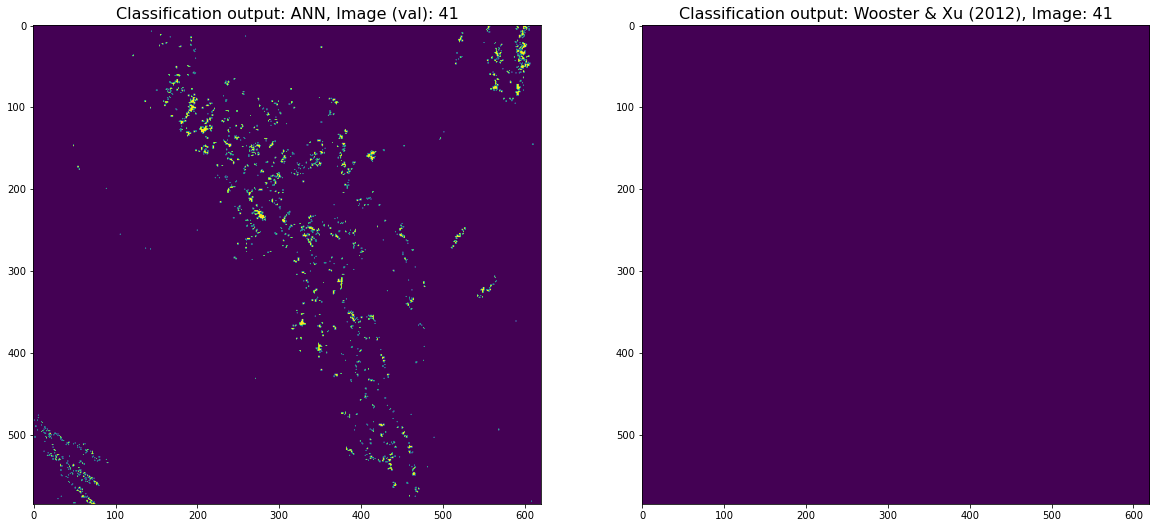

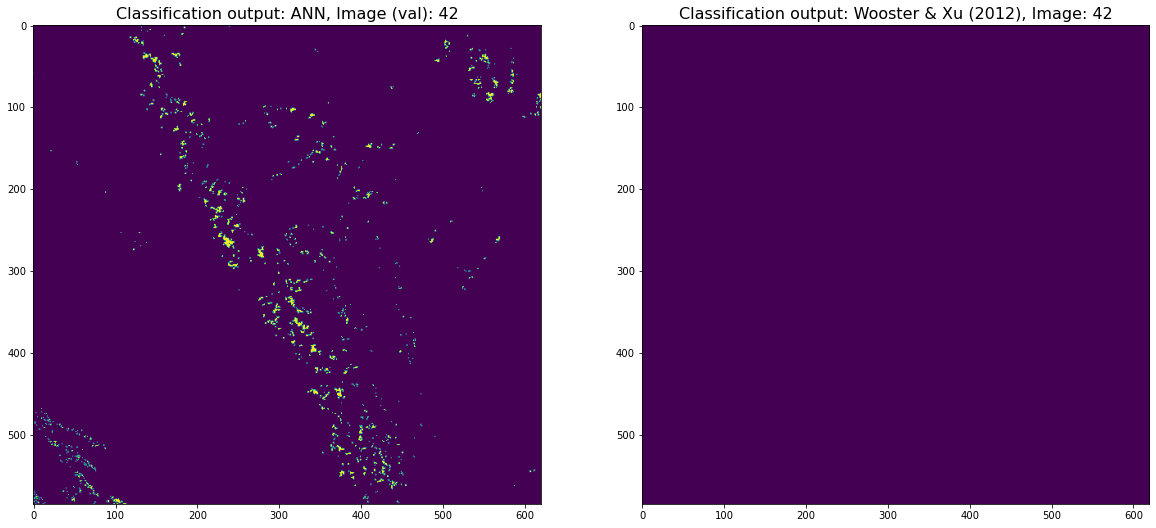

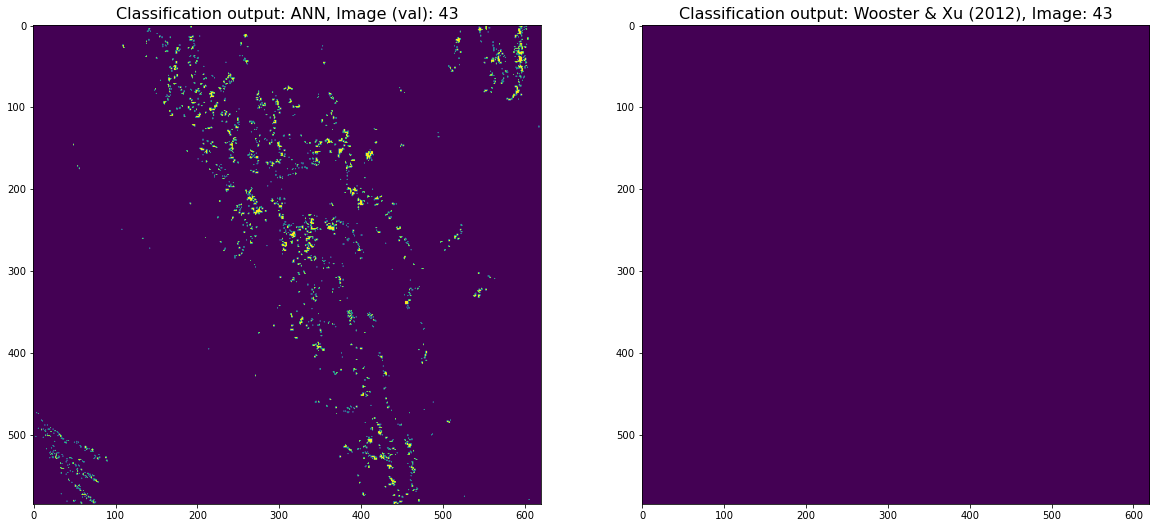

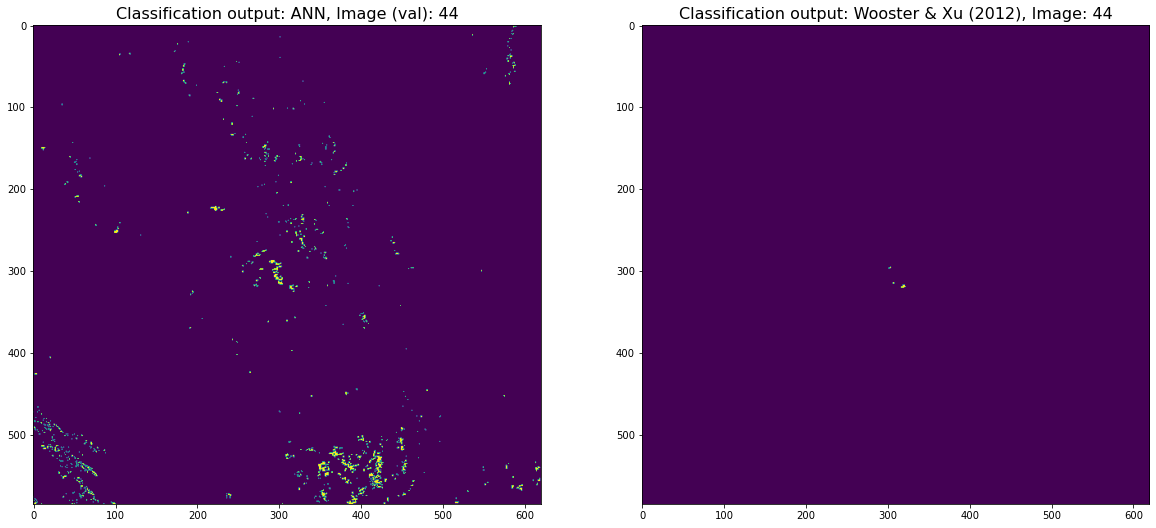

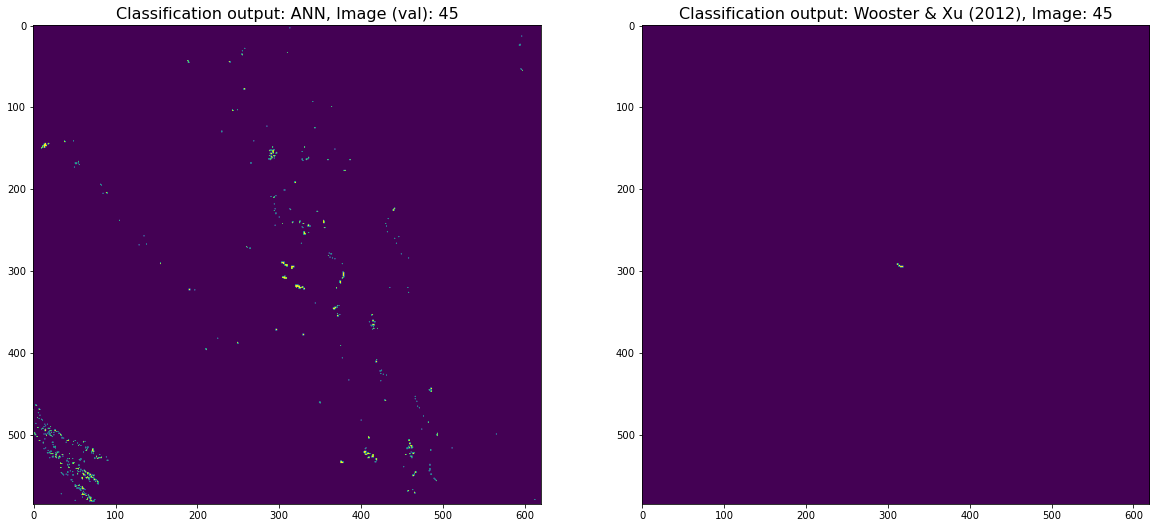

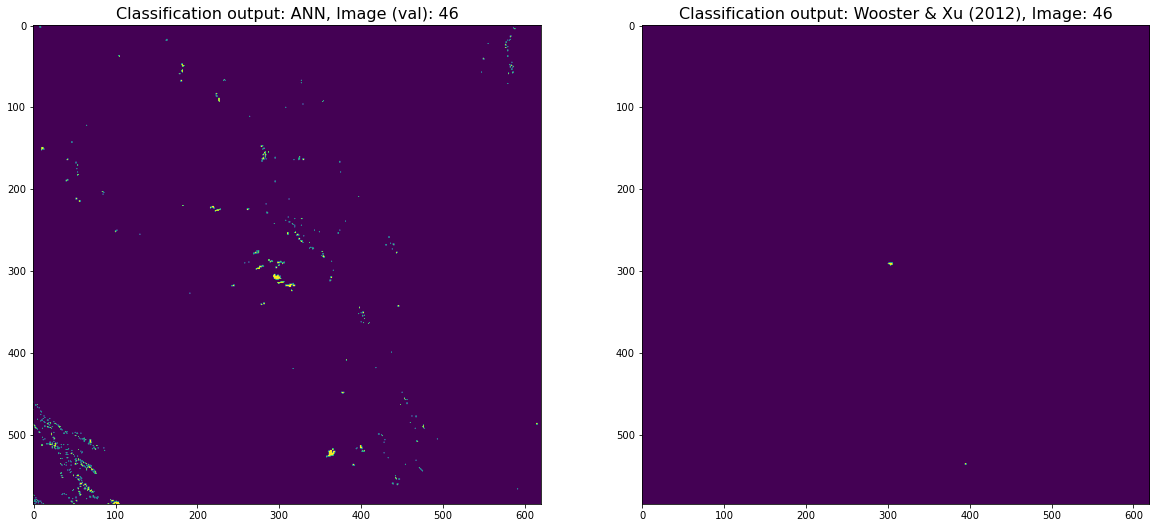

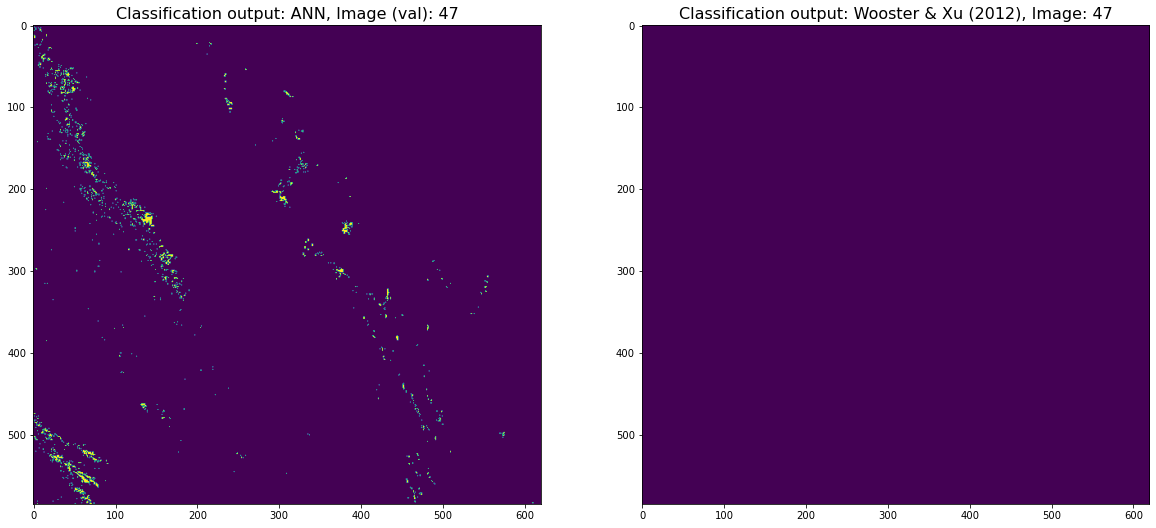

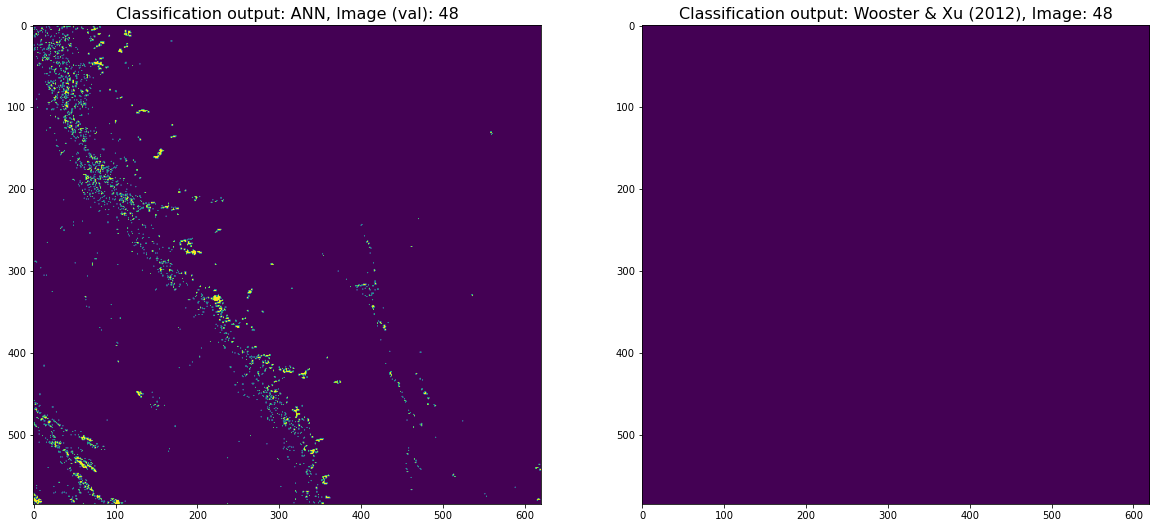

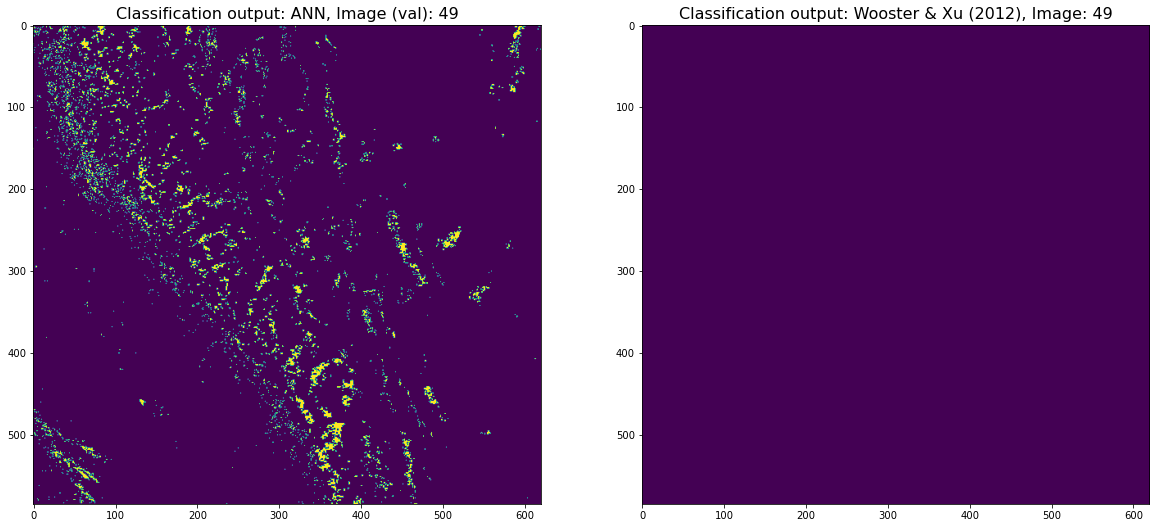

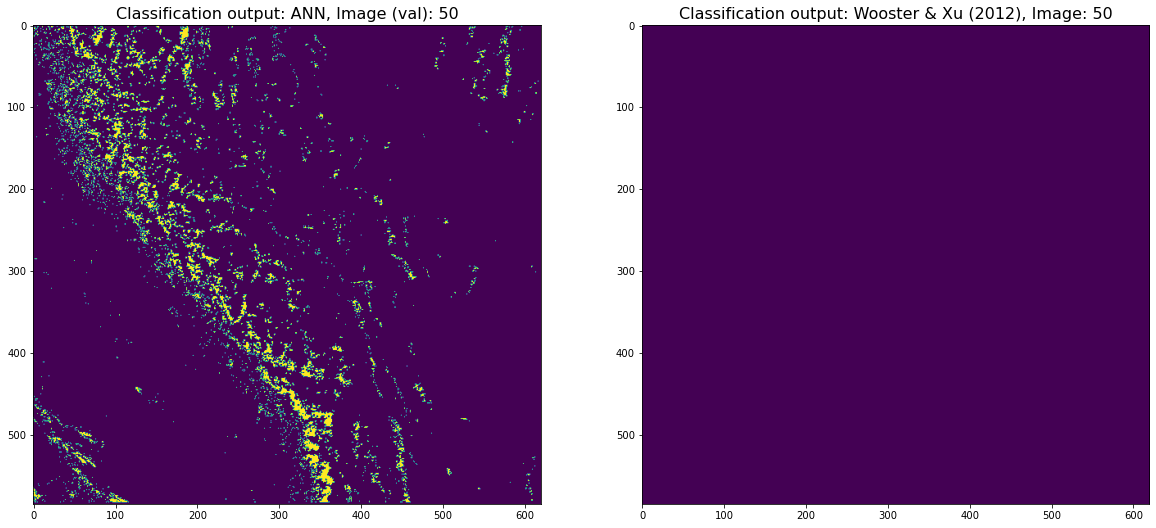

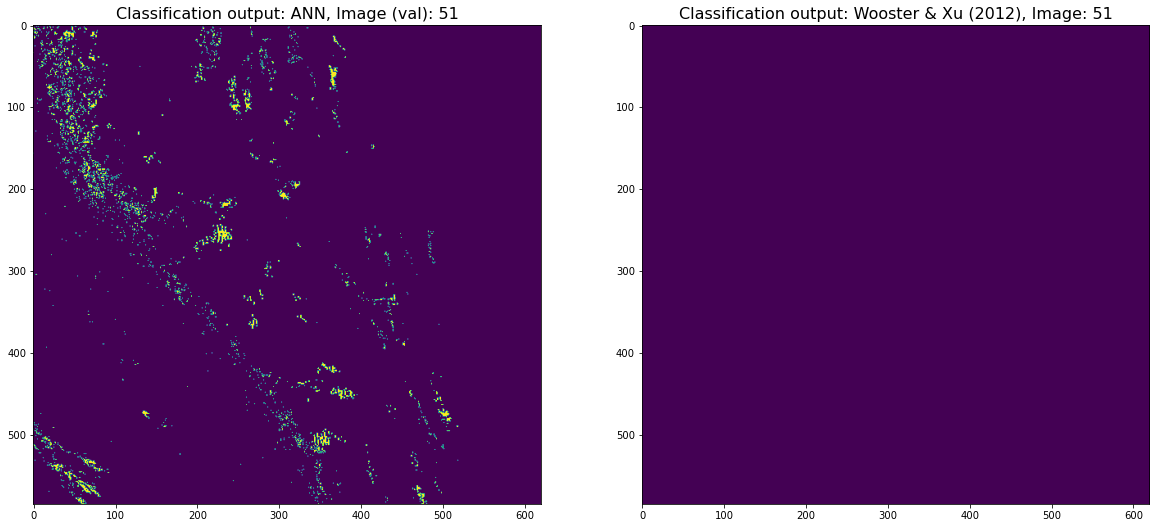

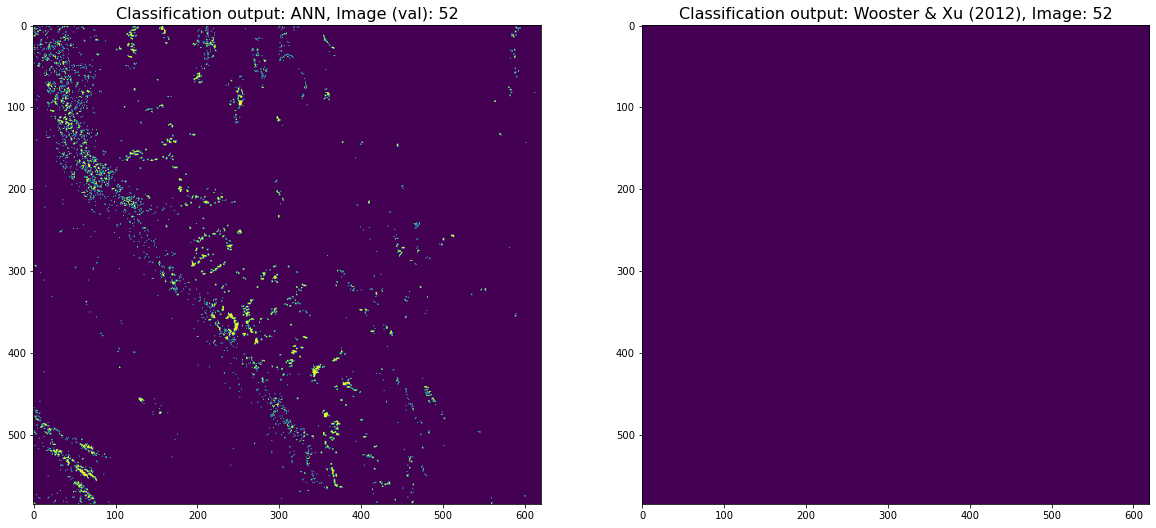

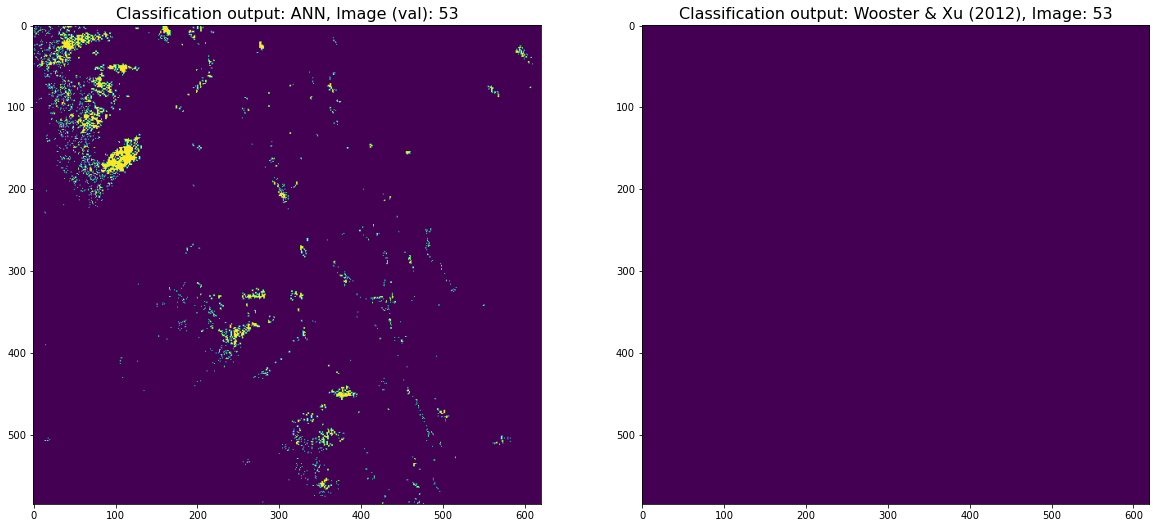

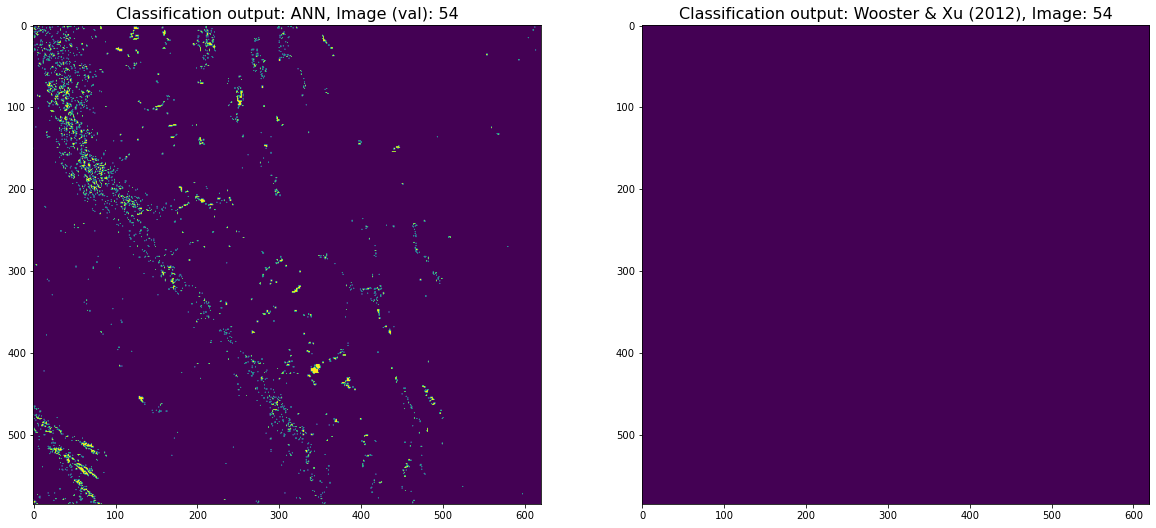

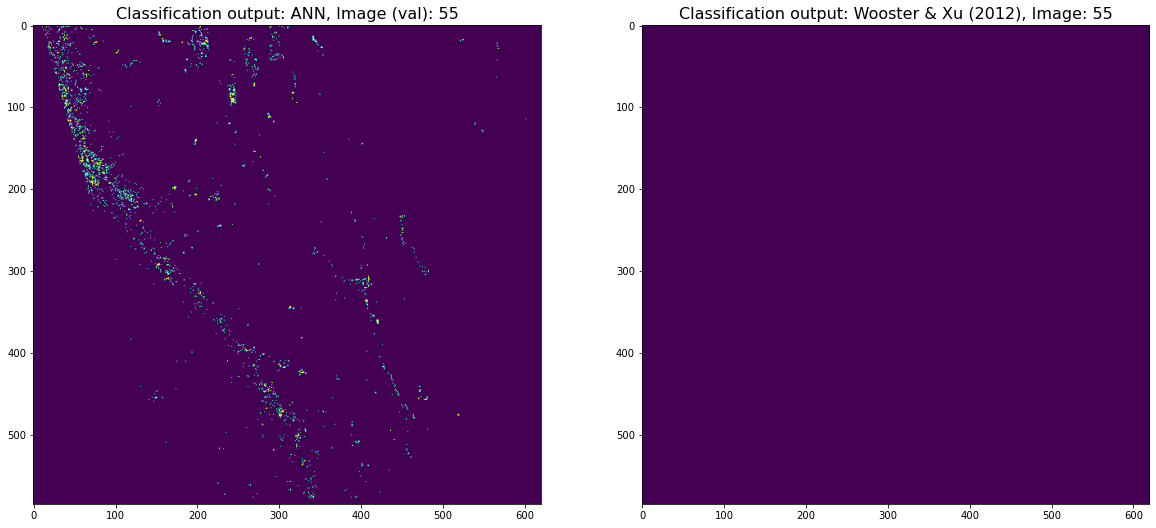

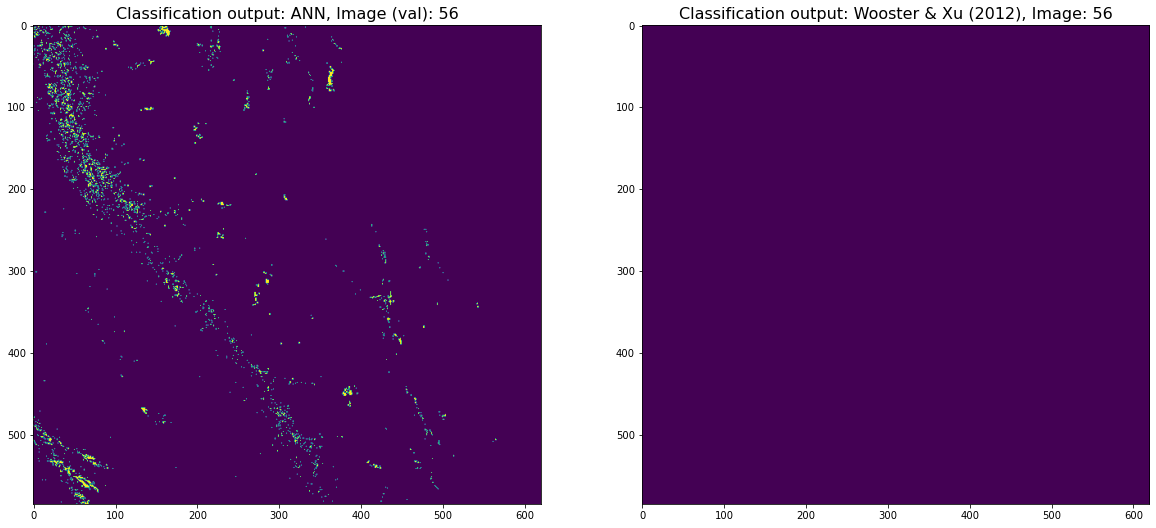

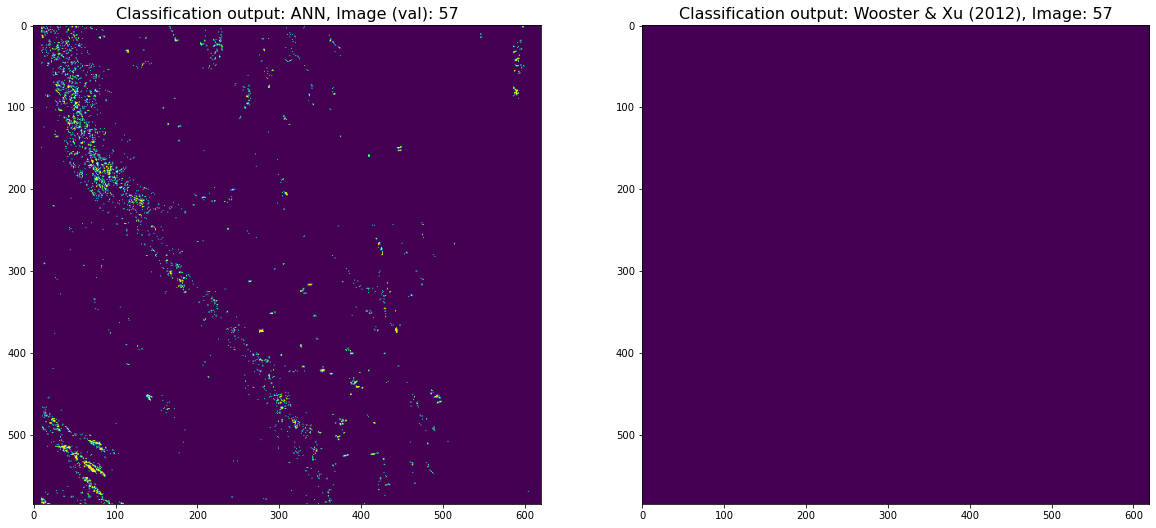

In [68]:
for img_n in range(len(predictions_nov)):
    pred_raster = predictions_nov[img_n].reshape(585, 620)
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].imshow(pred_raster)
    ax[0].grid(False)
    ax[0].set_title(f'Classification output: ANN, Image (val): {img_n}', fontsize=16)
    
    ax[1].imshow(labels_nov[img_n].reshape(585, 620))
    ax[1].grid(False)
    ax[1].set_title(f'Classification output: Wooster & Xu (2012), Image: {img_n}', fontsize=16)
    
    plt.show()

### Ordenamiento de imágenes
Some of the images have a wrong place in the array, correcting this issue is key to create the time-series; this process is showed below:

In [155]:
sept_oct = ['2020-09-01-D','2020-09-02-D','2020-09-03-D','2020-09-04-D','2020-09-05-D',
           '2020-09-06-D','2020-09-07-D','2020-09-08-D','2020-09-09-D','2020-09-10-D',
           '2020-09-11-D','2020-09-12-D','2020-09-13-D','2020-09-14-D','2020-09-15-D',
           '2020-09-16-D','2020-09-17-D','2020-09-18-D','2020-09-19-D','2020-09-20-D',
           '2020-09-21-D','2020-09-22-D','2020-09-23-D','2020-09-24-D','2020-09-25-D',
           '2020-09-26-D','2020-09-27-D','2020-09-28-D','2020-09-29-D','2020-09-30-D',
           '2020-09-01-N','2020-09-02-N','2020-09-03-N','2020-09-04-N','2020-09-05-N',
           '2020-09-06-N','2020-09-07-N','2020-09-08-N','2020-09-09-N','2020-09-10-N',
           '2020-09-11-N','2020-09-12-N','2020-09-13-N','2020-09-14-N','2020-09-15-N',
           '2020-09-16-N','2020-09-17-N','2020-09-18-N','2020-09-19-N','2020-09-20-N',
           '2020-09-21-N','2020-09-22-N','2020-09-23-N','2020-09-24-N','2020-09-25-N',
           '2020-09-26-N','2020-09-27-N','2020-09-28-N','2020-09-29-N','2020-09-30-N',
           '2020-10-02-D','2020-10-03-D','2020-10-06-D','2020-10-10-D','2020-10-13-D',
           '2020-10-14-D','2020-10-17-D','2020-10-18-D','2020-10-21-D','2020-10-22-D',
           '2020-10-25-D','2020-10-26-D','2020-10-29-D','2020-10-30-D','2020-10-01-D',
           '2020-10-04-D','2020-10-05-D','2020-10-07-D','2020-10-08-D','2020-10-09-D',
           '2020-10-11-D','2020-10-12-D','2020-10-15-D','2020-10-16-D','2020-10-19-D',
           '2020-10-20-D','2020-10-23-D','2020-10-24-D','2020-10-27-D','2020-10-28-D',
           '2020-10-31-D','2020-10-12-N','2020-10-03-N','2020-10-06-N','2020-10-07-N',
           '2020-10-10-N','2020-10-11-N','2020-10-14-N','2020-10-15-N','2020-10-18-N',
           '2020-10-22-N','2020-10-26-N','2020-10-29-N','2020-10-30-N','2020-10-01-N',
           '2020-10-02-N','2020-10-04-N','2020-10-05-N','2020-10-08-N','2020-10-09-N',
           '2020-10-13-N','2020-10-16-N','2020-10-17-N','2020-10-19-N','2020-10-20-N',
           '2020-10-21-N','2020-10-23-N','2020-10-24-N','2020-10-25-N','2020-10-27-N',
           '2020-10-28-N','2020-10-31-N']

nov_dates = ['2020-11-01-D','2020-11-02-D','2020-11-06-D','2020-11-09-D','2020-11-10-D',
            '2020-11-13-D','2020-11-14-D','2020-11-18-D','2020-11-21-D','2020-11-22-D',
            '2020-11-25-D','2020-11-26-D','2020-11-29-D','2020-11-03-D','2020-11-04-D',
            '2020-11-05-D','2020-11-07-D','2020-11-08-D','2020-11-12-D','2020-11-15-D',
            '2020-11-16-D','2020-11-19-D','2020-11-20-D','2020-11-23-D','2020-11-24-D',
            '2020-11-27-D','2020-11-28-D','2020-11-30-D','2020-11-02-N','2020-11-03-N',
            '2020-11-06-N','2020-11-07-N','2020-11-10-N','2020-11-11-N','2020-11-13-N',
            '2020-11-14-N','2020-11-15-N','2020-11-17-N','2020-11-18-N','2020-11-21-N',
            '2020-11-22-N','2020-11-25-N','2020-11-26-N','2020-11-29-N','2020-11-01-N',
            '2020-11-04-N','2020-11-05-N','2020-11-08-N','2020-11-09-N','2020-11-16-N',
            '2020-11-17-N','2020-11-19-N','2020-11-20-N','2020-11-23-N','2020-11-24-N',
            '2020-11-25-N','2020-11-27-N','2020-11-28-N',]

_As shown before, the badly classified images are removed from the set_

In [156]:
# Antes de continuar, eliminamos las clasificaciones de la RNA que salieron mal:
predictions_corr = np.delete(predictions_all, [115,116,117,118, 119, 120], axis=0)
sept_oct = np.delete(sept_oct, [115,116,117,118, 119, 120], axis=0)

In [157]:
np.array(predictions_all).shape, predictions_corr.shape

((122, 362700, 1), (116, 362700, 1))

In [158]:
predictions_nov_corr = np.delete(predictions_nov, range(38,58), axis=0)
nov_dates = np.delete(nov_dates, range(38,58), axis=0)

In [159]:
np.array(predictions_nov).shape, predictions_nov_corr.shape

((58, 362700, 1), (38, 362700, 1))

In [160]:
sept_oct = np.array(sept_oct)
nov_dates = np.array(nov_dates)
sept_oct.shape, nov_dates.shape

((116,), (38,))

_Here, the arrays are ordered in a cronological fashion_

In [161]:
nov_sortind = nov_dates.argsort() # Orden de indices para arreglo de noviembre
septoct_sortind = sept_oct.argsort() # Orden de indices para arreglo de sept-oct

In [162]:
nov_dates[nov_sortind] # Ejemplo de funcionamiento de ordenamiento, se muestra arreglo ordenado alfabéticamente

array(['2020-11-01-D', '2020-11-02-D', '2020-11-02-N', '2020-11-03-D',
       '2020-11-03-N', '2020-11-04-D', '2020-11-05-D', '2020-11-06-D',
       '2020-11-06-N', '2020-11-07-D', '2020-11-07-N', '2020-11-08-D',
       '2020-11-09-D', '2020-11-10-D', '2020-11-10-N', '2020-11-11-N',
       '2020-11-12-D', '2020-11-13-D', '2020-11-13-N', '2020-11-14-D',
       '2020-11-14-N', '2020-11-15-D', '2020-11-15-N', '2020-11-16-D',
       '2020-11-17-N', '2020-11-18-D', '2020-11-19-D', '2020-11-20-D',
       '2020-11-21-D', '2020-11-22-D', '2020-11-23-D', '2020-11-24-D',
       '2020-11-25-D', '2020-11-26-D', '2020-11-27-D', '2020-11-28-D',
       '2020-11-29-D', '2020-11-30-D'], dtype='<U12')

_Exportando arreglos ordenados_

## Stack and time-series creation

_Arrays are corrected using the cronological order created above_

In [163]:
SeptOct_corr = np.array(predictions_corr)[septoct_sortind].reshape(116, 585, 620) # Arreglo de predicciones de Sept-oct corregido
SOlbl_corr = labels[septoct_sortind].reshape(116, 585, 620) # Arreglo de labels de sept-oct corregido

Nov_corr = np.array(predictions_nov_corr)[nov_sortind].reshape(38, 585, 620)
NOVlbl_corr = labels_nov[nov_sortind].reshape(38, 585, 620)

_All the images are summed, to create a stack which will show the fire-scar created by all the fires_

In [164]:
Total_pred = np.sum(SeptOct_corr, axis=0) + np.sum(Nov_corr, axis=0)
Total_lbl = np.sum(SOlbl_corr, axis=0) + np.sum(NOVlbl_corr, axis=0)

In [165]:
Total_pred.shape

(585, 620)

In [166]:
Total_lbl.shape

(585, 620)

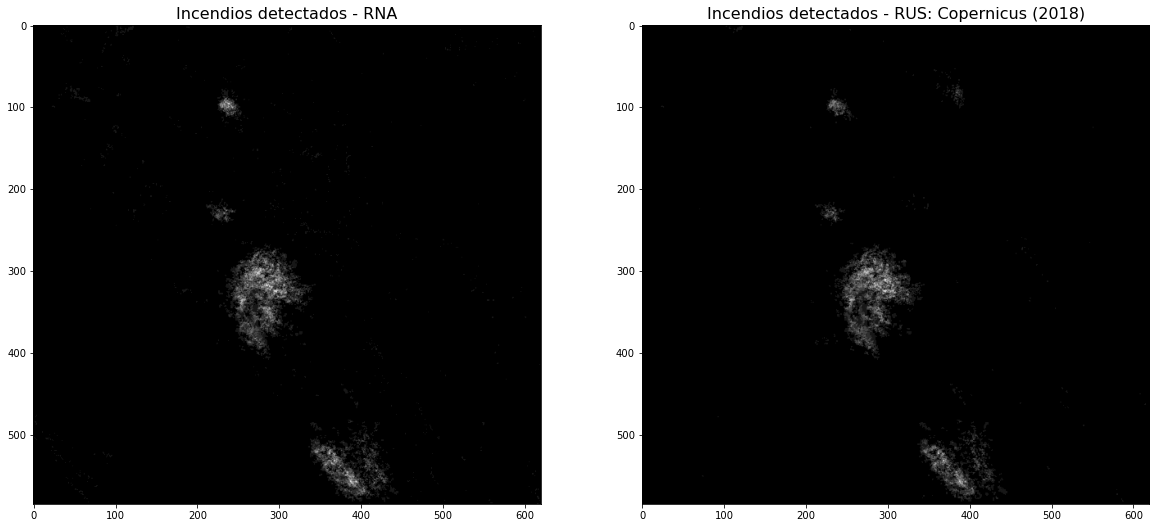

In [182]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].imshow(Total_pred, cmap="gray")
ax[0].grid(False)
ax[0].set_title('Detected fires - ANN', fontsize=16)

ax[1].imshow(Total_lbl, cmap="gray")
ax[1].grid(False)
ax[1].set_title('Detected Fires - RUS: Copernicus (2018)', fontsize=16)

plt.show()

## Displaying the fire time-series

In [87]:
SON_Fires = np.concatenate((SeptOct_corr, Nov_corr))
SON_Fires.shape

(158, 585, 620)

In [88]:
SON_Dates = np.concatenate((sept_oct[septoct_sortind], nov_dates[nov_sortind]))
SON_Dates.shape

(158,)

In [89]:
count_list = []
for i in range(158):
    fire_count = np.sum(np.sum(SON_Fires[0:i], axis=0)>0)
    count_list.append(fire_count)

In [90]:
count_list # Esta es la columna del avance de los incendios (cumulativo)

[0,
 244,
 366,
 512,
 610,
 908,
 1019,
 1421,
 1463,
 1816,
 1907,
 2246,
 2896,
 3672,
 4421,
 5033,
 5340,
 5662,
 5866,
 6061,
 6161,
 6340,
 6434,
 6760,
 6816,
 7281,
 7458,
 8232,
 8456,
 8622,
 8796,
 9137,
 9188,
 9877,
 10051,
 10262,
 10262,
 10303,
 10335,
 10446,
 10478,
 10605,
 10676,
 10883,
 10954,
 11034,
 11113,
 11203,
 11249,
 11282,
 11328,
 11395,
 11399,
 11432,
 11435,
 11477,
 11502,
 11522,
 11543,
 11562,
 11577,
 11586,
 11589,
 11603,
 11621,
 11650,
 11782,
 11861,
 11927,
 11968,
 12134,
 12183,
 12244,
 12330,
 12432,
 12436,
 12592,
 12600,
 12709,
 12711,
 12721,
 12722,
 12739,
 12763,
 12764,
 12781,
 12805,
 12849,
 12862,
 12963,
 12985,
 13017,
 13020,
 13044,
 13055,
 13066,
 13097,
 13163,
 13216,
 13222,
 13254,
 13269,
 13277,
 13285,
 13335,
 13802,
 13810,
 14008,
 14020,
 14690,
 14739,
 14812,
 14839,
 14852,
 14861,
 14866,
 14867,
 14871,
 14874,
 15083,
 15101,
 15125,
 15126,
 15144,
 15159,
 15168,
 15181,
 15192,
 15192,
 15192,
 1

_Calculating the burnt area_

In [91]:
# Tamaño de pixel: 582.7687679115396122 m 

count_ha = np.array(count_list) * 582.7687679115396122**2 / 10000

### Time-series table

In [92]:
import pandas as pd

columns = ['Fecha', 'Cuenta Píxeles', 'Extensión acumulada']
dataframe = pd.DataFrame(columns=columns)

dataframe['Fecha'] = SON_Dates
dataframe['Cuenta Píxeles'] = np.array(count_list)
dataframe['Extensión acumulada'] = count_ha
dataframe

Fecha  Cuenta Píxeles  Extensión acumulada
0    2020-09-01-D               0             0.000000
1    2020-09-01-N             244          8286.714259
2    2020-09-02-D             366         12430.071389
3    2020-09-02-N             512         17388.515167
4    2020-09-03-D             610         20716.785648
..            ...             ...                  ...
153  2020-11-26-D           15293        519380.004779
154  2020-11-27-D           15306        519821.510047
155  2020-11-28-D           15312        520025.281710
156  2020-11-29-D           15312        520025.281710
157  2020-11-30-D           15317        520195.091428

[158 rows x 3 columns]

In [93]:
dataframe.to_csv('dataframe.csv',index=False)

In [94]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dataframe)

            Fecha  Cuenta Píxeles  Extensión acumulada
0    2020-09-01-D               0             0.000000
1    2020-09-01-N             244          8286.714259
2    2020-09-02-D             366         12430.071389
3    2020-09-02-N             512         17388.515167
4    2020-09-03-D             610         20716.785648
5    2020-09-03-N             908         30837.444866
6    2020-09-04-D            1019         34607.220615
7    2020-09-04-N            1421         48259.921977
8    2020-09-05-D            1463         49686.323612
9    2020-09-05-N            1816         61674.889733
10   2020-09-06-D            1907         64765.426608
11   2020-09-06-N            2246         76278.525517
12   2020-09-07-D            2896         98353.788913
13   2020-09-07-N            3672        124708.257212
14   2020-09-08-D            4421        150145.753033
15   2020-09-08-N            5033        170930.462568
16   2020-09-09-D            5340        181356.779280
17   2020-

### Displaying the time series

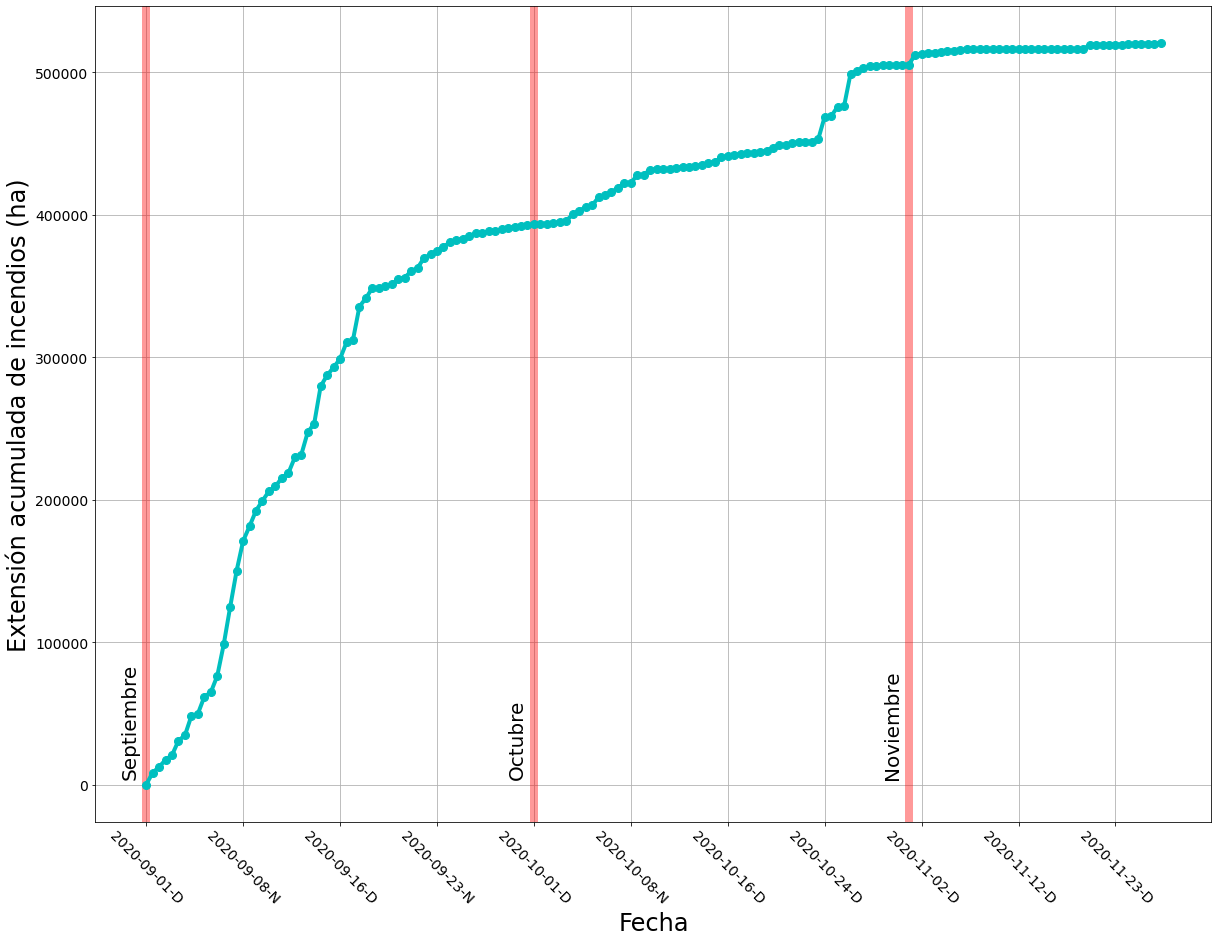

In [95]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

x = dataframe['Fecha']
y = dataframe['Extensión acumulada']
fig, ax = plt.subplots()
fig.set_size_inches(20,15)
ax.axvline(x=0, c='r', alpha=0.4, lw=8)
ax.axvline(x=60, c='r', alpha=0.4, lw=8)
ax.axvline(x=118, c='r', alpha=0.4, lw=8)
ax.plot(x,y, 'co-', lw=4, markersize=8)
loc = plticker.MultipleLocator(base=15.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xlabel('Date (YMD)', fontsize=24)
plt.ylabel('Cumulative Fire extension (ha)', fontsize=24)
plt.xticks(rotation=-45, fontsize=14)
plt.yticks(fontsize=14)
plt.text(-4,7000, 'Septiembre', rotation=90, fontsize=20)
plt.text(56,7000, 'Octubre', rotation=90, fontsize=20)
plt.text(114,7000, 'Noviembre', rotation=90, fontsize=20)
plt.grid()
plt.show()